In [1]:
%config Completer.use_jedi = False

In [882]:
from arch.bootstrap import StationaryBootstrap
from arch.bootstrap import IndependentSamplesBootstrap
# from arch.bootstrap import bootstrapped_difference
from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions as cf
import hdbscan
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
import os
import pandas as pd
import pickle
import random
from scipy.optimize import nnls
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import scipy
import scipy.cluster.hierarchy as sch
from scipy.stats import mannwhitneyu, normaltest
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import affinity_propagation
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannotations.Annotator import Annotator
import umap

In [3]:
os.getcwd()

'/home/tarunm3/Desktop/work/maslov_lab/crn_gut_microbiome/src'

# simulated annealing for finding Ri

In [4]:
def neighborhood_fn(current_solution, norm_temp):
    neighbor = np.zeros_like(current_solution)
    for id_, coord_ in enumerate(current_solution):
        neighbor[id_] = np.random.normal(coord_, sqrt(norm_temp), 1)
    
    return neighbor

def objective_fn(Ri, pass_=0):
    

# Simulated Annealing function
def simulated_annealing(initial_solution, neighborhood_fn, objective_fn, temperature, cooling_rate, \
                        stopping_temperature):
    # Initialize the current solution and best solution
    current_solution = initial_solution[:]
    best_solution = initial_solution[:]

    # Start the search until the stopping temperature is reached
    while temperature > stopping_temperature:
        # Generate a random neighbor
        neighbor = neighborhood_fn(current_solution, temperature / stopping_temperature)

        # Calculate the objective function difference between the current solution and the neighbor
        delta = objective_fn(neighbor) - objective_fn(current_solution)

        # If the neighbor is better, move to it
        if delta < 0:
            current_solution = neighbor[:]
        # If the neighbor is worse, move to it with a probability based on the temperature
        else:
            probability = math.exp(-delta / temperature)
            if random.random() < probability:
                current_solution = neighbor[:]

        # Update the best solution if necessary
        if objective_fn(current_solution) < objective_fn(best_solution):
            best_solution = current_solution[:]

        # Cool the temperature
        temperature *= cooling_rate

    # Return the best solution found
    return best_solution

# Define the objective function to calculate the value of a solution
def value_fn(solution):
    return sum(solution)

# Define the neighborhood function to change one element in the solution
def neighborhood_fn(solution):
    neighborhoods = []
    for i in range(len(solution)):
        neighbor = solution[:]
        neighbor[i] = random.randint(0, 9)
        neighborhoods.append(neighbor)
    return neighborhoods

# Set the initial solution and parameters for the Simulated Annealing algorithm
initial_solution = [random.randint(0, 9) for _ in range(10)]
temperature = 1000
cooling_rate = 0.95
stopping_temperature = 1e-8

# Run the Simulated Annealing algorithm to find the best solution
best_solution = simulated_annealing(initial_solution, neighborhood_fn, value_fn, temperature, cooling_rate, stopping_temperature)

# Print the best solution and its value
print("Best solution found:", best_solution)
print("Value of best solution:", value_fn(best_solution))


IndentationError: expected an indented block (<ipython-input-4-d3f4a3ad5e39>, line 12)

# Utility functions for easy plotting

In [5]:
def print_n_projects(df, df_name="the dataset"):
    print(f"There are {df.shape[0]} projects in {df_name}.")
    
    
def describe_array(array: np.array, name=None, min_len=15):
    name = f"\"{name}\"".ljust(min_len) if name is not None else ''
    print(f"{name}Number of projects: {len(array)}" + "\t" 
          + f"Min: {array.min():.2f}" + "\t"
          + f"Max: {array.max():.2e}" + "\t"
          + f"Avg: {array.mean():.2f}" + "\t"
          + f"Median: {np.percentile(array, 50):.2e}")
    
    
def get_projects_by(df, row_name, func):
    """Returns a list of projects, sorted by `func` result by `Subcategory`"""
    # noinspection PyUnresolvedReferences
    func = getattr(pd.core.groupby.generic.DataFrameGroupBy, func)
    grouped_df = (func(df.groupby("Subcategory"))
                  .sort_values(by=row_name, ascending=False)
                  .reset_index())
    ans = []
    for index, row in grouped_df.iterrows():
        ans.append(
            f"{index+1}. {row.Subcategory.ljust(20-(index+1)//10)} "
            f"{row[[row_name]].values[0]:.2e}")
    return ans


def print_projects_by(df, row_name, func):
    """Prints a list of projects, sorted by `func` result by `Subcategory`"""
    projects = get_projects_by(df, row_name, func)
    print("\n".join(projects))
    
    
def label_plot_for_subcats(ax):
    plt.title("Goal amounts per Technology Subcategory", y=1.06)
    ax.set_ylabel("Goal ($)")
    ax.set_xlabel("Technology Project Subcategory", labelpad=20)
    
    
def label_plot_for_states(ax):
    plt.title("Goal amounts per project State", y=1.06)
    ax.set_ylabel("Goal ($)")
    ax.set_xlabel("Project State", labelpad=20)
    
    
def get_log_ax(orient="v"):
    if orient == "v":
        figsize = (12, 6)
        set_scale = "set_yscale"
    else:
        figsize = (10, 8)
        set_scale = "set_xscale"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.patch.set_alpha(1)
    getattr(ax, set_scale)("log")
    return ax


def add_legend(ax):
    ax.legend(loc=(1.05, 0.5))

# Utility functions

In [4]:
def iterate_growth_ratio(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, p_):
    df_speciesAbun_split = geometric_avg(df_speciesAbun_prev, df_speciesAbun_next, p=p_)
    df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, \
                                                     df_speciesAbun=df_speciesAbun_split)
    sample_names_split, mat_cons_abun_split_list = \
        compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_split, 
                                              df_speciesMetab=df_speciesMetab, 
                                              num_passages=6, num_bioRep=3, 
                                              sample_names=list(df_speciesAbun_split.columns.values))
    return sample_names_split, mat_cons_abun_split_list

In [5]:
def get_metab_names_orderedRi(Ri, df_metabNames, df_metabIds):
    metab_names_all = df_metabNames.iloc[:, 1].values
    metab_id_data = df_metabIds.iloc[:, 0].values - 1
    metab_names = metab_names_all[metab_id_data]
    
    id_order = np.argsort(-Ri)
    Ri_ordered = Ri.copy()[id_order]
    metab_names_ordered = metab_names[id_order]
    
    return id_order, Ri_ordered, metab_names_ordered

In [6]:
def model_order_0(x, *ln_Ri):
    Ri = np.exp(-np.array(ln_Ri))
    return np.matmul(x.T, Ri) 

In [7]:
def create_abundance_header(num_bioRep=3, num_passages=6):
    '''Create header for the datafram with species abundance'''
    header_ = []
    for pass_ in range(num_passages):
        for rep_ in range(num_bioRep):
            header_.append('p' + str(pass_ + 1) + "_" + 'r' + str(rep_))
    return header_

In [8]:
def create_abundance_header_new(num_bioRep=3, num_passages=6):
    '''Create header for the datafram with species abundance'''
    header_ = []
    for rep_ in range(num_bioRep):
        for pass_ in range(num_passages):
            header_.append('p' + str(pass_ + 1) + "_" + 'r' + str(rep_))
    return header_

In [9]:
def expand_passage_by_rep(passage_='p1', num_bioRep=3):
    '''Expand passage name to include replicate numbers as well'''
    passage_rep = []
    for rep_ in range(num_bioRep):
        passage_rep.append(passage_ + "_" + "r" + str(rep_))
        
    return passage_rep

In [10]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, pval_ = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'rho = {r:.2f}, pval = {pval_:.3f}', xy=(.1, .9), xycoords=ax.transAxes)

In [11]:
def compute_cons_abun_prod(df_speciesMetab, df_speciesAbun):
    '''Compute matrix product of species-metabolite consumption matrix and species abundance matrix'''
    df_speciesAbun_T = df_speciesAbun.copy()
    df_speciesAbun_T = df_speciesAbun_T.transpose()
#     df_cons_abun_prod = df_speciesAbun_T.dot(df_speciesMetab)
    df_cons_abun_prod = np.matmul(np.array(df_speciesAbun_T.values), np.array(df_speciesMetab.values))
    return df_cons_abun_prod

In [12]:
def compute_species_metab_matrix_for_nnls(df_cons_abun_prod, df_speciesMetab, num_passages=6, num_bioRep=3, 
                                          sample_names=None):
    '''create one matrix of c_i^alpha / (sum_beta c_i^beta B_beta(k)) (species X metabolites) 
       for each passage and bioreplicate'''
    num_species_tmp = df_speciesMetab.shape[0]
    num_metabs_tmp = df_speciesMetab.shape[1]
    if sample_names is None:
        sample_names = create_abundance_header(num_passages=6, num_bioRep=3)
    mat_cons_abun_list = {}
    tmp_ones = np.ones((num_species_tmp, 1))
    for sample_ in sample_names:
#         df_denom = df_cons_abun_prod.loc[sample_, :]
        df_denom = df_cons_abun_prod[sample_names.index(sample_), :]
        tmp_mat = np.array(df_denom).reshape((1, num_metabs_tmp))
        mat_denom = np.matmul(tmp_ones, tmp_mat)
        mat_cons_abun_list[sample_] = np.divide(np.array(df_speciesMetab.copy().values), mat_denom)
        
    return sample_names, mat_cons_abun_list

In [13]:
def null_Ri(df_speciesMetab, df_speciesAbun_ratio, df_cons_abun_prod_split, p_=0):
    tmp = np.matmul(np.array(df_speciesMetab.sum(axis=1)).reshape((df_speciesMetab.shape[0], 1)), 
              np.ones((1, df_speciesAbun_ratio.shape[1])))
    tmp = np.divide(tmp, df_speciesAbun_ratio**p_)
    tmp = np.matmul(np.array(tmp.mean(axis=0)).reshape((df_cons_abun_prod_split.shape[0], 1)), 
                    np.ones((1, df_cons_abun_prod_split.shape[1])))
    tmp = np.divide(df_cons_abun_prod_split, tmp)
    R_i_0 = tmp.mean(axis=0)
    
    id_zero = np.where(np.array(df_speciesMetab.sum(axis=0)) == 0)[0]
    R_i_0[id_zero] = 0
    return R_i_0

In [14]:
def null_Ri_2(df_speciesMetab, df_cons_abun_prod_split):
    tmp = df_speciesMetab.sum(axis=1)
    tmp = np.array(df_speciesMetab.sum(axis=1)).mean()
    tmp = df_cons_abun_prod_split.mean(axis=0) / tmp
    return tmp

In [15]:
df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                           df_speciesAbun=df_speciesAbun)
Ri_null = null_Ri_2(df_speciesMetab, df_cons_abun_prod_split)

NameError: name 'df_speciesMetab' is not defined

In [16]:
np.sum(Ri_null)

NameError: name 'Ri_null' is not defined

In [17]:
def null_Ri_2_p(df_speciesMetab, df_speciesAbun_ratio, df_cons_abun_prod_split, p_=0):
    tmp = np.array(df_speciesMetab.sum(axis=1)).mean()
    tmp_abun = np.zeros((df_speciesAbun_ratio.shape[1], 1))

    for k in range(df_speciesAbun_ratio.shape[1]):
        id_ = np.where(np.array((df_speciesAbun_ratio))[:, k] != -1)[0]
        tmp_k = np.array((df_speciesAbun_ratio**p_))[:, k]
        tmp_abun[k, 0] = np.mean(tmp_k[id_])
#     tmp_abun = np.array((df_speciesAbun_ratio**p_).mean(axis=0)).reshape((df_speciesAbun_ratio.shape[1], 1))
    tmp_abun = np.matmul(tmp_abun, np.ones((1, df_cons_abun_prod_split.shape[1])))
    tmp = (df_cons_abun_prod_split * tmp_abun).mean(axis=0) / tmp
    return tmp

In [18]:
id_order = np.argsort(-R_i_0_)
metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
print(np.array(metab_names[id_order]).reshape((len(metab_names), 1)))

NameError: name 'R_i_0_' is not defined

In [ ]:
R_i_0 = null_Ri_2(df_speciesMetab, df_speciesAbun, df_cons_abun_prod)
# R_i_0_ = null_Ri_2_p(df_speciesMetab.iloc[train_strain_id, :], \
#                      df_speciesAbun_ratio.iloc[train_strain_id, :], df_cons_abun_prod_split, p_ =0.1)
R_i_0_ = null_Ri_2_p(df_speciesMetab.iloc[:, :], \
                     df_speciesAbun_ratio.iloc[:, :], df_cons_abun_prod_split, p_ =0.1)
print(scipy.stats.spearmanr(R_i_0, R_i_0_))
graph_ = sns.scatterplot(x=R_i_0, y=R_i_0_)
graph_.set_yscale("log", base=10)
graph_.set_xscale("log", base=10)

In [43]:
np.sum(R_i_0_)

1.0106289780346613

In [549]:
R_i_0 = null_Ri_2(df_speciesMetab, df_speciesAbun, df_cons_abun_prod)
R_i_0_ = null_Ri_2_p(df_speciesMetab, df_speciesAbun_ratio, df_cons_abun_prod_split, p_ =0)
id_order = np.argsort(-R_i_0)
# R_i_0[id_order]
metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
metab_names_new = metab_names[id_order]
metab_names_new

array(['GLUTAMINE', "5'-METHYLTHIOADENOSINE", 'ADENOSINE', 'ASPARAGINE',
       '3-UREIDOPROPIONATE', 'CITRIC ACID', 'GLYCEROL 2-PHOSPHATE',
       'GLYCYL-GLYCINE', 'METHYLMALONIC ACID', 'NICOTINAMIDE', 'URIDINE',
       'ASP-PHE', 'N-ACETYLNEURAMINATE', 'CARNOSINE', 'SERINE',
       '1-METHYLADENOSINE', "2'-DEOXYGUANOSINE 5'-MONOPHOSPHATE",
       'THREONINE', '4-AMINOBUTANOIC ACID', 'ITACONIC ACID',
       'CINNAMALDEHYDE', 'INOSINE', 'GLYCERIC ACID',
       '1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID', 'MANNOSE 6-PHOSPHATE',
       'ASPARTIC ACID', '4-ETHYLOCTANOIC ACID', 'N-METHYL-ASPARTIC ACID',
       'ADENINE', 'O-ACETYL-SERINE', 'GUANOSINE', 'GLUCOSE', 'URACIL',
       'N-METHYL-ASPARTIC ACID', 'BETA-ALANINE', 'PYRUVIC ACID',
       'GLUTAMIC ACID', '4-METHYLVALERIC ACID', 'CYTIDINE',
       'CITRAMALIC ACID', 'PYROGLUTAMIC ACID', 'THREONINE',
       'HYPOXANTHINE', "ADENOSINE 2',3'-CYCLIC MONOPHOSPHATE", 'XANTHINE',
       'HISTIDINE', 'DIACETYL', 'AMINO(4-HYDROXYCYCLOHEXYL)ACETIC

In [548]:
scipy.stats.pearsonr(R_i_0, R_i_0_)

(0.9999959534133178, 0.0)

In [17]:
def null_Ri_3(df_speciesMetab, df_speciesAbun_ratio, df_cons_abun_prod_split, p_=0):
    tmp_ci = np.array(df_speciesMetab.sum(axis=1))
    tmp_ratio = df_speciesAbun_ratio**p_

    tmp_denom = np.zeros((df_speciesAbun_ratio.shape[1]))

    for k in range(df_speciesAbun_ratio.shape[1]):
        tmp_val = np.array(tmp_ratio.iloc[:, k].values)
        id_keep = np.where(df_speciesAbun_ratio.iloc[:, k].values != -1)[0]
        tmp_denom[k] = np.divide(tmp_ci[id_keep], tmp_val[id_keep]).mean()

    tmp_denom = tmp_denom.mean()
    
    R_i = df_cons_abun_prod_split.mean(axis=0) / tmp_denom
    
    id_zero = np.where(np.array(df_speciesMetab.sum(axis=0)) == 0)[0]
    R_i[id_zero] = 0
    
    return R_i

In [19]:
val_[(id_[0], id_[1])].flatten()

NameError: name 'val_' is not defined

In [18]:
def null_Ri_proper(df_speciesMetab, df_speciesAbun_ratio, df_cons_abun_prod_split, p_=0):
    R_i_0 = np.zeros((df_speciesMetab.shape[1]))
    
    for i in range(df_speciesMetab.shape[1]):
        c_i_a = np.array(df_speciesMetab.iloc[:, i].values).reshape((1, df_speciesMetab.shape[0]))
        c_i_a = np.matmul(np.ones((df_cons_abun_prod_split.shape[0], 1)), \
                          c_i_a).T
        denom_ = df_cons_abun_prod_split[:, i].reshape((df_cons_abun_prod_split.shape[0], 1))
        denom_ = np.matmul(denom_, np.ones((1, df_speciesMetab.shape[0]))).T
        
        np_ratio = np.array(df_speciesAbun_ratio.copy())
        id_ = np.where(np_ratio > 0)
        val_ = c_i_a / (denom_ * np_ratio**p_)
        val_out = val_[(id_[0], id_[1])]
        val_out = val_out.mean()
        R_i_0[i] = 1 / (df_speciesMetab.shape[1] * val_out)
        
        id_zero = np.where(np.array(df_speciesMetab.sum(axis=0)) == 0)[0]
        R_i_0[id_zero] = 0
        
    return R_i_0

$$R_i(0) = \frac{1}{M}\, \left(\left \langle \frac{c_i^{\alpha}\, \left(\frac{B^{\alpha}(k)}{B^{\alpha}(k + 1)} \right)^p}{\sum_{\beta}\, c_i^{\beta}\, B^{\beta}_{\text{split}}(k)}  \right \rangle_{\alpha, k} \right)^{-1}$$

In [17]:
np.where(np.array(df_speciesMetab.sum(axis=0)) == 0)

NameError: name 'df_speciesMetab' is not defined

In [308]:
R_i_0 = null_Ri_proper(df_speciesMetab, df_speciesAbun_ratio, df_cons_abun_prod_split, p_=0)
print(R_i_0)

[1.96612841e-03 6.47519721e-03 3.89031328e-04 1.19400020e-03
 7.97762030e-04 2.06706113e-03 1.14213169e-03 5.62666549e-04
 5.20850369e-03 2.91506022e-03 2.46251498e-04 7.30160478e-04
 1.03242932e-03 1.72332072e-03 1.48476951e-03 2.52227656e-03
 2.25810308e-08 1.45807621e-03 2.41968256e-03 4.26599291e-03
 4.58351836e-04 6.95502593e-05 6.51445624e-04 2.07567417e-03
 4.88899763e-03 1.76937407e-06 2.05784082e-03 1.16240587e-02
 6.61031514e-03 1.90051091e-03 7.37045728e-05 2.66560513e-03
 5.86600303e-04 1.74585558e-05 2.00887114e-03 7.70176253e-03
 2.68042131e-08 1.02613380e-04 2.75533973e-03 2.01442465e-03
 2.85845850e-04 2.13416087e-08 3.29085580e-03 2.58426125e-03
 2.71870483e-03 3.52536251e-03 1.81297054e-03 2.57624424e-03
 1.74238638e-03 9.26694493e-04 7.70130840e-04 1.56019745e-03
 1.84921613e-03 1.84146974e-03 2.72562960e-03 2.19049078e-03
 2.25465119e-03 1.63658220e-03 2.32048440e-03 2.02764748e-03
 4.90223274e-04 2.84781238e-08 1.65469474e-03 3.52196823e-03
 1.50489471e-03 1.330929

(0.1776705099515109, 0.002309123988030044)


<AxesSubplot: >

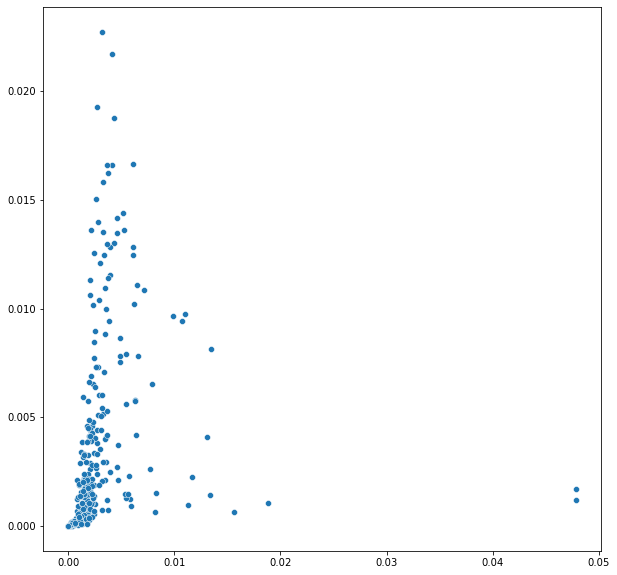

In [310]:
x = R_i_0
# x = coeff_null_train_2[rep_][fold_][0]
y = coeff_null_train[rep_][fold_][0]
print(scipy.stats.pearsonr(x, y))
sns.scatterplot(x=x, y=y)

In [19]:
def get_rank(arr):
    # Get the sorted indices
    sorted_indices = np.argsort(arr)

    # Initialize an array to hold the ranks
    ranks = np.zeros_like(sorted_indices)

    # Rank the elements
    ranks[sorted_indices] = np.arange(len(arr))

    # Calculate the average rank for repeated values
    unique_arr, unique_counts = np.unique(arr, return_counts=True)
    repeat_indices = np.where(unique_counts > 1)[0]
    for idx in repeat_indices:
        repeat_mask = (arr == unique_arr[idx])
        repeat_ranks = ranks[repeat_mask]
        mean_rank = repeat_ranks.mean()
        ranks[repeat_mask] = mean_rank
    return ranks

In [20]:
def geometric_avg(mat_init, mat_final, p=0):
    mat_split = mat_init**p * mat_final**(1 - p)
    return mat_split

In [21]:
def dynamical_model(df_speciesAbun, Ri, df_speciesMetab):
    df_cons_abun_prod = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, \
                                               df_speciesAbun=df_speciesAbun)
    sample_names, mat_cons_abun_list = \
        compute_species_metab_matrix_for_nnls(df_cons_abun_prod, df_speciesMetab, \
                                              sample_names=["sample"])
    B_next = np.matmul(mat_cons_abun_list["sample"], Ri)
    B_next = np.multiply(B_next, df_speciesAbun["sample"].values)
    
    return(B_next)
    
    

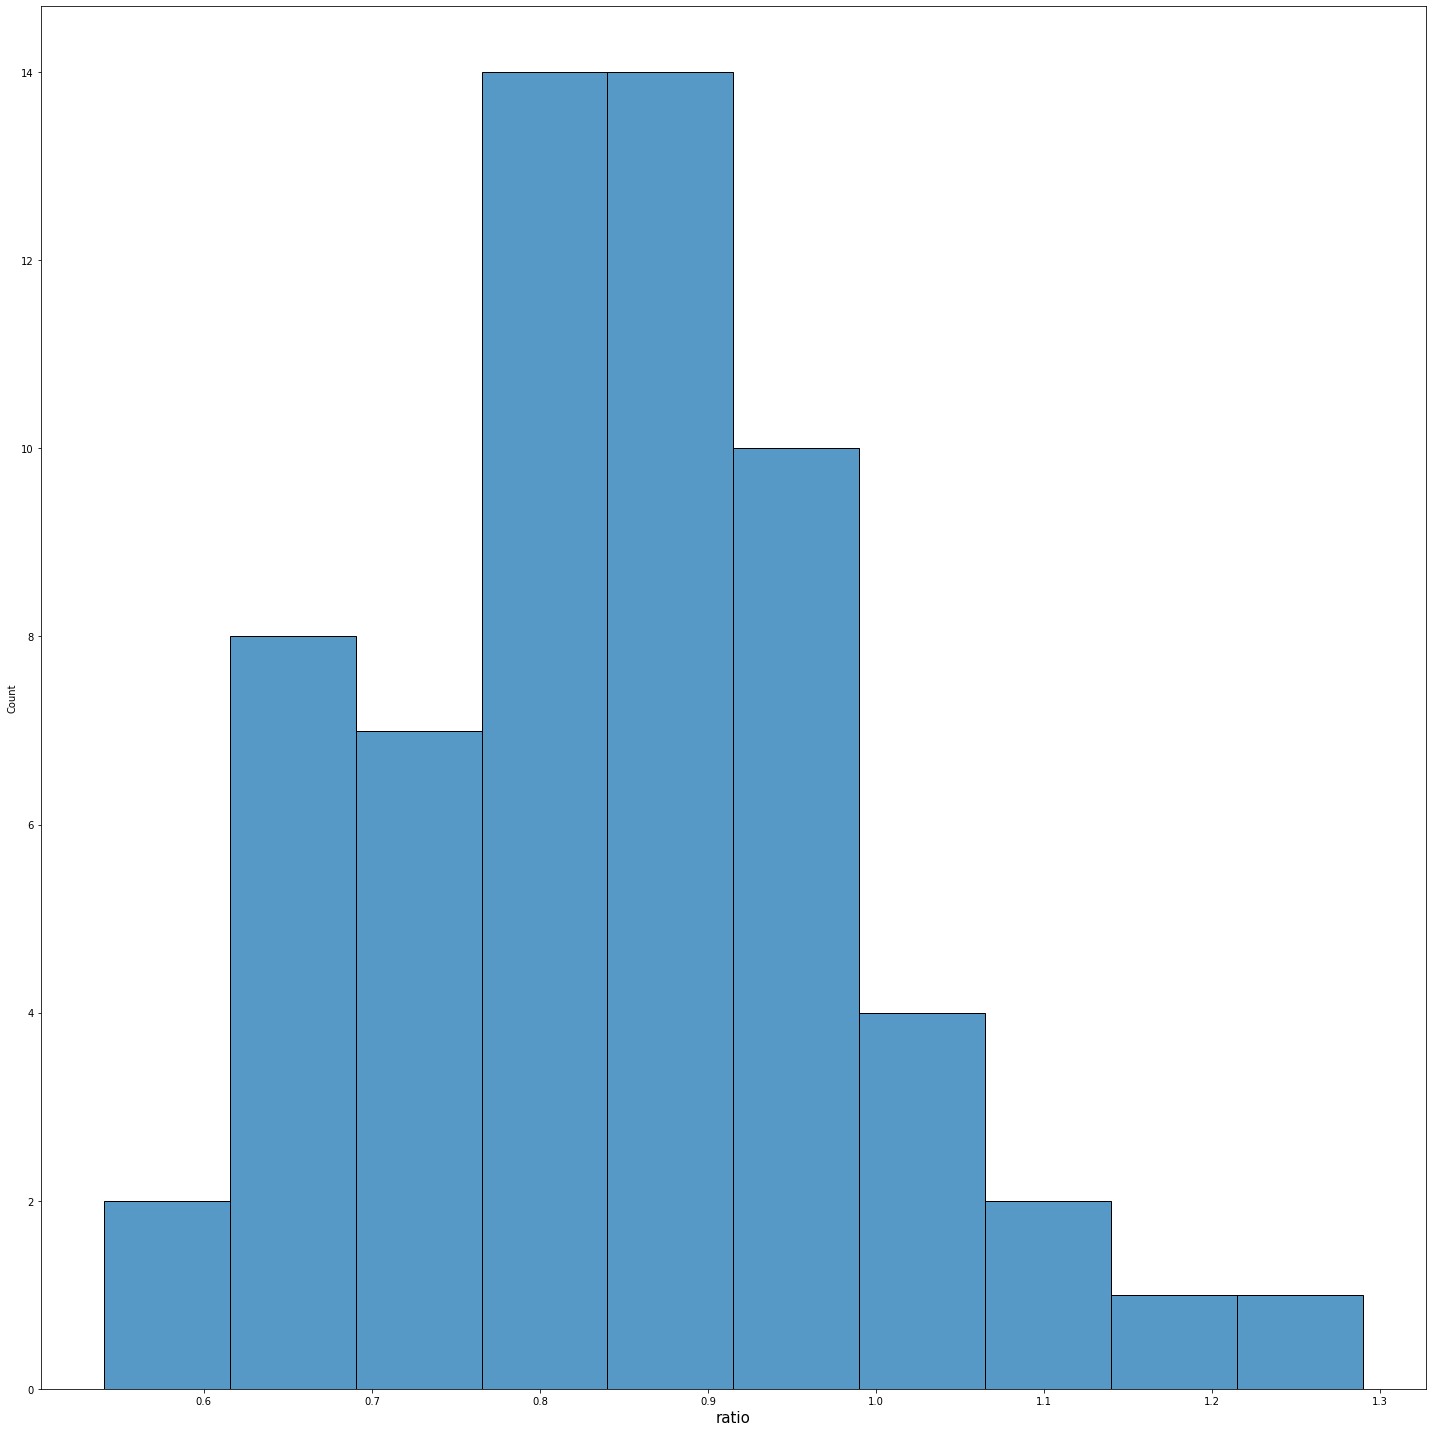

In [286]:
count_p = 7
p_ = p_vec[count_p]
B_split = df_speciesAbun['p6_r0']
# id_keep = np.where((df_speciesAbun_next['p6_r0'].values != thresh_zero) & \
#                    (df_speciesAbun_prev['p6_r0'].values != thresh_zero))[0]
denom_ = np.matmul(np.array(df_speciesMetab.T)[:, :], B_split[:])
output_trial = np.zeros((num_species))
for species_ in range(num_species):
#     print(f'species_ = {species_}')
    vals_ = ((metab_val[count_p, :]))
    total_ = (vals_ * (df_speciesMetab.iloc[species_, :] / denom_))
    total_[df_speciesMetab.iloc[species_, :] == 0] = 0
    output_trial[species_] = np.sum(total_)
# print(denom_)
# print(output_trial)
plt_ = sns.histplot(output_trial)
plt_.set_xlabel("ratio", size=15)
save_file = os.path.abspath(os.path.join(save_dir, "buffer", 
                                         f'trial_ratio.png'))
plt_.figure.tight_layout()
# plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
# plt_.figure.clear()

In [624]:
np.sum(metab_val[7, :] * np.array(df_speciesMetab.iloc[0, :]))
species_ = 0
count_p = 7
B = df_speciesAbun['p6_r0'].values
denom_ = np.matmul(np.array(df_speciesMetab.T).copy(), B)
# tmp = metab_val[count_p, :].copy() * (df_speciesMetab.iloc[species_, :].values / denom_)
tmp = (df_speciesMetab.iloc[species_, :].values / denom_)
# tmp[df_speciesMetab.iloc[species_, :].values == 0] = 0
# df_speciesMetab.iloc[:, 33]
# denom_[33]
# B[33]
np.sum(tmp)

# B_split = df_speciesAbun['p6_r0']
# # id_keep = np.where((df_speciesAbun_next['p6_r0'].values != thresh_zero) & \
# #                    (df_speciesAbun_prev['p6_r0'].values != thresh_zero))[0]
# denom_1 = np.matmul(np.array(df_speciesMetab.T)[:, :], B_split[:])
# print(denom_ - denom_1)
# metab_val[7, :].sum()
print(np.sum(denom_))
print(denom_[0])

32.38023272998727
0.01915383153141261


In [620]:
B_ = df_speciesAbun.copy()
B_[B_ <= thresh_zero] = 0
B_
df_ = pd.DataFrame(data={"B_sum" : B_.sum(axis=0).values})
df_.nunique(axis=0)
np.unique(np.ceil(df_["B_sum"].values), return_counts=True)

(array([1.]), array([18]))

In [614]:
df_

B_sum
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0

In [479]:
B0 = (1 / num_species) * np.ones((num_species))
num_iter = 200
count_p = 0
B_mat = np.zeros((num_species, num_iter))
for iter_ in range(num_iter):
#     print(f'iteration = {iter_}')
    if iter_ == 0:
        df_speciesAbun_tmp = pd.DataFrame(data={"sample" : B0})
    else:
        df_speciesAbun_tmp = pd.DataFrame(data={"sample" : B_mat[:, iter_ - 1]})
    B_mat[:, iter_] = dynamical_model(df_speciesAbun_tmp, metab_val[count_p, :], df_speciesMetab)

In [92]:
id_ = np.where(B_mat[:, num_iter - 1] <= 1e-20)[0]
B_mat[B_mat[:, num_iter - 1] <= 1e-20, num_iter - 1]
id_z = np.where(df_tmp.values <= 1e-8)[0]
df_tmp.values

array([3.22012609e-03, 2.81508144e-01, 2.19693628e-02, 4.61304276e-08,
       1.66412865e-05, 1.67119748e-05, 1.16373877e-07, 7.23003372e-04,
       1.75416956e-01, 6.91658922e-06, 1.36867184e-05, 1.28694882e-02,
       1.35488386e-04, 6.38989144e-03, 2.55148139e-05, 1.90334948e-01,
       4.66459693e-03, 9.18625208e-03, 3.13254288e-04, 1.79479727e-04,
       9.25066849e-04, 4.35165575e-02, 5.50732211e-02, 4.42017480e-02,
       6.30683011e-05, 1.95845819e-02, 4.49661223e-08, 1.00000000e-08,
       8.05797162e-08, 1.40207599e-04, 1.00000000e-08, 1.07127702e-03,
       2.02706730e-02, 6.00967824e-03, 2.51454180e-06, 1.79897993e-07,
       3.00236745e-04, 1.82412829e-07, 1.50724975e-03, 5.27537940e-04,
       3.35989636e-08, 1.78665059e-04, 7.35793428e-04, 1.55539143e-08,
       1.36034726e-06, 3.05594681e-02, 2.74154875e-08, 2.26570520e-08,
       1.61216093e-04, 8.66351322e-06, 9.74310774e-07, 3.21200134e-02,
       1.18094014e-05, 2.32283586e-06, 2.74454282e-03, 2.62579514e-02,
      

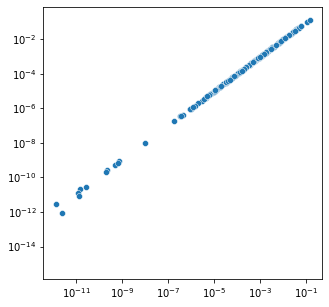

In [279]:
plt_ = sns.scatterplot(x=metab_val_1[count_p, :], y=metab_val[count_p, :])
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

In [281]:
len(metab_val[count_p, metab_val_1[count_p, :] == 0])

124

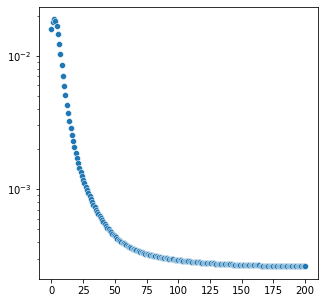

In [202]:
species_ = 0
plt_ = sns.scatterplot(x=range(num_iter + 1), y=np.hstack((B0[species_], B_mat[species_, :])))
plt_.set_yscale("log", base=10)

In [535]:
df_tmp = df_speciesAbun.iloc[:, list(np.arange(2, 6)) + \
                                 list(np.arange(2, 6) + 6) + list(np.arange(2, 6) + 12)].values
df_tmp = df_tmp.mean(axis=1)

In [540]:
id_z = np.where(df_tmp <= 1e-8)[0]
id_z

array([27, 30, 57])

In [557]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', "predictions", "leaveOneOut"))
for count_p in range(len(p_vec)):
    print(f'count_ = {count_p}')
    B0 = (1 / num_species) * np.ones((num_species))
    num_iter = 200
    B_mat = np.zeros((num_species, num_iter))
    for iter_ in range(num_iter):
#         print(f'iteration = {iter_}')
        if iter_ == 0:
            df_speciesAbun_tmp = pd.DataFrame(data={"sample" : B0})
        else:
            df_speciesAbun_tmp = pd.DataFrame(data={"sample" : B_mat[:, iter_ - 1]})
        B_mat[:, iter_] = dynamical_model(df_speciesAbun_tmp, metab_val[count_p, :].copy(), df_speciesMetab)

    df_tmp = df_speciesAbun.iloc[:, list(np.arange(2, 6)) + \
                                 list(np.arange(2, 6) + 6) + list(np.arange(2, 6) + 12)].copy()
    df_tmp = df_tmp.mean(axis=1)
    id_ = np.where(B_mat[:, num_iter - 1] <= 1e-30)[0]
    B_mat[id_, num_iter - 1] = 1e-30
#     id_z = np.where(df_tmp.values <= 1e-8)[0]
    
#     for z_ in id_z:
#         if B_mat[z_, num_iter - 1] <= 1e-30:
#             B_mat[z_, num_iter - 1] = 1e-30
    
    corr_pval = scipy.stats.pearsonr((df_tmp), (B_mat[:, num_iter - 1]))
    print(corr_pval)

    mpl.rcParams['figure.figsize'] = 5, 5
    plt_ = sns.scatterplot(x=np.log10(df_tmp), y=np.log10(B_mat[:, num_iter - 1]))
    plt_ = sns.kdeplot(x=np.log10(df_tmp), y=np.log10(B_mat[:, num_iter - 1]), \
                       fill=True, cmap="Reds", \
                       alpha=0.6, ax=plt_)
    plt_.plot([-9, 0], [-9, 0], c="black")
#     plt_.set_xscale("log", base=10)
#     plt_.set_yscale("log", base=10)
    plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
    plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)
    plt_.set_xlabel(f'log10 observed abundances averaged over\n 3 replicates (passages 3-6)')
    plt_.set_ylabel("log10 predicted abundances using the fitted model")
    
    title_ = f'fitted, p = {p_vec[count_p]}, '\
            f'corr = {np.round(corr_pval[0], 3)}, pval = ' + \
            '{:.3e}'.format(corr_pval[1])
    plt_.set_title(title_, \
                     size=10)
    # graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'scatterplot_predictedAbun_vs_observedAbun'
                                             f'_fitted_pid{count_p}_leaveOneOut.png'))
    plt_.figure.tight_layout()
    plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt_.figure.clear()
    
# null model
for count_p in range(len(p_vec)):
    print(f'count_ = {count_p}')
    B0 = (1 / num_species) * np.ones((num_species))
    num_iter = 200
    B_mat = np.zeros((num_species, num_iter))
    for iter_ in range(num_iter):
#         print(f'iteration = {iter_}')
        if iter_ == 0:
            df_speciesAbun_tmp = pd.DataFrame(data={"sample" : B0})
        else:
            df_speciesAbun_tmp = pd.DataFrame(data={"sample" : B_mat[:, iter_ - 1]})
        B_mat[:, iter_] = dynamical_model(df_speciesAbun_tmp, metab_val_null[count_p, :].copy(), df_speciesMetab)

    df_tmp = df_speciesAbun.iloc[:, list(np.arange(2, 6)) + \
                                 list(np.arange(2, 6) + 6) + list(np.arange(2, 6) + 12)].copy()
    df_tmp = df_tmp.mean(axis=1)
    id_ = np.where(B_mat[:, num_iter - 1] <= 1e-30)[0]
    B_mat[id_, num_iter - 1] = 1e-30
#     id_z = np.where(df_tmp.values <= 1e-8)[0]
    
#     for z_ in id_z:
#         if B_mat[z_, num_iter - 1] <= 1e-30:
#             B_mat[z_, num_iter - 1] = 1e-30
    
    corr_pval = scipy.stats.pearsonr((df_tmp), (B_mat[:, num_iter - 1]))
    print(corr_pval)

    mpl.rcParams['figure.figsize'] = 5, 5
    plt_ = sns.scatterplot(x=np.log10(df_tmp), y=np.log10(B_mat[:, num_iter - 1]))
    plt_ = sns.kdeplot(x=np.log10(df_tmp), y=np.log10(B_mat[:, num_iter - 1]), \
                       fill=True, cmap="Reds", \
                       alpha=0.6, ax=plt_)
    plt_.plot([-9, 0], [-9, 0], c="black")
#     plt_.set_xscale("log", base=10)
#     plt_.set_yscale("log", base=10)
    plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
    plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)
    plt_.set_xlabel(f'log10 observed abundances averaged over\n 3 replicates (passages 3-6)')
    plt_.set_ylabel("log10 predicted abundances using the null model")
    
    title_ = f'null, p = {p_vec[count_p]}, '\
            f'corr = {np.round(corr_pval[0], 3)}, pval = ' + \
            '{:.3e}'.format(corr_pval[1])
    plt_.set_title(title_, \
                     size=10)
    # graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'scatterplot_predictedAbun_vs_observedAbun'
                                             f'_null_pid{count_p}_leaveOneOut.png'))
    plt_.figure.tight_layout()
    plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt_.figure.clear()

count_ = 0
(0.6388321112383691, 1.762150701166365e-08)


/tmp/ipykernel_6952/3283697102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 1
(0.638831591674716, 1.7622123120125422e-08)


/tmp/ipykernel_6952/3283697102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 2
(0.6387779382271747, 1.768585625671216e-08)


/tmp/ipykernel_6952/3283697102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 3
(0.6440426264632528, 1.2368568368071232e-08)


/tmp/ipykernel_6952/3283697102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 4
(0.6583036675020156, 4.5315979865518115e-09)


/tmp/ipykernel_6952/3283697102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 5
(0.6650191743203466, 2.771706262029973e-09)


/tmp/ipykernel_6952/3283697102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 6
(0.6630428746057287, 3.207311702974304e-09)


/tmp/ipykernel_6952/3283697102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 7
(0.6488735294894126, 8.854480431223933e-09)


/tmp/ipykernel_6952/3283697102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 8
(0.6942238942622037, 2.800826273483538e-10)


/tmp/ipykernel_6952/3283697102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 9
(0.7111200572988794, 6.546127063839651e-11)


/tmp/ipykernel_6952/3283697102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 10
(0.7197517680551743, 2.991415592409839e-11)


/tmp/ipykernel_6952/3283697102.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 0
(0.3367672027766539, 0.006958913670650003)


/tmp/ipykernel_6952/3283697102.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 1
(0.3367674858890471, 0.006958863253875783)


/tmp/ipykernel_6952/3283697102.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 2
(0.3367957910512455, 0.006953824273112921)


/tmp/ipykernel_6952/3283697102.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 3
(0.33956621269915355, 0.006475826875399606)


/tmp/ipykernel_6952/3283697102.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 4
(0.3422465429569407, 0.0060410524134688615)


/tmp/ipykernel_6952/3283697102.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 5
(0.3448123206511515, 0.005649094794372088)


/tmp/ipykernel_6952/3283697102.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 6
(0.3518632432042642, 0.004684793384319391)


/tmp/ipykernel_6952/3283697102.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 7
(0.36169367196188995, 0.0035834761386927647)


/tmp/ipykernel_6952/3283697102.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 8
(0.37452829137326155, 0.002493786061818293)


/tmp/ipykernel_6952/3283697102.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 9
(0.38780264919084734, 0.0016875812286159524)


/tmp/ipykernel_6952/3283697102.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


count_ = 10
(0.3871766421036415, 0.0017195725996733714)


/tmp/ipykernel_6952/3283697102.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
/tmp/ipykernel_6952/3283697102.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)


<Figure size 360x360 with 0 Axes>

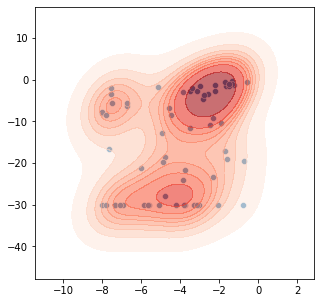

In [555]:
plt_ = sns.scatterplot(x=np.log10(df_tmp), y=np.log10(B_mat[:, num_iter - 1]))
plt_ = sns.kdeplot(x=np.log10(df_tmp), y=np.log10(B_mat[:, num_iter - 1]), \
                       fill=True, cmap="Reds", \
                       alpha=0.6, ax=plt_)
plt_.set_yticklabels(plt_.get_yticklabels(), size=10)
plt_.set_xticklabels(plt_.get_xticklabels(), size = 10)

In [562]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', "predictions", "leaveOneOut"))

metab_rank = np.zeros((len(p_vec), num_metabs))
metab_rank_null = metab_rank.copy()

metab_val = metab_rank.copy()
metab_val_null = metab_rank_null.copy()
for count_p in range(len(p_vec)):
    count_ = 0
    for rep_ in range(num_rep_nnls):
        for fold_ in range(nfold):
            metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
            metab_rank_null[count_p, :] += get_rank(coeff_null_train[rep_][fold_][count_p])
            
            metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
            metab_val_null[count_p, ] += coeff_null_train_2[rep_][fold_][count_p]
#             id_nnz = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
#             freq_tmp = np.zeros((1, num_metabs))
#             freq_tmp[0, id_nnz] = 1
#             metab_freq[count_p, :] += freq_tmp[0, :]
            
#             metab_val_null[count_p, :] += coeff_null_train[rep_][fold_][count_p]
            
            count_ += 1
metab_rank /= count_
metab_rank_null /= count_

metab_val /= count_
metab_val_null /= count_


count_p = 0
# x = metab_rank_null[count_p, :]
# y = metab_rank[count_p, :]
# metab_val_null[0, ] = R_i_0
for count_p in range(len(p_vec)):
    print(f'count_p = {count_p}')
    x = metab_val_null[count_p, :].copy()
    x[x == 0] = np.power(10, -np.ceil(-np.log10(np.min(x[x != 0]))) - 1)
    y = metab_val[count_p, :].copy()
    y[y == 0] = np.power(10, -np.ceil(-np.log10(np.min(y[y != 0]))) - 1)

    id_ = np.where(metab_val[count_p, :].copy() != 0)[0]

    metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]

#     x_rank = get_rank(x)
#     y_rank = get_rank(y)


    df_plot = pd.DataFrame()
    df_plot['metabs'] = metab_names
    df_plot['metabs_id_masterList'] = df_metabIds.iloc[:, 0].values
    df_plot['Ri_null'] = x
    df_plot['Ri_fit'] = y
    df_plot['rank_Ri_null'] = get_rank(-x)
    df_plot['rank_Ri_fit'] = get_rank(-y)
    
#     save_file = os.path.abspath(os.path.join(save_dir, 
#                                              f'metabs_unranked_p{p_vec[count_p]}_reps_{num_rep_nnls}.csv'))
#     df_plot.to_csv(save_file, index=False)

#     df_null = df_plot.sort_values('Ri_null', ascending=False)

#     save_file = os.path.abspath(os.path.join(save_dir, 
#                                              f'metabs_rank_by_RiNull_p{p_vec[count_p]}_reps_{num_rep_nnls}.csv'))
#     df_null.to_csv(save_file, index=False)

#     df_fit = df_plot.sort_values('Ri_fit', ascending=False)

#     save_file = os.path.abspath(os.path.join(save_dir, 
#                                              f'metabs_rank_by_RiFit_p{p_vec[count_p]}_reps_{num_rep_nnls}.csv'))
#     df_fit.to_csv(save_file, index=False)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metabs_unranked_p{p_vec[count_p]}_leaveOneOut.csv'))
    df_plot.to_csv(save_file, index=False)

    df_null = df_plot.sort_values('Ri_null', ascending=False)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metabs_rank_by_RiNull_p{p_vec[count_p]}_leaveOneOut.csv'))
    df_null.to_csv(save_file, index=False)

    df_fit = df_plot.sort_values('Ri_fit', ascending=False)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metabs_rank_by_RiFit_p{p_vec[count_p]}_leaveOneOut.csv'))
    df_fit.to_csv(save_file, index=False)
    
    metab_names_id = metab_names[id_]
    x = np.log10(x[id_])
    y = np.log10(y[id_])
    x_rank = 10**x
    y_rank = 10**y

    corr_pval = scipy.stats.spearmanr(x_rank, y_rank)
    print(corr_pval)
    print(scipy.stats.pearsonr(np.log10(x_rank), np.log10(y_rank)))
    corr_pval = scipy.stats.pearsonr(np.log10(x_rank), np.log10(y_rank))


    mpl.rcParams['figure.figsize'] = 20, 20
    # save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
    #                                         "prediction_model_Bsplit", "higher_p"))

    graph_ = sns.scatterplot(x=x_rank, y=y_rank)
    graph_.set_xlabel("null Ri", size = 20*2)
    graph_.set_ylabel("fit Ri", size = 20*2)

    for i in range(len(x)):
        graph_.text(x_rank[i], y_rank[i], metab_names_id[i], size=10)
    graph_.plot([1e-11, 1e-1], [1e-11, 1e-1], c="red")
    graph_.set_yscale("log", base=10)
    graph_.set_xscale("log", base=10)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)
    title_ = f'#nnz metabs.  = {len(id_)}, p = {p_vec[count_p]}, '\
            f'corr = {np.round(corr_pval[0], 3)}, pval = ' + \
            '{:.3e}'.format(corr_pval[1])
    graph_.set_title(title_, \
                     size=20*2)
    # graph_.legend(fontsize=20, title="p", title_fontsize=20)

#     save_file = os.path.abspath(os.path.join(save_dir, 
#                                              f'scatterplot_fitRi_vs_nullRi_pid{count_p}_reps_{num_rep_nnls}.png'))
    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'scatterplot_fitRi_vs_nullRi_pid{count_p}_leaveOneOut.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()

(0.6388321112383691, 1.762150701166365e-08)


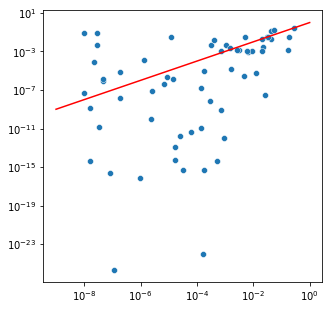

In [530]:
df_tmp = df_speciesAbun.iloc[:, list(np.arange(2, 6)) + \
                             list(np.arange(2, 6) + 6) + list(np.arange(2, 6) + 12)]
df_tmp = df_tmp.mean(axis=1)
id_ = np.where(B_mat[:, num_iter - 1] >= 1e-30)[0]
print(scipy.stats.pearsonr((df_tmp.values), (B_mat[:, num_iter - 1])))

mpl.rcParams['figure.figsize'] = 5, 5
plt_ = sns.scatterplot(x=(df_tmp.values[id_]), y=(B_mat[id_, num_iter - 1]))
# plt_.plot([0, 62], [0, 62], c="red")
plt_.plot([1e-9, 1], [1e-9, 1], c="red")
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

ax.set_yscale("log", base=10)
# graph_.axhline(0.00, color="black")
ax.set_ylabel("error", size=20)
ax.set_xlabel("p", size=20)
ax.set_xticklabels(ax.get_xticklabels(), size=15)
ax.set_yticklabels(ax.get_yticklabels(), size=15)
ax.set_title(species_, size=20)
ax.legend(fontsize=20, title="model", title_fontsize=20)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', "predictions", "leaveOneOut"))
# save_file = os.path.abspath(os.path.join(save_dir, f'predictionError_vs_p_reps_{num_rep_nnls}.png'))
species_ = species_.replace("/", "_")
save_file = os.path.abspath(os.path.join(save_dir, \
                                         f'predictionError_vs_p_leaveOneOut_species_{species_}.png'))
ax.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
ax.figure.clear()

In [484]:
len(id_)

62

In [255]:
B0 = (1 / num_species) * np.ones((num_species))
num_iter = 200
count_p = 0
B_mat = np.zeros((num_species, num_iter))
for iter_ in range(num_iter):
    print(f'iteration = {iter_}')
    if iter_ == 0:
        df_speciesAbun_tmp = pd.DataFrame(data={"sample" : B0})
    else:
        df_speciesAbun_tmp = pd.DataFrame(data={"sample" : B_mat[:, iter_ - 1]})
    B_mat[:, iter_] = dynamical_model(df_speciesAbun_tmp, metab_val_null[count_p, :], df_speciesMetab)

iteration = 0
iteration = 1
iteration = 2
iteration = 3
iteration = 4
iteration = 5
iteration = 6
iteration = 7
iteration = 8
iteration = 9
iteration = 10
iteration = 11
iteration = 12
iteration = 13
iteration = 14
iteration = 15
iteration = 16
iteration = 17
iteration = 18
iteration = 19
iteration = 20
iteration = 21
iteration = 22
iteration = 23
iteration = 24
iteration = 25
iteration = 26
iteration = 27
iteration = 28
iteration = 29
iteration = 30
iteration = 31
iteration = 32
iteration = 33
iteration = 34
iteration = 35
iteration = 36
iteration = 37
iteration = 38
iteration = 39
iteration = 40
iteration = 41
iteration = 42
iteration = 43
iteration = 44
iteration = 45
iteration = 46
iteration = 47
iteration = 48
iteration = 49
iteration = 50
iteration = 51
iteration = 52
iteration = 53
iteration = 54
iteration = 55
iteration = 56
iteration = 57
iteration = 58
iteration = 59
iteration = 60
iteration = 61
iteration = 62
iteration = 63
iteration = 64
iteration = 65
iteration = 66
itera

(0.36991873229567196, 0.012381360037340085)


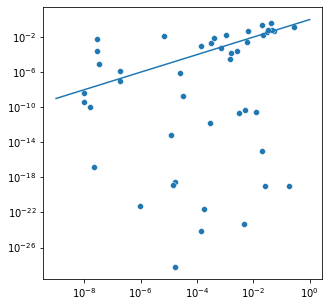

In [258]:
df_tmp = df_speciesAbun.iloc[:, list(np.arange(2, 6)) + \
                             list(np.arange(2, 6) + 6) + list(np.arange(2, 6) + 12)]
df_tmp = df_tmp.mean(axis=1)
id_ = np.where(B_mat[:, num_iter - 1] >= 1e-30)[0]
print(scipy.stats.pearsonr((df_tmp.values[id_]), (B_mat[id_, num_iter - 1])))

mpl.rcParams['figure.figsize'] = 5, 5
plt_ = sns.scatterplot(x=df_tmp.values[id_], y=B_mat[id_, num_iter - 1])
plt_.plot([1e-9, 1], [1e-9, 1])
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

# Get data

In [22]:
# directory with all data
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'jin_pollard'))

In [208]:
# species-metabolite consumption matrix, c_species^metabolite
file_speciesProd = os.path.join(data_dir, 
                                "species_metabolite_production_matrix.csv")
thresh_zero_prod = 0
df_speciesProd = pd.read_csv(file_speciesProd, sep=",", header=None)
df_speciesProd[df_speciesProd == 0] = thresh_zero_prod
# num_species, num_metabs = df_speciesProd.shape

In [ ]:
# species-metabolite consumption matrix, c_species^metabolite
file_speciesMetab = os.path.join(data_dir, 
                                "species_metabolite_consumption_matrix.csv")
thresh_zero_metab = 0
df_speciesMetab = pd.read_csv(file_speciesMetab, sep=",", header=None)
df_speciesMetab[df_speciesMetab == 0] = thresh_zero_metab
num_species, num_metabs = df_speciesMetab.shape

In [24]:
# species abundances for all passages and bioreplicates
num_passages = 6
num_bioRep = 3
file_speciesAbun = os.path.join(data_dir, 
                                "species_abundances.csv")
df_speciesAbun = pd.read_csv(file_speciesAbun, sep=",", header=None)
df_speciesAbun.columns = create_abundance_header_new(num_bioRep=num_bioRep, num_passages=num_passages)
df_speciesAbun_raw = df_speciesAbun.copy()
thresh_zero = 1e-8
df_speciesAbun[df_speciesAbun == 0] = thresh_zero
df_speciesAbun_T = df_speciesAbun.copy()
df_speciesAbun_T = df_speciesAbun_T.transpose()

In [25]:
# species abundances for all passages and bioreplicates
num_passages = 6
num_bioRep = 3
file_speciesAbun_super_agar = os.path.join(data_dir, 
                                "species_abundances_plain_agar_supernatant.csv")
df_speciesAbun_super_agar = pd.read_csv(file_speciesAbun_super_agar, sep=",", header=None)
df_speciesAbun_super_agar.columns = \
    create_abundance_header_new(num_bioRep=num_bioRep, num_passages=num_passages)
df_speciesAbun_super_agar_raw = df_speciesAbun_super_agar.copy()
thresh_zero = 1e-8
df_speciesAbun_super_agar[df_speciesAbun_super_agar == 0] = thresh_zero
df_speciesAbun_super_agar_T = df_speciesAbun_super_agar.copy()
df_speciesAbun_super_agar_T = df_speciesAbun_super_agar_T.transpose()

SignificanceResult(statistic=0.7735208443503792, pvalue=1.877235066355581e-226)

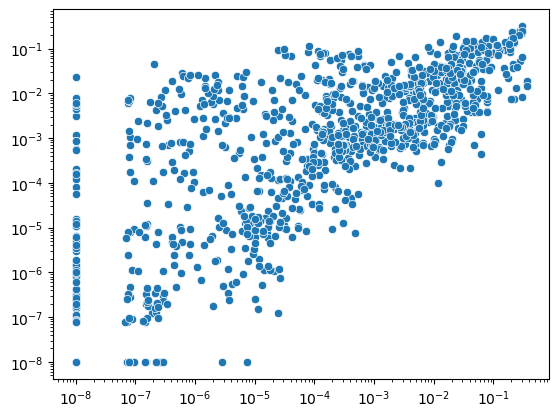

In [26]:
y = np.array(df_speciesAbun_super_agar).flatten()
x = np.array(df_speciesAbun).flatten()
plt_ = sns.scatterplot(x=x, y=y)
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)
scipy.stats.spearmanr(x, y)

In [27]:

file_speciesAbun = os.path.join(data_dir, 
                                "species_abundances_inoculum.csv")
df_speciesAbun_inoc = pd.read_csv(file_speciesAbun, sep=",", header=None)
df_speciesAbun_inoc.columns = ["inoculum"]
df_speciesAbun_inoc[df_speciesAbun_inoc == 0] = thresh_zero

In [28]:
# consumption, abundance product. Sum of species-metabolite consumption matrix, c_species^metabolite, for each 
# metabolite for each passage (and replicate) across all the species
# df_cons_abun_prod = df_speciesAbun_T.dot(df_speciesMetab)
df_cons_abun_prod = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                           df_speciesAbun=df_speciesAbun)
df_cons_abun_prod_avg = df_cons_abun_prod.mean(axis=0)
id_metabs_sorted = np.argsort(df_cons_abun_prod_avg)[::-1]

In [29]:
# metabolite names and indices of the selected metabolites (metabolites used for the 
# species-metabolite consumption matrix, c_species^metabolite)
file_metabNames = os.path.join(data_dir, 
                                "metabolites_list_FC.csv")
df_metabNames = pd.read_csv(file_metabNames, sep=",", header=0)

file_metabIds = os.path.join(data_dir, 
                                "metabolite_indices.csv")
df_metabIds = pd.read_csv(file_metabIds, sep=",", header=None)

In [30]:
df_metabNames.iloc[:, 1]

0                       GALACTOSAMINE
1          2-HYDROXYPHENYLACETIC ACID
2        ALPHA-HYDROXYISOBUTYRIC ACID
3              N-METHYL-ASPARTIC ACID
4      2-AMINO-2-METHYLPROPANOIC ACID
                    ...              
429                           URIDINE
430           URIDINE-5-MONOPHOSPHATE
431                            VALINE
432                        XANTHOSINE
433       XANTHOSINE 5'-MONOPHOSPHATE
Name: met_name, Length: 434, dtype: object

In [31]:
metabs_ = df_metabNames.iloc[df_metabIds.iloc[:, 0], 1].values
df_tmp = pd.DataFrame(data={"names" : metabs_[id_metabs_sorted], "pi" : df_cons_abun_prod_avg})

In [32]:
# species names and indices of the selected species (metabolites used for the 
# species abundance matrix, B_species_k)
file_speciesNames = os.path.join(data_dir, 
                                "species_list.csv")
df_speciesNames = pd.read_csv(file_speciesNames, sep=",", header=0)

file_speciesIds = os.path.join(data_dir, 
                                "species_indices.csv")
df_speciesIds = pd.read_csv(file_speciesIds, sep=",", header=None)

In [33]:
len(df_speciesIds.iloc[:, 0].values)

63

In [34]:
df_speciesIds.iloc[:, 0].values
df_speciesNames.iloc[:, 0]

0            Acidaminococcus fermentans DSMZ 20731
1          Acidaminococcus intestini D21 BEI HM-81
2           Acidaminococcus sp. HPA0509 BEI HM-853
3             Akkermansia muciniphila ATCC BAA-835
4      Anaerococcus lactolyticus CC31C BEI HM-1034
                          ...                     
174    Streptococcus thermophilus LMD-9 ATCC 19258
175           Subdoligranulum variabile DSMZ 15176
176                    Tyzzerella nexilis DSM 1787
177      Varibaculum cambriense AB12_3 BEI HM-1190
178             Veillonella sp. HPA0037 BEI HM-850
Name: species_name, Length: 179, dtype: object

In [35]:
species_names = ["Acidaminococcus", "Anaerostipes", "Anaerotruncus", "Bacteroides", "Bifidobacterium", \
                "Blautia", "Catenibacterium", \
                "Clostridium", "Collinsella", "Coprococcus", "Desulfovibrio", "Dorea", \
                "Eggerthella", "Eubacterium", "Granulicatella", "Holdemanella", \
                "Holdemania", "Hungatella", "Intestinibacter", "Lactobacillus", \
                "Lactococcus", "Marvinbryantia", "Mitsuokella", "Parabacteroides", \
                "Peptostreptococcus", "Ruminococcus", "Slackia", "Streptococcus", \
                "Tyzzerella"]
species_names = df_speciesNames.iloc[df_speciesIds.iloc[:, 0].values - 1, 0].values
strains = df_speciesNames.iloc[df_speciesIds.iloc[:, 0].values - 1, 0].values

species_names_to_strainID = {}
for species_ in species_names:
    species_names_to_strainID[species_] = []
    for row_ in range(len(strains)):
        if species_ in strains[row_]:
            species_names_to_strainID[species_].append(row_)

In [36]:
# create one matrix of c_i^alpha / (sum_beta c_i^beta B_beta(k)) (species X metabolites) 
# for each passage and bioreplicate
# sample_names = create_abundance_header()
# mat_cons_abun_list = {}
# tmp_ones = np.ones((num_species, 1))
# for sample_ in sample_names:
#     df_denom = df_cons_abun_prod.loc[sample_, :]
#     tmp_mat = np.array(df_denom).reshape((1, num_metabs))
#     mat_denom = np.matmul(tmp_ones, tmp_mat)
#     mat_cons_abun_list[sample_] = np.divide(np.array(df_speciesMetab.copy()), mat_denom)
    
sample_names, mat_cons_abun_list = \
    compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod, 
                                          df_speciesMetab=df_speciesMetab, 
                                          num_passages=6, num_bioRep=3)

In [37]:
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
reps_ = np.array(['r0', 'r1', 'r2'])
df_speciesAbun_ratio = pd.DataFrame()
df_speciesAbun_ratio_corr = pd.DataFrame()
df_speciesAbun_new = pd.DataFrame()
df_speciesAbun_prev = pd.DataFrame()
df_speciesAbun_next = pd.DataFrame()
df_speciesAbun_split = pd.DataFrame()
count_ = 0
brep_vec = list(range(num_bioRep))
for rep_ in reps_:
    for pass_ in range(1, len(passages_)):
        col_1 = passages_[pass_ - 1] + "_" + rep_
        col_2 = passages_[pass_] + "_" + rep_
        
        df_speciesAbun_prev[col_2] = df_speciesAbun[col_1].values
        df_speciesAbun_next[col_2] = df_speciesAbun[col_2].values
        
        array_1 = np.array(df_speciesAbun[col_2].values / df_speciesAbun[col_1].values)
        array_2 = np.array(df_speciesAbun[col_2].values)
        array_3 = np.array(df_speciesAbun[col_1].values)
        
        df_speciesAbun_new[col_1] = df_speciesAbun[col_1].values
        df_speciesAbun_new[col_2] = df_speciesAbun[col_2].values
        df_speciesAbun_ratio[col_2] = array_1.copy()
        df_speciesAbun_ratio_corr[col_2] = array_1.copy()
        id_ = np.where((array_3 == thresh_zero) & (array_2 == thresh_zero))[0]
#         id_ = np.where((array_2 == thresh_zero))[0]
#         id_ = np.where(array_1 == 1)[0]
        
        if len(id_) > 0:
            df_speciesAbun_ratio.iloc[id_, count_] = -1
            rep_alt = list(set(reps_) - set([rep_]))
            ratio_vec = []
            for id_tmp in id_:
                abun_alt_ratio = []
                for rep__ in rep_alt:
                    col_1_ = passages_[pass_ - 1] + "_" + rep__
                    col_2_ = passages_[pass_] + "_" + rep__
                    val_1 = df_speciesAbun[col_1_].values[id_tmp]
                    val_2 = df_speciesAbun[col_2_].values[id_tmp]
                    if (val_1 != thresh_zero) | (val_2 != thresh_zero):
                        abun_alt_ratio.append(val_2 / val_1)
                if len(abun_alt_ratio) != 0:
                    df_speciesAbun_ratio_corr.iloc[id_tmp, count_] = \
                        np.exp(np.mean(np.log10(np.array(abun_alt_ratio))))
                else:
                    df_speciesAbun_ratio_corr.iloc[id_tmp, count_] = -1
                
        count_ += 1

In [38]:
df_speciesAbun_ratio_corr_2 = df_speciesAbun_ratio_corr.copy()
df_speciesAbun_ratio_corr_2[df_speciesAbun_ratio_corr_2 == -1] = 1

In [39]:
# previous and next abundances for supernatant agar
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
reps_ = np.array(['r0', 'r1', 'r2'])
df_speciesAbun_super_agar_ratio = pd.DataFrame()
df_speciesAbun_super_agar_ratio_corr = pd.DataFrame()
df_speciesAbun_super_agar_new = pd.DataFrame()
df_speciesAbun_super_agar_prev = pd.DataFrame()
df_speciesAbun_super_agar_next = pd.DataFrame()
df_speciesAbun_super_agar_split = pd.DataFrame()
count_ = 0
brep_vec = list(range(num_bioRep))
for rep_ in reps_:
    for pass_ in range(1, len(passages_)):
        col_1 = passages_[pass_ - 1] + "_" + rep_
        col_2 = passages_[pass_] + "_" + rep_
        
        df_speciesAbun_super_agar_prev[col_2] = df_speciesAbun_super_agar[col_1].values
        df_speciesAbun_super_agar_next[col_2] = df_speciesAbun_super_agar[col_2].values
        
        array_1 = np.array(df_speciesAbun_super_agar[col_2].values / df_speciesAbun_super_agar[col_1].values)
        array_2 = np.array(df_speciesAbun_super_agar[col_2].values)
        array_3 = np.array(df_speciesAbun_super_agar[col_1].values)
        
        df_speciesAbun_super_agar_new[col_1] = df_speciesAbun_super_agar[col_1].values
        df_speciesAbun_super_agar_new[col_2] = df_speciesAbun_super_agar[col_2].values
        df_speciesAbun_super_agar_ratio[col_2] = array_1.copy()
        df_speciesAbun_super_agar_ratio_corr[col_2] = array_1.copy()
        id_ = np.where((array_3 == thresh_zero) & (array_2 == thresh_zero))[0]
#         id_ = np.where((array_2 == thresh_zero))[0]
#         id_ = np.where(array_1 == 1)[0]
        
        if len(id_) > 0:
            df_speciesAbun_super_agar_ratio.iloc[id_, count_] = -1
            rep_alt = list(set(reps_) - set([rep_]))
            ratio_vec = []
            for id_tmp in id_:
                Abun_super_agar_alt_ratio = []
                for rep__ in rep_alt:
                    col_1_ = passages_[pass_ - 1] + "_" + rep__
                    col_2_ = passages_[pass_] + "_" + rep__
                    val_1 = df_speciesAbun_super_agar[col_1_].values[id_tmp]
                    val_2 = df_speciesAbun_super_agar[col_2_].values[id_tmp]
                    if (val_1 != thresh_zero) | (val_2 != thresh_zero):
                        Abun_super_agar_alt_ratio.append(val_2 / val_1)
                if len(Abun_super_agar_alt_ratio) != 0:
                    df_speciesAbun_super_agar_ratio_corr.iloc[id_tmp, count_] = \
                        np.exp(np.mean(np.log10(np.array(Abun_super_agar_alt_ratio))))
                else:
                    df_speciesAbun_super_agar_ratio_corr.iloc[id_tmp, count_] = -1
                
        count_ += 1

In [36]:
p_ = 0.01
df_speciesAbun_split = geometric_avg(df_speciesAbun_prev, df_speciesAbun_next, p=p_)
df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                           df_speciesAbun=df_speciesAbun_split)
df_cons_abun_prod_avg_split = df_cons_abun_prod_split.mean(axis=0)

In [37]:
df_cons_abun_prod_split.shape

(15, 292)

In [38]:
sample_names_split, mat_cons_abun_split_list = \
    compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_split, 
                                          df_speciesMetab=df_speciesMetab, 
                                          num_passages=6, num_bioRep=3, 
                                          sample_names=list(df_speciesAbun_split.columns.values))

In [39]:
list(df_speciesAbun_split.columns.values)
mat_cons_abun_split_list['p2_r0'].shape
len(np.where(np.array(df_speciesAbun_ratio) < 1)[0])

611

In [363]:
mpl.rcParams['figure.figsize'] = 5, 5
num_per_rep = int(df_speciesAbun_ratio.shape[1] / num_bioRep)
for species_ in range(num_species):
    x_id = np.arange(df_speciesAbun_ratio.shape[1])
    x = np.arange(2, num_per_rep + 2)
    x = np.concatenate((x, x, x))
    y = np.array(df_speciesAbun_ratio.iloc[species_, :])
    rep_ = ['r0'] * num_per_rep + ['r1'] * num_per_rep + ['r2'] * num_per_rep
    rep_ = np.array(rep_)
    
    id_ = np.where(y != -1)[0]
    if len(id_) > 0:
        y = y[id_]
        x = x[id_]
        rep_ = rep_[id_]
    
    df_plot = pd.DataFrame(data={"passage" : x, "abundance ratio" : y, "bioReplicate" : rep_})
    
    graph_ = sns.scatterplot(data=df_plot, x="passage", y="abundance ratio", hue="bioReplicate")
    graph_.axhline(1.00, color="black")
    graph_.set_yscale("log", base=10)
    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 'abundance_ratio_plots'))
    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'abundance_ratio_across_reps_species{species_}_new.png'))
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()
    plt.close()

In [356]:
num_per_rep = int(df_speciesAbun_new.shape[1] / num_bioRep)
for species_ in range(num_species):
    x_id = np.arange(num_per_rep)
    x = np.arange(2, num_per_rep + 2)
    x = np.concatenate((x, x, x))
#     y = np.array(df_speciesAbun_ratio.iloc[species_, :])
    y = np.array(df_speciesAbun_new.iloc[species_, :])
    rep_ = ['r0'] * num_per_rep + ['r1'] * num_per_rep + ['r2'] * num_per_rep
    rep_ = np.array(rep_)
    
    id_ = np.where(y != -1)[0]

    if len(id_) > 0:
        y = np.log10(y[id_])
        x = np.log10(x[id_])
        rep_ = rep_[id_]
        
        df_output = pd.DataFrame(data={"r0" : y[x_id], "r1" : y[x_id + num_per_rep], 
                                       "r2" : y[x_id + 2 * num_per_rep]})
        g_plt = sns.PairGrid(df_output)
        g_plt.map(sns.scatterplot)
        g_plt.map_lower(corrfunc)

        save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                                'bioreplicate_abundance_correlation'))
        save_file = os.path.abspath(os.path.join(save_dir, 
                                                 f'abundance_repsCorr_species{species_}.png'))
        g_plt.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
        g_plt.figure.clear()
        plt.close()

In [357]:
num_per_rep = int(df_speciesAbun_ratio.shape[1] / num_bioRep)
for species_ in range(num_species):
    x_id = np.arange(num_per_rep)
    x = np.arange(2, num_per_rep + 2)
    x = np.concatenate((x, x, x))
    y = np.array(df_speciesAbun_ratio.iloc[species_, :])
#     y = np.array(df_speciesAbun_new.iloc[species_, :])
    rep_ = ['r0'] * num_per_rep + ['r1'] * num_per_rep + ['r2'] * num_per_rep
    rep_ = np.array(rep_)
    
    id_ = np.where(y == -1)[0]

    if len(id_) == 0:
        y = np.log10(y)
        
        df_output = pd.DataFrame(data={"r0" : y[x_id], "r1" : y[x_id + num_per_rep], 
                                       "r2" : y[x_id + 2 * num_per_rep]})
        g_plt = sns.PairGrid(df_output)
        g_plt.map(sns.scatterplot)
        g_plt.map_lower(corrfunc)

        save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                                'bioreplicate_abundanceRatio_correlation'))
        save_file = os.path.abspath(os.path.join(save_dir, 
                                                 f'abundanceRatio_repsCorr_species{species_}.png'))
        g_plt.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
        g_plt.figure.clear()
        plt.close()

In [503]:
# train nnls model when R_i is estimated for all the metabolites using the true order of species 
# abundances with leave 10 species out
seed_ = 7363
np.random.seed(seed_)
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
num_bioRep = 3
num_rep_nnls = 10

nfold = 15
num_perFold = np.floor(len(species_names) / nfold)

coeff_train = {}
output_test = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls))
output_train = output_test.copy()
test_strain_id_all = {}

for rep_ in range(num_rep_nnls):
    print(f'repeat loop # = {rep_}')
    coeff_train[rep_] = {}
#     output_test[rep_] = {}
    
    passages_ = np.random.permutation(passages_)
    folds_id = np.arange(len(species_names))
    folds_id = np.random.permutation(folds_id)
    species_perFold = {}
    count_ = 0
    for fold_ in range(nfold):
        species_perFold[fold_] = {}
        if fold_ != nfold - 1:
            species_perFold[fold_]["test"] = \
                list(folds_id[np.arange(count_, count_ + num_perFold).astype('int')])

        else:
            species_perFold[fold_]["test"] = \
                list(folds_id[count_.astype("int"):])
        species_perFold[fold_]["train"] = \
            list(set(range(len(species_names))).difference(species_perFold[fold_]["test"]))
        count_ += num_perFold
    
    test_strain_id_all[rep_] = {}
    for fold_ in range(nfold):
        train_strain_id = []
        for species_ in species_perFold[fold_]["train"]:
            train_strain_id += species_names_to_strainID[species_names[species_]]
        test_strain_id = []
        for species_ in species_perFold[fold_]["test"]:
            test_strain_id += species_names_to_strainID[species_names[species_]]
        test_strain_id_all[rep_][fold_] = test_strain_id
            
        passages_train = passages_
        count_ = 0
        id_all = []
        for sample_ in sample_names_split:
            A_train_sample = mat_cons_abun_split_list[sample_][train_strain_id, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
            id_keep = np.where(tmp != -1)[0]
            id_all += list(np.array(train_strain_id)[id_keep])
            tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))       
        b_train = np.ones((A_train.shape[0]))
        coeff_train[rep_][fold_] = nnls(A_train, b_train)
        output_train[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_] = \
            
        
            #     test data
        passages_test = passages_train
        count_ = 0
        test_id_tmp = []
        for sample_ in sample_names_split:
            pass_ = int(sample_.split("_")[0][1])
            brep_ = int(sample_.split("_")[1][1])
            A_test_sample = mat_cons_abun_split_list[sample_][test_strain_id, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio.iloc[test_strain_id, sample_id])
            id_keep = np.where(tmp != -1)[0]
            tmp = np.array(tmp**(-p_)).reshape((len(test_strain_id), 1))
            tmp = np.matmul(tmp, np.ones((1, A_test_sample.shape[1])))
            A_test_sample = np.multiply(A_test_sample, tmp)
            A_test_sample = A_test_sample[id_keep, :]
            
            output_tmp = np.matmul(A_test_sample, coeff_train[rep_][fold_][0])
            output_test[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_] = output_tmp
            
#             test_id_tmp += list(np.array(test_strain_id)[id_keep])
#             if count_ == 0:
#                 A_test = A_test_sample
#                 count_ += 1
#             else:
#                 A_test = np.vstack((A_test, A_test_sample)) 
#         output_test[]
#         output_test[rep_][fold_] = np.dot(A_test, coeff_train[rep_][fold_][0])
    

repeat loop # = 0


/tmp/ipykernel_57573/4269337225.py:56: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
/tmp/ipykernel_57573/4269337225.py:79: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_)).reshape((len(test_strain_id), 1))


repeat loop # = 1
repeat loop # = 2
repeat loop # = 3
repeat loop # = 4
repeat loop # = 5
repeat loop # = 6
repeat loop # = 7
repeat loop # = 8
repeat loop # = 9


In [685]:
p_vec = 10**np.linspace(-2, np.log10(0.2), 6)
p_vec = np.round(p_vec, 2)
p_lower = 10**np.array([-8, -6, -4]).astype(np.float64)
p_upper = 10**np.array([np.log10(0.4), np.log10(0.6)])
p_vec = np.concatenate((p_lower, p_vec, p_upper))
print(*p_vec)

1e-08 1e-06 0.0001 0.01 0.02 0.03 0.06 0.11 0.2 0.4 0.6


In [421]:
nfold = len(species_names)
num_perFold = np.floor((len(species_names) + 1) / nfold)
nfold

63

In [82]:
# train nnls model when R_i is estimated for all the metabolites using the true order of species 
# abundances with leave 10 species out for different values of p_ (for B_split)
seed_ = 7363
np.random.seed(seed_)
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
num_bioRep = 3
num_rep_nnls = 1
p_vec = 10**np.linspace(-2, np.log10(0.2), 6)
p_vec = np.round(p_vec, 2)
p_lower = 10**np.array([-8, -6, -4]).astype(np.float64)
p_upper = 10**np.array([np.log10(0.4), np.log10(0.6)])
p_vec = np.concatenate((p_lower, p_vec, p_upper))
p_vec = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])

# nfold = 15
# num_perFold = np.floor(len(species_names) / nfold)
nfold = len(species_names)
num_perFold = np.floor((len(species_names) + 1) / nfold)

coeff_train = {}
coeff_null_train = {}
coeff_null_train_2 = {}
output_test = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
output_train = output_test.copy()
output_observed = output_test.copy()
output_null_train = output_test.copy()
output_null_train_2 = output_null_train.copy()
test_strain_id_all = {}
output_null_test = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
output_null_test_2 = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
train_id_all_dict = {}

for rep_ in range(num_rep_nnls):
    print(f'repeat loop # = {rep_}')
    coeff_train[rep_] = {}
    coeff_null_train[rep_] = {}
    coeff_null_train_2[rep_] = {}
#     output_test[rep_] = {}
    train_id_all_dict[rep_] = {}
    
    passages_ = np.random.permutation(passages_)
    folds_id = np.arange(len(species_names))
    folds_id = np.random.permutation(folds_id)
    species_perFold = {}
    count_ = 0
    for fold_ in range(nfold):
        species_perFold[fold_] = {}
        if fold_ != nfold - 1:
            species_perFold[fold_]["test"] = \
                list(folds_id[np.arange(count_, count_ + num_perFold).astype('int')])

        else:
            species_perFold[fold_]["test"] = \
                list(folds_id[count_.astype("int"):])
        species_perFold[fold_]["train"] = \
            list(set(range(len(species_names))).difference(species_perFold[fold_]["test"]))
        count_ += num_perFold
    
    test_strain_id_all[rep_] = {}
    for fold_ in range(nfold):
        coeff_train[rep_][fold_] = {}
        coeff_null_train[rep_][fold_] = {}
        coeff_null_train_2[rep_][fold_] = {}
        train_strain_id = []
        for species_ in species_perFold[fold_]["train"]:
            train_strain_id += species_names_to_strainID[species_names[species_]]
        train_id_all_dict[rep_][fold_] = train_strain_id
        test_strain_id = []
        for species_ in species_perFold[fold_]["test"]:
            test_strain_id += species_names_to_strainID[species_names[species_]]
        test_strain_id_all[rep_][fold_] = test_strain_id
        
        count_p = -1
        for p_ in p_vec:
            count_p += 1
            df_speciesAbun_split = geometric_avg(df_speciesAbun_prev, df_speciesAbun_next, p=p_)
            df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                                       df_speciesAbun=df_speciesAbun_split)
            df_cons_abun_prod_avg_split = df_cons_abun_prod_split.mean(axis=0)
            sample_names_split, mat_cons_abun_split_list = \
                compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_split, 
                                                      df_speciesMetab=df_speciesMetab, 
                                                      num_passages=6, num_bioRep=3, 
                                                      sample_names=list(df_speciesAbun_split.columns.values))
#             coeff_null_train[rep_][fold_][count_p] = \
#                 null_Ri_2(df_speciesMetab.iloc[train_strain_id, :], \
#                         df_speciesAbun_ratio.iloc[train_strain_id, :], \
#                         df_cons_abun_prod_split, p_=p_)
#             coeff_null_train[rep_][fold_][count_p] = \
#                 null_Ri_2(df_speciesMetab, \
#                         df_speciesAbun_ratio, \
#                         df_cons_abun_prod_split, p_=p_)
            coeff_null_train[rep_][fold_][count_p] = \
                null_Ri_2_p(df_speciesMetab, \
                        df_speciesAbun_ratio, \
                        df_cons_abun_prod_split, p_=p_)
            coeff_null_train_2[rep_][fold_][count_p] = \
                null_Ri_2_p(df_speciesMetab.iloc[train_strain_id, :], \
                               df_speciesAbun_ratio.iloc[train_strain_id, :], \
                               df_cons_abun_prod_split, p_=p_)
            passages_train = passages_
            count_ = 0
            pass_all = []
            brep_all = []
            train_id_all = []
            output_all = []
            for sample_ in sample_names_split:
                pass_ = int(sample_.split("_")[0][1])
                brep_ = int(sample_.split("_")[1][1])
                A_train_sample = mat_cons_abun_split_list[sample_][train_strain_id, :]
                sample_id = sample_names_split.index(sample_)
                tmp = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
                id_keep = np.where(tmp != -1)[0]
                tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
                tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
                A_train_sample = np.multiply(A_train_sample, tmp)
                A_train_sample = A_train_sample[id_keep, :]
                
                pass_all += [pass_] * len(id_keep)
                brep_all += [brep_] * len(id_keep)
                train_id_all += list(np.array(train_strain_id)[id_keep])
                if count_ == 0:
                    A_train = A_train_sample
                    count_ += 1
                else:
                    A_train = np.vstack((A_train, A_train_sample))       
            b_train = np.ones((A_train.shape[0]))
            coeff_train[rep_][fold_][count_p] = nnls(A_train, b_train) 
            
            for sample_ in sample_names_split:
                pass_ = int(sample_.split("_")[0][1])
                brep_ = int(sample_.split("_")[1][1])
                A_train_sample = mat_cons_abun_split_list[sample_][train_strain_id, :]
                sample_id = sample_names_split.index(sample_)
                tmp = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
                id_keep = np.where(tmp != -1)[0]
                tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
                tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
#                 A_train_sample = np.multiply(A_train_sample, tmp)
                A_train_sample = A_train_sample[id_keep, :]
                
                output_train[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    np.matmul(A_train_sample, coeff_train[rep_][fold_][count_p][0])
                output_null_train[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    np.matmul(A_train_sample, coeff_null_train[rep_][fold_][count_p])
                output_null_train_2[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    np.matmul(A_train_sample, coeff_null_train_2[rep_][fold_][count_p])
                
                

                #     test data
            passages_test = passages_train
            count_ = 0
            test_id_tmp = []
            for sample_ in sample_names_split:
                pass_ = int(sample_.split("_")[0][1])
                brep_ = int(sample_.split("_")[1][1])
                A_test_sample = mat_cons_abun_split_list[sample_][test_strain_id, :]
                sample_id = sample_names_split.index(sample_)
                tmp = np.array(df_speciesAbun_ratio.iloc[test_strain_id, sample_id])
                id_keep = np.where(tmp != -1)[0]
#                 tmp = np.array(tmp**(-p_)).reshape((len(test_strain_id), 1))
#                 tmp = np.matmul(tmp, np.ones((1, A_test_sample.shape[1])))
#                 A_test_sample = np.multiply(A_test_sample, tmp)
                A_test_sample = A_test_sample[id_keep, :]

                output_tmp = np.matmul(A_test_sample, coeff_train[rep_][fold_][count_p][0])
                output_test[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    output_tmp
                output_tmp = \
                    np.matmul(A_test_sample, coeff_null_train_2[rep_][fold_][count_p])
                B_ratio = np.array(df_speciesAbun_ratio.iloc[np.array(test_strain_id)[id_keep], sample_id])
                B_ratio = B_ratio**(-p_)
                output_null_test_2[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    output_tmp
                
                output_null_test[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    np.matmul(A_test_sample, coeff_null_train[rep_][fold_][count_p])
                
                output_observed[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    (tmp**p_)[id_keep]
            
#             test_id_tmp += list(np.array(test_strain_id)[id_keep])
#             if count_ == 0:
#                 A_test = A_test_sample
#                 count_ += 1
#             else:
#                 A_test = np.vstack((A_test, A_test_sample)) 
#         output_test[]
#         output_test[rep_][fold_] = np.dot(A_test, coeff_train[rep_][fold_][0])
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit", "lower_p"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_outputRatio.pickle'))

save_obj = {"coeff" : coeff_train, "coeff_null" : coeff_null_train, \
            "coeff_null2" : coeff_null_train_2, "output_train" : output_train, \
            "output_null_train" : output_null_train, "output_null2_train" : output_null_train_2, \
            "output_test" : output_test, \
            "output_null_test" : output_null_test, "output_null2_test" : output_null_test_2, \
            "output_observed" : output_observed}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)    

repeat loop # = 0


<ipython-input-82-8d44c6af23ff>:114: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
<ipython-input-82-8d44c6af23ff>:137: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
<ipython-input-82-8d44c6af23ff>:181: RuntimeWarning: invalid value encountered in power
  (tmp**p_)[id_keep]


In [137]:
def iterate_growth_ratio(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, p_):
    df_speciesAbun_split = geometric_avg(df_speciesAbun_prev, df_speciesAbun_next, p=p_)
    df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, \
                                                     df_speciesAbun=df_speciesAbun_split)
    sample_names_split, mat_cons_abun_split_list = \
        compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_split, 
                                              df_speciesMetab=df_speciesMetab, 
                                              num_passages=6, num_bioRep=3, 
                                              sample_names=list(df_speciesAbun_split.columns.values))
    return sample_names_split, mat_cons_abun_split_list

In [301]:
sample_names_split

['p2_r0',
 'p3_r0',
 'p4_r0',
 'p5_r0',
 'p6_r0',
 'p2_r1',
 'p3_r1',
 'p4_r1',
 'p5_r1',
 'p6_r1',
 'p2_r2',
 'p3_r2',
 'p4_r2',
 'p5_r2',
 'p6_r2']

In [569]:
# train nnls model when R_i is estimated for all the metabolites using the true order of species 
# abundances with leave 10 species out for different values of p_ (for B_split)
seed_ = 7363
np.random.seed(seed_)
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
num_bioRep = 3
num_rep_nnls = 1
p_vec = 10**np.linspace(-2, np.log10(0.2), 6)
p_vec = np.round(p_vec, 2)
p_lower = 10**np.array([-8, -6, -4]).astype(np.float64)
p_upper = 10**np.array([np.log10(0.4), np.log10(0.6)])
p_vec = np.concatenate((p_lower, p_vec, p_upper))
p_vec = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])

# nfold = 15
# num_perFold = np.floor(len(species_names) / nfold)
nfold = len(species_names)
num_perFold = np.floor((len(species_names) + 1) / nfold)

coeff_train = {}
coeff_null_train = {}
coeff_null_train_2 = {}
output_test = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
output_train = output_test.copy()
output_observed = output_test.copy()
output_null_train = output_test.copy()
output_null_train_2 = output_null_train.copy()
test_strain_id_all = {}
output_null_test = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
output_null_test_2 = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
train_id_all_dict = {}

for rep_ in range(num_rep_nnls):
    print(f'repeat loop # = {rep_}')
    coeff_train[rep_] = {}
    coeff_null_train[rep_] = {}
    coeff_null_train_2[rep_] = {}
#     output_test[rep_] = {}
    train_id_all_dict[rep_] = {}
    
    passages_ = np.random.permutation(passages_)
    folds_id = np.arange(len(species_names))
    folds_id = np.random.permutation(folds_id)
    species_perFold = {}
    count_ = 0
    for fold_ in range(nfold):
        species_perFold[fold_] = {}
        if fold_ != nfold - 1:
            species_perFold[fold_]["test"] = \
                list(folds_id[np.arange(count_, count_ + num_perFold).astype('int')])

        else:
            species_perFold[fold_]["test"] = \
                list(folds_id[count_.astype("int"):])
        species_perFold[fold_]["train"] = \
            list(set(range(len(species_names))).difference(species_perFold[fold_]["test"]))
        count_ += num_perFold
    
    test_strain_id_all[rep_] = {}
    for fold_ in range(nfold):
        print(f'fold # = {fold_}')
        coeff_train[rep_][fold_] = {}
        coeff_null_train[rep_][fold_] = {}
        coeff_null_train_2[rep_][fold_] = {}
        train_strain_id = []
        for species_ in species_perFold[fold_]["train"]:
            train_strain_id += species_names_to_strainID[species_names[species_]]
        train_id_all_dict[rep_][fold_] = train_strain_id
        test_strain_id = []
        for species_ in species_perFold[fold_]["test"]:
            test_strain_id += species_names_to_strainID[species_names[species_]]
        test_strain_id_all[rep_][fold_] = test_strain_id
        
        count_p = -1
        for p_ in p_vec:
            print(f'fold # = {fold_}, p_ = {p_}')
            count_p += 1
            
            df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
            df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
            
#             df_speciesAbun_prev_tmp.iloc[test_strain_id, :] = \
#                 df_speciesAbun_inoc.iloc[test_strain_id, 0].values * np.ones(df_speciesAbun_prev.shape[1])
#             df_speciesAbun_next_tmp.iloc[test_strain_id, :] = \
#                 df_speciesAbun_inoc.iloc[test_strain_id, 0].values * np.ones(df_speciesAbun_prev.shape[1])
            df_speciesAbun_next_tmp.iloc[test_strain_id, :] = \
                df_speciesAbun_prev_tmp.iloc[test_strain_id, :].values
            
            df_speciesAbun_split = geometric_avg(df_speciesAbun_prev_tmp, df_speciesAbun_next_tmp, p=p_)
            df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                                       df_speciesAbun=df_speciesAbun_split)
            df_cons_abun_prod_avg_split = df_cons_abun_prod_split.mean(axis=0)
            sample_names_split, mat_cons_abun_split_list = \
                compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_split, 
                                                      df_speciesMetab=df_speciesMetab, 
                                                      num_passages=6, num_bioRep=3, 
                                                      sample_names=list(df_speciesAbun_split.columns.values))
#             coeff_null_train[rep_][fold_][count_p] = \
#                 null_Ri_2(df_speciesMetab.iloc[train_strain_id, :], \
#                         df_speciesAbun_ratio.iloc[train_strain_id, :], \
#                         df_cons_abun_prod_split, p_=p_)
#             coeff_null_train[rep_][fold_][count_p] = \
#                 null_Ri_2(df_speciesMetab, \
#                         df_speciesAbun_ratio, \
#                         df_cons_abun_prod_split, p_=p_)
            coeff_null_train[rep_][fold_][count_p] = \
                null_Ri_2_p(df_speciesMetab, \
                        df_speciesAbun_ratio, \
                        df_cons_abun_prod_split, p_=p_)
            coeff_null_train_2[rep_][fold_][count_p] = \
                null_Ri_2_p(df_speciesMetab.iloc[train_strain_id, :], \
                               df_speciesAbun_ratio.iloc[train_strain_id, :], \
                               df_cons_abun_prod_split, p_=p_)
            passages_train = passages_
            count_ = 0
            pass_all = []
            brep_all = []
            train_id_all = []
            output_all = []
            for sample_ in sample_names_split:
                pass_ = int(sample_.split("_")[0][1])
                if pass_ <= 2 :
                    brep_ = int(sample_.split("_")[1][1])
                    A_train_sample = mat_cons_abun_split_list[sample_][train_strain_id, :]
                    sample_id = sample_names_split.index(sample_)
                    tmp = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
                    id_keep = np.where(tmp != -1)[0]
                    tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
                    tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
                    A_train_sample = np.multiply(A_train_sample, tmp)
                    A_train_sample = A_train_sample[id_keep, :]

                    pass_all += [pass_] * len(id_keep)
                    brep_all += [brep_] * len(id_keep)
                    train_id_all += list(np.array(train_strain_id)[id_keep])
                    if count_ == 0:
                        A_train = A_train_sample
                        count_ += 1
                    else:
                        A_train = np.vstack((A_train, A_train_sample))       
            b_train = np.ones((A_train.shape[0]))
            coeff_train[rep_][fold_][count_p] = nnls(A_train, b_train) 
            
            for sample_ in sample_names_split:
                pass_ = int(sample_.split("_")[0][1])
                if pass_ <= 2:
                    brep_ = int(sample_.split("_")[1][1])
                    A_train_sample = mat_cons_abun_split_list[sample_][train_strain_id, :]
                    sample_id = sample_names_split.index(sample_)
                    tmp = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
                    id_keep = np.where(tmp != -1)[0]
                    tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
                    tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
    #                 A_train_sample = np.multiply(A_train_sample, tmp)
                    A_train_sample = A_train_sample[id_keep, :]

                    output_train[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                        np.matmul(A_train_sample, coeff_train[rep_][fold_][count_p][0])
                    output_null_train[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                        np.matmul(A_train_sample, coeff_null_train[rep_][fold_][count_p])
                    output_null_train_2[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                        np.matmul(A_train_sample, coeff_null_train_2[rep_][fold_][count_p])
                
                

                #     test data
            passages_test = passages_train
            count_ = 0
            test_id_tmp = []
            for sample_ in sample_names_split:
#                 print(f'sample_ = {sample_}')
                sample_id = sample_names_split.index(sample_)
                pass_ = int(sample_.split("_")[0][1])
                if pass_ <= 2:
                    brep_ = int(sample_.split("_")[1][1])


#                     df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
#                     df_speciesAbun_next_tmp = df_speciesAbun_next.copy()

#                     df_speciesAbun_next_tmp.iloc[test_strain_id, :] = \
#                         df_speciesAbun_prev_tmp.iloc[test_strain_id, :].values

#                     _, mat_cons_abun_split_list_tmp = \
#                         iterate_growth_ratio(df_speciesMetab, df_speciesAbun_prev_tmp, df_speciesAbun_next_tmp, p_)

                    A_test_sample = mat_cons_abun_split_list[sample_][test_strain_id, :]
                    tmp = np.array(df_speciesAbun_ratio.iloc[test_strain_id, sample_id])
                    id_keep = np.where(tmp != -1)[0]
    #                 tmp = np.array(tmp**(-p_)).reshape((len(test_strain_id), 1))
    #                 tmp = np.matmul(tmp, np.ones((1, A_test_sample.shape[1])))
    #                 A_test_sample = np.multiply(A_test_sample, tmp)

                    if len(id_keep) >= 1:
                        A_test_sample = A_test_sample[id_keep, :]
                        output_tmp = \
                            np.matmul(A_test_sample, coeff_null_train_2[rep_][fold_][count_p])
                        B_ratio = np.array(df_speciesAbun_ratio.iloc[np.array(test_strain_id)[id_keep], sample_id])
                        B_ratio = B_ratio**(-p_)
                        output_null_test_2[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                            output_tmp

                        output_null_test[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                            np.matmul(A_test_sample, coeff_null_train[rep_][fold_][count_p])

                        output_observed[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                            (tmp**p_)[id_keep]

                        output_test_tmp = np.matmul(A_test_sample, coeff_train[rep_][fold_][count_p][0])

    #                     for iter_ in range(num_iter):
    #                         df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    #                         df_speciesAbun_next_tmp = df_speciesAbun_next.copy()

    #                         df_speciesAbun_next_tmp.iloc[test_strain_id, :] = \
    #                             df_speciesAbun_prev_tmp.iloc[test_strain_id, :] * output_test_tmp[0]

    #                         _, mat_cons_abun_split_list_tmp = \
    #                             iterate_growth_ratio(df_speciesMetab, df_speciesAbun_prev_tmp, \
    #                                                  df_speciesAbun_next_tmp, p_)
    #                         A_test_sample = mat_cons_abun_split_list_tmp[sample_][test_strain_id, :]
    #                         A_test_sample = A_test_sample[id_keep, :]
    #                         output_test_tmp = \
    #                             np.matmul(A_test_sample, coeff_train[rep_][fold_][count_p][0])**(1/p_)

                        output_test[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                            output_test_tmp
                    else:
                        continue
            
#             test_id_tmp += list(np.array(test_strain_id)[id_keep])
#             if count_ == 0:
#                 A_test = A_test_sample
#                 count_ += 1
#             else:
#                 A_test = np.vstack((A_test, A_test_sample)) 
#         output_test[]
#         output_test[rep_][fold_] = np.dot(A_test, coeff_train[rep_][fold_][0])
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit", "lower_p"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_outputRatioIterate'
                                         f'_pass_greater2.pickle'))

save_obj = {"coeff" : coeff_train, "coeff_null" : coeff_null_train, \
            "coeff_null2" : coeff_null_train_2, "output_train" : output_train, \
            "output_null_train" : output_null_train, "output_null2_train" : output_null_train_2, \
            "output_test" : output_test, \
            "output_null_test" : output_null_test, "output_null2_test" : output_null_test_2, \
            "output_observed" : output_observed}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)    

repeat loop # = 0
fold # = 0
fold # = 0, p_ = 0.1
fold # = 0, p_ = 0.15
fold # = 0, p_ = 0.2
fold # = 0, p_ = 0.25
fold # = 0, p_ = 0.3
fold # = 0, p_ = 0.35
fold # = 0, p_ = 0.4
fold # = 1
fold # = 1, p_ = 0.1
fold # = 1, p_ = 0.15
fold # = 1, p_ = 0.2
fold # = 1, p_ = 0.25
fold # = 1, p_ = 0.3
fold # = 1, p_ = 0.35
fold # = 1, p_ = 0.4
fold # = 2
fold # = 2, p_ = 0.1
fold # = 2, p_ = 0.15
fold # = 2, p_ = 0.2
fold # = 2, p_ = 0.25
fold # = 2, p_ = 0.3
fold # = 2, p_ = 0.35
fold # = 2, p_ = 0.4
fold # = 3
fold # = 3, p_ = 0.1
fold # = 3, p_ = 0.15
fold # = 3, p_ = 0.2
fold # = 3, p_ = 0.25
fold # = 3, p_ = 0.3
fold # = 3, p_ = 0.35
fold # = 3, p_ = 0.4
fold # = 4
fold # = 4, p_ = 0.1
fold # = 4, p_ = 0.15
fold # = 4, p_ = 0.2
fold # = 4, p_ = 0.25
fold # = 4, p_ = 0.3
fold # = 4, p_ = 0.35
fold # = 4, p_ = 0.4
fold # = 5
fold # = 5, p_ = 0.1
fold # = 5, p_ = 0.15
fold # = 5, p_ = 0.2
fold # = 5, p_ = 0.25
fold # = 5, p_ = 0.3
fold # = 5, p_ = 0.35
fold # = 5, p_ = 0.4
fold # = 6
fold 

fold # = 49, p_ = 0.35
fold # = 49, p_ = 0.4
fold # = 50
fold # = 50, p_ = 0.1
fold # = 50, p_ = 0.15
fold # = 50, p_ = 0.2
fold # = 50, p_ = 0.25
fold # = 50, p_ = 0.3
fold # = 50, p_ = 0.35
fold # = 50, p_ = 0.4
fold # = 51
fold # = 51, p_ = 0.1
fold # = 51, p_ = 0.15
fold # = 51, p_ = 0.2
fold # = 51, p_ = 0.25
fold # = 51, p_ = 0.3
fold # = 51, p_ = 0.35
fold # = 51, p_ = 0.4
fold # = 52
fold # = 52, p_ = 0.1
fold # = 52, p_ = 0.15
fold # = 52, p_ = 0.2
fold # = 52, p_ = 0.25
fold # = 52, p_ = 0.3
fold # = 52, p_ = 0.35
fold # = 52, p_ = 0.4
fold # = 53
fold # = 53, p_ = 0.1
fold # = 53, p_ = 0.15
fold # = 53, p_ = 0.2
fold # = 53, p_ = 0.25
fold # = 53, p_ = 0.3
fold # = 53, p_ = 0.35
fold # = 53, p_ = 0.4
fold # = 54
fold # = 54, p_ = 0.1
fold # = 54, p_ = 0.15
fold # = 54, p_ = 0.2
fold # = 54, p_ = 0.25
fold # = 54, p_ = 0.3
fold # = 54, p_ = 0.35
fold # = 54, p_ = 0.4
fold # = 55
fold # = 55, p_ = 0.1
fold # = 55, p_ = 0.15
fold # = 55, p_ = 0.2
fold # = 55, p_ = 0.25
fold # =

In [1221]:
sample_names_split, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp_.copy(), \
                                 df_speciesAbun_next_tmp_.copy(), p_=p_vec[0])
sample_id = 0
A_train_sample = mat_cons_abun_split_list_tmp[sample_][:, :]
tmp = np.array(df_speciesAbun_ratio_new_.iloc[:, sample_id])
tmp1 = np.array(df_speciesAbun_ratio_new_.iloc[:, sample_id])
id_keep = np.where(tmp1 != -1)[0]
#             tmp = np.array(tmp**(-p_tmp)).reshape((df_speciesAbun_ratio.shape[0], 1))
tmp = np.array(tmp).reshape((df_speciesAbun_ratio_new_.shape[0], 1))
#             tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
#             A_train_sample = np.multiply(A_train_sample, tmp)
#             A_train_sample = np.log(A_train_sample) - p_tmp * np.log(tmp)
A_train_sample = A_train_sample[id_keep, :]
tmp = tmp[id_keep, :]

#         pass_all += [pass_] * len(id_keep)
#         brep_all += [brep_] * len(id_keep)
# if count_ == 0:
#     A_train = A_train_sample
#     b_train = tmp[id_keep, 0]
#     count_ += 1
# else:
#     A_train = np.vstack((A_train, A_train_sample))
#     b_train = np.vstack((b_train, tmp[id_keep, 0]))

In [1616]:
df_speciesAbun_prev.columns.values

array(['p2_r0', 'p3_r0', 'p4_r0', 'p5_r0', 'p6_r0', 'p2_r1', 'p3_r1',
       'p4_r1', 'p5_r1', 'p6_r1', 'p2_r2', 'p3_r2', 'p4_r2', 'p5_r2',
       'p6_r2'], dtype=object)

In [49]:
def compute_growth_ratio(train_strain_id, test_strain_id, df_speciesAbun_prev_tmp, \
                         df_speciesAbun_next_tmp, \
                         df_speciesMetab, df_speciesAbun_ratio_new, Ri, initial_guess, p_tmp):
    def objective_(g, *args):
        train_strain_id = args[0].copy()
        test_strain_id = args[1].copy()
        df_speciesAbun_prev = args[2].copy()
        df_speciesAbun_next = args[3].copy()
        df_speciesMetab = args[4].copy()
        df_speciesAbun_ratio = args[5].copy()
        Ri = args[6].copy()
        p_tmp = args[7]
        df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
        df_speciesAbun_ratio_new.iloc[test_strain_id, :] = g * np.ones((len(test_strain_id)))
        df_speciesAbun_next.iloc[test_strain_id, :] = g * df_speciesAbun_prev.iloc[test_strain_id, :].values
        sample_names_split, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                                 df_speciesAbun_next.copy(), p_=p_tmp)
        count_ = 0
        for sample_ in sample_names_split:
            pass_ = int(sample_.split("_")[0][1])
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][:, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[:, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[:, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
#             tmp = np.array(tmp**(-p_tmp)).reshape((df_speciesAbun_ratio.shape[0], 1))
            tmp = np.array(tmp).reshape((df_speciesAbun_ratio.shape[0], 1))
            tmp = tmp[id_keep, :]
#             tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
#             A_train_sample = np.multiply(A_train_sample, tmp)
#             A_train_sample = np.log(A_train_sample) - p_tmp * np.log(tmp)
            A_train_sample = A_train_sample[id_keep, :]

    #         pass_all += [pass_] * len(id_keep)
    #         brep_all += [brep_] * len(id_keep)
#             p_tmp_new = p_tmp
            if pass_ == 2:
                p_tmp_new = p_tmp
            else:
                p_tmp_new = 1e-8
            if count_ == 0:
                A_train = A_train_sample
                b_train = tmp**p_tmp_new
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
                b_train = np.vstack((b_train, tmp**p_tmp_new))
#         b_train = np.ones((A_train.shape[0]))
#         error_ = b_train - np.matmul(A_train, Ri)
#         error_ = np.log(np.matmul(A_train, Ri).flatten()) - 1 * np.log(b_train.flatten())
        error_ = (np.matmul(A_train, Ri).flatten()) - b_train.flatten()
        error_ = np.sum(error_**2)
        return error_
    
    df_speciesAbun_prev_tmp_ = df_speciesAbun_prev_tmp.copy()
    df_speciesAbun_next_tmp_ = df_speciesAbun_next_tmp.copy()
    df_speciesAbun_ratio_new_ = df_speciesAbun_ratio_new.copy()
    
#     df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_new.copy().iloc[train_strain_id, :]
#     id_ = []
#     for i in range(df_speciesAbun_ratio_tmp.shape[0]):
#         id_z = np.where(df_speciesAbun_ratio_tmp.iloc[i, :].values == -1)[0]
#         if len(id_z) == 0:
#             id_.append(i)
#     initial_guess = np.mean(np.log(df_speciesAbun_ratio_tmp.iloc[id_, :].values).mean(axis=0))
#     initial_guess = np.exp(initial_guess)
#     initial_guess = growth_ratio
    args = (train_strain_id, test_strain_id, df_speciesAbun_prev_tmp_, df_speciesAbun_next_tmp_, \
            df_speciesMetab, df_speciesAbun_ratio_new_, Ri, p_tmp)
    g_sol = minimize(objective_, initial_guess, args=args, bounds=[(1e-6, 1e4)], 
                     options={"maxiter" : 1000})
    if not g_sol.success:
        g_sol = minimize(objective_, initial_guess, args=args, bounds=[(1e-6, 1e4)], \
                         options={"maxiter" : 10000})
    
    return g_sol.x[0]

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               growth_ratio, p_tmp, test_strain_id):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()

    df_speciesAbun_ratio_new.iloc[test_strain_id, :] = growth_ratio * np.ones((len(test_strain_id)))
    df_speciesAbun_next_tmp.iloc[test_strain_id, :] = \
        growth_ratio * df_speciesAbun_prev_tmp.iloc[test_strain_id, :].values
    
    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        if pass_ == 2:
            p_tmp_new = p_tmp
        else:
            p_tmp_new = 1e-8
#             p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][train_strain_id, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[train_strain_id, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(train_strain_id), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

    #         pass_all += [pass_] * len(id_keep)
    #         brep_all += [brep_] * len(id_keep)
    #         train_id_all += list(np.array(train_strain_id)[id_keep])
            if count_ == 0:
                A_train = A_train_sample
#                 b_train = tmp**p_tmp_new
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
#                 b_train = np.vstack((b_train, tmp**p_tmp_new))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri_growth_ratio(pass_, train_strain_id, test_strain_id, df_speciesAbun_prev, \
                            df_speciesAbun_next, df_speciesAbun_ratio, df_speciesMetab, p_tmp, \
                            num_iter):
    growth_rate_all = np.zeros((num_iter))
    Ri_all = np.zeros((num_iter, df_speciesMetab.shape[1]))
    # initial estimate of growth rate
    df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    df_speciesAbun_ratio_new_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    
    
#     df_speciesAbun_prev_tmp_.iloc[:, 0] = df_speciesAbun_prev_tmp_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_prev_tmp_.columns.values
#     df_speciesAbun_prev_tmp_ = \
#         df_speciesAbun_prev_tmp_.drop(columns=[samples_[1], samples_[2]], axis=1)
    
#     df_speciesAbun_next_tmp_.iloc[:, 0] = df_speciesAbun_next_tmp_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_next_tmp_.columns.values
#     df_speciesAbun_next_tmp_ = \
#         df_speciesAbun_next_tmp_.drop(columns=[samples_[1], samples_[2]], axis=1)
    
#     df_speciesAbun_ratio_new_.iloc[:, 0] = df_speciesAbun_ratio_new_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_ratio_new_.columns.values
#     df_speciesAbun_ratio_new_ = \
#         df_speciesAbun_ratio_new_.drop(columns=[samples_[1], samples_[2]], axis=1)

    
    
    df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_new_.copy().iloc[train_strain_id, :]
    id_ = []
    for i in range(df_speciesAbun_ratio_tmp.shape[0]):
        id_z = np.where(df_speciesAbun_ratio_tmp.iloc[i, :].values == -1)[0]
        if len(id_z) == 0:
            id_.append(i)
    growth_rate = np.mean(np.log(df_speciesAbun_ratio_tmp.iloc[id_, :].values).mean(axis=0))
    growth_rate = np.exp(growth_rate)
    
    for iter_ in range(num_iter):
        Ri = compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
                        growth_rate, p_tmp, test_strain_id)
        Ri_all[iter_, :] = Ri.copy()
        growth_rate = compute_growth_ratio(train_strain_id, test_strain_id, df_speciesAbun_prev_tmp_, \
                                           df_speciesAbun_next_tmp_, \
                                           df_speciesMetab, df_speciesAbun_ratio_new_, Ri, growth_rate, p_tmp)
        growth_rate_all[iter_] = growth_rate
        
    return Ri_all, growth_rate_all
    

In [50]:
pass_ = 0
df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_ratio_new_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_new_.copy().iloc[train_strain_id, :]
id_ = []
for i in range(df_speciesAbun_ratio_tmp.shape[0]):
    id_z = np.where(df_speciesAbun_ratio_tmp.iloc[i, :].values == -1)[0]
    if len(id_z) == 0:
        id_.append(i)
growth_rate = np.mean(np.log(df_speciesAbun_ratio_tmp.iloc[id_, :].values).mean(axis=0))
growth_rate = np.exp(growth_rate)
p_tmp

0.125

In [51]:
df_speciesAbun_ratio_new_.iloc[:, 0] = df_speciesAbun_ratio_new_.apply(np.mean, axis=1).values
samples_ = df_speciesAbun_ratio_new_.columns.values
df_speciesAbun_ratio_new_ = \
    df_speciesAbun_ratio_new_.drop(columns=[samples_[1], samples_[2]], axis=1)


In [61]:
count_p = 2
num_iter = 10
pass_ = 0
# p_vec_new = p_vec.copy()
# p_vec_new = [0.05, 0.1, 0.125, 0.15, 0.2, 0.225]
p_vec_new = [0.1, 0.2, 0.3]
# p_vec_new = [1e-3, 1e-2, 0.025, 0.05, 0.075]
growth_rate_species = np.zeros((len(p_vec_new), num_species, num_iter))
Ri_all_mat = np.zeros((len(p_vec_new), num_species, num_metabs))
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}')
    for species_ in range(num_species):
        test_strain_id = [species_]
        train_strain_id = list(set(range(num_species)) - set(test_strain_id))
        Ri_all, growth_rate_all = \
            compute_Ri_growth_ratio(pass_, train_strain_id, test_strain_id, df_speciesAbun_prev, \
                                    df_speciesAbun_next, df_speciesAbun_ratio, df_speciesMetab, p_tmp, \
                                    num_iter)
        Ri_all_mat[count_p, species_, :] = Ri_all[num_iter - 1, :].flatten()
        growth_rate_species[count_p, species_, :] = growth_rate_all.copy()

count_p = 0
count_p = 1
count_p = 2


In [62]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictGrowthRatio'
                                         f'_iterate_Ri_GrowthRatio_passage_{pass_ + 1}to{pass_ + 2}.pickle'))

save_obj = {"Ri_all_mat" : Ri_all_mat, "growth_ratio_species" : growth_rate_species}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

In [80]:
pass_ = 0
count_p = 2
print(np.sum(abundance_prev_obs[:, pass_] * growth_rate_species[count_p, :, num_iter - 1]))
print(np.sum(abundance_prev_obs[:, pass_] * growth_rate_obs[:, pass_]))

0.03483045051733058
0.9266915069798459


63
#pos-pos = 9
#pos-neg = 8
#neg-pos = 13
#neg-neg = 33
PearsonRResult(statistic=0.3373495123354366, pvalue=0.006855889597997493)


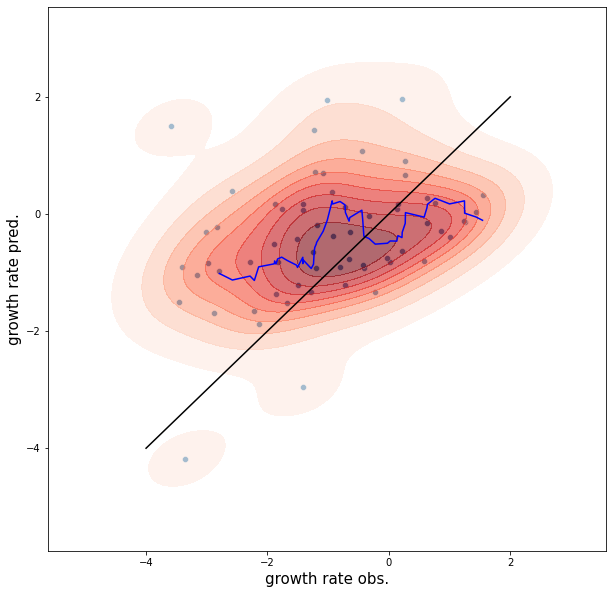

In [84]:
count_p = 1
pass_ = 0
df_ = pd.DataFrame(data={"growth rate obs" : growth_rate_obs[:, pass_], \
                         "growth rate pred" : growth_rate_species[count_p, :, num_iter - 1]})

x = df_["growth rate obs"].values
y = df_["growth rate pred"].values

species_fac = 1 / np.sum(abundance_prev_obs[:, pass_] * growth_rate_species[count_p, :, num_iter - 1])
y *= species_fac

id_ = np.where((~np.isnan(x)) & (y >= 0))[0]
# id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
x = x[id_]
y = y[id_]
print(len(id_))

id_pos_pos = np.where((x > 1) & (y > 1))[0]
id_pos_neg = np.where((x > 1) & (y < 1))[0]
id_neg_pos = np.where((x < 1) & (y > 1))[0]
id_neg_neg = np.where((x < 1) & (y < 1))[0]

print(f'#pos-pos = {len(id_pos_pos)}')
print(f'#pos-neg = {len(id_pos_neg)}')
print(f'#neg-pos = {len(id_neg_pos)}')
print(f'#neg-neg = {len(id_neg_neg)}')

id_order = np.argsort(x)
x_order = (x.copy())[id_order]
y_order = (y.copy())[id_order]
df_ = pd.DataFrame(data={"x" : np.log10(x_order), "y" : np.log10(y_order)})
window_size = 10
rolling_avg = df_['y'].rolling(window_size).mean().values
id_not_nan = np.where(~np.isnan(rolling_avg))[0]
id_nan = np.where(np.isnan(rolling_avg))[0]

# mpl.rcParams['lines.linewidth'] = 10, 10
mpl.rcParams["figure.figsize"] = (10, 10)
plt_ = sns.scatterplot(x=np.log10(x), \
                       y=np.log10(y))
plt_ = sns.kdeplot(x=np.log10(x), y=np.log10(y), fill=True, alpha=0.6, cmap="Reds", ax=plt_)

plt_ = sns.lineplot(x=(df_['x']), \
                    y=(rolling_avg), color='blue', ax=plt_)

plt_.plot([-4, 2], [-4, 2], c="black")
plt_.set_xlabel("growth rate obs.", size=15)
plt_.set_ylabel("growth rate pred.", size=15)
# plt_.set_xscale("log", base=10)
# plt_.set_yscale("log", base=10)
corr_val = scipy.stats.pearsonr(np.log10(x), np.log10(y))
print(corr_val)

In [57]:
nboot_ = 10000
pos_pos_mat = np.zeros((nboot_))
pos_neg_mat = pos_pos_mat.copy()
neg_pos_mat = pos_pos_mat.copy()
neg_neg_mat = pos_pos_mat.copy()

for b_ in range(nboot_):
    vals_ = []
    for species_ in range(num_species):
        

(1, 63, 10)

In [1770]:
Ri_avg = np.zeros((num_metabs))
for species_ in range(num_species):
    Ri_avg += Ri_all_mat[0, species_, num_iter - 1, :].flatten()
Ri_avg /= num_species

In [1769]:
Ri_all_mat.shape

(6, 63, 10, 292)

In [1771]:
filename_ = "metabs_unranked_p0.0001_leaveOneOut.csv"
filepath_ = os.path.join(os.getcwd(), "..", "figures", "predictions", "leaveOneOut", 
                                filename_)
df_Ri_1e_4 = pd.read_csv(filepath_)

pearson corr.
PearsonRResult(statistic=0.919998122348578, pvalue=1.205238734376318e-50)
pearson corr. log scale
PearsonRResult(statistic=0.8963723836767379, pvalue=3.2511546164692275e-44)
spearman corr.
SpearmanrResult(correlation=0.8203495461319604, pvalue=6.617881203388607e-31)


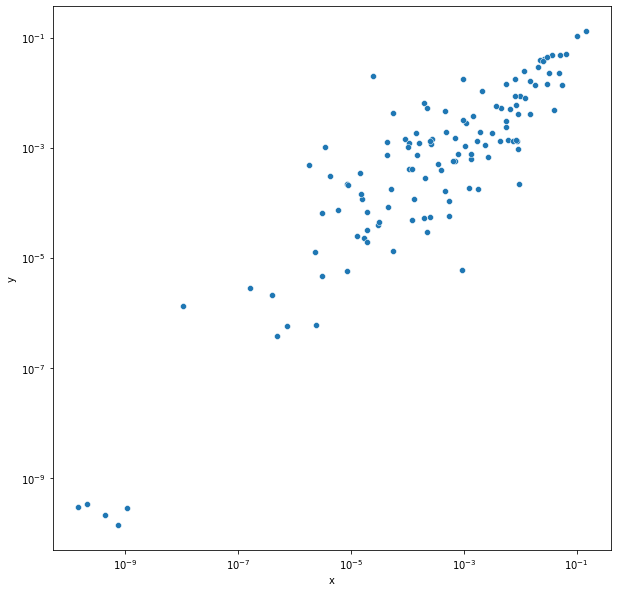

In [1778]:
filename_ = "metabs_unranked_p0.0001_leaveOneOut.csv"
filepath_ = os.path.join(os.getcwd(), "..", "figures", "predictions", "leaveOneOut", 
                                filename_)
df_Ri_1e_4 = pd.read_csv(filepath_)

df_plt = pd.DataFrame(data={"x" : df_Ri_1e_4['Ri_fit'].values, 
                            "y" : Ri_avg})
id__ = np.where((df_Ri_1e_4['Ri_fit'].values > 1e-12) & (Ri_avg > 1e-12))[0]

df_plt_new = df_plt.copy().iloc[id__, :]
# df_plt_new = df_plt.copy()
plt_ = sns.scatterplot(data=df_plt_new, x="x", y="y")
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

print("pearson corr.")
print(scipy.stats.pearsonr((df_plt_new["x"]), (df_plt_new["y"])))

print("pearson corr. log scale")
print(scipy.stats.pearsonr(np.log(df_plt_new["x"]), np.log(df_plt_new["y"])))

print("spearman corr.")
print(scipy.stats.spearmanr(np.log(df_plt_new["x"]), np.log(df_plt_new["y"])))

In [1777]:
id_ = np.where((df_plt["x"].values <= 1e-12) & (df_plt["y"].values >= 1e-4))[0]
vals_ = df_plt["y"].values[id_]

id_argsort = np.argsort(-vals_)
# print(vals_[id_argsort])


metab_names_select = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
metab_names_select_new = metab_names_select.copy()[id_]
df_show = pd.DataFrame(data={"name" : metab_names_select_new[id_argsort], 
                             "Ri" : vals_[id_argsort]})
print(df_show)
# print(df_metabIds.iloc[:, 0].values[id_[0]])
# print(metab_names_select_new[0])

                                          name        Ri
0                            1-METHYLADENOSINE  0.029049
1                         4-ETHYLOCTANOIC ACID  0.003948
2                            3-METHOXYTYRAMINE  0.003313
3                                    CARNITINE  0.002370
4                     IS_4-BROMO-PHENYLALANINE  0.001405
5                        1,6-ANHYDRO-B-GLUCOSE  0.001311
6                   IS_TRYPTOPHAN-2,4,5,6,7-D5  0.001158
7                              O-ACETYL-SERINE  0.000820
8                             N-BUTYRYLGLYCINE  0.000792
9                                     AGMATINE  0.000694
10                    IS_4-BROMO-PHENYLALANINE  0.000588
11                           PYROGLUTAMIC ACID  0.000559
12                   IS_CARNITINE-TRIMETHYL-D9  0.000394
13                               ASPARTIC ACID  0.000381
14                               GLUTAMIC ACID  0.000352
15                                 MALEIC ACID  0.000313
16                          8-H

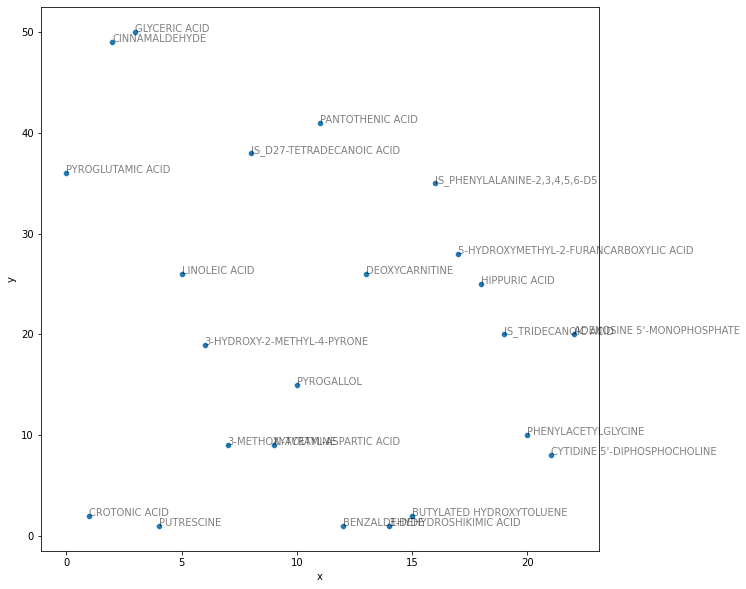

In [1590]:
id_ = np.where((df_plt["x"].values <= 1e-12) & (df_plt["y"].values >= 1e-4))[0]
vals_ = df_plt["y"].values[id_]

id_argsort = np.argsort(-vals_)
# print(vals_[id_argsort])


metab_names_select = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
metab_names_select_new = metab_names_select.copy()[id_]
df_show = pd.DataFrame(data={"name" : metab_names_select_new[id_argsort], 
                             "Ri" : vals_[id_argsort]})
print(df_show)

df_speciesMetab_tmp = df_speciesMetab.copy()
df_speciesMetab_tmp[df_speciesMetab_tmp != 0] = 1
df_speciesMetab_tmp = np.array(df_speciesMetab_tmp)
df_speciesMetab_tmp
sum_select = df_speciesMetab_tmp.sum(axis=0)
df_tmp = pd.DataFrame(data={"x" : range(len(id_argsort)), 
                            "y" : sum_select[id_][id_argsort], 
                            "metabs" : metab_names_select_new[id_argsort]})
plt_ = sns.scatterplot(data=df_tmp, x="x", y="y")
for row_ in range(df_tmp.shape[0]):
    plt.text(df_tmp.iloc[row_, 0], df_tmp.iloc[row_, 1], df_tmp.iloc[row_, 2], \
             fontdict=dict(color='black', alpha=0.5, size=10))

In [1614]:
id_species = np.where(np.array(df_speciesMetab_tmp[:, id_[id_argsort][1]]) != 0)[0]
id_species
cont_select = df_speciesMetab.iloc[id_species[1], id_[id_argsort][1]]
id_rest = set(range(num_metabs)) - set([id_[id_argsort][1]])
id_rest = list(id_rest - set(id__))
cont_select = df_speciesMetab.iloc[id_species[1], id_[id_argsort][1]]
cont_rest = df_speciesMetab.iloc[id_species[1], id_rest].values
# print(np.mean(cont_rest[cont_rest != 0]))
print(cont_select * Ri_avg[id_[id_argsort][1]] * df_speciesAbun.iloc[id_species[1], 1])
print(np.sort(-(cont_rest * Ri_avg[id_rest] * df_speciesAbun.iloc[id_species[1], 1])))
# np.sum(np.array(df_speciesMetab.iloc[:, id_[id_argsort][1]]))
# np.sum(np.array(df_speciesMetab_tmp[:, id_[id_argsort][1]]))
_, mat_cons_abun_list = \
    iterate_growth_ratio(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, p_vec_new[count_p])

0.0012058070766722338
[-2.86773249e-03 -1.55350405e-03 -1.00496711e-03 -1.59138690e-04
 -1.56278116e-04 -3.92269961e-05 -3.23172825e-05 -1.75002180e-05
 -7.50228130e-06 -1.36766387e-06 -2.77198692e-07 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0

In [1241]:
id_ = id_2[2]
species_ = id_
count_p = 4
pass_ = 0
num_iter = 10
p_tmp = p_vec[count_p]
# p_tmp = 1e-6
test_strain_id = [species_]
train_strain_id = list(set(range(num_species)) - set(test_strain_id))
Ri_all, growth_rate_all = \
    compute_Ri_growth_ratio(pass_, train_strain_id, test_strain_id, df_speciesAbun_prev, \
                            df_speciesAbun_next, df_speciesAbun_ratio, df_speciesMetab, p_tmp, \
                            num_iter)

<ipython-input-1229-ea27a0db4192>:100: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_tmp)).reshape((len(train_strain_id), 1))


In [1242]:
print(growth_rate_all)
print(growth_rate_obs.copy()[id_])

[0.01434336 0.0142184  0.01421822 0.01421821 0.01421821 0.01421821
 0.01421821 0.01421821 0.01421821 0.01421821]
0.0016153419911614831


In [1186]:
p_vec

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55])

In [977]:
df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_ratio_new_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
growth_rate_obs = np.zeros((num_species))
for species_ in range(num_species):
    x = df_speciesAbun_ratio_new_.iloc[species_, :].values
    growth_rate_obs[species_] = np.exp(np.mean(np.log(x[x != -1])))

In [939]:
count_p = 0
df_ = pd.DataFrame(data={"growth rate obs" : growth_rate_obs, \
                         "growth rate pred" : growth_rate_species[count_p, :, num_iter - 1]})

x = growth_rate_obs.copy()
y = growth_rate_species[count_p, :, num_iter - 1].copy()

id_ = np.where((~np.isnan(x)) & (y < 40))[0]
len(id_)

28

In [1015]:
df_speciesMetab_tmp = df_speciesMetab.copy()
df_speciesMetab_tmp[df_speciesMetab_tmp != 0] = 1
df_speciesMetab

0         1         2         3         4         5         6    \
0   0.00000  0.992959  0.000000  0.000000  0.000000  0.000000  0.014442   
1   0.00000  0.987929  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.00000  0.000000  0.000000  0.000000  0.071749  0.786843  0.000000   
3   0.00000  0.119998  0.000000  0.997475  0.000000  0.175925  0.161736   
4   0.00000  0.402634  0.000000  0.000000  0.000000  0.827697  0.000000   
..      ...       ...       ...       ...       ...       ...       ...   
58  0.00000  0.200966  0.141728  0.000000  0.000000  0.652087  0.050226   
59  0.44559  0.058588  0.000000  0.179604  0.000000  0.361881  0.000000   
60  0.00000  0.000000  0.000000  0.000000  0.938443  0.375303  0.000000   
61  0.00000  0.162898  0.217158  0.000000  0.000000  0.563057  0.000000   
62  0.00000  0.000000  0.000000  0.493556  0.224312  0.000000  0.000000   

         7         8         9    ...       282       283       284       285  \
0   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1   0.000000  0.916520  0.000000  ...  0.000000  0.000000  0.135037  0.000000   
2   0.000000  0.000000  0.813938  ...  0.000000  0.000000  0.283760  0.020476   
3   0.000000  0.141034  0.096047  ...  0.000000  0.181099  0.000000  0.977622   
4   0.000000  0.288069  0.457678  ...  0.000000  0.000000  0.000000  0.000000   
..       ...       ...       ...  ...       ...       ...       ...       ...   
58  0.000000  0.348466  0.348539  ...  0.000000  0.000000  0.000000  0.298522   
59  0.000000  0.130612  0.000373  ...  0.000000  0.000000  0.000000  0.025765   
60  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
61  0.273662  0.079772  0.077823  ...  0.253915  0.043567  0.637154  0.161100   
62  0.000000  0.222897  0.000000  ...  0.000000  0.024133  0.000000  0.043985   

         286       287       288       289       290  291  
0   0.104553  0.000000  0.221836  0.070147  0.000000  0.0  
1   0.143596  0.000000  0.790017  0.000000  0.000000  0.0  
2   0.864645  0.134274  0.960560  0.000000  0.285223  0.0  
3   0.057470  0.405372  0.996726  0.985360  0.036128  0.0  
4   0.000000  0.000000  0.000000  0.949384  0.000000  0.0  
..       ...       ...       ...       ...       ...  ...  
58  0.000000  0.000000  0.000000  0.974129  0.000000  0.0  
59  0.000000  0.039111  0.314827  0.797749  0.000000  0.0  
60  0.000000  0.002837  0.371886  0.932531  0.000000  0.0  
61  0.151394  0.000710  0.532648  0.799041  0.065574  0.0  
62  0.042430  0.184180  0.628580  0.000000  0.000000  0.0  

[63 rows x 292 columns]

# 25 March 2023: Simulated annealing for finding 'best' Ri

In [345]:
10 % 4

2

In [544]:
# def neighborhood_fn(current_solution, norm_temp):
#     neighbor = np.zeros_like(current_solution)
#     for id_, coord_ in enumerate(current_solution):
#         neighbor[id_] = np.power(10, np.random.normal(np.log10(coord_), sqrt(norm_temp), 1))
    
#     return neighbor
filename_ = "metabs_unranked_p0.0001_leaveOneOut.csv"
filepath_ = os.path.join(os.getcwd(), "..", "figures", "predictions", "leaveOneOut", 
                                filename_)
df_Ri_1e_4 = pd.read_csv(filepath_)
Ri_avg = df_Ri_1e_4["Ri_fit"].values

df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

p_tmp = 0.05
sample_names_split, mat_cons_abun_split_list_tmp = \
    iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp_.copy(), \
                         df_speciesAbun_next_tmp_.copy(), p_=p_tmp)

def objective_fn(Ri, pass_=0):
    id_species = range(df_speciesAbun_prev_tmp_.shape[0])
    count_ = 0
    error_ = 0
#     df_growth_ratio = pd.DataFrame()
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        error_ += np.sqrt(np.mean(np.power((vals_tmp - tmp.flatten()), 2)))
        
#         df_growth_ratio[sample_] = vals_tmp
        
        
    error_ /= len(sample_names_split)
    return error_

def objective_fn_new(Ri_avg, pass_=0):
    num_iter = 10
    growth_rate_all = np.zeros((num_iter, num_species))
    growth_rate_all = {}
    growth_rate_all[0] = pd.DataFrame()
    df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    ratio_means_ = {}
    for col_ in df_speciesAbun_prev_tmp_.columns.values:
        growth_rate_all[0][col_] = np.ones((num_species))
#         growth_rate_all[0][col_] = df_speciesAbun_ratio_tmp_[col_].values
        ratio_means_[col_] = np.mean(np.log10(df_speciesAbun_ratio_tmp_[col_].values))
    p_tmp = 0.05
    for iter_ in range(num_iter):
        if iter_ == 0:
            iter_id = iter_
        else:
            iter_id = iter_ - 1
        if iter_ <= -1:
            df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                          df_speciesAbun_next_tmp_.copy(), \
                                                          p_tmp, Ri_avg.copy(), \
                                                          growth_rate_all[iter_id].copy(), ratio_means_.copy())
        else:
            df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                          df_speciesAbun_next_tmp_.copy(), \
                                                          p_tmp, Ri_avg.copy(), \
                                                          growth_rate_all[iter_id].copy(), ratio_means_.copy(), 
                                                          norm_=False)
        growth_rate_all[iter_] = df_growth_rate.copy()
        
    x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, :].flatten())
    y=np.log10(np.array(growth_rate_all[num_iter - 1])[:, :].flatten())
    # y=np.random.permutation(x)
    y[y <= -5] = -5
    id_ = np.where((y > -100))[0]
    x = x[id_]
    y = y[id_]

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)

    model = sm.OLS(y, x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]
    
    error_ = np.abs(1 - corr_val_pe[0])
    
    return error_
    

# Simulated Annealing function
def simulated_annealing(initial_solution, neighborhood_fn, objective_fn, temperature, cooling_rate, \
                        stopping_temperature):
    # Initialize the current solution and best solution
    current_solution = initial_solution.copy()
    best_solution = initial_solution.copy()
    max_temp = temperature

    # Start the search until the stopping temperature is reached
    iter_ = 0
    while temperature > stopping_temperature:
        # Generate a random neighbor
        neighbor = random.choice(neighborhood_fn(current_solution, temperature / max_temp))
#         neighbor = neighborhood_fn(current_solution, temperature / max_temp)

        # Calculate the objective function difference between the current solution and the neighbor
        delta = objective_fn_new(neighbor) - objective_fn_new(current_solution)
#         print(f'temperature = {temperature}, delta = {delta}')
        if iter_ % 100 == 0:
            print(f"iteration # = {iter_}, temperature = {temperature}, delta = {delta}")

        # If the neighbor is better, move to it
        if delta < 0:
            current_solution = neighbor[:]
        # If the neighbor is worse, move to it with a probability based on the temperature
        else:
            probability = math.exp(-delta / temperature)
            if random.random() < probability:
                current_solution = neighbor[:]

        # Update the best solution if necessary
        if objective_fn_new(current_solution) < objective_fn_new(best_solution):
            best_solution = current_solution[:]

        # Cool the temperature
        temperature *= cooling_rate
        
        iter_ += 1

    # Return the best solution found
    return best_solution

# Define the objective function to calculate the value of a solution
def value_fn(solution):
    return sum(solution)

# Define the neighborhood function to change one element in the solution
def neighborhood_fn(solution, norm_temp):
    neighborhoods = []
    for i, sol_ in enumerate(solution):
        neighbor = solution.copy()
#         neighbor[i] = random.randint(0, 9)
#         neighbor[i] = np.exp(np.random.normal(np.log(sol_), np.sqrt(norm_temp), 1))
        lower_lim = np.log10(sol_) - (np.log10(sol_) + 12) * norm_temp
        upper_lim = np.log10(sol_) + (0 - np.log10(sol_)) * norm_temp
        neighbor[i] = np.power(10, np.random.uniform(lower_lim, upper_lim, 1))[0]
#         if neighbor[i] >= 1:
#             neighbor[i] = 0.99
        neighborhoods.append(neighbor)
    return neighborhoods

# Set the initial solution and parameters for the Simulated Annealing algorithm
initial_solution = Ri_avg.copy()
initial_solution[initial_solution == 0] = 1e-12
temperature = 1000
cooling_rate = 0.95
stopping_temperature = 1e-8

# Run the Simulated Annealing algorithm to find the best solution
best_solution = simulated_annealing(initial_solution, neighborhood_fn, objective_fn, temperature, \
                                    cooling_rate, stopping_temperature)

# Print the best solution and its value
print("Best solution found:", best_solution)
print("Value of best solution:", objective_fn_new(best_solution))


iteration # = 0, temperature = 1000, delta = 0.0005221754086823793
iteration # = 100, temperature = 5.920529220333994, delta = 2.1094237467877974e-15
iteration # = 200, temperature = 0.035052666248828655, delta = -5.551115123125783e-16
iteration # = 300, temperature = 0.00020753033477680536, delta = 4.030797917664586e-11
iteration # = 400, temperature = 1.2286894111517737e-06, delta = 0.0
Best solution found: [1.42354579e-05 3.88723645e-02 1.00000000e-13 1.00000000e-13
 3.09739260e-03 2.61937578e-02 1.07629021e-03 2.08149897e-04
 1.00000000e-13 1.01056691e-01 1.41928649e-08 2.65435010e-04
 1.00000000e-13 8.48763944e-06 1.00000000e-13 1.00000000e-13
 1.47392864e-10 1.00000000e-13 1.00000000e-13 1.00000000e-13
 1.56370303e-05 2.40900188e-06 1.00000000e-13 1.00000000e-13
 1.00000000e-13 4.87574690e-07 1.00000000e-13 2.50916455e-05
 1.00000000e-13 4.27200515e-05 1.00000000e-13 1.00000000e-13
 7.11642390e-04 1.73132320e-05 1.00000000e-13 1.00000000e-13
 1.00000000e-13 1.31128452e-04 1.00000

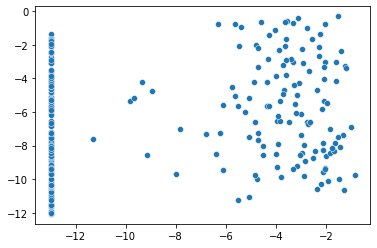

In [512]:
plt_ = sns.scatterplot(x=np.log10(Ri_avg), y=np.log10(neighborhood_fn(Ri_avg.copy(), 0.9)))

In [545]:
print(f'value at best solution {objective_fn_new(best_solution)}')
print(f'value at initial solution {objective_fn_new(Ri_avg.copy())}')

value at best solution 0.8393502511410833
value at initial solution 0.8393502511410833


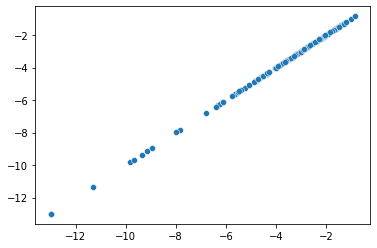

In [546]:
plt_ = sns.scatterplot(x=np.log10(Ri_avg), y=np.log10(best_solution))

In [547]:
Ri_avg - best_solution

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [487]:
Ri_avg = best_solution.copy()
print(Ri_avg)

[2.14245983e-04 1.00000000e-11 1.00000000e-11 1.00000000e-11
 6.03031209e-05 5.19071520e-02 2.76772681e-03 2.96342708e-04
 1.00000000e-11 1.09617798e-01 1.00000000e-11 6.55364946e-04
 1.00000000e-11 3.01921261e-06 1.00000000e-11 1.93864307e-04
 1.70834611e-09 2.89270551e-03 1.00000000e-11 3.64979369e-04
 1.30218339e-03 1.00000000e-11 1.46287508e-06 1.00000000e-11
 1.00000000e-11 7.50403080e-09 1.31694352e-03 6.24168670e-02
 1.00000000e-11 1.00000000e-11 1.00000000e-11 1.00000000e-11
 2.61876787e-11 2.34086208e-05 1.00000000e-11 1.15287487e-04
 1.00000000e-11 2.17498847e-05 5.30313121e-02 1.00000000e-11
 1.00000000e-11 1.00000000e-11 4.42154165e-04 1.00000000e-11
 1.00000000e-11 1.00000000e-11 1.00000000e-11 1.00000000e-11
 5.49953933e-04 3.01610756e-03 4.59029837e-04 1.00000000e-11
 1.00000000e-11 5.41871966e-06 1.00000000e-11 1.00000000e-11
 1.00000000e-11 4.91930040e-03 1.00000000e-11 1.00000000e-11
 3.39513631e-04 1.00000000e-11 1.00000000e-11 1.34581512e-04
 1.31970361e-03 6.756818

$$R_i^{\text{null}} = \frac{\left \langle \sum_{\beta} c^{\beta}_i B^{\beta} \right \rangle_{\text{rep, passages}}}{\left \langle \sum_{j} c^{\beta}_j \right \rangle_{\beta}}$$

# 16 April 2023: Check fitted Ri and metabolite names for dynamic (all passages) for no-microcosm

In [628]:
df_metabNames.shape
df_metabIds.iloc[:, 0].values 

array([  1,   4,   5,   6,   8,  10,  11,  12,  13,  16,  18,  20,  21,
        22,  25,  26,  27,  28,  29,  32,  34,  37,  40,  41,  42,  46,
        49,  50,  54,  58,  60,  62,  63,  65,  66,  67,  68,  70,  71,
        72,  73,  77,  80,  81,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98, 101, 104, 105, 106, 107,
       109, 110, 112, 113, 115, 116, 118, 120, 122, 123, 124, 125, 126,
       130, 131, 132, 133, 135, 136, 137, 138, 139, 141, 144, 146, 148,
       151, 154, 158, 159, 163, 164, 171, 172, 177, 181, 184, 186, 189,
       193, 194, 197, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       215, 217, 221, 222, 223, 224, 225, 227, 229, 230, 232, 233, 238,
       244, 245, 246, 248, 249, 251, 252, 253, 254, 255, 256, 257, 259,
       260, 262, 263, 264, 265, 266, 268, 269, 270, 273, 274, 275, 276,
       277, 278, 282, 283, 284, 285, 286, 288, 289, 291, 292, 293, 294,
       295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 30

In [852]:
df_metabs_clusters

cluster_labels  cluster_counts  \
0                0               7   
1                1              22   
2                2               3   
3                3              38   
4                4               9   
5                5               6   
6                6               6   
7                7               5   
8                8              26   
9                9               7   
10              10               2   
11              11              12   
12              12               8   
13              13               6   
14              14               9   
15              15              27   
16              16               5   
17              17              13   
18              18              16   
19              19              32   
20              20               4   
21              21               5   
22              22               2   
23              23               3   
24              24               1   
25              25               1   
26              26               1   
27              27               1   
28              28               1   
29              29               1   
30              30               1   
31              31               1   
32              32               1   
33              33               1   
34              34               1   
35              35               1   
36              36               1   
37              37               1   
38              38               1   
39              39               1   
40              40               1   
41              41               1   
42              42               1   

                                    cluster_metab_IDs  \
0                     [3, 25, 36, 121, 135, 195, 248]   
1   [8, 15, 23, 35, 103, 144, 157, 173, 187, 190, ...   
2                                     [147, 168, 288]   
3   [9, 14, 31, 47, 51, 54, 56, 58, 59, 63, 94, 10...   
4              [20, 37, 40, 55, 79, 86, 98, 186, 243]   
5                         [2, 61, 100, 125, 160, 199]   
6                          [6, 16, 60, 120, 145, 162]   
7                            [49, 133, 196, 220, 259]   
8   [7, 11, 13, 17, 21, 22, 32, 50, 119, 122, 123,...   
9                     [27, 65, 83, 97, 205, 255, 269]   
10                                         [245, 265]   
11  [4, 26, 30, 53, 84, 99, 102, 171, 188, 198, 22...   
12             [33, 41, 124, 150, 165, 211, 237, 242]   
13                      [88, 129, 163, 212, 239, 277]   
14          [10, 42, 93, 96, 159, 164, 218, 219, 280]   
15  [62, 67, 72, 74, 76, 78, 90, 92, 95, 107, 108,...   
16                           [77, 174, 178, 206, 208]   
17  [24, 28, 57, 70, 73, 106, 130, 136, 137, 138, ...   
18  [5, 38, 68, 75, 82, 89, 91, 101, 146, 169, 192...   
19  [19, 34, 39, 43, 44, 45, 46, 48, 66, 69, 71, 8...   
20                                 [1, 126, 155, 253]   
21                           [12, 134, 148, 154, 221]   
22                                         [151, 261]   
23                                     [18, 194, 224]   
24                                                [0]   
25                                               [29]   
26                                               [52]   
27                                               [64]   
28                                               [80]   
29                                               [85]   
30                                              [105]   
31                                              [140]   
32                                              [176]   
33                                              [177]   
34                                              [184]   
35                                              [214]   
36                                              [217]   
37                                              [232]   
38                                              [234]   
39                                              [23

In [853]:
p_tmp = 0.2
x = Ri_noMicrocosm_fit_avg[p_tmp].copy()
rank_x = get_rank(-x)
id_ = np.where((rank_x < 60))[0]
metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
# print(metab_names[id_])
# print(rank_x[id_])
# print(rank_y[id_])
# print(x[id_])
# print(y[id_])

id_order = np.argsort(rank_x[id_])
# df_metabs = pd.DataFrame(data={"metab_name" : metab_names[id_][id_order], \
#                                "rank_noMicrocosm" : rank_x[id_][id_order], \
#                                "Ri_noMicrocosm" : x[id_][id_order]})
df_metabs = pd.DataFrame(data={"metab_name" : df_metabs_clusters["cluser_metab_names"].values[id_[id_order]], \
                               "rank_noMicrocosm" : rank_x[id_][id_order], \
                               "Ri_noMicrocosm" : x[id_][id_order]})
print(df_metabs)

# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                         'predictions', 'leaveOneOut', \
#                                         '20230411_RiFit_compare_noMicrocosm_vs_supernatantAgar'))
# if not os.path.exists(save_dir):
#    # Create a new directory because it does not exist
#    os.makedirs(save_dir)

# save_file = os.path.abspath(os.path.join(save_dir, f'metabs_common_top30_noMicrocosm_superAgar_p{p_tmp}.csv'))
# df_metabs.to_csv(save_file)
# df_metabs

                                           metab_name  rank_noMicrocosm  \
0   [CINNAMALDEHYDE, TRYPTOPHAN ETHYL ESTER, STEAR...                 0   
1   [BETA-ALANINE, SUCCINIC ACID, OMEGA-HYDROXYDOD...                 1   
2   [2-(4-HYDROXYPHENYL)PROPIONIC ACID, 5-AMINOPEN...                 2   
3   [N-BENZYLFORMAMIDE, HEPTADECANOIC ACID, RAC-GL...                 3   
4            [3-METHOXYTYRAMINE, PHENYLACETYLGLYCINE]                 4   
5                                         [CARNOSINE]                 5   
6                                     [3-FUROIC ACID]                 6   
7   [1,3-DIAMINOPROPANE, 1,2-DIDECANOYL-SN-GLYCERO...                 7   
8                                      [HYPOXANTHINE]                 8   
9   [SUCROSE, 3-HYDROXYPROPIONIC ACID, 1-METHYL-HY...                 9   
10  [OLEIC ACID, CARNITINE, 3,4-DIHYDROXY-PHENYLAL...                10   
11                              [N,N-DIMETHYLGLYCINE]                11   
12  [2-AMINO-2-METHYLPROP

In [859]:
df_metabs.iloc[3, 0]

['2-(4-HYDROXYPHENYL)PROPIONIC ACID',
 '5-AMINOPENTANOIC ACID',
 'BENZALDEHYDE',
 '3-DEHYDROSHIKIMIC ACID',
 'GLUTAMIC ACID',
 'OPHTHALMIC ACID',
 'PYROGLUTAMIC ACID']

PearsonRResult(statistic=0.37908961608959535, pvalue=0.002184590272185163)


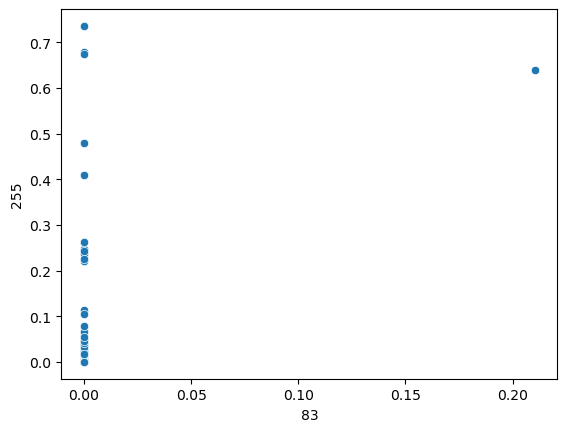

In [864]:
id_1 = np.where(metab_names == 'BENZALDEHYDE')[0][0]
id_2 = np.where(metab_names == 'OPHTHALMIC ACID')[0][0]
x = df_speciesMetab.iloc[:, id_1]
y = df_speciesMetab.iloc[:, id_2]
plt_ = sns.scatterplot(x=x, y=y)
print(scipy.stats.pearsonr(x, y))

In [753]:
np.where(df_speciesMetab.iloc[:, id_[id_order[2]]] > 0)[0]

array([ 0,  1,  2,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 27, 29, 31, 32, 33, 34, 36, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 51, 54, 55, 56, 58, 61, 62])

In [741]:
pass_ = 5
np_abun = np.array(df_speciesAbun.iloc[:, [pass_, pass_ + 6, pass_ + 12]])
np_abun_mn = 10**(np.mean(np.log10(np_abun), axis=1))

In [743]:
rank_species = get_rank(-np_abun_mn)
rank_species

array([20,  0, 12, 52, 39, 51, 47, 25,  2, 36, 33, 10, 37, 31, 44,  1, 18,
       13, 23, 27, 28,  5,  3,  6, 32, 15, 58, 58, 48, 30, 58, 19,  4, 11,
       43, 49, 26, 41, 17, 35, 58, 24, 22, 58, 50,  9, 58, 53, 40, 38, 46,
        8, 34, 45, 14,  7, 42, 58, 16, 29, 21, 58, 58])

In [749]:
vals_most_abun = df_speciesMetab.iloc[1, :].values
rank_most_abun = get_rank(-vals_most_abun)
rank_most_abun[id_[id_order[0]]]

46

In [727]:
id_z = np.where(x == 0)[0]
metab_names[id_z]

array(['GALACTOSAMINE', 'N-METHYL-ASPARTIC ACID',
       '2-AMINO-2-METHYLPROPANOIC ACID', 'NICOTINIC ACID',
       'MANNOSE 6-PHOSPHATE', 'VALINE', 'THREONINE', 'BETA-ALANINE',
       '5,6-DIHYDROURACIL', '5-METHYLCYTOSINE', 'PIPECOLIC ACID',
       'UROCANIC ACID', '8-HYDROXYQUINOLINE',
       'AMINO(4-HYDROXYCYCLOHEXYL)ACETIC ACID', 'PHOSPHOCHOLINE',
       '3,4-DIHYDROXY-PHENYLALANINE', 'OMEGA-HYDROXYDODECANOIC ACID',
       'TRYPTOPHAN ETHYL ESTER', 'CYSTINE', 'N1-ACETYLSPERMINE',
       '1-METHYLADENOSINE', 'STEARIC ACID',
       "ADENOSINE 3',5'-CYCLIC MONOPHOSPHATE",
       'IS_CARNITINE-TRIMETHYL-D9', 'IS_2-FLUROPHENYLGLYCINE',
       'IS_METHIONINE-METHYL-D3', 'IS_LEUCINE-5,5,5-D3',
       'IS_PHENYLALANINE-2,3,4,5,6-D5', 'IS_PHENYLALANINE-2,3,4,5,6-D5',
       'IS_N-BENZOYL-D5-GLYCINE', 'IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID',
       'IS_D15-OCTANOIC ACID', 'IS_D19-DECANOIC ACID',
       'IS_DI-N-OCTYL PHTHALATE-3,4,5,6-D4', 'IS_TRIDECANOIC ACID',
       'IS_D27-TETRADECANOIC

# 13 April 2023: No microcosm fit Ri dynamic (all passages) and blindly predict abundances. Fitting with non-negative elastic net

In [569]:
def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri_lasso(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
                     p_tmp, num_passages, id_species, alpha_=0.001):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
#     coeff_train_ = nnls(A_train, b_train.flatten())[0]
    regr = ElasticNet(random_state=0, alpha=alpha_, l1_ratio=1, fit_intercept=False, positive=True)
    regr.fit(A_train, b_train.flatten())
    coeff_train_ = regr.coef_
    return coeff_train_



def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [557]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_dynamic_' + \
                                        'all_passages'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

In [570]:
p_tmp = 0.5
species_ = 0
id_species = list(set(range(num_species)) - set([species_]))
coeff_tmp = compute_Ri_lasso(df_speciesMetab.copy(), \
                             df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), \
                             df_speciesAbun_ratio.copy(), \
                             p_tmp, num_passages, \
                             id_species, alpha_=0.1)

In [571]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
Ri_noMicrocosm_fit_lasso_all = {}
Ri_noMicrocosm_fit_lasso_avg = {}
num_metabs = df_speciesMetab.shape[1]
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_fit_lasso_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_fit_lasso_avg[p_tmp] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_fit_lasso_all[p_tmp][species_, :] = compute_Ri_lasso(df_speciesMetab.copy(), \
                                                                df_speciesAbun_prev.copy(), \
                                                                df_speciesAbun_next.copy(), \
                                                                df_speciesAbun_ratio.copy(), \
                                                                p_tmp, num_passages, \
                                                              id_species, alpha_=0.1)
        Ri_noMicrocosm_fit_lasso_avg[p_tmp] += Ri_noMicrocosm_fit_lasso_all[p_tmp][species_, :]
        
    Ri_noMicrocosm_fit_lasso_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230416_predict_abundance_blind_noMicrocosm_Ri_fit_lasso_dynamic_' + \
                                        'all_passages'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230416_Ri_fit_lasso_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm.pickle'))

save_obj = {"Ri_noMicrocosm_fit_lasso_all" : Ri_noMicrocosm_fit_lasso_all, \
            "Ri_noMicrocosm_fit_lasso_avg" : Ri_noMicrocosm_fit_lasso_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.4


/home/tarunm3/miniconda3/envs/pyg_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e+00, tolerance: 8.320e-02
  model = cd_fast.enet_coordinate_descent(


count_p = 11, p = 0.5
count_p = 12, p = 0.55
count_p = 13, p = 0.6
count_p = 14, p = 0.65


/home/tarunm3/miniconda3/envs/pyg_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.261e-01, tolerance: 8.320e-02
  model = cd_fast.enet_coordinate_descent(


count_p = 15, p = 0.7


/home/tarunm3/miniconda3/envs/pyg_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.163e+00, tolerance: 8.320e-02
  model = cd_fast.enet_coordinate_descent(


In [563]:
Ri_noMicrocosm_fit_all[0.001].shape

(63, 292)

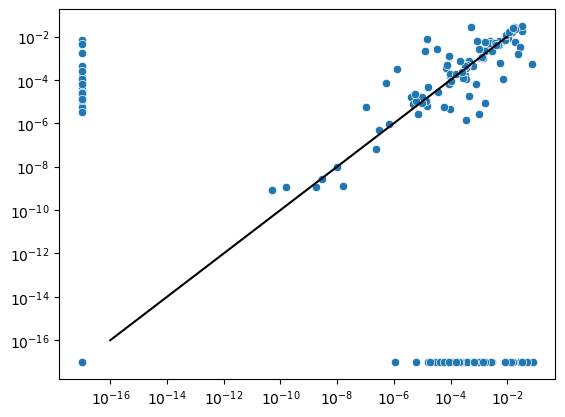

In [580]:
p_tmp = 0.2
x = Ri_noMicrocosm_fit_avg[p_tmp].copy()
y = Ri_noMicrocosm_fit_lasso_avg[p_tmp].copy()
x[x == 0] = 1e-17
y[y == 0] = 1e-17

plt_ = sns.scatterplot(x=x, y=y)
plt_.plot([1e-16, 1e-2], [1e-16, 1e-2], c="black")
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

In [581]:
id_x = np.argsort(-x)
id_y = np.argsort(-y)

print(metab_names[id_x[range(20)]])
print(metab_names[id_y[range(20)]])


['BENZALDEHYDE' 'CINNAMALDEHYDE' '3-DEHYDROSHIKIMIC ACID'
 'IS_4-CHLORO-PHENYLALANINE_2' 'BETA-ALANINE_0' '3-METHOXYTYRAMINE'
 "2'-DEOXYGUANOSINE 5'-MONOPHOSPHATE" '2-(4-HYDROXYPHENYL)PROPIONIC ACID'
 '1,6-ANHYDRO-B-GLUCOSE' "3'-CMP" 'IS_D27-TETRADECANOIC ACID_1'
 'PYRUVIC ACID' 'GLYCERIC ACID' "S-(5'-ADENOSYL)-L-HOMOCYSTEINE"
 'BETA-LACTOSE' 'GLYCEROL 2-PHOSPHATE' 'N6-(DELTA2-ISOPENTENYL)-ADENINE'
 '3-HYDROXY-2-METHYL-4-PYRONE' 'HYPOXANTHINE' '3-FUROIC ACID']
['3-METHOXYTYRAMINE' 'MANNOSE 6-PHOSPHATE' 'PYRUVIC ACID'
 "S-(5'-ADENOSYL)-L-HOMOCYSTEINE" "3'-CMP" 'BETA-ALANINE_0' 'BETA-LACTOSE'
 'N6-(DELTA2-ISOPENTENYL)-ADENINE' 'HYPOXANTHINE'
 '3-HYDROXY-2-METHYL-4-PYRONE' 'PIPECOLIC ACID'
 'IS_PHENYLALANINE-2,3,4,5,6-D5_1' 'CYTOSINE' 'DECANOIC ACID'
 'N-METHYLNICOTINAMIDE' 'IS_LEUCINE-5,5,5-D3_1' 'N,N-DIMETHYLGLYCINE_0'
 'SPHINGANINE' 'IS_D27-TETRADECANOIC ACID_1'
 'IS_TRYPTOPHAN-2,4,5,6,7-D5_0']


In [ ]:
p_vec_new = list(Ri_noMicrocosm_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri dynamical all passages noMicrocosm', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, 
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    'all_passages', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_dynamical' + \
                                                     f'_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    'all_passages', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_dynamic_all_passages' + \
                                                     f'_p{p_tmp}_{norm_status}_noMicrocosm.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [317]:
id_order = np.argsort(-coeff_tmp)
metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
metab_names[id_order][range(30)]

array(['SPHINGANINE', "3'-CMP", '4-GUANIDINOBUTANOIC ACID',
       'LINOLEIC ACID', 'N-METHYLNICOTINAMIDE', 'SARCOSINE',
       'HIPPURIC ACID', 'PYROGALLOL', 'INDOLEACETIC ACID', 'GLUCOSAMINE',
       'VITAMIN D3', 'DECANOIC ACID', 'GALLIC ACID',
       '3-HYDROXY-2-METHYL-4-PYRONE', 'PIPECOLIC ACID', 'BETA-LACTOSE',
       'CYTOSINE', 'OLEIC ACID', 'SUBERIC ACID', 'N-BENZYLFORMAMIDE',
       'RAC-GLYCEROL 1-MYRISTATE', '5-METHYLURIDINE', 'CAPRYLOYL GLYCINE',
       'SUCROSE', 'N-ALPHA-ACETYL-ASPARAGINE', 'XANTHURENIC ACID',
       'N-ACETYLPUTRESCINE', 'PYRIDOXAMINE', 'BIOTIN',
       'IS_TRYPTOPHAN-2,4,5,6,7-D5'], dtype=object)

In [311]:
id_order = np.argsort(-Ri_noMicrocosm_fit_avg[p_tmp])
metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
metab_names[id_order][range(30)]

array(['BENZALDEHYDE', '3-DEHYDROSHIKIMIC ACID', 'CROTONIC ACID',
       'PUTRESCINE', 'SPHINGANINE', "3'-CMP", '4-GUANIDINOBUTANOIC ACID',
       '3-METHOXYTYRAMINE', 'TYRAMINE', 'LINOLEIC ACID', 'ARABINOSE',
       '3-FUROIC ACID', 'DEOXYURIDINE', 'PYROGALLOL',
       'N-ACETYL-ASPARTIC ACID', 'HIPPURIC ACID', 'N-METHYLNICOTINAMIDE',
       'SARCOSINE', 'INDOLEACETIC ACID', '3-HYDROXY-2-METHYL-4-PYRONE',
       'VITAMIN D3', '2-HYDROXY-2-METHYLBUTYRIC ACID', 'GLUCOSAMINE',
       'GALLIC ACID', 'DECANOIC ACID', 'BETA-LACTOSE', 'CYTOSINE',
       'CYSTEINE', 'CAPRYLOYL GLYCINE', 'RAC-GLYCEROL 1-MYRISTATE'],
      dtype=object)

In [399]:
metabs_un, counts_ = np.unique(metab_names, return_counts=True)
id_change = np.where(counts_ > 1)[0]
for metab_ in metabs_un[id_change]:
    id_find = np.where(metab_names == metab_)[0]
    count_metab = 0
    for id_ in id_find:
        metab_names[id_] = metab_ + f'_{count_metab}'
        count_metab += 1
        

# 15 April 2023: No microcosm fit Ri dynamic (all passages) and blindly predict abundances. Fitting with metabolite clusters

In [932]:
def plot_corr(df, savefile_, size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr().abs()
#     corr[corr < 0.6] = 0
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
#     cax = ax.matshow(corr, cmap='RdYlGn')
    cax = ax.matshow(corr, cmap='Reds')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=3);
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=3);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    
    plt.savefig(savefile_, dpi=300, transparent=False, facecolor="white")
    plt.close()

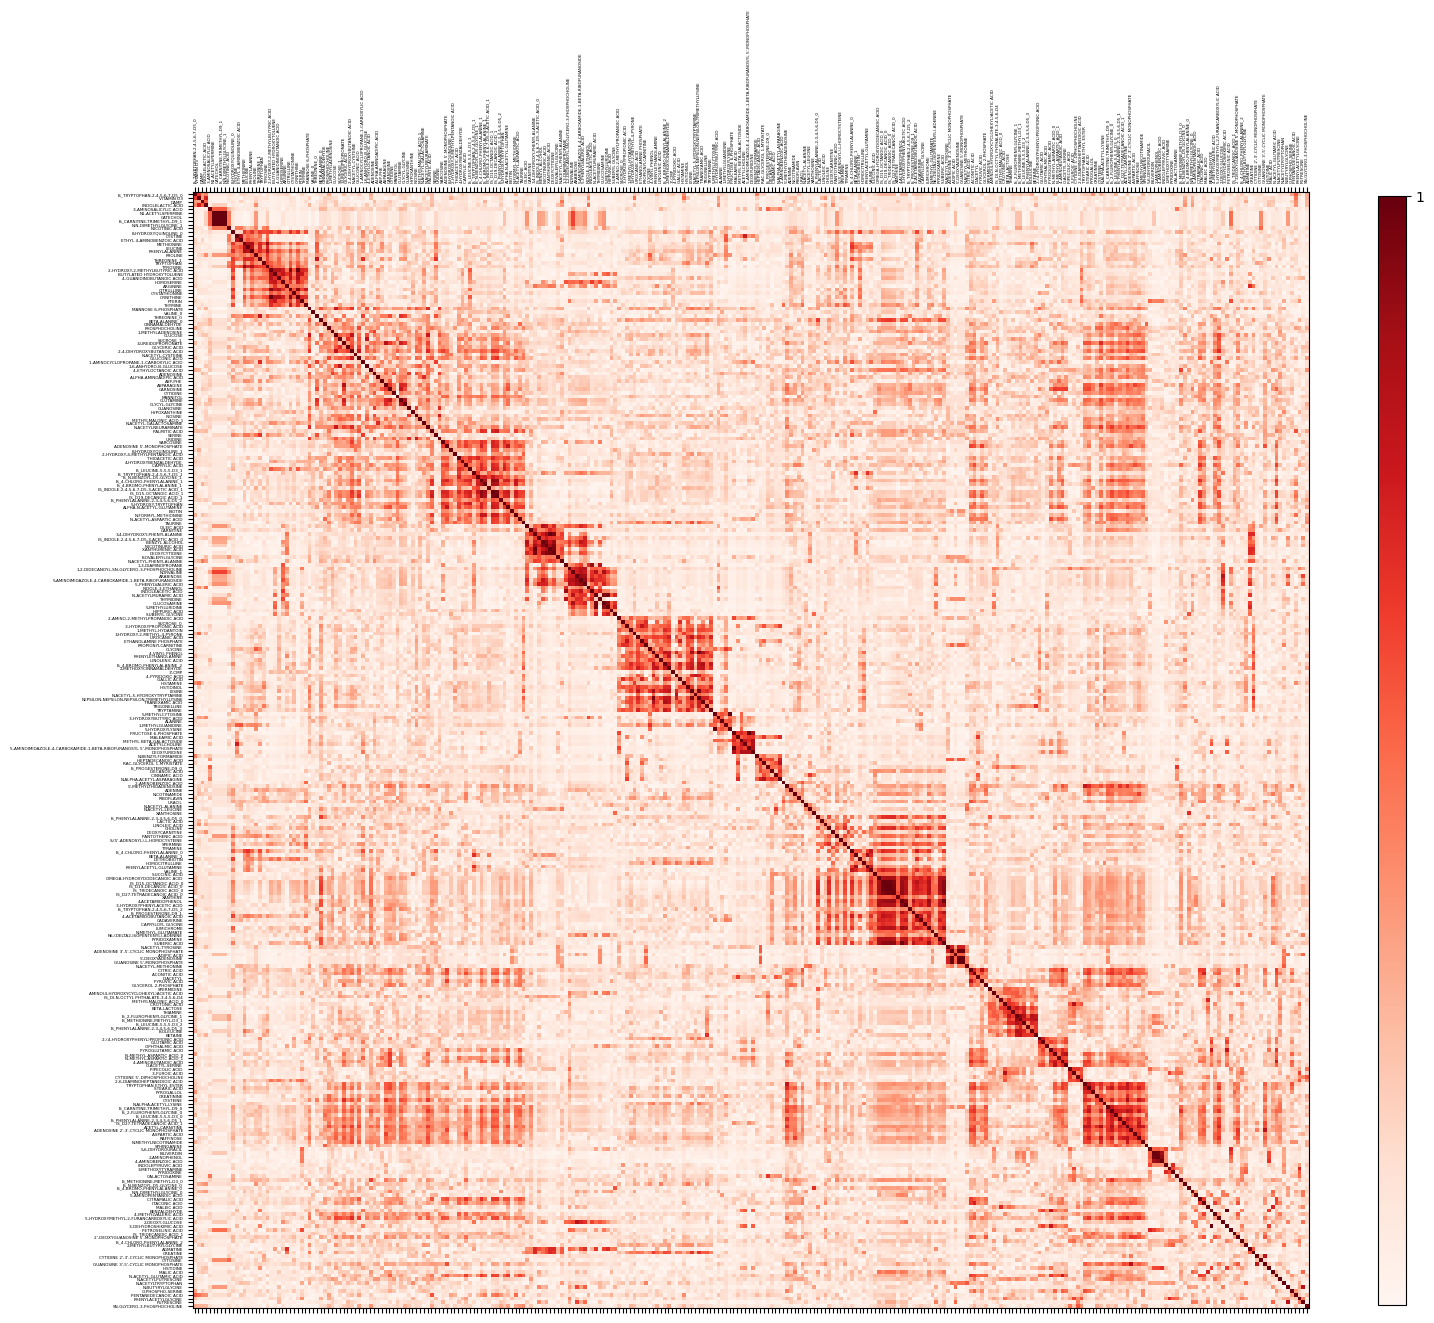

In [1064]:
df_tmp = df_speciesMetab.copy()
df_tmp.columns = metab_names
corr = df_tmp.corr().abs()
corr = corr.iloc[ind, ind]
# corr[corr < 0.4] = 0
fig, ax = plt.subplots(figsize=(18, 18))
#     cax = ax.matshow(corr, cmap='RdYlGn')
cax = ax.matshow(corr, cmap='Reds')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=3);
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=3);

# Add the colorbar legend
cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

In [1065]:
df_metabs_clusters

cluster_labels  cluster_counts  \
0                0               4   
1                1               5   
2                2              11   
3                3              10   
4                4              35   
..             ...             ...   
59              59               1   
60              60               1   
61              61               1   
62              62               1   
63              63               1   

                                    cluster_metab_IDs  \
0                                 [49, 133, 196, 220]   
1                             [25, 36, 121, 135, 248]   
2   [3, 23, 35, 201, 229, 252, 262, 263, 279, 285,...   
3   [15, 103, 157, 173, 176, 187, 190, 256, 264, 281]   
4   [5, 6, 8, 9, 19, 29, 38, 68, 75, 77, 82, 89, 9...   
..                                                ...   
59                                              [254]   
60                                              [259]   
61                                              [261]   
62                                              [265]   
63                                              [273]   

                                   cluser_metab_names  
0   [IS_TRYPTOPHAN-2,4,5,6,7-D5_0, VITAMIN D3, DAM...  
1   [3-AMINOSALICYLIC ACID, N1-ACETYLSPERMINE, CAT...  
2   [NICOTINIC ACID, 8-HYDROXYQUINOLINE_0, CYSTINE...  
3   [2-HYDROXY-2-METHYLBUTYRIC ACID, BUTYLATED HYD...  
4   [MANNOSE 6-PHOSPHATE, VALINE_0, THREONINE_0, B...  
..                                                ...  
59                                 [O-PHOSPHO-SERINE]  
60                             [PENTANEDECANOIC ACID]  
61                              [PHENYLACETYLGLYCINE]  
62                                       [PUTRESCINE]  
63                      [SN-GLYCERO-3-PHOSPHOCHOLINE]  

[64 rows x 4 columns]

In [933]:
metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
metabs_un, counts_ = np.unique(metab_names, return_counts=True)
id_change = np.where(counts_ > 1)[0]
for metab_ in metabs_un[id_change]:
    id_find = np.where(metab_names == metab_)[0]
    count_metab = 0
    for id_ in id_find:
        metab_names[id_] = metab_ + f'_{count_metab}'
        count_metab += 1

In [1043]:
df_tmp = df_speciesMetab.copy()
df_tmp.columns = metab_names
X = np.abs(df_tmp.corr().values)
# X[X < 0.6] = 0
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [df_tmp.columns.tolist()[i] for i in list((np.argsort(ind)))]
df_tmp = df_tmp.reindex(columns, axis=1)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230415_cluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'metabolite_consumption_matrix_correlation_cluster_new.png'))

plot_corr(df_tmp, file_save, size=18)

In [898]:
labels_ = sch.fcluster(L, 0.5*d.max(), 'distance')
labels_ = sch.fcluster(L, t=60, criterion='maxclust')

# Correlation based clustering of metabolites

In [936]:
df_tmp = df_speciesMetab.copy()
df_tmp.columns = metab_names
X = np.abs(df_tmp.corr().values)
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
labels_ = sch.fcluster(L, t=80, criterion='maxclust')

In [966]:
df_speciesMetab

0         1         2         3         4         5         6    \
0   0.00000  0.992959  0.000000  0.000000  0.000000  0.000000  0.014442   
1   0.00000  0.987929  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.00000  0.000000  0.000000  0.000000  0.071749  0.786843  0.000000   
3   0.00000  0.119998  0.000000  0.997475  0.000000  0.175925  0.161736   
4   0.00000  0.402634  0.000000  0.000000  0.000000  0.827697  0.000000   
..      ...       ...       ...       ...       ...       ...       ...   
58  0.00000  0.200966  0.141728  0.000000  0.000000  0.652087  0.050226   
59  0.44559  0.058588  0.000000  0.179604  0.000000  0.361881  0.000000   
60  0.00000  0.000000  0.000000  0.000000  0.938443  0.375303  0.000000   
61  0.00000  0.162898  0.217158  0.000000  0.000000  0.563057  0.000000   
62  0.00000  0.000000  0.000000  0.493556  0.224312  0.000000  0.000000   

         7         8         9    ...       282       283       284       285  \
0   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1   0.000000  0.916520  0.000000  ...  0.000000  0.000000  0.135037  0.000000   
2   0.000000  0.000000  0.813938  ...  0.000000  0.000000  0.283760  0.020476   
3   0.000000  0.141034  0.096047  ...  0.000000  0.181099  0.000000  0.977622   
4   0.000000  0.288069  0.457678  ...  0.000000  0.000000  0.000000  0.000000   
..       ...       ...       ...  ...       ...       ...       ...       ...   
58  0.000000  0.348466  0.348539  ...  0.000000  0.000000  0.000000  0.298522   
59  0.000000  0.130612  0.000373  ...  0.000000  0.000000  0.000000  0.025765   
60  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
61  0.273662  0.079772  0.077823  ...  0.253915  0.043567  0.637154  0.161100   
62  0.000000  0.222897  0.000000  ...  0.000000  0.024133  0.000000  0.043985   

         286       287       288       289       290  291  
0   0.104553  0.000000  0.221836  0.070147  0.000000  0.0  
1   0.143596  0.000000  0.790017  0.000000  0.000000  0.0  
2   0.864645  0.134274  0.960560  0.000000  0.285223  0.0  
3   0.057470  0.405372  0.996726  0.985360  0.036128  0.0  
4   0.000000  0.000000  0.000000  0.949384  0.000000  0.0  
..       ...       ...       ...       ...       ...  ...  
58  0.000000  0.000000  0.000000  0.974129  0.000000  0.0  
59  0.000000  0.039111  0.314827  0.797749  0.000000  0.0  
60  0.000000  0.002837  0.371886  0.932531  0.000000  0.0  
61  0.151394  0.000710  0.532648  0.799041  0.065574  0.0  
62  0.042430  0.184180  0.628580  0.000000  0.000000  0.0  

[63 rows x 292 columns]

In [967]:
scipy.stats.pearsonr(df_speciesMetab.iloc[:, 0], df_speciesMetab.iloc[:, 19])

PearsonRResult(statistic=-0.13894639223011448, pvalue=0.27745834930979574)

In [1059]:
X = df_speciesMetab.copy().T
# def norm_eucl(x):
#     x /= np.sqrt(np.sum(x**2))
#     return x
# X = X.apply(norm_eucl, axis=0)
reducer = umap.UMAP(metric='cosine', n_components=20)
embedding = reducer.fit_transform(X)

0         1         2         3         4         5         6   \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.992959  0.987929  0.000000  0.119998  0.402634  0.378804  0.119747   
2    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.000000  0.000000  0.000000  0.997475  0.000000  0.000000  0.126314   
4    0.000000  0.000000  0.071749  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
287  0.000000  0.000000  0.134274  0.405372  0.000000  0.295192  0.000000   
288  0.221836  0.790017  0.960560  0.996726  0.000000  0.000000  0.000000   
289  0.070147  0.000000  0.000000  0.985360  0.949384  0.905926  0.000000   
290  0.000000  0.000000  0.285223  0.036128  0.000000  0.000000  0.000000   
291  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           7    8         9   ...        53        54        55        56  \
0    0.000000  0.0  0.196962  ...  0.178746  0.151833  0.000000  0.000000   
1    0.378238  0.0  0.281510  ...  0.000000  0.229311  0.000000  0.000000   
2    0.000000  0.0  0.000000  ...  0.000000  0.000000  0.042683  0.000000   
3    0.067343  0.0  0.000000  ...  0.000000  0.000000  0.000000  0.868974   
4    0.000000  0.0  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
..        ...  ...       ...  ...       ...       ...       ...       ...   
287  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.036909  0.992973   
288  0.000000  0.0  0.000000  ...  0.787375  0.000000  0.000000  0.981057   
289  0.876693  0.0  0.774209  ...  0.048257  0.004037  0.000000  0.881707   
290  0.000000  0.0  0.000000  ...  0.000000  0.254068  0.129604  0.061154   
291  0.000000  0.0  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

           57        58        59        60        61        62  
0    0.311805  0.000000  0.445590  0.000000  0.000000  0.000000  
1    0.035029  0.200966  0.058588  0.000000  0.162898  0.000000  
2    0.000000  0.141728  0.000000  0.000000  0.217158  0.000000  
3    0.047560  0.000000  0.179604  0.000000  0.000000  0.493556  
4    0.000000  0.000000  0.000000  0.938443  0.000000  0.224312  
..        ...       ...       ...       ...       ...       ...  
287  0.229067  0.000000  0.039111  0.002837  0.000710  0.184180  
288  0.926560  0.000000  0.314827  0.371886  0.532648  0.628580  
289  0.000000  0.974129  0.797749  0.932531  0.799041  0.000000  
290  0.000000  0.000000  0.000000  0.000000  0.065574  0.000000  
291  0.091500  0.000000  0.000000  0.000000  0.000000  0.000000  

[292 rows x 63 columns]

In [1060]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)

# Perform clustering
cluster_labels = clusterer.fit_predict(embedding)
cluster_labels_new = post_process_hdbscan_clusters(cluster_labels)

clust_labels, clust_counts = np.unique(cluster_labels_new, return_counts=True)
print(clust_labels)
print(clust_counts)

df_metabs_clusters = pd.DataFrame()
df_metabs_clusters["cluster_labels"] = clust_labels
df_metabs_clusters["cluster_counts"] = clust_counts

cluster_metab_IDs = []
cluser_metab_names = []
for label_ in clust_labels:
    id_label = np.where(cluster_labels_new == label_)[0]
    cluster_metab_IDs.append(list(id_label))
    cluser_metab_names.append(list(metab_names[id_label]))  
    
df_metabs_clusters["cluster_metab_IDs"] = cluster_metab_IDs
df_metabs_clusters["cluser_metab_names"] = cluser_metab_names

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230415_cluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'metabolite_cluster_dataframe.csv'))
df_metabs_clusters.to_csv(file_save, index=False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
[ 4  5 11 10 35 22 10 10  4 25  5  6  7  6  3  9  6 19  6  5 13  4  4  4
  3  3 11  5  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


In [1061]:
ind = []
for row_ in range(df_metabs_clusters.shape[0]):
    ind += df_metabs_clusters.iloc[row_, 2]

In [1045]:
metab_names[ind]

array(['3-AMINOSALICYLIC ACID', 'N1-ACETYLSPERMINE', 'CATECHOL',
       'IS_CARNITINE-TRIMETHYL-D9_1', 'N,N-DIMETHYLGLYCINE_1',
       'NICOTINIC ACID', '8-HYDROXYQUINOLINE_0', 'CYSTINE',
       'ETHYL 4-AMINOBENZOIC ACID', 'METHIONINE', 'LEUCINE',
       'PHENYLALANINE', 'PROLINE', 'THREONINE_1', 'TRYPTOPHAN',
       'TYROSINE', 'N-ACETYL-TYROSINE',
       "ADENOSINE 3',5'-CYCLIC MONOPHOSPHATE", 'ADIPIC ACID',
       "5'-DEOXYADENOSINE", "GUANOSINE 5'-MONOPHOSPHATE", 'OLEIC ACID',
       'CARNITINE', '3,4-DIHYDROXY-PHENYLALANINE',
       'IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID_0', 'BENZYL ALCOHOL',
       'NICOTINURIC ACID', 'XANTHURENIC ACID', 'AGMATINE',
       'DEOXYCYTIDINE', 'ISOVALERYLGLYCINE', 'N-ACETYL-PHENYLALANINE',
       '1,3-DIAMINOPROPANE', 'INDOLE-3-ETHANOL', 'INDOLEACETIC ACID',
       'THYMIDINE', '1,2-DIDECANOYL-SN-GLYCERO-3-PHOSPHOCHOLINE',
       'NORVALINE', 'ARABINOSE', '2-DEOXY-GLUCOSE', 'GLUCOSAMINE',
       '5-AMINOIMIDAZOLE-4-CARBOXAMIDE-1-BETA-RIBOFURANOSIDE',

In [1123]:
df_speciesMetab_tmp = df_speciesMetab.copy()
df_speciesMetab_tmp[df_speciesMetab_tmp == 0] = 1e-6
df_speciesMetab_cluster = pd.DataFrame()
for metab_label in range(df_metabs_clusters.shape[0]):
    id_metabs = df_metabs_clusters.iloc[metab_label, 2]
    consm_vec = np.zeros((num_species))
    for id_ in id_metabs:
        consm_vec += np.log10(df_speciesMetab_tmp.iloc[:, id_].values)
    consm_vec /= len(id_metabs)
    df_speciesMetab_cluster[metab_label] = 10**consm_vec

In [1122]:
x = Ri_noMicrocosm_fit_avg[0.2].copy()
rank_x = get_rank(-x)
id_order = np.argsort(rank_x)
df_tmp = pd.DataFrame(data={"cluster" : df_metabs_clusters.iloc[:, 3].values[id_order], \
                            "Ri" : x[id_order]})
df_tmp.iloc[0, 0]

['IS_PHENYLALANINE-2,3,4,5,6-D5_0',
 'LACTIC ACID',
 'LINOLEIC ACID',
 'CHOLINE',
 'DEOXYCARNITINE',
 'PANTOTHENIC ACID',
 "S-(5'-ADENOSYL)-L-HOMOCYSTEINE",
 'SPERMINE',
 'TYRAMINE']

In [1034]:
scipy.stats.pearsonr(df_speciesMetab.iloc[:, 23], df_speciesMetab.iloc[:, 229])

PearsonRResult(statistic=0.645537985636891, pvalue=1.1159933645755098e-08)

In [1029]:
df_speciesMetab.iloc[:, [36, 248]].values

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.

In [914]:
clust_labels, clust_counts = np.unique(labels_, return_counts=True)
print(clust_labels)
print(clust_counts)

df_metabs_clusters = pd.DataFrame()
df_metabs_clusters["cluster_labels"] = clust_labels
df_metabs_clusters["cluster_counts"] = clust_counts

cluster_metab_IDs = []
cluser_metab_names = []
for label_ in clust_labels:
    id_label = np.where(labels_ == label_)[0]
    cluster_metab_IDs.append(list(id_label))
    cluser_metab_names.append(list(metab_names[id_label]))  
    
df_metabs_clusters["cluster_metab_IDs"] = cluster_metab_IDs
df_metabs_clusters["cluser_metab_names"] = cluser_metab_names

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230415_cluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'metabolite_cluster_dataframe.csv'))
df_metabs_clusters.to_csv(file_save, index=False)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80]
[ 3  2  4  6 11  1  8  3  1  4  5  4  4  2  5  2  1  2  3  3  5  2  4  4
  7  4  2  6  5  3  3  2  2  2  1  3  2  1  3  2  1  6  3  2  3  1  2  5
  2  6  2  5  7  5  1  1  3  4  2 13  3  4  2  8  6 10  7  2  1  4  3  4
  4  3  3  4  2  3  5  3]


In [915]:
df_speciesMetab_cluster = pd.DataFrame()
for metab_label in range(df_metabs_clusters.shape[0]):
    id_metabs = df_metabs_clusters.iloc[metab_label, 2]
    consm_vec = np.zeros((num_species))
    for id_ in id_metabs:
        consm_vec += (df_speciesMetab.iloc[:, id_].values)
    consm_vec /= len(id_metabs)
    df_speciesMetab_cluster[metab_label] = consm_vec

In [921]:
df_metabs_clusters.iloc[3, 2]

[2, 7, 11, 22, 32, 204]

In [924]:
scipy.stats.pearsonr(df_speciesMetab.iloc[:, 2], df_speciesMetab.iloc[:, 22])

PearsonRResult(statistic=0.41954827011123585, pvalue=0.0006198625903225269)

In [970]:
reducer = umap.UMAP(metric='correlation', n_components=5)
embedding = reducer.fit_transform(np_speciesMetab_corr)

In [971]:
df_speciesMetab_copy = df_speciesMetab.copy()
df_speciesMetab_copy[df_speciesMetab_copy == 0] = 1e-6
reducer = umap.UMAP(metric='correlation', n_components=5)
embedding = reducer.fit_transform(np.array(df_speciesMetab.T.copy()))

In [972]:
embedding.shape

(292, 5)

In [940]:
def post_process_hdbscan_clusters(cluster_labels):
    clust_labels, clust_counts = np.unique(cluster_labels, return_counts=True)
    cluster_labels_new = np.zeros((len(cluster_labels)))

    for label_ in clust_labels:
        if label_ >= 0:
            cluster_labels_new[cluster_labels == label_] = label_
        else:
            len_labels = len(cluster_labels[cluster_labels == label_])
            cluster_labels_new[cluster_labels == label_] = \
                np.arange(len(clust_labels) - 1, len(clust_labels) - 1 + len_labels)
    return cluster_labels_new.astype(int)

In [974]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)

# Perform clustering
cluster_labels = clusterer.fit_predict(embedding)
cluster_labels
clust_labels, clust_counts = np.unique(cluster_labels, return_counts=True)
print(clust_labels)
print(clust_counts)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[24 96  5  7 22  9 26  5  3 14  7 12 15  5  4  5  5 18  2  5  3]


In [975]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)

# Perform clustering
cluster_labels = clusterer.fit_predict(embedding)
cluster_labels_new = post_process_hdbscan_clusters(cluster_labels)

clust_labels, clust_counts = np.unique(cluster_labels_new, return_counts=True)
print(clust_labels)
print(clust_counts)

df_metabs_clusters = pd.DataFrame()
df_metabs_clusters["cluster_labels"] = clust_labels
df_metabs_clusters["cluster_counts"] = clust_counts

cluster_metab_IDs = []
cluser_metab_names = []
for label_ in clust_labels:
    id_label = np.where(cluster_labels_new == label_)[0]
    cluster_metab_IDs.append(list(id_label))
    cluser_metab_names.append(list(metab_names[id_label]))  
    
df_metabs_clusters["cluster_metab_IDs"] = cluster_metab_IDs
df_metabs_clusters["cluser_metab_names"] = cluser_metab_names

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230415_cluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'metabolite_cluster_dataframe.csv'))
df_metabs_clusters.to_csv(file_save, index=False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
[96  5  7 22  9 26  5  3 14  7 12 15  5  4  5  5 18  2  5  3  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


In [766]:
kmeans = KMeans(n_clusters=60, random_state=0, n_init="auto").fit(embedding)
clust_labels, clust_counts = np.unique(kmeans.labels_, return_counts=True)
print(clust_labels)
print(clust_counts)

df_metabs_clusters = pd.DataFrame()
df_metabs_clusters["cluster_labels"] = clust_labels
df_metabs_clusters["cluster_counts"] = clust_counts

cluster_metab_IDs = []
cluser_metab_names = []
for label_ in clust_labels:
    id_label = np.where(kmeans.labels_ == label_)[0]
    cluster_metab_IDs.append(list(id_label))
    cluser_metab_names.append(list(metab_names[id_label]))  
    
df_metabs_clusters["cluster_metab_IDs"] = cluster_metab_IDs
df_metabs_clusters["cluser_metab_names"] = cluser_metab_names

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230415_cluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'metabolite_cluster_dataframe.csv'))
df_metabs_clusters.to_csv(file_save, index=False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
[10  3  1 11  2 12  4  5  4  7  6  8  4  7  6  5  2 14  4  5  6  2  8  3
  5  6  5  5  6  6  9  2  7  3  3  7  7  2  1  2  2  9  1  4  1  4  4  6
  4  4  8  1  2  6  7  3  4  4  2  1]


In [901]:
id_m = df_metabs_clusters.iloc[1, 2]
# len(np.where(df_speciesMetab.iloc[:, id_m[6]].values != 0)[0])
df_speciesMetab.iloc[:, id_m]

17        50        119       131       213       270
0   0.000000  0.048651  0.000000  0.000000  0.000000  0.541700
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.233794
2   0.000000  0.061078  0.193252  0.000000  0.113210  0.674980
3   0.000000  0.088309  0.000000  0.000000  0.093792  0.644668
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
..       ...       ...       ...       ...       ...       ...
58  0.283382  0.031120  0.000000  0.000000  0.489209  0.406789
59  0.034938  0.035237  0.061361  0.476733  0.000000  0.504445
60  0.055039  0.000000  0.000000  0.000000  0.000000  0.552941
61  0.112073  0.000000  0.000000  0.000000  0.168214  0.288126
62  0.000000  0.000000  0.680378  0.000000  0.000000  0.063001

[63 rows x 6 columns]

In [976]:
df_speciesMetab_cluster = pd.DataFrame()
for metab_label in range(df_metabs_clusters.shape[0]):
    id_metabs = df_metabs_clusters.iloc[metab_label, 2]
    consm_vec = np.zeros((num_species))
    for id_ in id_metabs:
        consm_vec += (df_speciesMetab.iloc[:, id_].values)
    consm_vec /= len(id_metabs)
    df_speciesMetab_cluster[metab_label] = consm_vec

In [843]:
df_speciesMetab_cluster

0         1         2         3         4         5         6   \
0   0.009863  0.078046  0.117768  0.065278  0.048178  0.000000  0.004378   
1   0.008544  0.196433  0.440766  0.098459  0.081511  0.117878  0.000000   
2   0.000000  0.079077  0.921776  0.615241  0.052337  0.000000  0.007285   
3   0.223663  0.115749  0.656588  0.076935  0.019411  0.000000  0.026956   
4   0.000000  0.024654  0.000000  0.012044  0.029396  0.000000  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
58  0.000000  0.059870  0.332385  0.147110  0.018729  0.023621  0.008371   
59  0.063401  0.036322  0.248125  0.081368  0.282111  0.061071  0.004490   
60  0.000937  0.030272  0.430257  0.073443  0.015900  0.000000  0.048521   
61  0.000000  0.090585  0.565000  0.093418  0.000000  0.036193  0.084091   
62  0.084851  0.103048  0.360465  0.146604  0.000000  0.031993  0.303684   

          7         8         9   ...        33        34        35        36  \
0   0.112368  0.030553  0.334673  ...  0.944532  0.877873  0.000000  0.010202   
1   0.000000  0.015188  0.483322  ...  0.943414  0.827352  0.974431  0.188126   
2   0.022387  0.059881  0.062605  ...  0.000000  0.000000  0.000000  0.888675   
3   0.087673  0.056215  0.001423  ...  0.000000  0.185081  0.039047  0.997477   
4   0.000000  0.000000  0.024536  ...  0.446385  0.499890  0.000000  0.545486   
..       ...       ...       ...  ...       ...       ...       ...       ...   
58  0.257898  0.059998  0.010134  ...  0.413688  0.376793  0.000000  0.994718   
59  0.002770  0.054161  0.003497  ...  0.043672  0.177687  0.005930  0.000000   
60  0.000000  0.032155  0.007349  ...  0.000000  0.130006  0.000000  0.000000   
61  0.000000  0.195065  0.074305  ...  0.008384  0.154128  0.000000  0.000000   
62  0.059481  0.037685  0.007339  ...  0.089229  0.170774  0.090146  0.372419   

          37        38        39        40        41   42  
0   0.000000  0.407386  0.010888  0.000000  0.054269  0.0  
1   0.000000  0.000000  0.000000  0.105833  0.000000  0.0  
2   0.000000  0.365561  0.000000  0.077813  0.000000  0.0  
3   0.000000  0.422430  0.000000  0.000000  0.000000  0.0  
4   0.000000  0.312231  0.000000  0.000000  0.000000  0.0  
..       ...       ...       ...       ...       ...  ...  
58  0.000000  0.000000  0.018884  0.000000  0.228403  0.0  
59  0.069788  0.020787  0.000000  0.000000  0.000000  0.0  
60  0.000000  0.140632  0.000000  0.000000  0.000000  0.0  
61  0.160615  0.000000  0.093238  0.000000  0.175359  0.0  
62  0.000000  0.000000  0.033703  0.025903  0.000000  0.0  

[63 rows x 43 columns]

In [977]:
df_metabs_clusters

cluster_labels  cluster_counts  \
0                0              96   
1                1               5   
2                2               7   
3                3              22   
4                4               9   
5                5              26   
6                6               5   
7                7               3   
8                8              14   
9                9               7   
10              10              12   
11              11              15   
12              12               5   
13              13               4   
14              14               5   
15              15               5   
16              16              18   
17              17               2   
18              18               5   
19              19               3   
20              20               1   
21              21               1   
22              22               1   
23              23               1   
24              24               1   
25              25               1   
26              26               1   
27              27               1   
28              28               1   
29              29               1   
30              30               1   
31              31               1   
32              32               1   
33              33               1   
34              34               1   
35              35               1   
36              36               1   
37              37               1   
38              38               1   
39              39               1   
40              40               1   
41              41               1   
42              42               1   
43              43               1   

                                    cluster_metab_IDs  \
0   [1, 5, 19, 27, 29, 34, 38, 39, 43, 44, 45, 46,...   
1                            [49, 133, 196, 220, 259]   
2                     [3, 25, 36, 121, 135, 195, 248]   
3   [8, 15, 23, 103, 144, 157, 173, 176, 187, 190,...   
4              [20, 37, 40, 55, 79, 86, 98, 186, 243]   
5   [7, 11, 13, 17, 21, 22, 32, 50, 119, 122, 123,...   
6                             [33, 41, 124, 165, 211]   
7                                     [232, 236, 237]   
8   [24, 28, 57, 70, 73, 80, 106, 130, 136, 137, 1...   
9                  [51, 118, 197, 216, 260, 286, 290]   
10  [4, 26, 30, 53, 84, 99, 102, 171, 188, 198, 22...   
11  [10, 42, 88, 93, 96, 129, 159, 163, 164, 212, ...   
12                           [61, 100, 125, 160, 199]   
13                                 [16, 60, 120, 162]   
14                          [104, 185, 258, 271, 274]   
15                            [18, 85, 140, 194, 224]   
16  [9, 31, 47, 54, 56, 58, 59, 94, 127, 128, 139,...   
17                                         [166, 251]   
18                           [12, 134, 148, 154, 221]   
19                                    [151, 261, 267]   
20                                                [0]   
21                                                [2]   
22                                                [6]   
23                                               [14]   
24                                               [35]   
25                                               [52]   
26                                               [63]   
27                                               [64]   
28                                              [105]   
29                                              [145]   
30                                              [147]   
31                                              [150]   
32                                              [153]   
33                                              [168]   
34                                              [182]   
35                                              [200]   
36                                              [214]   
37                                              [227]   
38                                              [242]   
39           

In [979]:
scipy.stats.pearsonr(df_speciesMetab.iloc[:, 1], df_speciesMetab.iloc[:, 19])

PearsonRResult(statistic=0.15993557941978653, pvalue=0.2105309504816961)

In [491]:
kmeans = KMeans(n_clusters=150, random_state=0, n_init="auto").fit(df_speciesMetab.T)
clust_labels, clust_counts = np.unique(kmeans.labels_, return_counts=True)
print(clust_labels)
print(clust_counts)

df_metabs_clusters = pd.DataFrame()
df_metabs_clusters["cluster_labels"] = clust_labels
df_metabs_clusters["cluster_counts"] = clust_counts

cluster_metab_IDs = []
cluser_metab_names = []
for label_ in clust_labels:
    id_label = np.where(kmeans.labels_ == label_)[0]
    cluster_metab_IDs.append(list(id_label))
    cluser_metab_names.append(list(metab_names[id_label]))  
    
df_metabs_clusters["cluster_metab_IDs"] = cluster_metab_IDs
df_metabs_clusters["cluser_metab_names"] = cluser_metab_names

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230415_cluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'metabolite_cluster_dataframe.csv'))
df_metabs_clusters.to_csv(file_save, index=False)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
[ 1  5  1  2  1  4  1  1  1  1  1  1  2  2  1  1  4  1  2  1  1  2  1  2
  1  1  1  1  2  1  1  1  1  1  6  1  1  1 10  1  1  1  1  1  1  1  1 67
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  5  1  1  1  1  1  1  1  1  1  7  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  5  7  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 

In [532]:
id_singlet = np.where(df_metabs_clusters["cluster_counts"].values == 1)[0]
df_metabs_clusters["cluser_metab_names"].values[id_singlet]

array([list(['ARGININE'])], dtype=object)

In [637]:
df_metabs_clusters

cluster_labels  cluster_counts              cluster_metab_IDs  \
0                0               5       [57, 136, 137, 138, 172]   
1                1               1                          [175]   
2                2               6  [16, 135, 162, 163, 196, 291]   
3                3               4            [23, 263, 285, 287]   
4                4               2                     [232, 236]   
..             ...             ...                            ...   
95              95               1                            [9]   
96              96               1                           [87]   
97              97               1                           [35]   
98              98               2                     [188, 226]   
99              99               2                     [140, 221]   

                                   cluser_metab_names  
0   [IS_DI-N-OCTYL PHTHALATE-3,4,5,6-D4, IS_2-FLUR...  
1                          [ALPHA-N-ACETYL-GLUTAMINE]  
2   [5-METHYLCYTOSINE, IS_CARNITINE-TRIMETHYL-D9, ...  
3   [8-HYDROXYQUINOLINE, PROLINE, TRYPTOPHAN, TYRO...  
4                [N-ACETYL-ALANINE, N-ACETYL-LEUCINE]  
..                                                ...  
95                                     [BETA-ALANINE]  
96                             [4-METHYLVALERIC ACID]  
97                                          [CYSTINE]  
98                                 [CREATINE, LYSINE]  
99    [IS_4-CHLORO-PHENYLALANINE, INDOLEPYRUVIC ACID]  

[100 rows x 4 columns]

In [638]:
df_speciesMetab_copy = df_speciesMetab.copy()
df_speciesMetab_copy[df_speciesMetab_copy == 0] = 1e-6
df_speciesMetab_cluster = pd.DataFrame()
for metab_label in range(df_metabs_clusters.shape[0]):
    id_metabs = df_metabs_clusters.iloc[metab_label, 2]
    consm_vec = np.zeros((num_species))
    for id_ in id_metabs:
        consm_vec += np.log10(df_speciesMetab_copy.iloc[:, id_].values)
    consm_vec /= len(id_metabs)
    df_speciesMetab_cluster[metab_label] = 10**consm_vec

In [496]:
metab_label

149

In [681]:
x = np.array(df_speciesMetab.copy())


1.5575e-05

# 16 April 2023: For no microcosm fit steady state Ri with clustered metabolite consuption matrix

In [670]:
df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
num_species_tmp = df_speciesAbun_prev.shape[0]

sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
count_ = 0 
p_tmp = 1e-6
for sample_ in sample_names_split:
    pass_ = int(sample_.split("_")[0][1])

    p_tmp_new = p_tmp

    _, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab_cluster.copy(), df_speciesAbun_prev_tmp.copy(), \
                             df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
    if pass_ > -1:
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        if count_ == 0:
            A_train = A_train_sample
            count_ += 1
        else:
            A_train = np.vstack((A_train, A_train_sample))
b_train = np.ones((A_train.shape[0]))
# coeff_train_ = nnls(A_train, b_train.flatten())[0]

In [671]:
df_A = pd.DataFrame(data=A_train)

In [672]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_A.columns
vif_data["VIF"] = [variance_inflation_factor(df_A.values, i) for i in range(len(df_A.columns))]

In [673]:
vif_data

feature        VIF
0         0   8.279250
1         1  33.874544
2         2  30.091407
3         3   8.836940
4         4   7.155548
5         5  23.506880
6         6  10.749597
7         7  18.962005
8         8   2.399255
9         9   2.117624
10       10   3.769284
11       11   9.373767
12       12   5.728444
13       13   3.914238
14       14  12.627004
15       15  36.931460
16       16   6.986040
17       17   6.423099
18       18   4.496569
19       19   3.751139
20       20  22.014352
21       21  22.267083
22       22  11.639994
23       23   6.421916
24       24  22.411470
25       25   3.176484
26       26  17.369114
27       27  22.945512
28       28   5.431310
29       29  11.136236
30       30  22.185508
31       31   4.378197
32       32  19.190357
33       33  11.688031
34       34   7.574754
35       35   2.773662
36       36   9.449816
37       37  11.673954
38       38  15.530883
39       39  10.704623
40       40   4.841710
41       41   5.025122
42       42  34.336330
43       43  20.712951
44       44   7.769377
45       45   2.994736
46       46   4.247951
47       47   3.925972
48       48  17.152933
49       49  20.102678
50       50  18.234814
51       51  13.283154
52       52   8.320770
53       53  11.681553
54       54  15.147823
55       55   6.113451
56       56   1.838036
57       57   6.061620
58       58  23.880117
59       59   5.944701

In [674]:
id_vif = np.where(vif_data["VIF"].values < 5)[0]
id_vif

array([ 8,  9, 10, 13, 18, 19, 25, 31, 35, 40, 45, 46, 47, 56])

In [599]:
df_speciesMetab_cluster_new = df_speciesMetab_cluster.copy().iloc[:, :]
df_speciesMetab_cluster_new

0         1         2         3         4         5         6   \
0   0.000000  0.150276  0.000000  0.081962  0.010888  0.168097  0.644484   
1   0.099532  0.038914  0.000000  0.192331  0.000000  0.078801  0.625219   
2   0.021359  0.000000  0.000000  0.757099  0.000000  0.081096  0.185100   
3   0.473461  0.005627  0.000000  0.000000  0.000000  0.082948  0.000000   
4   0.000000  0.645263  0.000000  0.000000  0.000000  0.166540  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
58  0.002857  0.505163  0.000000  0.400131  0.018884  0.036115  0.000000   
59  0.130515  0.111411  0.000000  0.234611  0.000000  0.029656  0.005113   
60  0.127233  0.032426  0.000000  0.015638  0.000000  0.017579  0.025723   
61  0.042048  0.229290  0.000000  0.056105  0.093238  0.023180  0.056998   
62  0.113159  0.000000  0.006051  0.411732  0.033703  0.002177  0.016804   

          7         8         9   ...        50        51        52        53  \
0   0.000000  0.154602  0.213628  ...  0.013499  0.050990  0.000000  0.000000   
1   0.026458  0.010170  0.227989  ...  0.034012  0.032247  0.167259  0.000000   
2   0.019453  0.144262  0.165551  ...  0.775937  0.028719  0.130004  0.159586   
3   0.000000  0.270754  0.245518  ...  0.008462  0.000000  0.000000  0.101896   
4   0.000000  0.000000  0.294096  ...  0.000000  0.130035  0.642486  0.000000   
..       ...       ...       ...  ...       ...       ...       ...       ...   
58  0.049789  0.098827  0.392647  ...  0.078660  0.042435  0.023468  0.036511   
59  0.005215  0.030816  0.000000  ...  0.012658  0.074310  0.013964  0.031540   
60  0.043945  0.010817  0.000000  ...  0.019921  0.139289  0.063388  0.033210   
61  0.069983  0.190645  0.054291  ...  0.081085  0.084741  0.094569  0.000000   
62  0.013436  0.267228  0.275354  ...  0.248991  0.000000  0.062563  0.011600   

          54        55        56   57        58        59  
0   0.911202  0.110429  0.622496  0.0  0.921969  0.000000  
1   0.885383  0.114446  0.498045  0.0  0.085954  0.024400  
2   0.000000  0.087024  0.000000  0.0  0.979404  0.050095  
3   0.092541  0.018853  0.000000  0.0  0.533660  0.000000  
4   0.473138  0.000000  0.563907  0.0  0.000000  0.000000  
..       ...       ...       ...  ...       ...       ...  
58  0.395240  0.029283  0.105748  0.0  0.000000  0.000000  
59  0.110680  0.014117  0.099607  0.0  0.988271  0.000000  
60  0.065003  0.014762  0.035296  0.0  0.000000  0.059511  
61  0.081256  0.360061  0.055239  0.0  0.952564  0.032184  
62  0.130001  0.218270  0.016021  0.0  0.707963  0.002747  

[63 rows x 60 columns]

In [1140]:
def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                       ratio_means_, df_speciesMetab, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [1130]:
# Fit using no-microcosm agar
passages_exclude = [[], [0], [0, 1]]
num_passages = 6
p_tmp = 0
Ri_noMicrocosm_fit_all = {}
Ri_noMicrocosm_fit_avg = {}
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
num_metabs = df_speciesMetab_tmp.shape[1]
for count_p, pass_rm in enumerate(passages_exclude):
    print(f'count_p = {count_p}, pass_rmp = {pass_rm}')
    pass_ex_list = []
    for pass_ in pass_rm:
        pass_ex_list += [pass_, pass_ + num_passages, pass_ + 2 * num_passages]
    pass_keep = list(set(range(df_speciesAbun.shape[1])) - set(pass_ex_list))
    df_speciesAbun_tmp = df_speciesAbun.copy().iloc[:, pass_keep]
    
    Ri_noMicrocosm_fit_all[count_p] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_fit_avg[count_p] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_fit_all[count_p][species_, :] = compute_Ri_ss(df_speciesMetab_tmp.copy(), \
                                                                     df_speciesAbun_tmp.copy(), \
                                                                     df_speciesAbun_tmp.copy(), \
                                                                     0, \
                                                                     id_species)
        Ri_noMicrocosm_fit_avg[count_p] += Ri_noMicrocosm_fit_all[count_p][species_, :]
        
    Ri_noMicrocosm_fit_avg[count_p] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'20230416_predict_abundance_blind_noMicrocosm_Ri_fit_steadyState' + \
                                        f'_cluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230416_Ri_fit_steadyState_noMicrocosm_LeaveOneOutRi' + \
                                         f'_cluster_metabolites.pickle'))

save_obj = {"Ri_noMicrocosm_fit_all" : Ri_noMicrocosm_fit_all, \
            "Ri_noMicrocosm_fit_avg" : Ri_noMicrocosm_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, pass_rmp = []
count_p = 1, pass_rmp = [0]
count_p = 2, pass_rmp = [0, 1]


In [512]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        f'20230416_predict_abundance_blind_noMicrocosm_Ri_fit_steadyState' + \
                                        f'_cluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230416_Ri_fit_steadyState_' + \
                                         'noMicrocosm_LeaveOneOutRi_cluster_metabolites.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

/tmp/ipykernel_5598/2926291921.py:128: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y[id_])
/tmp/ipykernel_5598/2926291921.py:128: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y[id_])
/tmp/ipykernel_5598/2926291921.py:128: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y[id_])
/tmp/ipykernel_5598/2926291921.py:128: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y[id_])
/tmp/ipykernel_5598/2926291921.py:128: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y[id_])
/tmp/ipykernel_5598/2926291921.py:128: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y[id_])
/tmp/ipykernel_5598/2926291921.py:128: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y[id_])
/tmp/ipykernel_5598/2926291921.py:128: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y[id_])
/tmp/ipykernel_5598/2926291921.py:128: RuntimeWarning: divide by zero encountered in log

KeyboardInterrupt: 

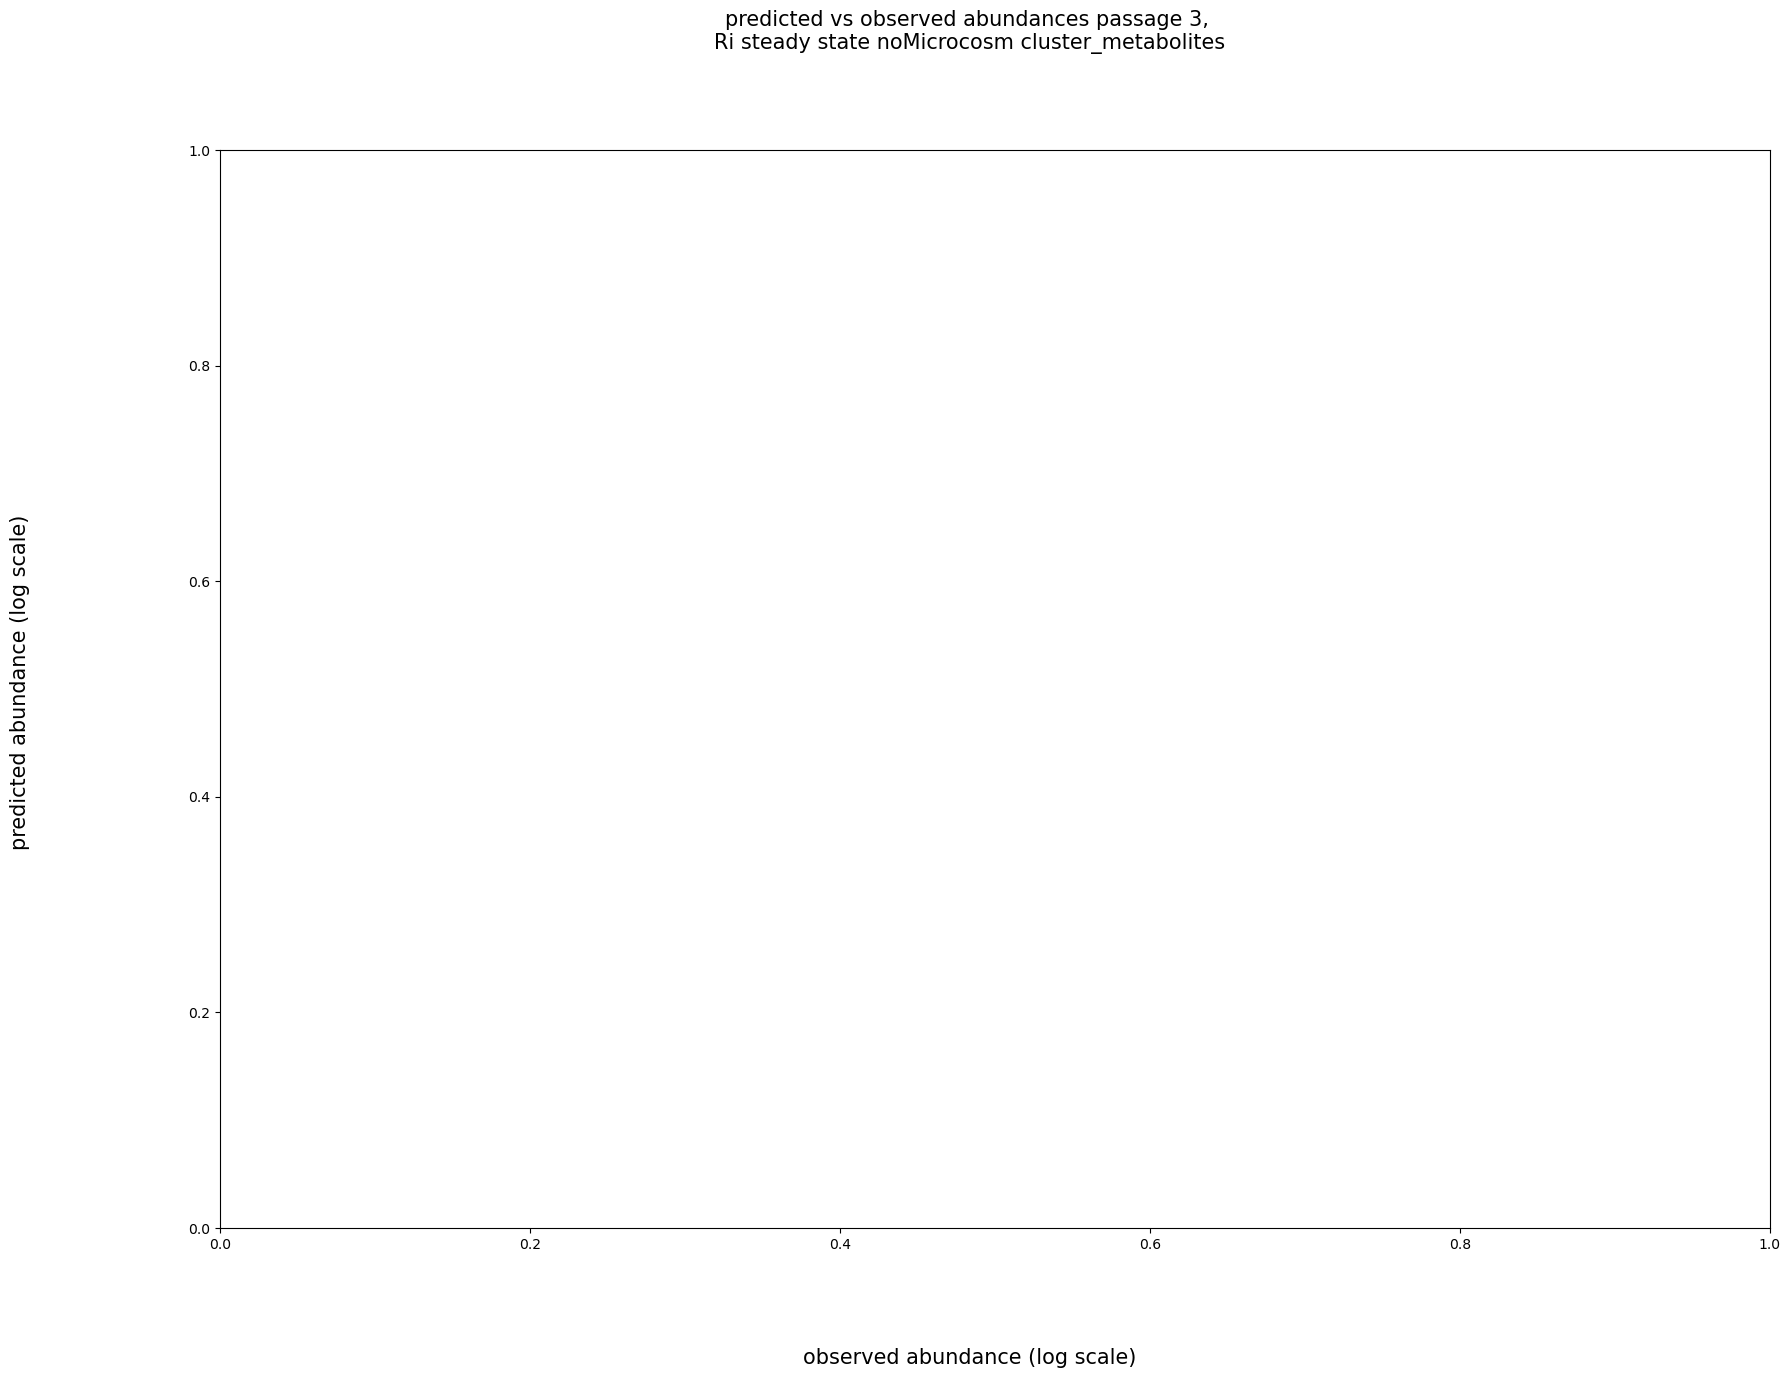

In [1145]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
                    fac_ = 1 / np.sum(df_speciesAbun_prev_tmp_[col_].values)
                    df_speciesAbun_prev_tmp_[col_] = fac_ * \
                        df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_fit_avg[2].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri steady state noMicrocosm cluster_metabolites', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                        df_speciesAbun_next_tmp_.copy(), \
                                                                        p_tmp, Ri_avg.copy(), \
                                                                        growth_rate_all[iter_id].copy(), \
                                                                        None, df_speciesMetab_tmp, 
                                                                        norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230416_predict_abundance_blind_noMicrocosm' + \
                                                    '_Ri_fit_steadyState_cluster_metabolites', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_steadyState_p{p_tmp}' + \
                                                     f'_cluster_metabolites.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values
                if pass_ == 100:
                    fac_ = 1 / np.sum(df_tmp[col_].values)
                    df_tmp[col_] = fac_ * \
                        df_tmp[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230416_predict_abundance_blind_noMicrocosm' + \
                                                    '_Ri_fit_steadyState_cluster_metabolites', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230416_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_steadyState_p{p_tmp}_{norm_status}_noMicrocosm' + \
                                                     f'_cluster_metabolites.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


<Axes: >

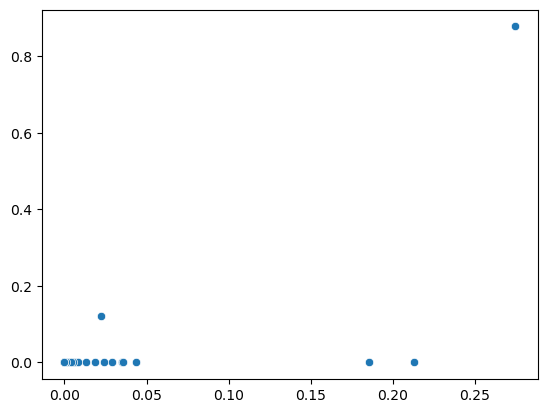

In [1139]:
scipy.stats.pearsonr(10**x, 10**y)
sns.scatterplot(x=10**x, y=10**y)

In [1138]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230416_predict_abundance_blind_noMicrocosm' + \
                                                '_Ri_fit_steadyState_cluster_metabolites', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230416_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'_Ri_fit_steadyState_noMicrocosm_cluster_metabolites.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

In [544]:
# Ri_avg = Ri_noMicrocosm_fit_avg[2].copy()
Ri_avg = Ri_noMicrocosm_fit_avg[0.2].copy()
id_nnz = np.where(Ri_avg > 1e-8)[0]
id_sort = np.argsort(-Ri_avg)
df_metabs_clusters.iloc[id_sort[range(20)], 3].values

array([list(['2-(4-HYDROXYPHENYL)PROPIONIC ACID', '5-AMINOPENTANOIC ACID', 'BENZALDEHYDE', '3-DEHYDROSHIKIMIC ACID', 'GLUTAMIC ACID', 'OPHTHALMIC ACID', 'PYROGLUTAMIC ACID']),
       list(['IS_CARNITINE-TRIMETHYL-D9_0', "2'-DEOXYGUANOSINE 5'-MONOPHOSPHATE", "ADENOSINE 2',3'-CYCLIC MONOPHOSPHATE", 'ASPARTIC ACID', "CYTIDINE 2',3'-CYCLIC MONOPHOSPHATE", 'GLYCEROL 2-PHOSPHATE', "GUANOSINE 3',5'-CYCLIC MONOPHOSPHATE"]),
       list(['GALACTOSAMINE', '3-FUROIC ACID', 'IS_4-CHLORO-PHENYLALANINE_2', '3-METHOXYTYRAMINE', 'PHENYLACETYLGLYCINE', 'PYRIDOXINE']),
       list(['LINOLEIC ACID', 'CHOLINE', 'PANTOTHENIC ACID', "S-(5'-ADENOSYL)-L-HOMOCYSTEINE", 'SPERMINE']),
       list(['CINNAMALDEHYDE', 'IS_LEUCINE-5,5,5-D3_0', 'SPHINGANINE']),
       list(['GLUCOSE', 'SUCROSE_1', 'GLYCERIC ACID', '2,4-DIHYDROXYBUTANOIC ACID', 'GLUCONIC ACID', '1,6-ANHYDRO-B-GLUCOSE', 'N-ACETYLNEURAMINATE']),
       list(['ALPHA-AMINOADIPIC ACID', 'HYPOXANTHINE', 'METHYLMALONIC ACID_1', 'N-ACETYL-GALACTOSAMINE']),
  

# 16 April 2023: For no microcosm fit Ri dynamic (all passages) with clustered metabolite consuption matrix

In [1073]:
def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                       ratio_means_, df_speciesMetab, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio


def compute_growth_ratio_iterate(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, df_speciesMetab, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [1124]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
Ri_noMicrocosm_fit_all = {}
Ri_noMicrocosm_fit_avg = {}
num_metabs = df_speciesMetab_cluster.shape[1]
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_fit_avg[p_tmp] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab_cluster.copy(), \
                                                                df_speciesAbun_prev.copy(), \
                                                                df_speciesAbun_next.copy(), \
                                                                df_speciesAbun_ratio.copy(), \
                                                                p_tmp, num_passages, \
                                                              id_species)
        Ri_noMicrocosm_fit_avg[p_tmp] += Ri_noMicrocosm_fit_all[p_tmp][species_, :]
        
    Ri_noMicrocosm_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230416_predict_abundance_blind_noMicrocosm_Ri_fit_dynamic_' + \
                                        'all_passages_cluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230416_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm_cluster_metabolites.pickle'))

save_obj = {"Ri_noMicrocosm_fit_all" : Ri_noMicrocosm_fit_all, \
            "Ri_noMicrocosm_fit_avg" : Ri_noMicrocosm_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.4
count_p = 11, p = 0.5
count_p = 12, p = 0.55
count_p = 13, p = 0.6
count_p = 14, p = 0.65
count_p = 15, p = 0.7


In [1147]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230416_predict_abundance_blind_noMicrocosm_Ri_fit_dynamic_' + \
                                        'all_passages_cluster_metabolites'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230416_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm_cluster_metabolites.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

In [642]:
def Ri_clust_to_all(Ri_clust, df_metabs_clusters, num_metabs):
    Ri_all = np.zeros((num_metabs))
    for label_ in range(len(Ri_clust)):
        id_metabs = df_metabs_clusters.iloc[label_, 2]
        Ri_all[id_metabs] = Ri_clust[label_]
    return Ri_all

In [612]:
Ri_new = Ri_clust_to_all(Ri_avg, df_metabs_clusters, df_speciesMetab.shape[1])

In [1148]:
p_vec_new = list(Ri_noMicrocosm_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
                    fac_ = 1 / np.sum(df_speciesAbun_prev_tmp_[col_].values)
                    df_speciesAbun_prev_tmp_[col_] = fac_ * \
                        df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()
#             Ri_avg = Ri_clust_to_all(Ri_noMicrocosm_fit_avg[p_tmp].copy(), \
#                                      df_metabs_clusters, df_speciesMetab.shape[1]) 
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri dynamical all passages noMicrocosm cluster_metabolites', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, df_speciesMetab_tmp,
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230416_predict_abundance_blind_noMicrocosm_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    'all_passages_cluster_metabolites', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_dynamical' + \
                                                     f'_with_p{p_tmp}_cluster_metabolites.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values
                fac_ = 1 / np.sum(df_tmp[col_].values)
                df_tmp[col_] = fac_ * \
                    df_tmp[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where((x > 0) & (y > 0))[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230416_predict_abundance_blind_noMicrocosm_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    'all_passages_cluster_metabolites', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230416_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_dynamic_all_passages' + \
                                                     f'_p{p_tmp}_{norm_status}_noMicrocosm' + \
                                                     f'_cluster_metabolites.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [1149]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230416_predict_abundance_blind_noMicrocosm_' + \
                                                'Ri_fit_dynamic_' + \
                                                'all_passages_cluster_metabolites', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230416_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme_noMicrocosm' + \
                                             f'_Ri_fit_dynamic_all_passages_cluster_metabolites.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

In [1125]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
p_vec_new = list(Ri_noMicrocosm_fit_avg.keys())
# predicted_growth_ratios = {}
# range(num_passages - 1)

df_speciesMetab_tmp = df_speciesMetab_cluster.copy()
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for pass_ in [0]:
#         predicted_growth_ratios[norm_status][pass_] = {}
#         growth_rate_all = np.zeros((num_iter, num_species))
        df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

#         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
#                                     "passage" : [], 
#                                     "p" : [], 
#                                     "corr_pe" : [], 
#                                     "corr_pe_log" : [], 
#                                     "corr_sp" : [], 
#                                     "slope" : [], 
#                                     "corr_pe_pval" : [], 
#                                     "corr_pe_log_pval" : [], 
#                                     "corr_sp_pval" : [], 
#                                     "slope_pval" : []})
        df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})
    
        df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})

        for count_p, p_tmp in enumerate(p_vec_new):
            if count_p <= 200:
#         for i_ in range(10):
#             count_p = 0 + (i_) * 10
#             p_tmp = p_vec_new[count_p]
                growth_rate_all = {}
                growth_rate_all[0] = pd.DataFrame()
                Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit with p = {p_tmp}', \
                             fontsize=15)
                fig.supxlabel('predicted growth ratio (log scale)', fontsize=15)
                fig.supylabel('observed growth ratio (log scale)', fontsize=15)
                plt_rows = 2
                plt_cols = 4

                ratio_means_ = {}
                for col_ in df_speciesAbun_prev_tmp_.columns.values:
                    growth_rate_all[0][col_] = np.ones((num_species))
                    x = df_speciesAbun_ratio_tmp_[col_].values
                    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

                for iter_ in range(num_iter):
                    if iter_ == 0:
                        iter_id = iter_
                    else:
                        iter_id = iter_ - 1
                    if norm_status == "norm":    
                        iter_thresh = -1
                    else:
                        iter_thresh = -1

                    if norm_status == "norm":
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy())
                    else:
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy(), \
                                                                      df_speciesMetab_tmp.copy(),
                                                                      norm_=False)

                    growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        '20230416_predict_growth_ratio_noMicrocosm_' + \
                                                        'Ri_fit_dynamic_' + \
                                                        'all_passages_cluster_metabolites', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, \
                                                        'predicted_growth_ratios', \
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                    os.makedirs(save_dir)
                file_save = os.path.abspath(os.path.join(save_dir, 
                                                         f'predicted_growth_ratios_with_p{p_tmp}.pickle'))


                with open(file_save, "wb") as file_:
                    pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)

                b_ = range(3)
                x = np.array(df_speciesAbun_ratio_tmp_.copy())[:, b_].flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, b_].flatten()
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]
                
#                 rolling mean
                id_order = np.argsort(x)
                x_order = (x.copy())[id_order]
                y_order = (y.copy())[id_order]
                df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
                window_size = 20
                rolling_avg = df_tmp['y'].rolling(window_size).mean().values
                id_not_nan = np.where(~np.isnan(rolling_avg))[0]
                id_nan = np.where(np.isnan(rolling_avg))[0]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")
                plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))
                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
                df_tmp = \
                    pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                       "passage" : [pass_] * 7, 
                                       "p" : [p_tmp] * 7, 
                                       "metric_type" : ["corr_pearson_log", 
                                                        "corr_spearman", "slope", "corr_pearson_linear", \
                                                        "abs_median_error", \
                                                        "std_error", "FNR"], 
                                       "metric" : [corr_val_pe_log[0], 
                                                   corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                                   frac_zero],
                                       "pval" : [corr_val_pe_log[1], 
                                                 corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
                df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        '20230416_predict_growth_ratio_noMicrocosm_' + \
                                                        'Ri_fit_dynamic_' + \
                                                        'all_passages_cluster_metabolites', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'20230416_predicted_vs_observed_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)

    #             geometric mean of growth ratios
    #             x = np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten()
    #             y = np.array(growth_rate_all[num_iter - 1])[:, b_].flatten()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'mean predicted vs mean observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit with p = {p_tmp}', \
                             fontsize=15)
                fig.supxlabel('mean predicted growth ratio (log scale)', fontsize=15)
                fig.supylabel('mean observed growth ratio (log scale)', fontsize=15)

                x = []
                y = []

                for species_ in range(num_species):
                    id_ = np.where(df_speciesAbun_ratio_tmp_.iloc[species_, :].values > 0)[0]
                    if len(id_) > 0:
                        x.append(10**np.mean(np.log10(df_speciesAbun_ratio_tmp_.iloc[species_, id_])))
                        y.append(10**np.mean(np.log10(growth_rate_all[num_iter - 1].iloc[species_, id_])))
                x = np.array(x)
                y = np.array(y)
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))

                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

#                 df_tmp = \
#                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#                                        "passage" : [pass_] * 7, 
#                                        "p" : [p_tmp] * 7, 
#                                        "metric_type" : ["corr_pearson_log", 
#                                                         "corr_spearman", "slope", "mag_median_error", \
#                                                         "abs_median_error", \
#                                                         "std_error", "FNR"], 
#                                        "metric" : [corr_val_pe_log[0], 
#                                                    corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
#                                                    frac_zero],
#                                        "pval" : [corr_val_pe_log[1], 
#                                                  corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
#                 df_corr_slope_mean = pd.concat([df_corr_slope_mean, df_tmp], ignore_index=True)




                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        '20230416_predict_growth_ratio_noMicrocosm_' + \
                                                        'Ri_fit_dynamic_' + \
                                                        'all_passages_cluster_metabolites', \
                                                        'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'20230416_meanPredicted_vs_meanObserved_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)
            
#         fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#         fig.suptitle(f'corr, slope for predicted vs observed growth ratios \n' + \
#                      f' passage {pass_ + 1}->{pass_ + 2}', \
#                      fontsize=20)
#         fig.supxlabel('p', fontsize=20)
#         fig.supylabel('correlation or slope', fontsize=20)
        
#         plt_ = sns.scatterplot(data=df_corr_slope, x="p", y="metric", \
#                                hue="metric_type", ax=axes)
#         plt_.set_xscale("log", base=10)
        
#         save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', \
#                                                     '20230416_predict_growth_ratio_noMicrocosm_' + \
#                                                     'Ri_fit_dynamic_' + \
#                                                     'all_passages_cluster_metabolites', \
#                                                     'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
#                                                 norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#         if not os.path.exists(save_dir):
#            # Create a new directory because it does not exist
#            os.makedirs(save_dir)

#         save_file = os.path.abspath(os.path.join(save_dir, 
#                                                  f'20230416_corr_slope_predicted_vs_observed_growth_ratios_' + \
#                                                  f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
#                                                  f'.png'))
#         fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#         plt.close(fig.figure)
        
        
#         summary statistics
#         fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#         fig.suptitle(f'corr, slope for mean predicted vs mean observed growth ratios \n' + \
#                      f' passage {pass_ + 1}->{pass_ + 2}', \
#                      fontsize=20)
#         fig.supxlabel('p', fontsize=20)
#         fig.supylabel('correlation or slope', fontsize=20)

#         plt_ = sns.scatterplot(data=df_corr_slope_mean, x="p", y="metric", \
#                                hue="metric_type", ax=axes)
#         plt_.set_xscale("log", base=10)

#         save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', '20230403_iterative_scheme', \
#                                                     'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                 norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#         if not os.path.exists(save_dir):
#            # Create a new directory because it does not exist
#            os.makedirs(save_dir)

#         save_file = os.path.abspath(os.path.join(save_dir, 
#                                                  f'20230403_corr_slope_meanPredicted_vs_' +\
#                                                  f'meanObserved_growth_ratios_' + \
#                                                  f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
#                                                  f'.png'))
#         fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#         plt.close(fig.figure)

In [1126]:
for pass_ in [0]:    
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed growth ratios \n' + \
                 f' passage {pass_ + 1}->{pass_ + 2}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]

    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                   hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230416_predict_growth_ratio_noMicrocosm_' + \
                                                'Ri_fit_dynamic_' + \
                                                'all_passages_cluster_metabolites', \
                                                'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}to{pass_ + 2}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230416_corr_slope_predicted_vs_observed_growth_ratios_' + \
                                             f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
                                             f'.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

In [382]:
array_speciesMetab_clust = np.array((num_species, len(clust_labels)))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
[ 3 14  3  5  1  1  1  1 20  2  1  3  1  3  1  1  1 19  1  4  1  1  6  1
  1 29  1  7  1  6  1  1  2  1  1  1  1  9  2  1  9  3  1  1  5  1  3  1
  1  5  1  1  1  1 93  1  1  1  1  1]


(array([ 1,  2,  3,  4,  5,  6,  7,  9, 14, 19, 20, 29, 93]),
 array([37,  3,  6,  1,  3,  2,  1,  2,  1,  1,  1,  1,  1]))

In [378]:
metab_names[np.where(kmeans.labels_ == 44)[0]]

array(['ADENOSINE'], dtype=object)

In [332]:
df_normalized = df_speciesMetab.T.copy()
df_normalized=(df_normalized - df_normalized.mean(axis=0)) / df_normalized.std(axis=0)
pca = PCA(n_components=df_normalized.shape[1])
X = pca.fit_transform(df_normalized)

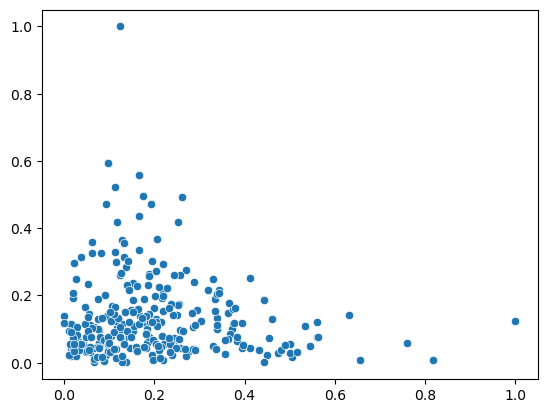

In [380]:
plt_ = sns.scatterplot(x=X[:, 1], y=X[:, 2])

In [331]:
df_normalized.shape

(292, 63)

In [ ]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
Ri_noMicrocosm_lasso_fit_all = {}
Ri_noMicrocosm_lasso_fit_avg = {}
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_lasso_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_lasso_fit_avg[p_tmp] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_fit_all[p_tmp][species_, :] = compute_Ri_lasso(df_speciesMetab.copy(), \
                                                                      df_speciesAbun_prev.copy(), \
                                                                      df_speciesAbun_next.copy(), \
                                                                      df_speciesAbun_ratio.copy(), \
                                                                      p_tmp, num_passages, \
                                                                      id_species)
        Ri_noMicrocosm_fit_avg[p_tmp] += Ri_noMicrocosm_fit_all[p_tmp][species_, :]
        
    Ri_noMicrocosm_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_dynamic_' + \
                                        'all_passages'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm.pickle'))

save_obj = {"Ri_noMicrocosm_fit_all" : Ri_noMicrocosm_fit_all, \
            "Ri_noMicrocosm_fit_avg" : Ri_noMicrocosm_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

# 12 April 2023: No microcosm fit Ri dynamic (all passages) with cross-feeding and blindly predict abundances

In [268]:
def compute_Ri_ss_cross_feeding(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                                p_tmp, id_species, p_prod, B_alone):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]
    df_specisAbun_split = geometric_avg(df_speciesAbun_prev_tmp, df_speciesAbun_next_tmp, p_tmp)

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            
            cross_feed_term = np.matmul(p_prod.T, \
                                        np.array(df_specisAbun_split.iloc[:, sample_id]).flatten()) / B_alone
            cross_feed_term = cross_feed_term.flatten()
            cross_feed_term = np.matmul(np.ones((len(id_species), 1)), 
                                        cross_feed_term.reshape((1, len(cross_feed_term))))
            if count_ == 0:
                A_train = A_train_sample * (1 + cross_feed_term)
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample * (1 + cross_feed_term)))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri_cross_feeding(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
                             p_tmp, num_passages, id_species, p_prod, B_alone):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]
    df_specisAbun_split = geometric_avg(df_speciesAbun_prev_tmp, df_speciesAbun_next_tmp, p_tmp)

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            cross_feed_term = np.matmul(p_prod.T, \
                                        np.array(df_specisAbun_split.iloc[:, sample_id])) / B_alone
            cross_feed_term = cross_feed_term.flatten()
            cross_feed_term = np.matmul(np.ones((len(id_species), 1)), 
                                        cross_feed_term.reshape((1, len(cross_feed_term))))
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample * (1 + cross_feed_term[id_keep, :])
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample * (1 + cross_feed_term[id_keep, :])))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind_cross_feeding(df_speciesAbun_prev, df_speciesAbun_next, \
                                                     p_tmp, Ri, growth_ratios_, \
                                                     ratio_means_, p_prod, B_alone, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)
    df_specisAbun_split = geometric_avg(df_speciesAbun_prev.copy(), df_speciesAbun_next.copy(), p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        cross_feed_term = np.matmul(p_prod.T, \
                                    np.array(df_specisAbun_split.iloc[:, sample_id])) / B_alone
        cross_feed_term = cross_feed_term.flatten()
        cross_feed_term = np.matmul(np.ones((len(id_species), 1)), 
                                    cross_feed_term.reshape((1, len(cross_feed_term))))
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample * (1 + cross_feed_term[:, :]), \
                                          Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [262]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_dynamic_' + \
                                        'all_passages'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

In [263]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
Ri_noMicrocosm_crossFeeding_fit_all = {}
Ri_noMicrocosm_crossFeeding_fit_avg = {}
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_crossFeeding_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_crossFeeding_fit_avg[p_tmp] = np.zeros((num_metabs))
    df_mat = np.array(df_speciesMetab.copy())
    B_alone = np.matmul(df_mat, Ri_noMicrocosm_fit_avg[p_tmp])
    B_alone = 10**np.mean(np.log10(B_alone))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_crossFeeding_fit_all[p_tmp][species_, :] = \
            compute_Ri_cross_feeding(df_speciesMetab.copy(), \
                                     df_speciesAbun_prev.copy(), \
                                     df_speciesAbun_next.copy(), \
                                     df_speciesAbun_ratio.copy(), \
                                     p_tmp, num_passages, \
                                     id_species, np.array(df_speciesProd), B_alone)
        Ri_noMicrocosm_crossFeeding_fit_avg[p_tmp] += Ri_noMicrocosm_crossFeeding_fit_all[p_tmp][species_, :]
        
    Ri_noMicrocosm_crossFeeding_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_dynamic_' + \
                                        'all_passages_crossFeeding'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm_crossFeeding.pickle'))

save_obj = {"Ri_noMicrocosm_crossFeeding_fit_all" : Ri_noMicrocosm_crossFeeding_fit_all, \
            "Ri_noMicrocosm_crossFeeding_fit_avg" : Ri_noMicrocosm_crossFeeding_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.4
count_p = 11, p = 0.5
count_p = 12, p = 0.55
count_p = 13, p = 0.6
count_p = 14, p = 0.65
count_p = 15, p = 0.7


In [265]:
p_vec_new = list(Ri_noMicrocosm_crossFeeding_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        df_mat = np.array(df_speciesMetab.copy())
        B_alone = np.matmul(df_mat, Ri_noMicrocosm_fit_avg[p_tmp])
        B_alone = 10**np.mean(np.log10(B_alone))
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_crossFeeding_fit_avg[p_tmp].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri dynamical all passages noMicrocosm, cross feeding', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = \
                        compute_growth_ratio_iterate_blind_cross_feeding(df_speciesAbun_prev_tmp_.copy(), \
                                                                         df_speciesAbun_next_tmp_.copy(), \
                                                                         p_tmp, Ri_avg.copy(), \
                                                                         growth_rate_all[iter_id].copy(), \
                                                                         None, np.array(df_speciesProd), B_alone,
                                                                         norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    'all_passages_crossFeeding', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_dynamical' + \
                                                     f'_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    'all_passages_crossFeeding', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_dynamic_all_passages' + \
                                                     f'_p{p_tmp}_{norm_status}_noMicrocosm_crossFeeding.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [266]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_noMicrocosm_' + \
                                                'Ri_fit_dynamic_' + \
                                                'all_passages_crossFeeding', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme_noMicrocosm' + \
                                             f'_Ri_fit_dynamic_all_passages_crossFeeding.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 12 April 2023: No microcosm fit steady state Ri with cross-feeding and blindly predict abundances

In [249]:
def compute_Ri_ss_cross_feeding(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                                p_tmp, id_species, p_prod, B_alone):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]
    df_specisAbun_split = geometric_avg(df_speciesAbun_prev_tmp, df_speciesAbun_next_tmp, p_tmp)

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            
            cross_feed_term = np.matmul(p_prod.T, \
                                        np.array(df_specisAbun_split.iloc[:, sample_id]).flatten()) / B_alone
            cross_feed_term = cross_feed_term.flatten()
            cross_feed_term = np.matmul(np.ones((len(id_species), 1)), 
                                        cross_feed_term.reshape((1, len(cross_feed_term))))
            if count_ == 0:
                A_train = A_train_sample * (1 + cross_feed_term)
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample * (1 + cross_feed_term)))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri_cross_feeding(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
                             p_tmp, num_passages, id_species, p_prod, B_alone):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]
    df_specisAbun_split = geometric_avg(df_speciesAbun_prev_tmp, df_speciesAbun_next_tmp, p_tmp)

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            cross_feed_term = np.matmul(p_prod.T, \
                                        np.array(df_specisAbun_split.iloc[:, sample_id])) / B_alone
            cross_feed_term = cross_feed_term.flatten()
            cross_feed_term = np.matmul(np.ones((len(id_species), 1)), 
                                        cross_feed_term.reshape((1, len(cross_feed_term))))
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample * (1 + cross_feed_term[id_keep, :])
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample * (1 + cross_feed_term[id_keep, :])))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind_cross_feeding(df_speciesAbun_prev, df_speciesAbun_next, \
                                                     p_tmp, Ri, growth_ratios_, \
                                                     ratio_means_, p_prod, B_alone, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)
    df_specisAbun_split = geometric_avg(df_speciesAbun_prev.copy(), df_speciesAbun_next.copy(), p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        cross_feed_term = np.matmul(p_prod.T, \
                                    np.array(df_specisAbun_split.iloc[:, sample_id])) / B_alone
        cross_feed_term = cross_feed_term.flatten()
        cross_feed_term = np.matmul(np.ones((len(id_species), 1)), 
                                    cross_feed_term.reshape((1, len(cross_feed_term))))
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample * (1 + cross_feed_term[:, :]), \
                                          Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [212]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_steadyState'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_steadyState_' + \
                                         'noMicrocosm_LeaveOneOutRi.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

In [240]:
# Fit using no-microcosm agar
passages_exclude = [[], [0], [0, 1]]
num_passages = 6
p_tmp = 0
Ri_noMicrocosm_crossFeeding_fit_all = {}
Ri_noMicrocosm_crossFeeding_fit_avg = {}
for count_p, pass_rm in enumerate(passages_exclude):
    print(f'count_p = {count_p}, pass_rmp = {pass_rm}')
    pass_ex_list = []
    for pass_ in pass_rm:
        pass_ex_list += [pass_, pass_ + num_passages, pass_ + 2 * num_passages]
    pass_keep = list(set(range(df_speciesAbun.shape[1])) - set(pass_ex_list))
    df_speciesAbun_tmp = df_speciesAbun.copy().iloc[:, pass_keep]
    
    Ri_noMicrocosm_crossFeeding_fit_all[count_p] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_crossFeeding_fit_avg[count_p] = np.zeros((num_metabs))
    df_mat = np.array(df_speciesMetab.copy())
    B_alone = np.matmul(df_mat, Ri_noMicrocosm_fit_avg[count_p])
    B_alone = 10**np.mean(np.log10(B_alone))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_crossFeeding_fit_all[count_p][species_, :] = \
            compute_Ri_ss_cross_feeding(df_speciesMetab.copy(), df_speciesAbun_tmp.copy(), \
                                        df_speciesAbun_tmp.copy(), \
                                        0, id_species, 
                                        np.array(df_speciesProd), \
                                        B_alone)
        Ri_noMicrocosm_crossFeeding_fit_avg[count_p] += \
            Ri_noMicrocosm_crossFeeding_fit_all[count_p][species_, :]
        
    Ri_noMicrocosm_crossFeeding_fit_avg[count_p] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_steadyState' + \
                                        '_crossFeeding'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_steadyState_noMicrocosm_crossFeeding_LeaveOneOutRi' + \
                                         '.pickle'))

save_obj = {"Ri_noMicrocosm_crossFeeding_fit_all" : Ri_noMicrocosm_crossFeeding_fit_all, \
            "Ri_noMicrocosm_crossFeeding_fit_avg" : Ri_noMicrocosm_crossFeeding_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, pass_rmp = []
count_p = 1, pass_rmp = [0]
count_p = 2, pass_rmp = [0, 1]


In [254]:
df_summary = pd.DataFrame()


x = Ri_noMicrocosm_fit_avg[2].copy()
y = Ri_noMicrocosm_crossFeeding_fit_avg[2].copy()

print(np.min(x[x != 0]))
print(np.min(y[y != 0]))

print(f'# metabs with Ri == 0 for no-microcosm = {len(x[x == 0])}')
print(f'# metabs with Ri == 0 for no-microcosm, cross-feeding = {len(y[y == 0])}')

x[x == 0] = 1e-15
y[y == 0] = 1e-15

x_full = x.copy()
y_full = y.copy()


id_2 = np.where((x > 1e-15) & (y <= 1e-15))[0]
print(f'# metabs with Ri > 0 for no-microcosm and Ri == 0 for no-microcosm, cross-feeding = {len(id_2)}')

id_1 = np.where((x <= 1e-15) & (y > 1e-15))[0]
print(f'# metabs with Ri == 0 for no-microcosm and Ri > 0 for no-microcosm, cross-feeding = {len(id_1)}')

id_rm = np.where((x == 1e-15) & (y == 1e-15))[0]
print(f'# metabs with Ri == 0 for no-microcosm and Ri == 0 for no-microcosm, cross-feeding = {len(id_rm)}')


# plots
fig, axes = plt.subplots(1, 2, figsize=(40, 30), sharey="row", sharex="col")
fig.suptitle(f'Ri fit comparison between no-microcosm and no-microcosm, cross-feeding \n' + \
             f'# metabs with Ri == 0 for no-microcosm = {len(x[x == 1e-15])}, ' + \
             f'# metabs with Ri == 0 for no-microcosm, cross-feeding = {len(y[y == 1e-15])}, ' + \
             f'# metabs with Ri > 0 for no-microcosm and Ri == 0 for no-microcosm, ' + \
             f'cross-feeding = {len(id_2)} \n' + \
             f'# metabs with Ri == 0 for no-microcosm and Ri > 0 for no-microcosm, ' + \
             f'cross-feeding = {len(id_1)} \n' + \
             f'# metabs with Ri == 0 for no-microcosm and Ri == 0 for no-microcosm, ' + \
             f'cross-feeding = {len(id_rm)}', \
             fontsize=25)
fig.supxlabel('Ri no microcosm (log-scale)', fontsize=50)
fig.supylabel('Ri no-microcosm, cross-feeding (log-scale)', fontsize=50)


id_ = list(set(range(len(x_full))) - set(id_rm))
# id_ = range(len(x))

x = np.log10(x_full[id_])
y = np.log10(y_full[id_])
plt_ = sns.scatterplot(x=x, y=y, ax=axes[0], s=200)
plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[0])
# plt_.plot([-15, 1], [-15, 1], c="red")
plt_.plot([-15, 0], [-15, 0], c="red")

corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
corr_val_pe_log = scipy.stats.pearsonr(x, y)
corr_val_sp = scipy.stats.spearmanr(x, y)

title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1])

axes[0].set_title(title_, size=25)
plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
plt_.set_yticklabels(plt_.get_yticklabels(), size=30)


id_ = np.where((x_full != 1e-15) & (y_full != 1e-15))[0]
x = np.log10(x_full[id_])
y = np.log10(y_full[id_])
plt_ = sns.scatterplot(x=x, y=y, ax=axes[1], s=200)
plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[1])
# plt_.plot([-15, 1], [-15, 1], c="red")
plt_.plot([-10, 0], [-10, 0], c="red")

corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
corr_val_pe_log = scipy.stats.pearsonr(x, y)
corr_val_sp = scipy.stats.spearmanr(x, y)

title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1])

axes[1].set_title(title_, size=25)
plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
# plt_.set_yticklabels(plt_.get_yticklabels(), size=20)


save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_steadyState' + \
                                        '_crossFeeding'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

save_file = os.path.abspath(os.path.join(save_dir, f'RiFit_comparison_noMicrocosm_vs_noMicrocosmCrossFeeding.png'))
fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)


df_tmp = \
    pd.DataFrame(data={"p" : [p_tmp] * 3, 
                       "metric_type" : ["corr_pearson_linear", "corr_pearson_log", 
                                        "corr_spearman"], 
                       "metric" : [corr_val_pe[0], corr_val_pe_log[0], 
                                   corr_val_sp[0]],
                       "pval" : [corr_val_pe[1], corr_val_pe_log[1], 
                                 corr_val_sp[1]]})
df_summary = pd.concat([df_summary, df_tmp], ignore_index=True)



3.600902752041749e-10
9.079448194484822e-14
# metabs with Ri == 0 for no-microcosm = 163
# metabs with Ri == 0 for no-microcosm, cross-feeding = 157
# metabs with Ri > 0 for no-microcosm and Ri == 0 for no-microcosm, cross-feeding = 18
# metabs with Ri == 0 for no-microcosm and Ri > 0 for no-microcosm, cross-feeding = 24
# metabs with Ri == 0 for no-microcosm and Ri == 0 for no-microcosm, cross-feeding = 139


/tmp/ipykernel_5598/3384900368.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_5598/3384900368.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_5598/3384900368.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


In [258]:
x = Ri_noMicrocosm_fit_avg[2].copy()
y = Ri_noMicrocosm_crossFeeding_fit_avg[2].copy()
rank_x = get_rank(-x)
rank_y = get_rank(-y)
id_ = np.where((rank_x < 40) & (rank_y < 40))[0]
len(id_)

num_Ri_common = []
ranks_vec = range(70)

for rank_tmp in ranks_vec:
    id_ = np.where((rank_x < rank_tmp) & (rank_y < rank_tmp))[0]
    num_Ri_common.append(len(id_))

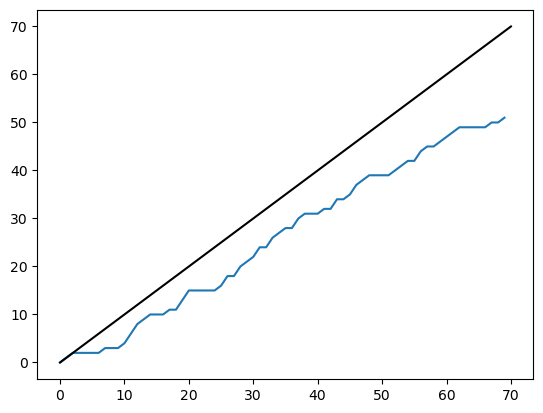

In [259]:
plt_ = sns.lineplot(x=ranks_vec, y=num_Ri_common)
plt_.plot([0, 70], [0, 70], c="black")

In [260]:
id_ = np.where((rank_x < 30) & (rank_y < 30))[0]
metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
# print(metab_names[id_])
# print(rank_x[id_])
# print(rank_y[id_])
# print(x[id_])
# print(y[id_])

id_order = np.argsort(rank_x[id_])
df_metabs = pd.DataFrame(data={"metab_name" : metab_names[id_][id_order], \
                               "rank_noMicrocosm" : rank_x[id_][id_order], \
                               "rank_superAgar" : rank_y[id_][id_order], \
                               "Ri_noMicrocosm" : x[id_][id_order], \
                               "Ri_superAgar" : y[id_][id_order]})
print(df_metabs)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_RiFit_compare_noMicrocosm_vs_supernatantAgar'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

save_file = os.path.abspath(os.path.join(save_dir, f'metabs_common_top30_noMicrocosm_superAgar_p{p_tmp}.csv'))
# df_metabs.to_csv(save_file)
df_metabs

                              metab_name  rank_noMicrocosm  rank_superAgar  \
0                 5'-METHYLTHIOADENOSINE                 0               0   
1                IS_METHIONINE-METHYL-D3                 1               1   
2                 N-METHYL-ASPARTIC ACID                 2              12   
3                           BETA-ALANINE                 4              11   
4                           HYPOXANTHINE                 6               6   
5                   GLYCEROL 2-PHOSPHATE                 7              10   
6                          ACETYLCHOLINE                 8              28   
7                              ADENOSINE                 9               4   
8   IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID                10               5   
9                            CITRIC ACID                11               3   
10         IS_PHENYLALANINE-2,3,4,5,6-D5                12              13   
11  IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID                14      

metab_name  rank_noMicrocosm  rank_superAgar  \
0                 5'-METHYLTHIOADENOSINE                 0               0   
1                IS_METHIONINE-METHYL-D3                 1               1   
2                 N-METHYL-ASPARTIC ACID                 2              12   
3                           BETA-ALANINE                 4              11   
4                           HYPOXANTHINE                 6               6   
5                   GLYCEROL 2-PHOSPHATE                 7              10   
6                          ACETYLCHOLINE                 8              28   
7                              ADENOSINE                 9               4   
8   IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID                10               5   
9                            CITRIC ACID                11               3   
10         IS_PHENYLALANINE-2,3,4,5,6-D5                12              13   
11  IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID                14              18   
12                  4-AMINOBUTANOIC ACID                15              27   
13                             GLUTAMINE                16              15   
14                     1-METHYLGUANIDINE                17              19   
15                   IS_TRIDECANOIC ACID                18               9   
16                   4-AMINOBENZOIC ACID                19              14   
17             IS_4-CHLORO-PHENYLALANINE                22              25   
18                N-ACETYL-PHENYLALANINE                23              29   
19                              CYTOSINE                24              24   
20                              CYTIDINE                25              22   
21               IS_N-BENZOYL-D5-GLYCINE                27              20   

    Ri_noMicrocosm  Ri_superAgar  
0         0.156658      0.160245  
1         0.140676      0.137251  
2         0.117452      0.012081  
3         0.066850      0.012554  
4         0.033649      0.026675  
5         0.033117      0.013694  
6         0.031217      0.004225  
7         0.025421      0.030320  
8         0.024412      0.026796  
9         0.021981      0.036498  
10        0.014002      0.011621  
11        0.012826      0.009990  
12        0.012062      0.004257  
13        0.009579      0.010674  
14        0.008876      0.007012  
15        0.008772      0.017423  
16        0.008515      0.011215  
17        0.007534      0.004393  
18        0.007228      0.004158  
19        0.007166      0.004873  
20        0.007122      0.005474  
21        0.006724      0.006915

In [252]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        df_mat = np.array(df_speciesMetab.copy())
        B_alone = np.matmul(df_mat, Ri_noMicrocosm_fit_avg[2])
        B_alone = 10**np.mean(np.log10(B_alone))
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_crossFeeding_fit_avg[2].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri steady state noMicrocosm cross_feeding', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy(), 
                                                                  np.array(df_speciesProd), B_alone)
                else:
                    df_growth_rate = \
                    compute_growth_ratio_iterate_blind_cross_feeding(df_speciesAbun_prev_tmp_.copy(), \
                                                                     df_speciesAbun_next_tmp_.copy(), \
                                                                     p_tmp, Ri_avg.copy(), \
                                                                     growth_rate_all[iter_id].copy(), \
                                                                     None, np.array(df_speciesProd), 
                                                                     B_alone,
                                                                     norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm' + \
                                                    '_Ri_fit_steadyState_crossFeeding', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_steadyState_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm' + \
                                                    '_Ri_fit_steadyState_crossFeeding', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_steadyState_p{p_tmp}_{norm_status}_noMicrocosm' + \
                                                     f'_cross_feeding.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [253]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_noMicrocosm' + \
                                                '_Ri_fit_steadyState_crossFeeding', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'_Ri_fit_steadyState_noMicrocosm_cross_feeding.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# Compare Ri for no-microcosm against supernatant-agar

## Load no-microcosm Ri dynamical (with only steady-state passages, exclude passage = 1)

In [128]:
pass_rm = [0]
pass_rm_str = ""
if len(pass_rm) > 0:
    for count_, pass_tmp in enumerate(pass_rm):
        if count_ == 0:
            pass_rm_str += f'{pass_tmp + 1}to{pass_tmp + 2}'
        else:
            pass_rm_str += f'_{pass_tmp + 1}to{pass_tmp + 2}'
else:
    pass_rm_str = "none"
pass_ex_list = []
for pass_ in pass_rm:
    pass_ex_list += [pass_, pass_ + (num_passages - 1), pass_ + 2 * (num_passages - 1)]
pass_keep = list(set(range(df_speciesAbun_prev.shape[1])) - set(pass_ex_list))

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_' + \
                                        'Ri_fit_dynamic_' + \
                                        '_only_steadyState_passages' + \
                                        f'_exclude_passage_transitions_{pass_rm_str}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic' + \
                                         '_different_p_LeaveOneOutRi_noMicrocosm' + \
                                         f'_only_steadyState_passages' + \
                                         f'_exclude_passage_transitions_{pass_rm_str}.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

In [144]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_dynamic_' + \
                                        'all_passages'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

## Load supernatant-agar Ri dynamical (with only steady-state passages, exclude passage = 1)

In [129]:
pass_rm = [0]
pass_rm_str = ""
if len(pass_rm) > 0:
    for count_, pass_tmp in enumerate(pass_rm):
        if count_ == 0:
            pass_rm_str += f'{pass_tmp + 1}to{pass_tmp + 2}'
        else:
            pass_rm_str += f'_{pass_tmp + 1}to{pass_tmp + 2}'
else:
    pass_rm_str = "none"
pass_ex_list = []
for pass_ in pass_rm:
    pass_ex_list += [pass_, pass_ + (num_passages - 1), pass_ + 2 * (num_passages - 1)]
pass_keep = list(set(range(df_speciesAbun_prev.shape[1])) - set(pass_ex_list))

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_superAgar_' + \
                                        'Ri_fit_dynamic_' + \
                                        '_only_steadyState_passages' + \
                                        f'_exclude_passage_transitions_{pass_rm_str}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic' + \
                                         '_different_p_LeaveOneOutRi_superAgar' + \
                                         f'_only_steadyState_passages' + \
                                         f'_exclude_passage_transitions_{pass_rm_str}.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_superAgar_fit_all = save_obj["Ri_superAgar_fit_all"]
Ri_superAgar_fit_avg = save_obj["Ri_superAgar_fit_avg"]

In [145]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_superAgar_Ri_fit_dynamic_' + \
                                        'all_passages'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_superAgar.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_superAgar_fit_all = save_obj["Ri_superAgar_fit_all"]
Ri_superAgar_fit_avg = save_obj["Ri_superAgar_fit_avg"]

1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 25
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 44
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 172


/tmp/ipykernel_5598/1634633720.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_5598/1634633720.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_5598/1634633720.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


[Text(-12.0, 0, '−12'),
 Text(-10.0, 0, '−10'),
 Text(-8.0, 0, '−8'),
 Text(-6.0, 0, '−6'),
 Text(-4.0, 0, '−4'),
 Text(-2.0, 0, '−2'),
 Text(0.0, 0, '0'),
 Text(2.0, 0, '2'),
 Text(4.0, 0, '4')]

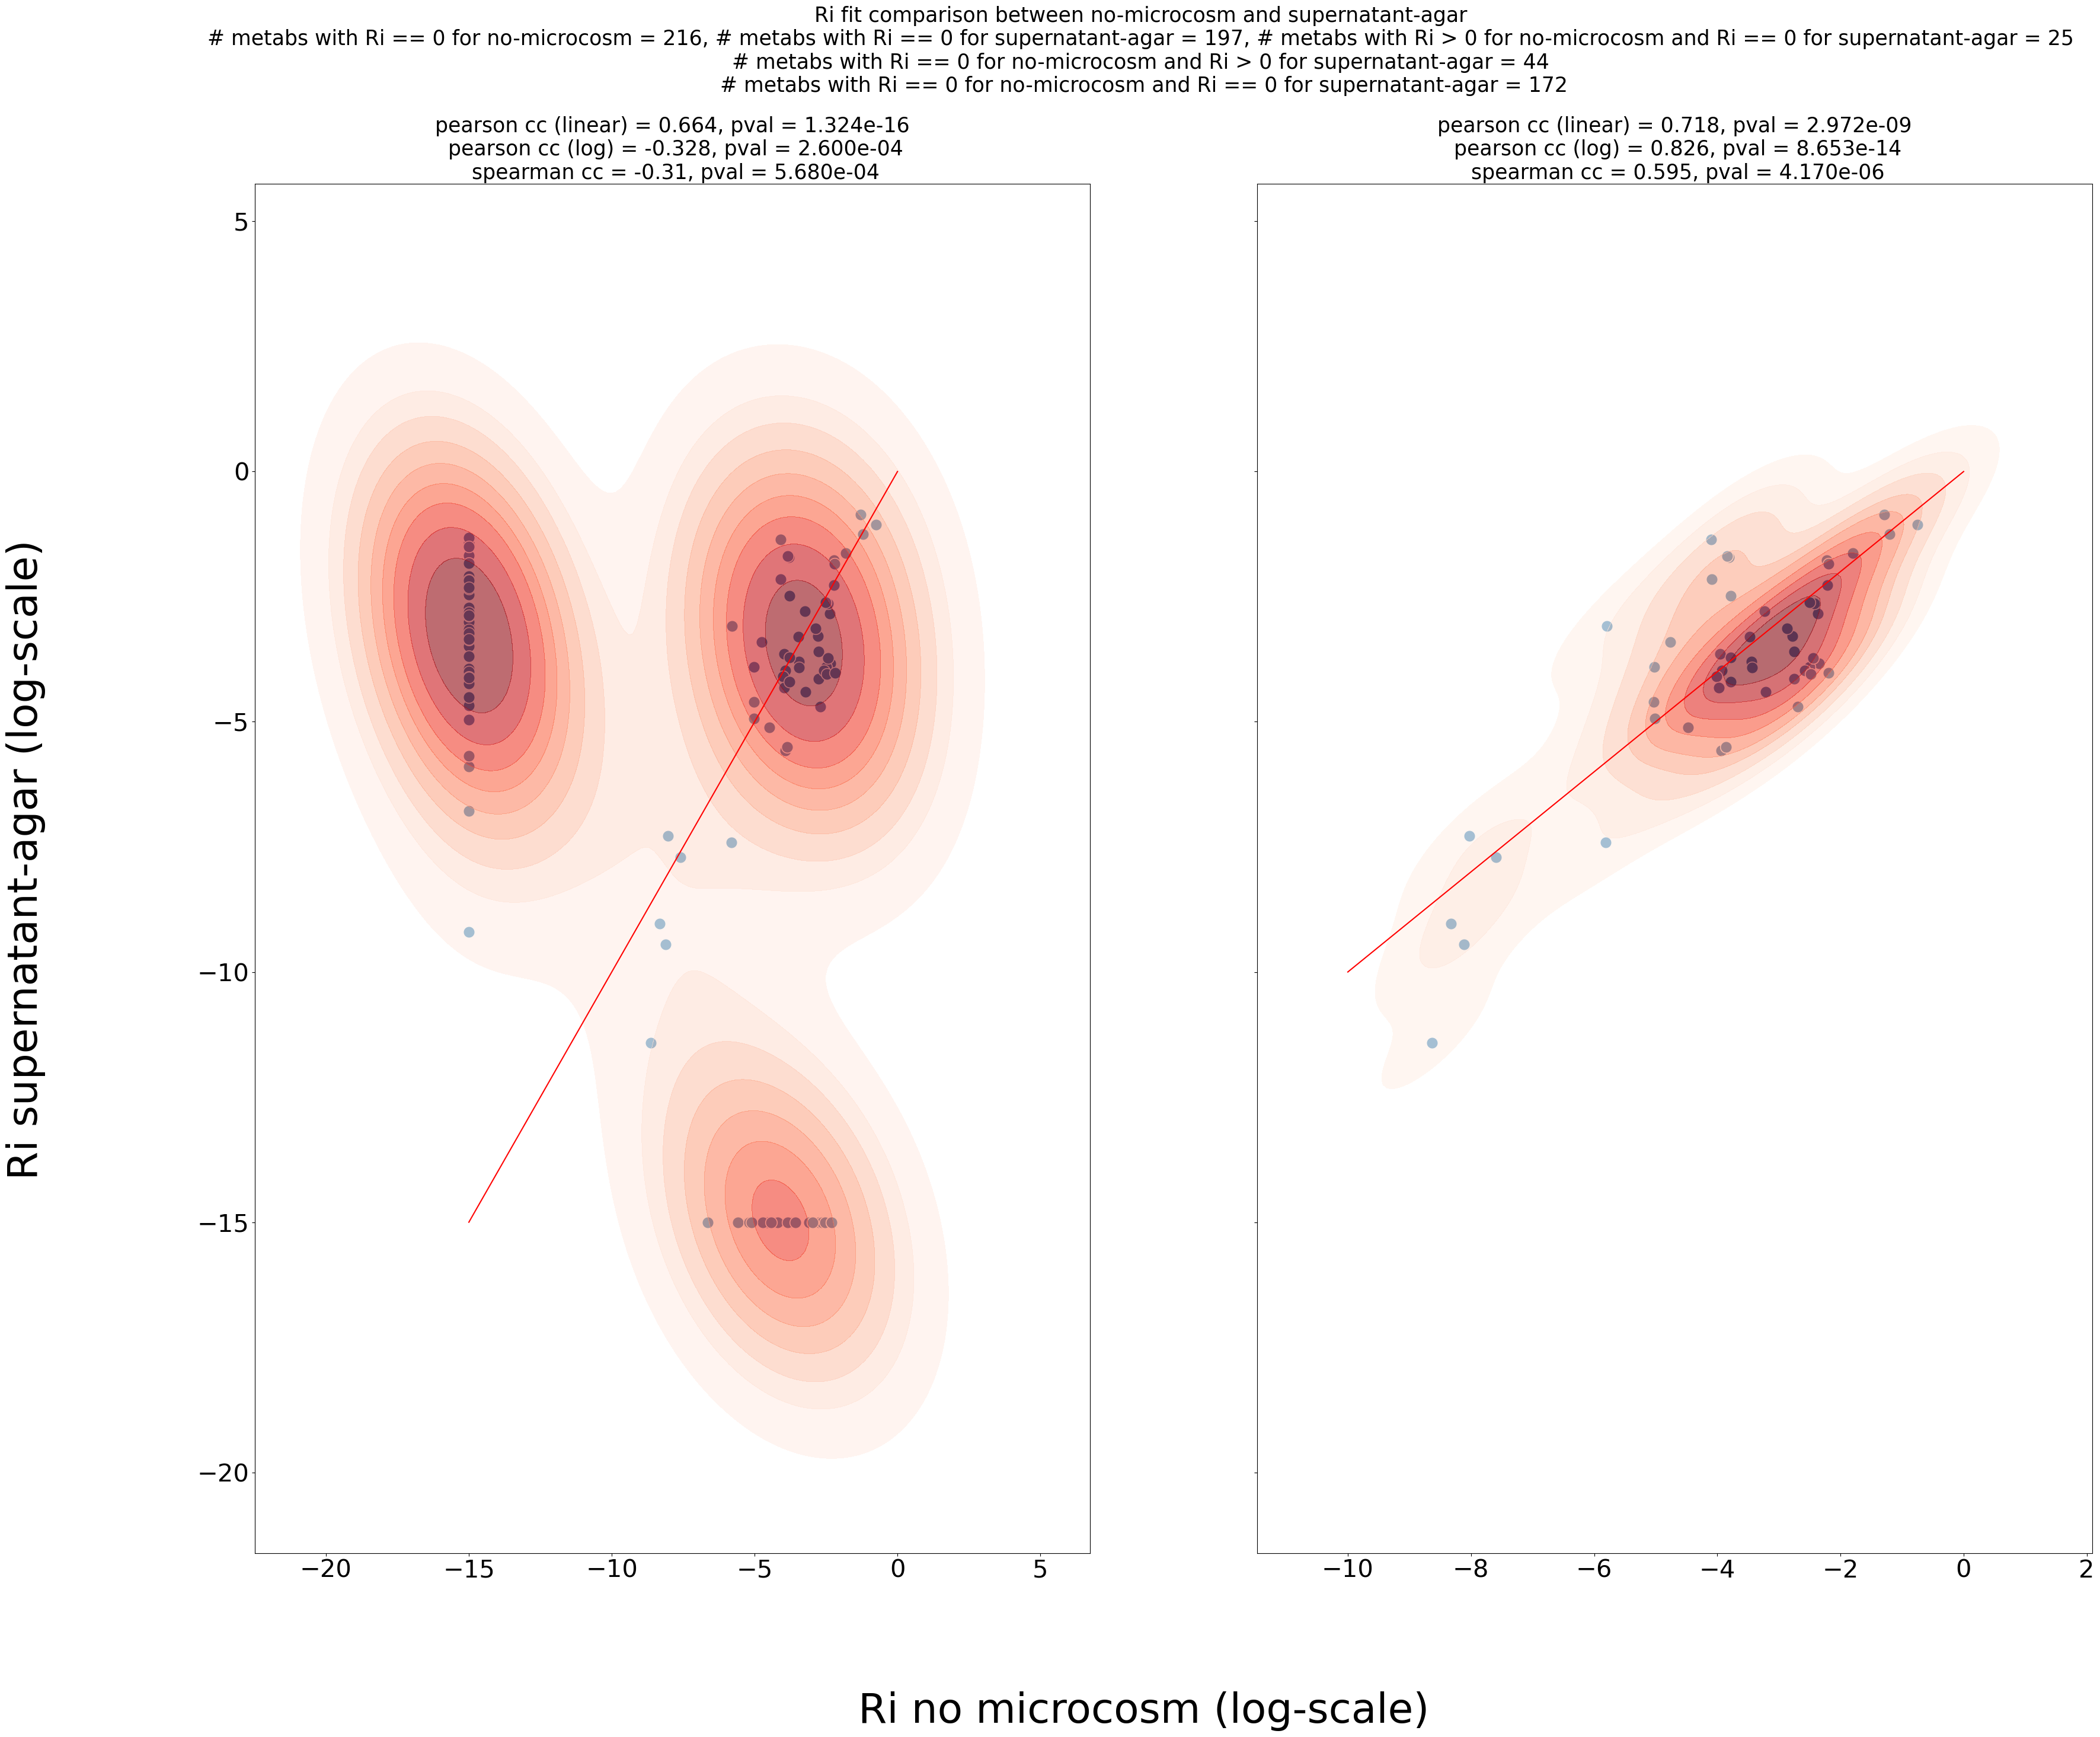

In [155]:
p_tmp = 0.5

x = Ri_noMicrocosm_fit_avg.copy()[p_tmp]
y = Ri_superAgar_fit_avg.copy()[p_tmp]


print(np.min(x[x != 0]))
print(np.min(y[y != 0]))

print(f'# metabs with Ri == 0 for no-microcosm = {len(x[x == 0])}')
print(f'# metabs with Ri == 0 for supernatant-agar = {len(y[y == 0])}')

x[x == 0] = 1e-15
y[y == 0] = 1e-15

x_full = x.copy()
y_full = y.copy()

x_rank = get_rank(x_full)
y_rank = get_rank(y_full)


id_2 = np.where((x > 1e-15) & (y <= 1e-15))[0]
print(f'# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_2)}')

id_1 = np.where((x <= 1e-15) & (y > 1e-15))[0]
print(f'# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = {len(id_1)}')

id_rm = np.where((x == 1e-15) & (y == 1e-15))[0]
print(f'# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_rm)}')


# plots
fig, axes = plt.subplots(1, 2, figsize=(40, 30), sharey="row", sharex="col")
fig.suptitle(f'Ri fit comparison between no-microcosm and supernatant-agar \n' + \
             f'# metabs with Ri == 0 for no-microcosm = {len(x[x == 1e-15])}, ' + \
             f'# metabs with Ri == 0 for supernatant-agar = {len(y[y == 1e-15])}, ' + \
             f'# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_2)} \n' + \
             f'# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = {len(id_1)} \n' + \
             f'# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_rm)}', \
             fontsize=25)
fig.supxlabel('Ri no microcosm (log-scale)', fontsize=50)
fig.supylabel('Ri supernatant-agar (log-scale)', fontsize=50)


id_ = list(set(range(len(x_full))) - set(id_rm))
# id_ = range(len(x))

x = np.log10(x_full[id_])
y = np.log10(y_full[id_])
plt_ = sns.scatterplot(x=x, y=y, ax=axes[0], s=200)
plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[0])
# plt_.plot([-15, 1], [-15, 1], c="red")
plt_.plot([-15, 0], [-15, 0], c="red")

corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
corr_val_pe_log = scipy.stats.pearsonr(x, y)
corr_val_sp = scipy.stats.pearsonr(x_rank[id_], y_rank[id_])

title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1])

axes[0].set_title(title_, size=25)
plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
plt_.set_yticklabels(plt_.get_yticklabels(), size=30)


id_ = np.where((x_full != 1e-15) & (y_full != 1e-15))[0]
x = np.log10(x_full[id_])
y = np.log10(y_full[id_])
plt_ = sns.scatterplot(x=x, y=y, ax=axes[1], s=200)
plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[1])
# plt_.plot([-15, 1], [-15, 1], c="red")
plt_.plot([-10, 0], [-10, 0], c="red")

corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
corr_val_pe_log = scipy.stats.pearsonr(x, y)
corr_val_sp = scipy.stats.pearsonr(x_rank[id_], y_rank[id_])

title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1])

axes[1].set_title(title_, size=25)
plt_.set_xticklabels(plt_.get_xticklabels(), size=30)

In [193]:
x_tmp = Ri_noMicrocosm_fit_avg.copy()[p_tmp]
print(len(x_tmp[x_tmp > 1e-9]))
print(len(x_tmp[(x_tmp > 1e-9) & (y_tmp <= 1e-15)]))
y_tmp = Ri_superAgar_fit_avg.copy()[p_tmp]
print(len(y_tmp[(y_tmp > 1e-9) & (x_tmp <= 1e-15)]))

76
25
43


In [192]:
id_1 = np.where((x_tmp > 1e-9) & (y_tmp <= 1e-15))[0]
print(len(id_1))
id_2 = np.where((x_tmp > 1e-9) & (y_tmp > 1e-9))[0]
print(len(id_2))

25
48


In [156]:
x = Ri_noMicrocosm_fit_avg.copy()[p_tmp]
y = Ri_superAgar_fit_avg.copy()[p_tmp]
rank_x = get_rank(-x)
rank_y = get_rank(-y)

In [157]:
id_ = np.where((rank_x < 40) & (rank_y < 40))[0]
len(id_)

num_Ri_common = []
ranks_vec = range(70)

for rank_tmp in ranks_vec:
    id_ = np.where((rank_x < rank_tmp) & (rank_y < rank_tmp))[0]
    num_Ri_common.append(len(id_))

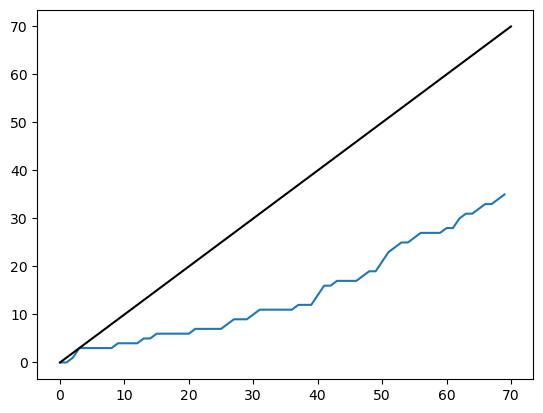

In [158]:
plt_ = sns.lineplot(x=ranks_vec, y=num_Ri_common)
plt_.plot([0, 70], [0, 70], c="black")

<Axes: ylabel='Count'>

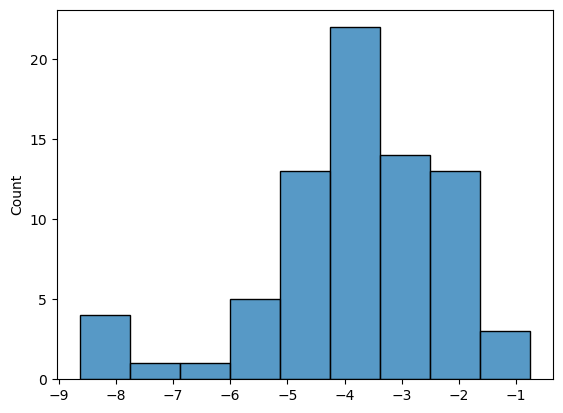

In [97]:
sns.histplot(np.log10(x_tmp[x_tmp != 0]))

In [198]:
id_ = np.where((rank_x < 30) & (rank_y < 30))[0]
metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
# print(metab_names[id_])
# print(rank_x[id_])
# print(rank_y[id_])
# print(x[id_])
# print(y[id_])

id_order = np.argsort(rank_x[id_])
df_metabs = pd.DataFrame(data={"metab_name" : metab_names[id_][id_order], \
                               "rank_noMicrocosm" : rank_x[id_][id_order], \
                               "rank_superAgar" : rank_y[id_][id_order], \
                               "Ri_noMicrocosm" : x[id_][id_order], \
                               "Ri_superAgar" : y[id_][id_order]})
print(df_metabs)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_RiFit_compare_noMicrocosm_vs_supernatantAgar'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

save_file = os.path.abspath(os.path.join(save_dir, f'metabs_common_top30_noMicrocosm_superAgar_p{p_tmp}.csv'))
df_metabs.to_csv(save_file)

                 metab_name  rank_noMicrocosm  rank_superAgar  Ri_noMicrocosm  \
0              BENZALDEHYDE                 0               1        0.177759   
1    3-DEHYDROSHIKIMIC ACID                 1               2        0.063111   
2             CROTONIC ACID                 2               0        0.051006   
3                PUTRESCINE                 3               8        0.015870   
4                    3'-CMP                 5              14        0.006383   
5  4-GUANIDINOBUTANOIC ACID                 6              20        0.006065   
6         3-METHOXYTYRAMINE                 7              12        0.006034   
7              DEOXYURIDINE                12              26        0.003749   
8      N-METHYLNICOTINAMIDE                16              25        0.003121   
9  RAC-GLYCEROL 1-MYRISTATE                29              28        0.000588   

   Ri_superAgar  
0      0.087091  
1      0.055330  
2      0.136547  
3      0.023260  
4      0.014331  


In [196]:
id_order = np.argsort(rank_x[id_])
rank_x[id_][id_order]

array([ 0,  1,  2,  3,  5,  6,  7, 12, 16, 29])

In [ ]:
df_summary = pd.DataFrame()

p_vec_new = Ri_superAgar_fit_avg.keys()

p_tmp1 = 

x = Ri_fit_avg.copy()[p_tmp]
y = Ri_superAgar_fit_avg.copy()[p_tmp]

print(np.min(x[x != 0]))
print(np.min(y[y != 0]))

print(f'# metabs with Ri == 0 for no-microcosm = {len(x[x == 0])}')
print(f'# metabs with Ri == 0 for supernatant-agar = {len(y[y == 0])}')

x[x == 0] = 1e-15
y[y == 0] = 1e-15

x_full = x.copy()
y_full = y.copy()


id_2 = np.where((x > 1e-15) & (y <= 1e-15))[0]
print(f'# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_2)}')

id_1 = np.where((x <= 1e-15) & (y > 1e-15))[0]
print(f'# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = {len(id_1)}')

id_rm = np.where((x == 1e-15) & (y == 1e-15))[0]
print(f'# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_rm)}')


# plots
fig, axes = plt.subplots(1, 2, figsize=(40, 30), sharey="row", sharex="col")
fig.suptitle(f'Ri fit comparison between no-microcosm and supernatant-agar \n' + \
             f'# metabs with Ri == 0 for no-microcosm = {len(x[x == 1e-15])}, ' + \
             f'# metabs with Ri == 0 for supernatant-agar = {len(y[y == 1e-15])}, ' + \
             f'# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_2)} \n' + \
             f'# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = {len(id_1)} \n' + \
             f'# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_rm)}', \
             fontsize=25)
fig.supxlabel('Ri no microcosm (log-scale)', fontsize=50)
fig.supylabel('Ri supernatant-agar (log-scale)', fontsize=50)


id_ = list(set(range(len(x_full))) - set(id_rm))
# id_ = range(len(x))

x = np.log10(x_full[id_])
y = np.log10(y_full[id_])
plt_ = sns.scatterplot(x=x, y=y, ax=axes[0], s=200)
plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[0])
# plt_.plot([-15, 1], [-15, 1], c="red")
plt_.plot([-15, 0], [-15, 0], c="red")

corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
corr_val_pe_log = scipy.stats.pearsonr(x, y)
corr_val_sp = scipy.stats.spearmanr(x, y)

title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1])

axes[0].set_title(title_, size=25)
plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
plt_.set_yticklabels(plt_.get_yticklabels(), size=30)


id_ = np.where((x_full != 1e-15) & (y_full != 1e-15))[0]
x = np.log10(x_full[id_])
y = np.log10(y_full[id_])
plt_ = sns.scatterplot(x=x, y=y, ax=axes[1], s=200)
plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[1])
# plt_.plot([-15, 1], [-15, 1], c="red")
plt_.plot([-10, 0], [-10, 0], c="red")

corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
corr_val_pe_log = scipy.stats.pearsonr(x, y)
corr_val_sp = scipy.stats.spearmanr(x, y)

title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1])

axes[1].set_title(title_, size=25)
plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
# plt_.set_yticklabels(plt_.get_yticklabels(), size=20)


save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_RiFit_compare_noMicrocosm_vs_supernatantAgar'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

save_file = os.path.abspath(os.path.join(save_dir, f'RiFit_comparison_p{p_tmp}.png'))
fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)


df_tmp = \
    pd.DataFrame(data={"p" : [p_tmp] * 3, 
                       "metric_type" : ["corr_pearson_linear", "corr_pearson_log", 
                                        "corr_spearman"], 
                       "metric" : [corr_val_pe[0], corr_val_pe_log[0], 
                                   corr_val_sp[0]],
                       "pval" : [corr_val_pe[1], corr_val_pe_log[1], 
                                 corr_val_sp[1]]})
df_summary = pd.concat([df_summary, df_tmp], ignore_index=True)


# 11 April 2023: No microcosm use null Ri and blindly predict abundances

In [313]:
df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                                 df_speciesAbun=df_speciesAbun)
Ri_null = null_Ri_2(df_speciesMetab, df_cons_abun_prod_split)

In [314]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_null.copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri null noMicrocosm', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                        df_speciesAbun_next_tmp_.copy(), \
                                                                        p_tmp, Ri_avg.copy(), \
                                                                        growth_rate_all[iter_id].copy(), \
                                                                        None, 
                                                                        norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm' + \
                                                    '_Ri_fit_null', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_null_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm' + \
                                                    '_Ri_fit_null', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_null_p{p_tmp}_{norm_status}_noMicrocosm' + \
                                                     f'.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [315]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_noMicrocosm' + \
                                                '_Ri_fit_null', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'_Ri_fit_null_noMicrocosm.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 11 April 2023: No microcosm fit steady state Ri and blindly predict abundances

In [272]:
def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [276]:
# Fit using no-microcosm agar
passages_exclude = [[], [0], [0, 1]]
num_passages = 6
p_tmp = 0
Ri_noMicrocosm_fit_all = {}
Ri_noMicrocosm_fit_avg = {}
for count_p, pass_rm in enumerate(passages_exclude):
    print(f'count_p = {count_p}, pass_rmp = {pass_rm}')
    pass_ex_list = []
    for pass_ in pass_rm:
        pass_ex_list += [pass_, pass_ + num_passages, pass_ + 2 * num_passages]
    pass_keep = list(set(range(df_speciesAbun.shape[1])) - set(pass_ex_list))
    df_speciesAbun_tmp = df_speciesAbun.copy().iloc[:, pass_keep]
    
    Ri_noMicrocosm_fit_all[count_p] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_fit_avg[count_p] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_fit_all[count_p][species_, :] = compute_Ri_ss(df_speciesMetab.copy(), \
                                                                     df_speciesAbun_tmp.copy(), \
                                                                     df_speciesAbun_tmp.copy(), \
                                                                     0, \
                                                                     id_species)
        Ri_noMicrocosm_fit_avg[count_p] += Ri_noMicrocosm_fit_all[count_p][species_, :]
        
    Ri_noMicrocosm_fit_avg[count_p] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_steadyState'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_steadyState_noMicrocosm_LeaveOneOutRi.pickle'))

save_obj = {"Ri_noMicrocosm_fit_all" : Ri_noMicrocosm_fit_all, \
            "Ri_noMicrocosm_fit_avg" : Ri_noMicrocosm_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, pass_rmp = []
count_p = 1, pass_rmp = [0]
count_p = 2, pass_rmp = [0, 1]


In [297]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_steadyState'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_steadyState_' + \
                                         'noMicrocosm_LeaveOneOutRi.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

In [298]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_fit_avg[2].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri steady state noMicrocosm', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                        df_speciesAbun_next_tmp_.copy(), \
                                                                        p_tmp, Ri_avg.copy(), \
                                                                        growth_rate_all[iter_id].copy(), \
                                                                        None, 
                                                                        norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm' + \
                                                    '_Ri_fit_steadyState', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_steadyState_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm' + \
                                                    '_Ri_fit_steadyState', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_steadyState_p{p_tmp}_{norm_status}_noMicrocosm' + \
                                                     f'.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [299]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_noMicrocosm' + \
                                                '_Ri_fit_steadyState', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'_Ri_fit_steadyState_noMicrocosm.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 11 April 2023: No microcosm fit Ri dynamic (all passages) and blindly predict abundances

In [276]:
def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [281]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
Ri_noMicrocosm_fit_all = {}
Ri_noMicrocosm_fit_avg = {}
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_fit_avg[p_tmp] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab.copy(), \
                                                                df_speciesAbun_prev.copy(), \
                                                                df_speciesAbun_next.copy(), \
                                                                df_speciesAbun_ratio.copy(), \
                                                                p_tmp, num_passages, \
                                                              id_species)
        Ri_noMicrocosm_fit_avg[p_tmp] += Ri_noMicrocosm_fit_all[p_tmp][species_, :]
        
    Ri_noMicrocosm_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_dynamic_' + \
                                        'all_passages'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm.pickle'))

save_obj = {"Ri_noMicrocosm_fit_all" : Ri_noMicrocosm_fit_all, \
            "Ri_noMicrocosm_fit_avg" : Ri_noMicrocosm_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.4
count_p = 11, p = 0.5
count_p = 12, p = 0.55
count_p = 13, p = 0.6
count_p = 14, p = 0.65
count_p = 15, p = 0.7


In [1076]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_Ri_fit_dynamic_' + \
                                        'all_passages'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_noMicrocosm.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

SignificanceResult(statistic=0.4696076582414411, pvalue=0.00010325485863918265)

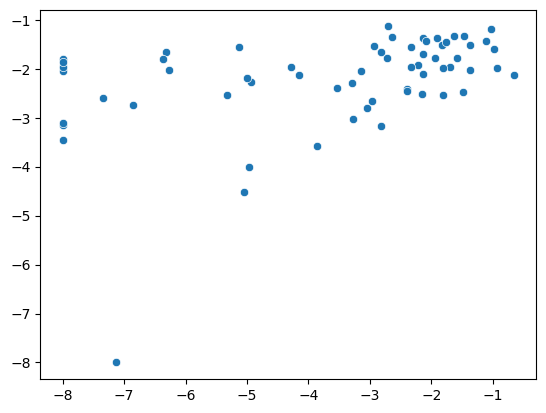

In [307]:
pass_ = 5
id_pass_keep = [pass_, pass_ + num_passages, pass_ + 2 * num_passages]
x = np.array(df_speciesAbun_super_agar.iloc[:, id_pass_keep]).mean(axis=1).flatten()
y = np.array(df_speciesAbun_inoc.values).flatten()

plt_ = sns.scatterplot(x=np.log10(x), y = np.log10(y))
scipy.stats.spearmanr(np.log10(x), np.log10(y))

In [291]:
p_vec_new = list(Ri_noMicrocosm_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri dynamical all passages noMicrocosm', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, 
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    'all_passages', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_dynamical' + \
                                                     f'_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    'all_passages', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_dynamic_all_passages' + \
                                                     f'_p{p_tmp}_{norm_status}_noMicrocosm.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [292]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_noMicrocosm_' + \
                                                'Ri_fit_dynamic_' + \
                                                'all_passages', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme_noMicrocosm' + \
                                             f'_Ri_fit_dynamic_all_passages.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 11 April 2023: No microcosm fit Ri dynamic (only steady-state passages) and blindly predict abundances

In [294]:
def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [320]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
Ri_noMicrocosm_fit_all = {}
Ri_noMicrocosm_fit_avg = {}
pass_rm = [0, 1]
pass_rm_str = ""
if len(pass_rm) > 0:
    for count_, pass_tmp in enumerate(pass_rm):
        if count_ == 0:
            pass_rm_str += f'{pass_tmp + 1}to{pass_tmp + 2}'
        else:
            pass_rm_str += f'_{pass_tmp + 1}to{pass_tmp + 2}'
else:
    pass_rm_str = "none"
pass_ex_list = []
for pass_ in pass_rm:
    pass_ex_list += [pass_, pass_ + (num_passages - 1), pass_ + 2 * (num_passages - 1)]
pass_keep = list(set(range(df_speciesAbun_prev.shape[1])) - set(pass_ex_list))
df_speciesAbun_prev_tmp = \
    df_speciesAbun_prev.copy().iloc[:, pass_keep]
df_speciesAbun_next_tmp = \
    df_speciesAbun_next.copy().iloc[:, pass_keep]
df_speciesAbun_ratio_tmp = \
    df_speciesAbun_ratio.copy().iloc[:, pass_keep]
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_noMicrocosm_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_noMicrocosm_fit_avg[p_tmp] = np.zeros((num_metabs))

    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_noMicrocosm_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab.copy(), \
                                                               df_speciesAbun_prev_tmp.copy(), \
                                                               df_speciesAbun_next_tmp.copy(), \
                                                               df_speciesAbun_ratio_tmp.copy(), \
                                                               p_tmp, num_passages, \
                                                               id_species)
        Ri_noMicrocosm_fit_avg[p_tmp] += Ri_noMicrocosm_fit_all[p_tmp][species_, :]
        
    Ri_noMicrocosm_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_' + \
                                        'Ri_fit_dynamic_' + \
                                        '_only_steadyState_passages' + \
                                        f'_exclude_passage_transitions_{pass_rm_str}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic' + \
                                         '_different_p_LeaveOneOutRi_noMicrocosm' + \
                                         f'_only_steadyState_passages' + \
                                         f'_exclude_passage_transitions_{pass_rm_str}.pickle'))

save_obj = {"Ri_noMicrocosm_fit_all" : Ri_noMicrocosm_fit_all, \
            "Ri_noMicrocosm_fit_avg" : Ri_noMicrocosm_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.4
count_p = 11, p = 0.5
count_p = 12, p = 0.55
count_p = 13, p = 0.6
count_p = 14, p = 0.65
count_p = 15, p = 0.7


In [317]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_noMicrocosm_' + \
                                        'Ri_fit_dynamic_' + \
                                        '_only_steadyState_passages' + \
                                        f'_exclude_passage_transitions_{pass_rm_str}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic' + \
                                         '_different_p_LeaveOneOutRi_noMicrocosm' + \
                                         f'_only_steadyState_passages' + \
                                         f'_exclude_passage_transitions_{pass_rm_str}.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_noMicrocosm_fit_all = save_obj["Ri_noMicrocosm_fit_all"]
Ri_noMicrocosm_fit_avg = save_obj["Ri_noMicrocosm_fit_avg"]

In [321]:
p_vec_new = list(Ri_noMicrocosm_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()
#             df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

    #         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
    #                                     "passage" : [], 
    #                                     "p" : [], 
    #                                     "corr_pe" : [], 
    #                                     "corr_pe_log" : [], 
    #                                     "corr_sp" : [], 
    #                                     "slope" : [], 
    #                                     "corr_pe_pval" : [], 
    #                                     "corr_pe_log_pval" : [], 
    #                                     "corr_sp_pval" : [], 
    #                                     "slope_pval" : []})


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_noMicrocosm_fit_avg[p_tmp].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri dynamical (only steady state passages) noMicrocosm', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                       df_speciesAbun_next_tmp_.copy(), \
                                                                       p_tmp, Ri_avg.copy(), \
                                                                       growth_rate_all[iter_id].copy(), \
                                                                       None, 
                                                                       norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    '_only_steadyState_passages' + \
                                                    f'_exclude_passage_transitions_{pass_rm_str}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_dynamical' + \
                                                     f'_only_steadyState_passages_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_noMicrocosm_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    '_only_steadyState_passages' + \
                                                    f'_exclude_passage_transitions_{pass_rm_str}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_dynamical_p{p_tmp}_{norm_status}_noMicrocosm' + \
                                                     f'_only_steadyState_passages' + \
                                                     f'_exclude_passage_transitions_{pass_rm_str}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


/tmp/ipykernel_38334/4199368302.py:135: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y[id_])


In [322]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_noMicrocosm_' + \
                                                'Ri_fit_dynamic_'+ \
                                                '_only_steadyState_passages' + \
                                                f'_exclude_passage_transitions_{pass_rm_str}', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme_noMicrocosm' + \
                                             f'_Ri_fit_dynamic_' + \
                                             f'_only_steadyState_passages' + \
                                             f'_exclude_passage_transitions_{pass_rm_str}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 11 April 2023: Supernatant-agar use null Ri and blindly predict abundances

In [308]:
def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [309]:
df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                                 df_speciesAbun=df_speciesAbun_super_agar)
Ri_null = null_Ri_2(df_speciesMetab, df_cons_abun_prod_split)

In [310]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()
#             df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

    #         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
    #                                     "passage" : [], 
    #                                     "p" : [], 
    #                                     "corr_pe" : [], 
    #                                     "corr_pe_log" : [], 
    #                                     "corr_sp" : [], 
    #                                     "slope" : [], 
    #                                     "corr_pe_pval" : [], 
    #                                     "corr_pe_log_pval" : [], 
    #                                     "corr_sp_pval" : [], 
    #                                     "slope_pval" : []})


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_null.copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri null superAgar', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                        df_speciesAbun_next_tmp_.copy(), \
                                                                        p_tmp, Ri_avg.copy(), \
                                                                        growth_rate_all[iter_id].copy(), \
                                                                        None, 
                                                                        norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar' + \
                                                    '_Ri_fit_null', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_null_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_super_agar.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar' + \
                                                    '_Ri_fit_null', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_null_p{p_tmp}_{norm_status}_superAgar' + \
                                                     f'.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [311]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_superAgar' + \
                                                '_Ri_fit_null', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme_superAgar' + \
                                             f'_Ri_fit_null.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 11 April 2023: Supernatant-agar fit steady state Ri and blindly predict abundances

In [247]:
def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [261]:
# Fit using supernatant agar
passages_exclude = [[], [0], [0, 1]]
num_passages = 6
p_tmp = 0
Ri_superAgar_fit_all = {}
Ri_superAgar_fit_avg = {}
for count_p, pass_rm in enumerate(passages_exclude):
    print(f'count_p = {count_p}, pass_rmp = {pass_rm}')
    pass_ex_list = []
    for pass_ in pass_rm:
        pass_ex_list += [pass_, pass_ + num_passages, pass_ + 2 * num_passages]
    pass_keep = list(set(range(df_speciesAbun_super_agar.shape[1])) - set(pass_ex_list))
    df_speciesAbun_tmp = df_speciesAbun_super_agar.copy().iloc[:, pass_keep]
    
    Ri_superAgar_fit_all[count_p] = np.zeros((num_species, num_metabs))
    Ri_superAgar_fit_avg[count_p] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_superAgar_fit_all[count_p][species_, :] = compute_Ri_ss(df_speciesMetab.copy(), \
                                                                   df_speciesAbun_tmp.copy(), \
                                                                   df_speciesAbun_tmp.copy(), \
                                                                   0, \
                                                                   id_species)
        Ri_superAgar_fit_avg[count_p] += Ri_superAgar_fit_all[count_p][species_, :]
        
    Ri_superAgar_fit_avg[count_p] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_superAgar_Ri_fit_steadyState'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_steadyState_LeaveOneOutRi.pickle'))

save_obj = {"Ri_superAgar_fit_all" : Ri_superAgar_fit_all, "Ri_superAgar_fit_avg" : Ri_superAgar_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, pass_rmp = []
count_p = 1, pass_rmp = [0]
count_p = 2, pass_rmp = [0, 1]


In [287]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_superAgar_Ri_fit_steadyState'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_steadyState_LeaveOneOutRi.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_superAgar_fit_all = save_obj["Ri_superAgar_fit_all"]
Ri_superAgar_fit_avg = save_obj["Ri_superAgar_fit_avg"]

In [288]:
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()
#             df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

    #         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
    #                                     "passage" : [], 
    #                                     "p" : [], 
    #                                     "corr_pe" : [], 
    #                                     "corr_pe_log" : [], 
    #                                     "corr_sp" : [], 
    #                                     "slope" : [], 
    #                                     "corr_pe_pval" : [], 
    #                                     "corr_pe_log_pval" : [], 
    #                                     "corr_sp_pval" : [], 
    #                                     "slope_pval" : []})


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_superAgar_fit_avg[2].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri steady state superAgar', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, 
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar' + \
                                                    '_Ri_fit_steadyState', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_steadyState_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_super_agar.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar' + \
                                                    '_Ri_fit_steadyState', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_steadyState_p{p_tmp}_{norm_status}_superAgar' + \
                                                     f'.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [289]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_superAgar' + \
                                                '_Ri_fit_steadyState', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme_superAgar' + \
                                             f'_Ri_fit_steadyState.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 11 April 2023: Supernatant-agar fit Ri dynamic (all passages) and blindly predict abundances

In [ ]:
def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [258]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
Ri_superAgar_fit_all = {}
Ri_superAgar_fit_avg = {}
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_superAgar_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_superAgar_fit_avg[p_tmp] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_superAgar_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab.copy(), \
                                                              df_speciesAbun_super_agar_prev.copy(), \
                                                              df_speciesAbun_super_agar_next.copy(), \
                                                              df_speciesAbun_super_agar_ratio.copy(), \
                                                              p_tmp, num_passages, \
                                                              id_species)
        Ri_superAgar_fit_avg[p_tmp] += Ri_superAgar_fit_all[p_tmp][species_, :]
        
    Ri_superAgar_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_superAgar_Ri_fit_dynamic_' + \
                                        'all_passages'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_superAgar.pickle'))

save_obj = {"Ri_superAgar_fit_all" : Ri_superAgar_fit_all, \
            "Ri_superAgar_fit_avg" : Ri_superAgar_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.4
count_p = 11, p = 0.5
count_p = 12, p = 0.55
count_p = 13, p = 0.6
count_p = 14, p = 0.65
count_p = 15, p = 0.7


In [253]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_superAgar_Ri_fit_dynamic_' + \
                                        'all_passages'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic_all_passages' + \
                                         f'_different_p_LeaveOneOutRi_superAgar.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_superAgar_fit_all = save_obj["Ri_superAgar_fit_all"]
Ri_superAgar_fit_avg = save_obj["Ri_superAgar_fit_avg"]

In [259]:
p_vec_new = list(Ri_superAgar_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()
#             df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

    #         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
    #                                     "passage" : [], 
    #                                     "p" : [], 
    #                                     "corr_pe" : [], 
    #                                     "corr_pe_log" : [], 
    #                                     "corr_sp" : [], 
    #                                     "slope" : [], 
    #                                     "corr_pe_pval" : [], 
    #                                     "corr_pe_log_pval" : [], 
    #                                     "corr_sp_pval" : [], 
    #                                     "slope_pval" : []})


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_superAgar_fit_avg[p_tmp].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri dynamical all passages superAgar', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, 
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    'all_passages', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_dynamical' + \
                                                     f'_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_super_agar.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, \
                                               std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    'all_passages', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                                     f'_Ri_fit_dynamic_all_passages' + \
                                                     f'_p{p_tmp}_{norm_status}_superAgar.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [260]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_superAgar_' + \
                                                'Ri_fit_dynamic_' + \
                                                'all_passages', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             '_Ri_fit_dynamic_all_passages_superAgar' + \
                                             f'.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 11 April 2023: Supernatant-agar fit Ri dynamic (only steady-state passages) and blindly predict abundances

In [265]:
def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [269]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
Ri_superAgar_fit_all = {}
Ri_superAgar_fit_avg = {}
pass_rm = [0, 1]
pass_rm_str = ""
if len(pass_rm) > 0:
    for count_, pass_tmp in enumerate(pass_rm):
        if count_ == 0:
            pass_rm_str += f'{pass_tmp + 1}to{pass_tmp + 2}'
        else:
            pass_rm_str += f'_{pass_tmp + 1}to{pass_tmp + 2}'
else:
    pass_rm_str = "none"
pass_ex_list = []
for pass_ in pass_rm:
    pass_ex_list += [pass_, pass_ + (num_passages - 1), pass_ + 2 * (num_passages - 1)]
pass_keep = list(set(range(df_speciesAbun_super_agar_prev.shape[1])) - set(pass_ex_list))
df_speciesAbun_super_agar_prev_tmp = \
    df_speciesAbun_super_agar_prev.copy().iloc[:, pass_keep]
df_speciesAbun_super_agar_next_tmp = \
    df_speciesAbun_super_agar_next.copy().iloc[:, pass_keep]
df_speciesAbun_super_agar_ratio_tmp = \
    df_speciesAbun_super_agar_ratio.copy().iloc[:, pass_keep]
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_superAgar_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_superAgar_fit_avg[p_tmp] = np.zeros((num_metabs))

    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_superAgar_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab.copy(), \
                                                              df_speciesAbun_super_agar_prev_tmp.copy(), \
                                                              df_speciesAbun_super_agar_next_tmp.copy(), \
                                                              df_speciesAbun_super_agar_ratio_tmp.copy(), \
                                                              p_tmp, num_passages, \
                                                              id_species)
        Ri_superAgar_fit_avg[p_tmp] += Ri_superAgar_fit_all[p_tmp][species_, :]
        
    Ri_superAgar_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_superAgar_' + \
                                        'Ri_fit_dynamic_' + \
                                        '_only_steadyState_passages' + \
                                        f'_exclude_passage_transitions_{pass_rm_str}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic' + \
                                         '_different_p_LeaveOneOutRi_superAgar' + \
                                         f'_only_steadyState_passages' + \
                                         f'_exclude_passage_transitions_{pass_rm_str}.pickle'))

save_obj = {"Ri_superAgar_fit_all" : Ri_superAgar_fit_all, \
            "Ri_superAgar_fit_avg" : Ri_superAgar_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.4
count_p = 11, p = 0.5
count_p = 12, p = 0.55
count_p = 13, p = 0.6
count_p = 14, p = 0.65
count_p = 15, p = 0.7


In [ ]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_superAgar_' + \
                                        'Ri_fit_dynamic_' + \
                                        '_only_steadyState_passages' + \
                                        f'_exclude_passage_transitions_{pass_rm_str}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_Ri_fit_dynamic' + \
                                         '_different_p_LeaveOneOutRi_superAgar' + \
                                         f'_only_steadyState_passages' + \
                                         f'_exclude_passage_transitions_{pass_rm_str}.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_superAgar_fit_all = save_obj["Ri_superAgar_fit_all"]
Ri_superAgar_fit_avg = save_obj["Ri_superAgar_fit_avg"]

In [270]:
p_vec_new = list(Ri_superAgar_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()
#             df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

    #         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
    #                                     "passage" : [], 
    #                                     "p" : [], 
    #                                     "corr_pe" : [], 
    #                                     "corr_pe_log" : [], 
    #                                     "corr_sp" : [], 
    #                                     "slope" : [], 
    #                                     "corr_pe_pval" : [], 
    #                                     "corr_pe_log_pval" : [], 
    #                                     "corr_sp_pval" : [], 
    #                                     "slope_pval" : []})


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_superAgar_fit_avg[p_tmp].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri dynamical (only steady state passages) superAgar', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                       df_speciesAbun_next_tmp_.copy(), \
                                                                       p_tmp, Ri_avg.copy(), \
                                                                       growth_rate_all[iter_id].copy(), \
                                                                       None, 
                                                                       norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    '_only_steadyState_passages' + \
                                                    f'_exclude_passage_transitions_{pass_rm_str}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_dynamical' + \
                                                     f'_only_steadyState_passages_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_super_agar.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
#             plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar_' + \
                                                    'Ri_fit_dynamic_' + \
                                                    '_only_steadyState_passages' + \
                                                    f'_exclude_passage_transitions_{pass_rm_str}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_dynamical_p{p_tmp}_{norm_status}_superAgar' + \
                                                     f'_only_steadyState_passages' + \
                                                     f'_exclude_passage_transitions_{pass_rm_str}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [271]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_superAgar_' + \
                                                'Ri_fit_dynamic_'+ \
                                                '_only_steadyState_passages' + \
                                                f'_exclude_passage_transitions_{pass_rm_str}', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme_superAgar' + \
                                             f'_Ri_fit_dynamic_' + \
                                             f'_only_steadyState_passages' + \
                                             f'_exclude_passage_transitions_{pass_rm_str}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 10 Apr 2023: Compare Ri from no-microcosm and supernatant-agar fitted with non-zero p

In [181]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230410_predict_abundance_blind'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230410_fit_Ri_different_p_LeaveOneOutRi.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_fit_all = save_obj["Ri_fit_all"]
Ri_fit_avg = save_obj["Ri_fit_avg"]

In [180]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
num_passages = 6
Ri_superAgar_fit_all = {}
Ri_superAgar_fit_avg = {}
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_superAgar_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_superAgar_fit_avg[p_tmp] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_superAgar_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab.copy(), \
                                                              df_speciesAbun_super_agar_prev.copy(), \
                                                              df_speciesAbun_super_agar_next.copy(), \
                                                              df_speciesAbun_super_agar_ratio.copy(), \
                                                              p_tmp, num_passages, \
                                                              id_species)
        Ri_superAgar_fit_avg[p_tmp] += Ri_superAgar_fit_all[p_tmp][species_, :]
        
    Ri_superAgar_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_superAgar'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_fit_Ri_different_p_LeaveOneOutRi_superAgar.pickle'))

save_obj = {"Ri_superAgar_fit_all" : Ri_superAgar_fit_all, \
            "Ri_superAgar_fit_avg" : Ri_superAgar_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.4
count_p = 11, p = 0.5


In [230]:
pass_rm = [0, 1]
pass_rm_str = ""
if len(pass_rm) > 0:
    for count_, pass_tmp in enumerate(pass_rm):
        if count_ == 0:
            pass_rm_str += f'{pass_tmp + 1}to{pass_tmp + 2}'
        else:
            pass_rm_str += f'_{pass_tmp + 1}to{pass_tmp + 2}'
else:
    pass_rm_str = "none"

In [231]:
pass_rm_str

'1to2_2to3'

In [237]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
num_passages = 6
Ri_superAgar_fit_all = {}
Ri_superAgar_fit_avg = {}
pass_rm = [0, 1]
pass_rm_str = ""
if len(pass_rm) > 0:
    for count_, pass_tmp in enumerate(pass_rm):
        if count_ == 0:
            pass_rm_str += f'{pass_tmp + 1}to{pass_tmp + 2}'
        else:
            pass_rm_str += f'_{pass_tmp + 1}to{pass_tmp + 2}'
else:
    pass_rm_str = "none"
pass_ex_list = []
for pass_ in pass_rm:
    pass_ex_list += [pass_, pass_ + (num_passages - 1), pass_ + 2 * (num_passages - 1)]
pass_keep = list(set(range(df_speciesAbun_super_agar_prev.shape[1])) - set(pass_ex_list))
df_speciesAbun_super_agar_prev_tmp = \
    df_speciesAbun_super_agar_prev.copy().iloc[:, pass_keep]
df_speciesAbun_super_agar_next_tmp = \
    df_speciesAbun_super_agar_next.copy().iloc[:, pass_keep]
df_speciesAbun_super_agar_ratio_tmp = \
    df_speciesAbun_super_agar_ratio.copy().iloc[:, pass_keep]
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_superAgar_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_superAgar_fit_avg[p_tmp] = np.zeros((num_metabs))

    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_superAgar_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab.copy(), \
                                                              df_speciesAbun_super_agar_prev_tmp.copy(), \
                                                              df_speciesAbun_super_agar_next_tmp.copy(), \
                                                              df_speciesAbun_super_agar_ratio_tmp.copy(), \
                                                              p_tmp, num_passages, \
                                                              id_species)
        Ri_superAgar_fit_avg[p_tmp] += Ri_superAgar_fit_all[p_tmp][species_, :]
        
    Ri_superAgar_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_superAgar' + \
                                        '_only_steadyState_passages' + \
                                        f'_exclude_passage_transitions_{pass_rm_str}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_fit_Ri_different_p_LeaveOneOutRi_superAgar' + \
                                         f'_only_steadyState_passages' + \
                                         f'_exclude_passage_transitions_{pass_rm_str}.pickle'))

save_obj = {"Ri_superAgar_fit_all" : Ri_superAgar_fit_all, \
            "Ri_superAgar_fit_avg" : Ri_superAgar_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.4
count_p = 11, p = 0.5
count_p = 12, p = 0.55
count_p = 13, p = 0.6
count_p = 14, p = 0.65
count_p = 15, p = 0.7


In [218]:
df_speciesAbun_super_agar_prev_tmp

p4_r0         p5_r0         p6_r0         p4_r1         p5_r1  \
0   8.563889e-03  1.170853e-02  3.010449e-02  8.162289e-03  1.144581e-02   
1   2.218452e-01  2.299051e-01  2.095077e-01  2.508167e-01  2.238065e-01   
2   3.767509e-03  2.229179e-03  1.639495e-03  2.647639e-03  3.100409e-03   
3   2.767746e-07  1.000000e-08  1.000000e-08  1.000000e-08  1.000000e-08   
4   2.157863e-03  3.032684e-03  5.923488e-03  2.744602e-03  4.388471e-03   
..           ...           ...           ...           ...           ...   
58  2.567065e-03  2.139297e-03  1.173424e-03  3.250374e-03  1.720994e-03   
59  1.269422e-05  7.165932e-06  6.212560e-05  2.609887e-05  4.525979e-06   
60  1.522835e-03  8.182126e-04  1.403018e-03  7.688510e-04  9.699980e-04   
61  8.851468e-08  1.000000e-08  1.000000e-08  7.875128e-08  1.000000e-08   
62  1.000000e-08  2.652924e-07  1.000000e-08  2.012627e-07  1.000000e-08   

           p6_r1         p4_r2         p5_r2         p6_r2  
0   3.068767e-02  3.770814e-03  5.429666e-03  1.990443e-02  
1   2.175434e-01  2.332913e-01  3.213507e-01  2.490382e-01  
2   2.552724e-03  5.234956e-03  5.632374e-03  1.253454e-03  
3   2.848080e-07  2.547315e-07  1.775872e-06  1.133501e-05  
4   2.870059e-03  3.267645e-03  3.574300e-03  4.743933e-03  
..           ...           ...           ...           ...  
58  7.587332e-03  2.107510e-03  6.540458e-04  4.614452e-03  
59  7.123206e-05  2.808499e-05  6.537883e-05  1.535766e-05  
60  2.150013e-03  1.135436e-03  1.355720e-03  1.110948e-03  
61  1.000000e-08  1.000000e-08  1.000000e-08  1.000000e-08  
62  9.752952e-08  1.000000e-08  1.000000e-08  1.000000e-08  

[63 rows x 9 columns]

In [ ]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230411_predict_abundance_blind_superAgar'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230411_fit_Ri_different_p_LeaveOneOutRi_superAgar.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_superAgar_fit_all = save_obj["Ri_superAgar_fit_all"]
Ri_superAgar_fit_avg = save_obj["Ri_superAgar_fit_avg"]

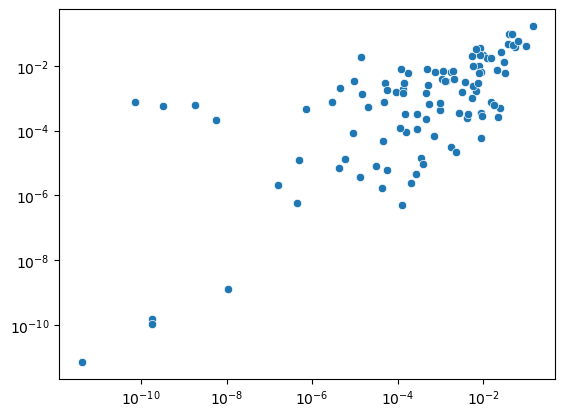

In [182]:
count_p = 0
p_tmp = p_vec_new[count_p]
x = Ri_fit_avg.copy()[p_tmp]
y = Ri_superAgar_fit_avg.copy()[p_tmp]
# y = Ri_null.copy()

id_ = np.where((x > 1e-2) & (y > 1e-2))[0]
id_ = np.where((x > 0))[0]
plt_ = sns.scatterplot(x=x[id_], y=y[id_])
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

In [186]:
df_summary = pd.DataFrame()
for count_p, p_tmp in enumerate(p_vec_new):
    x = Ri_fit_avg.copy()[p_tmp]
    y = Ri_superAgar_fit_avg.copy()[p_tmp]

    print(np.min(x[x != 0]))
    print(np.min(y[y != 0]))

    print(f'# metabs with Ri == 0 for no-microcosm = {len(x[x == 0])}')
    print(f'# metabs with Ri == 0 for supernatant-agar = {len(y[y == 0])}')

    x[x == 0] = 1e-15
    y[y == 0] = 1e-15

    x_full = x.copy()
    y_full = y.copy()


    id_2 = np.where((x > 1e-15) & (y <= 1e-15))[0]
    print(f'# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_2)}')

    id_1 = np.where((x <= 1e-15) & (y > 1e-15))[0]
    print(f'# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = {len(id_1)}')

    id_rm = np.where((x == 1e-15) & (y == 1e-15))[0]
    print(f'# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_rm)}')


    # plots
    fig, axes = plt.subplots(1, 2, figsize=(40, 30), sharey="row", sharex="col")
    fig.suptitle(f'Ri fit comparison between no-microcosm and supernatant-agar \n' + \
                 f'# metabs with Ri == 0 for no-microcosm = {len(x[x == 1e-15])}, ' + \
                 f'# metabs with Ri == 0 for supernatant-agar = {len(y[y == 1e-15])}, ' + \
                 f'# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_2)} \n' + \
                 f'# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = {len(id_1)} \n' + \
                 f'# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_rm)}', \
                 fontsize=25)
    fig.supxlabel('Ri no microcosm (log-scale)', fontsize=50)
    fig.supylabel('Ri supernatant-agar (log-scale)', fontsize=50)


    id_ = list(set(range(len(x_full))) - set(id_rm))
    # id_ = range(len(x))

    x = np.log10(x_full[id_])
    y = np.log10(y_full[id_])
    plt_ = sns.scatterplot(x=x, y=y, ax=axes[0], s=200)
    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[0])
    # plt_.plot([-15, 1], [-15, 1], c="red")
    plt_.plot([-15, 0], [-15, 0], c="red")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)

    title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe[1]) + \
             f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
             f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1])

    axes[0].set_title(title_, size=25)
    plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
    plt_.set_yticklabels(plt_.get_yticklabels(), size=30)


    id_ = np.where((x_full != 1e-15) & (y_full != 1e-15))[0]
    x = np.log10(x_full[id_])
    y = np.log10(y_full[id_])
    plt_ = sns.scatterplot(x=x, y=y, ax=axes[1], s=200)
    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[1])
    # plt_.plot([-15, 1], [-15, 1], c="red")
    plt_.plot([-10, 0], [-10, 0], c="red")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)

    title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe[1]) + \
             f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
             f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1])

    axes[1].set_title(title_, size=25)
    plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
    # plt_.set_yticklabels(plt_.get_yticklabels(), size=20)


    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                            'predictions', 'leaveOneOut', \
                                            '20230411_RiFit_compare_noMicrocosm_vs_supernatantAgar'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, f'RiFit_comparison_p{p_tmp}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)
    
    
    df_tmp = \
        pd.DataFrame(data={"p" : [p_tmp] * 3, 
                           "metric_type" : ["corr_pearson_linear", "corr_pearson_log", 
                                            "corr_spearman"], 
                           "metric" : [corr_val_pe[0], corr_val_pe_log[0], 
                                       corr_val_sp[0]],
                           "pval" : [corr_val_pe[1], corr_val_pe_log[1], 
                                     corr_val_sp[1]]})
    df_summary = pd.concat([df_summary, df_tmp], ignore_index=True)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 28
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 32
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 130


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 29
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 31
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 130


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 33
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 30
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 132


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 36
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 34
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 128


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 41
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 41
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 124


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 42
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 48
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 119


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 47
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 49
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 119


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 48
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 52
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 115


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 67
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 44
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 115


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 57
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 37
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 145


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 41
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 37
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 162


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


1e-15
1e-15
# metabs with Ri == 0 for no-microcosm = 0
# metabs with Ri == 0 for supernatant-agar = 0
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 25
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 44
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 172


/tmp/ipykernel_38334/1794961676.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_38334/1794961676.py:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


In [187]:
fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
fig.suptitle(f'corr, Ri no-microcosm vs supernatant-agar \n', \
             fontsize=20)
fig.supxlabel('p', fontsize=20)
fig.supylabel('correlation', fontsize=20)
plt_ = sns.scatterplot(data=df_summary, x="p", y="metric", \
                       hue="metric_type", ax=axes)
plt_ = sns.lineplot(data=df_summary, x="p", y="metric", \
                       hue="metric_type", ax=axes)
plt_.set_xscale("log", base=10)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                            'predictions', 'leaveOneOut', \
                                            '20230411_RiFit_compare_noMicrocosm_vs_supernatantAgar'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'RiFit_comparison_summary.png'))
fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)

In [191]:
p_vec_new = list(Ri_superAgar_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()
#             df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

    #         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
    #                                     "passage" : [], 
    #                                     "p" : [], 
    #                                     "corr_pe" : [], 
    #                                     "corr_pe_log" : [], 
    #                                     "corr_sp" : [], 
    #                                     "slope" : [], 
    #                                     "corr_pe_pval" : [], 
    #                                     "corr_pe_log_pval" : [], 
    #                                     "corr_sp_pval" : [], 
    #                                     "slope_pval" : []})


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_superAgar_fit_avg[p_tmp].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri dynamical superAgar', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, 
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_super_agar.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
            plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "mag_median_error", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_p{p_tmp}_{norm_status}_superAgar.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [190]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_superAgar', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme_superAgar' + \
                                             f'.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

In [238]:
p_vec_new = list(Ri_superAgar_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()
#             df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

    #         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
    #                                     "passage" : [], 
    #                                     "p" : [], 
    #                                     "corr_pe" : [], 
    #                                     "corr_pe_log" : [], 
    #                                     "corr_sp" : [], 
    #                                     "slope" : [], 
    #                                     "corr_pe_pval" : [], 
    #                                     "corr_pe_log_pval" : [], 
    #                                     "corr_sp_pval" : [], 
    #                                     "slope_pval" : []})


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_superAgar_fit_avg[p_tmp].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri dynamical superAgar', \
                         fontsize=15)
            fig.supylabel('predicted abundance (log scale)', fontsize=15)
            fig.supxlabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, 
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar' + \
                                                    '_only_steadyState_passages' + \
                                                    f'_exclude_passage_transitions_{pass_rm_str}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun_super_agar.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
            plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "corr_pearson_linear", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, corr_val_pe[0], abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, corr_val_pe[1], 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230411_predict_abundance_blind_superAgar' + \
                                                    '_only_steadyState_passages' + \
                                                    f'_exclude_passage_transitions_{pass_rm_str}', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230411_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_p{p_tmp}_{norm_status}_superAgar' + \
                                                     f'_only_steadyState_passages' + \
                                                     f'_exclude_passage_transitions_{pass_rm_str}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)


In [239]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230411_predict_abundance_blind_superAgar' + \
                                                '_only_steadyState_passages' + \
                                                f'_exclude_passage_transitions_{pass_rm_str}', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230411_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme_superAgar' + \
                                             f'_only_steadyState_passages' + \
                                             f'_exclude_passage_transitions_{pass_rm_str}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

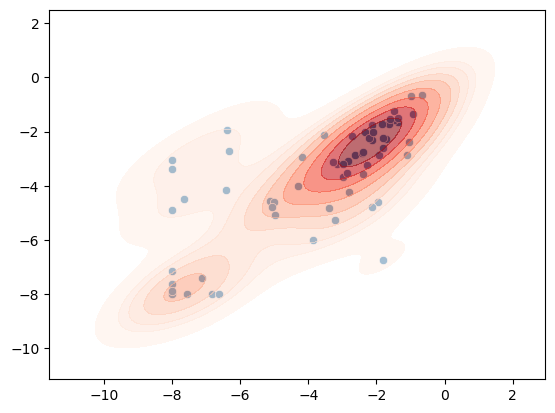

In [244]:
plt_ = sns.scatterplot(x=x, \
                       y=y)

plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds")
# plt_.plot([10**-8, 10**], [10**-8, 10**0], c="red")

In [204]:
passages_exclude = [[], [0], [0, 1]]
x_full = pd.DataFrame()
y_full = pd.DataFrame()

for pass_ in range(num_passages):
    id_pass = [pass_, pass_ + num_passages, pass_ + 2 * num_passages]
    x_full[f'passage_{pass_ + 1}'] = \
        np.mean(np.array(df_speciesAbun.copy().iloc[:, id_pass]), axis=1)
    y_full[f'passage_{pass_ + 1}'] = \
        np.mean(np.array(df_speciesAbun_super_agar.copy().iloc[:, id_pass]), axis=1)
for pass_rm in range(num_passages):
#     print(f'count_p = {count_p}, pass_rmp = {pass_rm}')
    print(f'pass_rmp = {pass_rm}')
#     pass_keep = list(set(range(x_full.shape[1])) - set(pass_rm))
    x = np.log10(np.array(x_full.iloc[:, pass_rm].values)).flatten()
    y = np.log10(np.array(y_full.iloc[:, pass_rm].values)).flatten()
    id_order = np.argsort(x)
    x_order = (x.copy())[id_order]
    y_order = (y.copy())[id_order]
    df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
    window_size = 20
    rolling_avg = df_tmp['y'].rolling(window_size).mean().values
    id_not_nan = np.where(~np.isnan(rolling_avg))[0]
    id_nan = np.where(np.isnan(rolling_avg))[0]
    
    
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'abundance, supernatant-agar vs no-microcosm, passage {pass_rm + 1}', \
                 fontsize=15)
    fig.supylabel('abundance supernatant-agar (log scale)', fontsize=20)
    fig.supxlabel('abundance no-microcosm (log scale)', fontsize=20)

    plt_ = sns.scatterplot(x=x, \
                           y=y, ax=axes)

    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                       ax=axes)
    plt_.plot([-8, 0], [-8, 0], c="red")
    plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

    corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
    corr_val_pe_log = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                               (y - np.mean(y)) / np.std(y))
    mean_error = np.abs(np.median(y - x))
    abs_mean_error = np.median(np.abs(y - x))
    cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
    std_error = np.std(np.abs(y - x))

    id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

    frac_zero = len(id_notzero_zero) / len(x)

    model = sm.OLS(y, x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]


    plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

    title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe[1]) + \
             f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe_log[1]) + \
             f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
             f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                    '{:.3e}'.format(slope_pval) + \
             f'\n fit with p = {p_tmp}'

    axes.set_title(title_, size=10)
    
#     if len(pass_rm) > 0:
#         pass_rm_str = ' '.join(map(str, list(np.array(pass_rm) + 1)))
#         pass_rm_str = pass_rm_str.replace(" ", "_")
#     else:
#         pass_rm_str = "none"

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                            'predictions', 'leaveOneOut', \
                                            '20230411_compareAbundance_microcosms', \
                                            'noMicrocosm_vs_supernatantAgar'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'noMicrocosm_vs_supernatantAgar_' + \
                                             f'passage_{pass_rm + 1}.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

     

pass_rmp = 0
pass_rmp = 1
pass_rmp = 2
pass_rmp = 3
pass_rmp = 4
pass_rmp = 5


In [201]:
x.shape

(63, 6)

# 10 April 2023: Fit growth ratios (blindly, with only inoculum known) using null model Ri fitted from steady-state (passages 3-6). Use no-microcosm data

In [176]:
df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                           df_speciesAbun=df_speciesAbun)
Ri_null = null_Ri_2(df_speciesMetab, df_cons_abun_prod_split)

In [178]:
num_iter = 100
num_species = df_speciesAbun.shape[0]
pass_ = 0
norm_status_vec = ["unnorm"]
p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.8), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()
#             df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

    #         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
    #                                     "passage" : [], 
    #                                     "p" : [], 
    #                                     "corr_pe" : [], 
    #                                     "corr_pe_log" : [], 
    #                                     "corr_sp" : [], 
    #                                     "slope" : [], 
    #                                     "corr_pe_pval" : [], 
    #                                     "corr_pe_log_pval" : [], 
    #                                     "corr_sp_pval" : [], 
    #                                     "slope_pval" : []})


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_null.copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'null Ri at ss', \
                         fontsize=15)
            fig.supxlabel('predicted abundance (log scale)', fontsize=15)
            fig.supylabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, 
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230410_predict_abundance_blind_nullRiSS', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
            plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "mag_median_error", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230410_predict_abundance_blind_nullRiSS', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230410_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_nullRi_ss_p{p_tmp}_{norm_status}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)

    #             geometric mean of growth ratios
    #             x = np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten()
    #             y = np.array(growth_rate_all[num_iter - 1])[:, b_].flatten()

#             fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'mean predicted vs mean observed abundance passage {pass_ + 1}->{pass_ + 2}, \n' + 
#                          f'Ri fit at ss', \
#                          fontsize=15)
#             fig.supxlabel('mean predicted growth ratio (log scale)', fontsize=15)
#             fig.supylabel('mean observed growth ratio (log scale)', fontsize=15)

#             x = []
#             y = []

#             for species_ in range(num_species):
#                 id_ = np.where(df_speciesAbun_ratio_tmp_.iloc[species_, :].values > 0)[0]
#                 if len(id_) > 0:
#                     x.append(10**np.mean(np.log10(df_speciesAbun_ratio_tmp_.iloc[species_, id_])))
#                     y.append(10**np.mean(np.log10(growth_rate_all[num_iter - 1].iloc[species_, id_])))
#             x = np.array(x)
#             y = np.array(y)
#             id_ = np.where(x > 0)[0]
#             id_zero = np.where((x <= thresh_zero))[0]
#             x = np.log10(x[id_])
#             y = np.log10(y[id_])
#             # y=np.random.permutation(x)
#             y[y <= -5] = -5
#             id_ = np.where((y > -100))[0]
#             x = x[id_]
#             y = y[id_]

#             plt_ = sns.scatterplot(x=x, \
#                                    y=y, ax=axes)

#             plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
#                                ax=axes)
#             plt_.plot([-4, 2], [-4, 2], c="red")

#             corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
#             corr_val_pe_log = scipy.stats.pearsonr(x, y)
#             corr_val_sp = scipy.stats.spearmanr(x, y)
#             corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
#                                                        (y - np.mean(y)) / np.std(y))

#             mean_error = np.abs(np.median(y - x))
#             abs_mean_error = np.median(np.abs(y - x))
#             cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
#             std_error = np.std(np.abs(y - x))

#             id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

#             frac_zero = len(id_notzero_zero) / len(x)

#             model = sm.OLS(y, x).fit()
#             slope = model.params[0]
#             slope_pval = model.pvalues[0]

#     #                 df_tmp = \
#     #                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#     #                                        "passage" : [pass_] * 7, 
#     #                                        "p" : [p_tmp] * 7, 
#     #                                        "metric_type" : ["corr_pearson_log", 
#     #                                                         "corr_spearman", "slope", "mag_median_error", \
#     #                                                         "abs_median_error", \
#     #                                                         "std_error", "FNR"], 
#     #                                        "metric" : [corr_val_pe_log[0], 
#     #                                                    corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
#     #                                                    frac_zero],
#     #                                        "pval" : [corr_val_pe_log[1], 
#     #                                                  corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
#     #                 df_corr_slope_mean = pd.concat([df_corr_slope_mean, df_tmp], ignore_index=True)




#             plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

#             title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_pe[1]) + \
#                      f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_pe_log[1]) + \
#                      f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_sp[1]) + \
#                      f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
#                             '{:.3e}'.format(slope_pval) + \
#                      f'\n fit with p = {p_tmp}'

#             axes.set_title(title_, size=10)

#             save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', \
#                                                     '20230409_iterative_scheme', \
#                                                     'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                     norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#             if not os.path.exists(save_dir):
#                # Create a new directory because it does not exist
#                os.makedirs(save_dir)

#             save_file = os.path.abspath(os.path.join(save_dir, 
#                                                      f'20230409_meanPredicted_vs_meanObserved_growth_' + \
#                                                      f'ratios_' + \
#                                                      f'passage_{pass_ + 1}to{pass_ + 2}_' + \
#                                                      f'iterative_new_scheme_' + \
#                                                      f'_Ri_fit_ss_ptmp{p_tmp}_{norm_status}.png'))
#             fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#             plt.close(fig.figure)

#         Overall plots
# for pass_ in range(num_passages):
#     fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#     fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
#                  f' passage {pass_ + 1}', \
#                  fontsize=20)
#     fig.supxlabel('p', fontsize=20)
#     fig.supylabel('correlation or slope', fontsize=20)
#     df_corr_slope_tmp = df_corr_slope.copy()
#     df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
#     plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
#                            hue="metric_type", ax=axes)
#     plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
#                            hue="metric_type", ax=axes)
#     plt_.set_xscale("log", base=10)

#     save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                 'predictions', 'leaveOneOut', \
#                                                 '20230409_predict_abundance_blind', \
#                                                 'predicted_vs_observed_abundance_LeaveOneOutRi', \
#                                             norm_status, 
#                                                 f'passage_{pass_ + 1}'))
#     if not os.path.exists(save_dir):
#        # Create a new directory because it does not exist
#        os.makedirs(save_dir)

#     save_file = os.path.abspath(os.path.join(save_dir, 
#                                              f'20230409_corr_slope_predicted_vs_observed_abundance_' + \
#                                              f'passage_{pass_ + 1}_iterative_new_scheme' + \
#                                              f'.png'))
#     fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#     plt.close(fig.figure)
        
        
#         summary statistics
#         fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#         fig.suptitle(f'corr, slope for mean predicted vs mean observed growth ratios \n' + \
#                      f' passage {pass_ + 1}->{pass_ + 2}', \
#                      fontsize=20)
#         fig.supxlabel('p', fontsize=20)
#         fig.supylabel('correlation or slope', fontsize=20)

#         plt_ = sns.scatterplot(data=df_corr_slope_mean, x="p", y="metric", \
#                                hue="metric_type", ax=axes)
#         plt_.set_xscale("log", base=10)

#         save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', '20230403_iterative_scheme', \
#                                                     'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                 norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#         if not os.path.exists(save_dir):
#            # Create a new directory because it does not exist
#            os.makedirs(save_dir)

#         save_file = os.path.abspath(os.path.join(save_dir, 
#                                                  f'20230403_corr_slope_meanPredicted_vs_' +\
#                                                  f'meanObserved_growth_ratios_' + \
#                                                  f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
#                                                  f'.png'))
#         fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#         plt.close(fig.figure)

In [179]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230410_predict_abundance_blind_nullRiSS', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230410_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 10 April 2023 Compare Ri fit with no-microcosm and supernatant-agar

In [80]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230409_iterative_scheme'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230409_fit_Ri_ss_LeaveOneOutRi.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_fit_all = save_obj["Ri_fit_all"]
Ri_fit_avg = save_obj["Ri_fit_avg"]

In [81]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230409_iterative_scheme_superAgar'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230409_fit_Ri_ss_LeaveOneOutRi.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_superAgar_fit_all = save_obj["Ri_superAgar_fit_all"]
Ri_superAgar_fit_avg = save_obj["Ri_superAgar_fit_avg"]

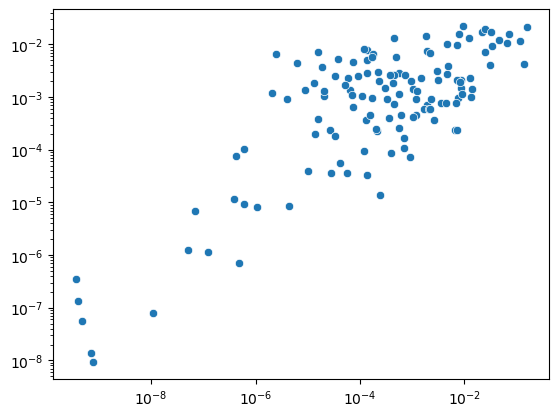

In [175]:
x = Ri_fit_avg.copy()[2]
# y = Ri_superAgar_fit_avg.copy()[2]
y = Ri_null.copy()

id_ = np.where((x > 1e-2) & (y > 1e-2))[0]
id_ = np.where((x > 0))[0]
plt_ = sns.scatterplot(x=x[id_], y=y[id_])
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)

In [161]:
metab_names = df_metabNames.copy()["met_name"].values[df_metabIds.iloc[:, 0].values - 1]
metab_names[id_]
df_speciesMetab_binary = np.array(df_speciesMetab.copy())
df_speciesMetab_binary[df_speciesMetab_binary > 0.3] = 1
df_speciesMetab_binary[df_speciesMetab_binary <= 0.3] = 0
num_species = np.sum(df_speciesMetab_binary, axis=0)
num_species[id_]

df_tmp = pd.DataFrame(data={"metab" : metab_names[id_], "#species" : num_species[id_]})
print(df_tmp)

                                   metab  #species
0                 N-METHYL-ASPARTIC ACID      14.0
1                    MANNOSE 6-PHOSPHATE      45.0
2                           BETA-ALANINE      32.0
3                IS_METHIONINE-METHYL-D3       2.0
4          IS_PHENYLALANINE-2,3,4,5,6-D5       4.0
5   IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID       4.0
6                   4-AMINOBUTANOIC ACID      17.0
7                 5'-METHYLTHIOADENOSINE      45.0
8                              ADENOSINE      45.0
9                           HYPOXANTHINE      32.0
10                          NICOTINAMIDE      29.0


In [152]:
id_1 = np.where(np.array(df_speciesMetab_binary)[:, np.array(id_)[[3]]] == 1)[0]
pass_ = 5
df_speciesAbun.iloc[id_1, [pass_, pass_ + num_passages, pass_ + 2 * num_passages]]

p6_r0         p6_r1         p6_r2
8   1.863944e-01  1.133752e-01  3.010259e-01
53  8.122706e-08  7.695638e-08  1.591267e-07

In [153]:
abuns = np.array(df_speciesAbun.iloc[:, [pass_, pass_ + num_passages, pass_ + 2 * num_passages]])
abuns = 10**np.mean(np.log10(abuns), axis=1)
rank_abuns = np.argsort(-abuns)
ranks_ = np.arange(len(rank_abuns))
ranks_[rank_abuns] = np.arange(len(rank_abuns))
print(np.sort(-abuns))
abuns[id_1]
ranks_[id_1]

[-2.74516573e-01 -2.12676731e-01 -1.85289861e-01 -4.34391488e-02
 -3.59522240e-02 -3.48225546e-02 -2.87501669e-02 -2.43740061e-02
 -2.20148608e-02 -1.85958800e-02 -1.29871393e-02 -8.31939396e-03
 -7.51200590e-03 -6.49728130e-03 -5.15584067e-03 -4.22675119e-03
 -3.87825271e-03 -2.92278224e-03 -1.51632089e-03 -1.49499591e-03
 -1.08590388e-03 -7.18467945e-04 -3.78785591e-04 -2.07217310e-04
 -1.73622278e-04 -1.69362585e-04 -1.68881135e-04 -1.02646184e-04
 -4.26981688e-05 -3.64710385e-05 -2.51528335e-05 -1.98535295e-05
 -1.89584900e-05 -1.27641671e-05 -1.19470503e-05 -7.65671827e-06
 -3.70698341e-06 -3.63145468e-06 -3.19086362e-06 -2.08384342e-06
 -8.03000374e-07 -1.57253650e-07 -1.41406493e-07 -1.37106157e-07
 -1.08699981e-07 -9.98227352e-08 -8.78169288e-08 -8.31910027e-08
 -7.21939479e-08 -5.58656176e-08 -4.01367144e-08 -3.17600056e-08
 -2.50696815e-08 -1.98546723e-08 -1.00000000e-08 -1.00000000e-08
 -1.00000000e-08 -1.00000000e-08 -1.00000000e-08 -1.00000000e-08
 -1.00000000e-08 -1.00000

array([ 2, 45])

In [154]:
np.sum(np.array(df_speciesMetab_binary)[id_1, :], axis=1)

array([19., 24.])

In [157]:
np.array(df_speciesMetab)[id_1[0], :]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06213794, 0.36647416,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02942225,
       0.        , 0.        , 0.        , 0.28670176, 0.        ,
       0.        , 0.        , 0.28968225, 0.        , 0.        ,
       0.37707107, 0.        , 0.        , 0.        , 0.        ,
       0.015037  , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [164]:
z = np.sum(np.array(df_speciesMetab_binary), axis=0)
id_order = np.argsort(-z)
ranks_ = np.arange(len(z))
ranks_[id_order] = np.arange(len(z))
ranks_[id_]

array([ 64,   2,  11, 178, 144, 152,  56,   0,   1,  12,  19])

# 10 April 2023: Fit growth ratios (blindly, with only inoculum known) using Ri fitted with dynamics. Use no-microcosm data

In [62]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
num_passages = 6
Ri_fit_all = {}
Ri_fit_avg = {}
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_fit_avg[p_tmp] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab.copy(), \
                                                    df_speciesAbun_prev.copy(), \
                                                    df_speciesAbun_next.copy(), \
                                                    df_speciesAbun_ratio.copy(), p_tmp, num_passages, \
                                                    id_species)
        Ri_fit_avg[p_tmp] += Ri_fit_all[p_tmp][species_, :]
        
    Ri_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230410_predict_abundance_blind'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230410_fit_Ri_different_p_LeaveOneOutRi.pickle'))

save_obj = {"Ri_fit_all" : Ri_fit_all, "Ri_fit_avg" : Ri_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.01
count_p = 2, p = 0.05
count_p = 3, p = 0.06
count_p = 4, p = 0.07
count_p = 5, p = 0.08
count_p = 6, p = 0.09
count_p = 7, p = 0.1
count_p = 8, p = 0.2
count_p = 9, p = 0.3
count_p = 10, p = 0.4
count_p = 11, p = 0.5


In [58]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230410_predict_abundance_blind'))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230410_fit_Ri_different_p_LeaveOneOutRi.pickle'))

with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
    
Ri_fit_avg = save_obj['Ri_fit_avg']

In [63]:
p_vec_new = list(Ri_fit_avg.keys())

num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()
#             df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

    #         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
    #                                     "passage" : [], 
    #                                     "p" : [], 
    #                                     "corr_pe" : [], 
    #                                     "corr_pe_log" : [], 
    #                                     "corr_sp" : [], 
    #                                     "slope" : [], 
    #                                     "corr_pe_pval" : [], 
    #                                     "corr_pe_log_pval" : [], 
    #                                     "corr_sp_pval" : [], 
    #                                     "slope_pval" : []})


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_fit_avg[p_tmp].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri fit at ss', \
                         fontsize=15)
            fig.supxlabel('predicted abundance (log scale)', fontsize=15)
            fig.supylabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, 
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230410_predict_abundance_blind', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_Ri_fit_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
            plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "mag_median_error", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230410_predict_abundance_blind', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230410_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_p{p_tmp}_{norm_status}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)

    #             geometric mean of growth ratios
    #             x = np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten()
    #             y = np.array(growth_rate_all[num_iter - 1])[:, b_].flatten()

#             fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'mean predicted vs mean observed abundance passage {pass_ + 1}->{pass_ + 2}, \n' + 
#                          f'Ri fit at ss', \
#                          fontsize=15)
#             fig.supxlabel('mean predicted growth ratio (log scale)', fontsize=15)
#             fig.supylabel('mean observed growth ratio (log scale)', fontsize=15)

#             x = []
#             y = []

#             for species_ in range(num_species):
#                 id_ = np.where(df_speciesAbun_ratio_tmp_.iloc[species_, :].values > 0)[0]
#                 if len(id_) > 0:
#                     x.append(10**np.mean(np.log10(df_speciesAbun_ratio_tmp_.iloc[species_, id_])))
#                     y.append(10**np.mean(np.log10(growth_rate_all[num_iter - 1].iloc[species_, id_])))
#             x = np.array(x)
#             y = np.array(y)
#             id_ = np.where(x > 0)[0]
#             id_zero = np.where((x <= thresh_zero))[0]
#             x = np.log10(x[id_])
#             y = np.log10(y[id_])
#             # y=np.random.permutation(x)
#             y[y <= -5] = -5
#             id_ = np.where((y > -100))[0]
#             x = x[id_]
#             y = y[id_]

#             plt_ = sns.scatterplot(x=x, \
#                                    y=y, ax=axes)

#             plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
#                                ax=axes)
#             plt_.plot([-4, 2], [-4, 2], c="red")

#             corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
#             corr_val_pe_log = scipy.stats.pearsonr(x, y)
#             corr_val_sp = scipy.stats.spearmanr(x, y)
#             corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
#                                                        (y - np.mean(y)) / np.std(y))

#             mean_error = np.abs(np.median(y - x))
#             abs_mean_error = np.median(np.abs(y - x))
#             cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
#             std_error = np.std(np.abs(y - x))

#             id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

#             frac_zero = len(id_notzero_zero) / len(x)

#             model = sm.OLS(y, x).fit()
#             slope = model.params[0]
#             slope_pval = model.pvalues[0]

#     #                 df_tmp = \
#     #                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#     #                                        "passage" : [pass_] * 7, 
#     #                                        "p" : [p_tmp] * 7, 
#     #                                        "metric_type" : ["corr_pearson_log", 
#     #                                                         "corr_spearman", "slope", "mag_median_error", \
#     #                                                         "abs_median_error", \
#     #                                                         "std_error", "FNR"], 
#     #                                        "metric" : [corr_val_pe_log[0], 
#     #                                                    corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
#     #                                                    frac_zero],
#     #                                        "pval" : [corr_val_pe_log[1], 
#     #                                                  corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
#     #                 df_corr_slope_mean = pd.concat([df_corr_slope_mean, df_tmp], ignore_index=True)




#             plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

#             title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_pe[1]) + \
#                      f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_pe_log[1]) + \
#                      f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_sp[1]) + \
#                      f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
#                             '{:.3e}'.format(slope_pval) + \
#                      f'\n fit with p = {p_tmp}'

#             axes.set_title(title_, size=10)

#             save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', \
#                                                     '20230409_iterative_scheme', \
#                                                     'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                     norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#             if not os.path.exists(save_dir):
#                # Create a new directory because it does not exist
#                os.makedirs(save_dir)

#             save_file = os.path.abspath(os.path.join(save_dir, 
#                                                      f'20230409_meanPredicted_vs_meanObserved_growth_' + \
#                                                      f'ratios_' + \
#                                                      f'passage_{pass_ + 1}to{pass_ + 2}_' + \
#                                                      f'iterative_new_scheme_' + \
#                                                      f'_Ri_fit_ss_ptmp{p_tmp}_{norm_status}.png'))
#             fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#             plt.close(fig.figure)

#         Overall plots
# for pass_ in range(num_passages):
#     fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#     fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
#                  f' passage {pass_ + 1}', \
#                  fontsize=20)
#     fig.supxlabel('p', fontsize=20)
#     fig.supylabel('correlation or slope', fontsize=20)
#     df_corr_slope_tmp = df_corr_slope.copy()
#     df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
#     plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
#                            hue="metric_type", ax=axes)
#     plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
#                            hue="metric_type", ax=axes)
#     plt_.set_xscale("log", base=10)

#     save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                 'predictions', 'leaveOneOut', \
#                                                 '20230409_predict_abundance_blind', \
#                                                 'predicted_vs_observed_abundance_LeaveOneOutRi', \
#                                             norm_status, 
#                                                 f'passage_{pass_ + 1}'))
#     if not os.path.exists(save_dir):
#        # Create a new directory because it does not exist
#        os.makedirs(save_dir)

#     save_file = os.path.abspath(os.path.join(save_dir, 
#                                              f'20230409_corr_slope_predicted_vs_observed_abundance_' + \
#                                              f'passage_{pass_ + 1}_iterative_new_scheme' + \
#                                              f'.png'))
#     fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#     plt.close(fig.figure)
        
        
#         summary statistics
#         fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#         fig.suptitle(f'corr, slope for mean predicted vs mean observed growth ratios \n' + \
#                      f' passage {pass_ + 1}->{pass_ + 2}', \
#                      fontsize=20)
#         fig.supxlabel('p', fontsize=20)
#         fig.supylabel('correlation or slope', fontsize=20)

#         plt_ = sns.scatterplot(data=df_corr_slope_mean, x="p", y="metric", \
#                                hue="metric_type", ax=axes)
#         plt_.set_xscale("log", base=10)

#         save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', '20230403_iterative_scheme', \
#                                                     'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                 norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#         if not os.path.exists(save_dir):
#            # Create a new directory because it does not exist
#            os.makedirs(save_dir)

#         save_file = os.path.abspath(os.path.join(save_dir, 
#                                                  f'20230403_corr_slope_meanPredicted_vs_' +\
#                                                  f'meanObserved_growth_ratios_' + \
#                                                  f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
#                                                  f'.png'))
#         fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#         plt.close(fig.figure)

In [64]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230410_predict_abundance_blind', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230410_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 9 April 2023: Fit growth ratios (blindly, with only inoculum known) using Ri fitted from steady-state (passages 3-6). Use no-microcosm data

In [1]:
def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate_blind(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
#         pass_ = int(sample_.split("_")[0][1])
#         brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [47]:
model.params

array([0.74555643])

In [56]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.8), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()
#             df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

    #         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
    #                                     "passage" : [], 
    #                                     "p" : [], 
    #                                     "corr_pe" : [], 
    #                                     "corr_pe_log" : [], 
    #                                     "corr_sp" : [], 
    #                                     "slope" : [], 
    #                                     "corr_pe_pval" : [], 
    #                                     "corr_pe_log_pval" : [], 
    #                                     "corr_sp_pval" : [], 
    #                                     "slope_pval" : []})


            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_fit_avg[2].copy()
            
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri fit at ss', \
                         fontsize=15)
            fig.supxlabel('predicted abundance (log scale)', fontsize=15)
            fig.supylabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  None, 
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230409_predict_abundance_blind', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
            plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "mag_median_error", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230409_predict_abundance_blind', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230409_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_ss_p{p_tmp}_{norm_status}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)

    #             geometric mean of growth ratios
    #             x = np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten()
    #             y = np.array(growth_rate_all[num_iter - 1])[:, b_].flatten()

#             fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'mean predicted vs mean observed abundance passage {pass_ + 1}->{pass_ + 2}, \n' + 
#                          f'Ri fit at ss', \
#                          fontsize=15)
#             fig.supxlabel('mean predicted growth ratio (log scale)', fontsize=15)
#             fig.supylabel('mean observed growth ratio (log scale)', fontsize=15)

#             x = []
#             y = []

#             for species_ in range(num_species):
#                 id_ = np.where(df_speciesAbun_ratio_tmp_.iloc[species_, :].values > 0)[0]
#                 if len(id_) > 0:
#                     x.append(10**np.mean(np.log10(df_speciesAbun_ratio_tmp_.iloc[species_, id_])))
#                     y.append(10**np.mean(np.log10(growth_rate_all[num_iter - 1].iloc[species_, id_])))
#             x = np.array(x)
#             y = np.array(y)
#             id_ = np.where(x > 0)[0]
#             id_zero = np.where((x <= thresh_zero))[0]
#             x = np.log10(x[id_])
#             y = np.log10(y[id_])
#             # y=np.random.permutation(x)
#             y[y <= -5] = -5
#             id_ = np.where((y > -100))[0]
#             x = x[id_]
#             y = y[id_]

#             plt_ = sns.scatterplot(x=x, \
#                                    y=y, ax=axes)

#             plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
#                                ax=axes)
#             plt_.plot([-4, 2], [-4, 2], c="red")

#             corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
#             corr_val_pe_log = scipy.stats.pearsonr(x, y)
#             corr_val_sp = scipy.stats.spearmanr(x, y)
#             corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
#                                                        (y - np.mean(y)) / np.std(y))

#             mean_error = np.abs(np.median(y - x))
#             abs_mean_error = np.median(np.abs(y - x))
#             cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
#             std_error = np.std(np.abs(y - x))

#             id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

#             frac_zero = len(id_notzero_zero) / len(x)

#             model = sm.OLS(y, x).fit()
#             slope = model.params[0]
#             slope_pval = model.pvalues[0]

#     #                 df_tmp = \
#     #                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#     #                                        "passage" : [pass_] * 7, 
#     #                                        "p" : [p_tmp] * 7, 
#     #                                        "metric_type" : ["corr_pearson_log", 
#     #                                                         "corr_spearman", "slope", "mag_median_error", \
#     #                                                         "abs_median_error", \
#     #                                                         "std_error", "FNR"], 
#     #                                        "metric" : [corr_val_pe_log[0], 
#     #                                                    corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
#     #                                                    frac_zero],
#     #                                        "pval" : [corr_val_pe_log[1], 
#     #                                                  corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
#     #                 df_corr_slope_mean = pd.concat([df_corr_slope_mean, df_tmp], ignore_index=True)




#             plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

#             title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_pe[1]) + \
#                      f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_pe_log[1]) + \
#                      f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_sp[1]) + \
#                      f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
#                             '{:.3e}'.format(slope_pval) + \
#                      f'\n fit with p = {p_tmp}'

#             axes.set_title(title_, size=10)

#             save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', \
#                                                     '20230409_iterative_scheme', \
#                                                     'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                     norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#             if not os.path.exists(save_dir):
#                # Create a new directory because it does not exist
#                os.makedirs(save_dir)

#             save_file = os.path.abspath(os.path.join(save_dir, 
#                                                      f'20230409_meanPredicted_vs_meanObserved_growth_' + \
#                                                      f'ratios_' + \
#                                                      f'passage_{pass_ + 1}to{pass_ + 2}_' + \
#                                                      f'iterative_new_scheme_' + \
#                                                      f'_Ri_fit_ss_ptmp{p_tmp}_{norm_status}.png'))
#             fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#             plt.close(fig.figure)

#         Overall plots
# for pass_ in range(num_passages):
#     fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#     fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
#                  f' passage {pass_ + 1}', \
#                  fontsize=20)
#     fig.supxlabel('p', fontsize=20)
#     fig.supylabel('correlation or slope', fontsize=20)
#     df_corr_slope_tmp = df_corr_slope.copy()
#     df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
#     plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
#                            hue="metric_type", ax=axes)
#     plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
#                            hue="metric_type", ax=axes)
#     plt_.set_xscale("log", base=10)

#     save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                 'predictions', 'leaveOneOut', \
#                                                 '20230409_predict_abundance_blind', \
#                                                 'predicted_vs_observed_abundance_LeaveOneOutRi', \
#                                             norm_status, 
#                                                 f'passage_{pass_ + 1}'))
#     if not os.path.exists(save_dir):
#        # Create a new directory because it does not exist
#        os.makedirs(save_dir)

#     save_file = os.path.abspath(os.path.join(save_dir, 
#                                              f'20230409_corr_slope_predicted_vs_observed_abundance_' + \
#                                              f'passage_{pass_ + 1}_iterative_new_scheme' + \
#                                              f'.png'))
#     fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#     plt.close(fig.figure)
        
        
#         summary statistics
#         fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#         fig.suptitle(f'corr, slope for mean predicted vs mean observed growth ratios \n' + \
#                      f' passage {pass_ + 1}->{pass_ + 2}', \
#                      fontsize=20)
#         fig.supxlabel('p', fontsize=20)
#         fig.supylabel('correlation or slope', fontsize=20)

#         plt_ = sns.scatterplot(data=df_corr_slope_mean, x="p", y="metric", \
#                                hue="metric_type", ax=axes)
#         plt_.set_xscale("log", base=10)

#         save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', '20230403_iterative_scheme', \
#                                                     'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                 norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#         if not os.path.exists(save_dir):
#            # Create a new directory because it does not exist
#            os.makedirs(save_dir)

#         save_file = os.path.abspath(os.path.join(save_dir, 
#                                                  f'20230403_corr_slope_meanPredicted_vs_' +\
#                                                  f'meanObserved_growth_ratios_' + \
#                                                  f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
#                                                  f'.png'))
#         fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#         plt.close(fig.figure)

In [57]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230409_predict_abundance_blind', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230409_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

# 9 April 2023: Fit growth ratios from inoculum to passage 1 (blindly, with only inoculum known) using Ri fitted from steady-state (passages 3-6). Use no-microcosm data. For passages >=2 use the growth ratio from inoculum to passage 1

In [66]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230409_iterative_scheme'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230409_fit_Ri_ss_LeaveOneOutRi.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_fit_all = save_obj["Ri_fit_all"]
Ri_fit_avg = save_obj["Ri_fit_avg"]

In [71]:
pass_ 

0

In [72]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.8), num=100), decimals=6)
p_vec_new = [0.001, 0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5]
# predicted_growth_ratios = {}
# range(num_passages - 1)
df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})

df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                   "passage" : [], 
                                   "p" : [],
                                   "metric_type" : [], 
                                   "metric" : [],
                                   "pval" : []})
for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for count_p, p_tmp in enumerate(p_vec_new):
        for pass_ in range(num_passages):
    #         predicted_growth_ratios[norm_status][pass_] = {}
    #         growth_rate_all = np.zeros((num_iter, num_species))
            if pass_ == 0:
                df_speciesAbun_prev_tmp_ = \
                    df_speciesAbun_inoc.copy().iloc[:, :]
            else:
                df_tmp = growth_rate_all[num_iter - 1].copy()
#                 df_speciesAbun_prev_tmp_.columns = df_tmp.columns.values
                for col_ in df_tmp.columns.values:
                    df_speciesAbun_prev_tmp_[col_] = \
                        df_tmp[col_].values * df_speciesAbun_prev_tmp_[col_].values
            df_speciesAbun_next_tmp_ = df_speciesAbun_prev_tmp_.copy()
#             df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

    #         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
    #                                     "passage" : [], 
    #                                     "p" : [], 
    #                                     "corr_pe" : [], 
    #                                     "corr_pe_log" : [], 
    #                                     "corr_sp" : [], 
    #                                     "slope" : [], 
    #                                     "corr_pe_pval" : [], 
    #                                     "corr_pe_log_pval" : [], 
    #                                     "corr_sp_pval" : [], 
    #                                     "slope_pval" : []})


            Ri_avg = Ri_fit_avg[2].copy()
            


            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed abundances passage {pass_ + 1}, \n' + 
                         f'Ri fit at ss', \
                         fontsize=15)
            fig.supxlabel('predicted abundance (log scale)', fontsize=15)
            fig.supylabel('observed abundance (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4
            
            if pass_ == 0:
                growth_rate_all = {}
                growth_rate_all[0] = pd.DataFrame()
                for col_ in df_speciesAbun_prev_tmp_.columns.values:
                    growth_rate_all[0][col_] = np.ones((num_species))

                for iter_ in range(num_iter):
                    if iter_ == 0:
                        iter_id = iter_
                    else:
                        iter_id = iter_ - 1
                    if norm_status == "norm":    
                        iter_thresh = -1
                    else:
                        iter_thresh = -1

                    if norm_status == "norm":
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy())
                    else:
                        df_growth_rate = compute_growth_ratio_iterate_blind(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      None, 
                                                                      norm_=False)

                    growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230409_predict_abundance_blind' + \
                                                    '_fit_growth_ratio_only_pass1', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_abundance', \
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_abundance_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)
            
            df_tmp = pd.DataFrame()
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                df_tmp[col_] = \
                    growth_rate_all[num_iter - 1].copy()[col_].values * \
                    df_speciesAbun_prev_tmp_[col_].values

            b_ = range(3)
            x = \
                np.array(df_speciesAbun.copy().iloc[:, [pass_, \
                                                             pass_ + num_passages, \
                                                             pass_ + 2 * num_passages]])
            x = 10**(np.mean(np.log10(x), axis=1)).flatten()
            y = np.array(df_tmp.copy())[:, :].flatten()
            id_ = np.where(x > 0)[0]
            id_zero = np.where((x <= thresh_zero))[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -8] = -8
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

    #                 rolling mean
            id_order = np.argsort(x)
            x_order = (x.copy())[id_order]
            y_order = (y.copy())[id_order]
            df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
            window_size = 20
            rolling_avg = df_tmp['y'].rolling(window_size).mean().values
            id_not_nan = np.where(~np.isnan(rolling_avg))[0]
            id_nan = np.where(np.isnan(rolling_avg))[0]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-8, 0], [-8, 0], c="red")
            plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

            frac_zero = len(id_notzero_zero) / len(x)

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                   "passage" : [pass_] * 7, 
                                   "p" : [p_tmp] * 7, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "mag_median_error", \
                                                    "abs_median_error", \
                                                    "std_error", "FNR"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
                                               frac_zero],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


            plt_.plot([-8, 0], [slope * (-8), slope * 0], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', \
                                                    '20230409_predict_abundance_blind' + \
                                                    '_fit_growth_ratio_only_pass1', \
                                                    'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230409_predicted_vs_observed_abundance_' + \
                                                     f'passage_{pass_ + 1}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_ss_p{p_tmp}_{norm_status}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)

    #             geometric mean of growth ratios
    #             x = np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten()
    #             y = np.array(growth_rate_all[num_iter - 1])[:, b_].flatten()

#             fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#             fig.suptitle(f'mean predicted vs mean observed abundance passage {pass_ + 1}->{pass_ + 2}, \n' + 
#                          f'Ri fit at ss', \
#                          fontsize=15)
#             fig.supxlabel('mean predicted growth ratio (log scale)', fontsize=15)
#             fig.supylabel('mean observed growth ratio (log scale)', fontsize=15)

#             x = []
#             y = []

#             for species_ in range(num_species):
#                 id_ = np.where(df_speciesAbun_ratio_tmp_.iloc[species_, :].values > 0)[0]
#                 if len(id_) > 0:
#                     x.append(10**np.mean(np.log10(df_speciesAbun_ratio_tmp_.iloc[species_, id_])))
#                     y.append(10**np.mean(np.log10(growth_rate_all[num_iter - 1].iloc[species_, id_])))
#             x = np.array(x)
#             y = np.array(y)
#             id_ = np.where(x > 0)[0]
#             id_zero = np.where((x <= thresh_zero))[0]
#             x = np.log10(x[id_])
#             y = np.log10(y[id_])
#             # y=np.random.permutation(x)
#             y[y <= -5] = -5
#             id_ = np.where((y > -100))[0]
#             x = x[id_]
#             y = y[id_]

#             plt_ = sns.scatterplot(x=x, \
#                                    y=y, ax=axes)

#             plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
#                                ax=axes)
#             plt_.plot([-4, 2], [-4, 2], c="red")

#             corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
#             corr_val_pe_log = scipy.stats.pearsonr(x, y)
#             corr_val_sp = scipy.stats.spearmanr(x, y)
#             corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
#                                                        (y - np.mean(y)) / np.std(y))

#             mean_error = np.abs(np.median(y - x))
#             abs_mean_error = np.median(np.abs(y - x))
#             cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
#             std_error = np.std(np.abs(y - x))

#             id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

#             frac_zero = len(id_notzero_zero) / len(x)

#             model = sm.OLS(y, x).fit()
#             slope = model.params[0]
#             slope_pval = model.pvalues[0]

#     #                 df_tmp = \
#     #                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#     #                                        "passage" : [pass_] * 7, 
#     #                                        "p" : [p_tmp] * 7, 
#     #                                        "metric_type" : ["corr_pearson_log", 
#     #                                                         "corr_spearman", "slope", "mag_median_error", \
#     #                                                         "abs_median_error", \
#     #                                                         "std_error", "FNR"], 
#     #                                        "metric" : [corr_val_pe_log[0], 
#     #                                                    corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
#     #                                                    frac_zero],
#     #                                        "pval" : [corr_val_pe_log[1], 
#     #                                                  corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
#     #                 df_corr_slope_mean = pd.concat([df_corr_slope_mean, df_tmp], ignore_index=True)




#             plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

#             title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_pe[1]) + \
#                      f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_pe_log[1]) + \
#                      f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
#                             '{:.3e}'.format(corr_val_sp[1]) + \
#                      f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
#                             '{:.3e}'.format(slope_pval) + \
#                      f'\n fit with p = {p_tmp}'

#             axes.set_title(title_, size=10)

#             save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', \
#                                                     '20230409_iterative_scheme', \
#                                                     'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                     norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#             if not os.path.exists(save_dir):
#                # Create a new directory because it does not exist
#                os.makedirs(save_dir)

#             save_file = os.path.abspath(os.path.join(save_dir, 
#                                                      f'20230409_meanPredicted_vs_meanObserved_growth_' + \
#                                                      f'ratios_' + \
#                                                      f'passage_{pass_ + 1}to{pass_ + 2}_' + \
#                                                      f'iterative_new_scheme_' + \
#                                                      f'_Ri_fit_ss_ptmp{p_tmp}_{norm_status}.png'))
#             fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#             plt.close(fig.figure)

#         Overall plots
# for pass_ in range(num_passages):
#     fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#     fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
#                  f' passage {pass_ + 1}', \
#                  fontsize=20)
#     fig.supxlabel('p', fontsize=20)
#     fig.supylabel('correlation or slope', fontsize=20)
#     df_corr_slope_tmp = df_corr_slope.copy()
#     df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
#     plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
#                            hue="metric_type", ax=axes)
#     plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
#                            hue="metric_type", ax=axes)
#     plt_.set_xscale("log", base=10)

#     save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                 'predictions', 'leaveOneOut', \
#                                                 '20230409_predict_abundance_blind', \
#                                                 'predicted_vs_observed_abundance_LeaveOneOutRi', \
#                                             norm_status, 
#                                                 f'passage_{pass_ + 1}'))
#     if not os.path.exists(save_dir):
#        # Create a new directory because it does not exist
#        os.makedirs(save_dir)

#     save_file = os.path.abspath(os.path.join(save_dir, 
#                                              f'20230409_corr_slope_predicted_vs_observed_abundance_' + \
#                                              f'passage_{pass_ + 1}_iterative_new_scheme' + \
#                                              f'.png'))
#     fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#     plt.close(fig.figure)
        
        
#         summary statistics
#         fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#         fig.suptitle(f'corr, slope for mean predicted vs mean observed growth ratios \n' + \
#                      f' passage {pass_ + 1}->{pass_ + 2}', \
#                      fontsize=20)
#         fig.supxlabel('p', fontsize=20)
#         fig.supylabel('correlation or slope', fontsize=20)

#         plt_ = sns.scatterplot(data=df_corr_slope_mean, x="p", y="metric", \
#                                hue="metric_type", ax=axes)
#         plt_.set_xscale("log", base=10)

#         save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', '20230403_iterative_scheme', \
#                                                     'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                 norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#         if not os.path.exists(save_dir):
#            # Create a new directory because it does not exist
#            os.makedirs(save_dir)

#         save_file = os.path.abspath(os.path.join(save_dir, 
#                                                  f'20230403_corr_slope_meanPredicted_vs_' +\
#                                                  f'meanObserved_growth_ratios_' + \
#                                                  f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
#                                                  f'.png'))
#         fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#         plt.close(fig.figure)

In [73]:
for pass_ in range(num_passages):
    fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
    fig.suptitle(f'corr, slope for predicted vs observed abundance \n' + \
                 f' passage {pass_ + 1}', \
                 fontsize=20)
    fig.supxlabel('p', fontsize=20)
    fig.supylabel('correlation or slope', fontsize=20)
    df_corr_slope_tmp = df_corr_slope.copy()
    df_corr_slope_tmp = df_corr_slope_tmp[df_corr_slope_tmp["passage"] == pass_]
    plt_ = sns.scatterplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_ = sns.lineplot(data=df_corr_slope_tmp, x="p", y="metric", \
                           hue="metric_type", ax=axes)
    plt_.set_xscale("log", base=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230409_predict_abundance_blind' + \
                                                '_fit_growth_ratio_only_pass1', \
                                                'predicted_vs_observed_abundance_LeaveOneOutRi', \
                                            norm_status, 
                                                f'passage_{pass_ + 1}'))
    if not os.path.exists(save_dir):
       # Create a new directory because it does not exist
       os.makedirs(save_dir)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'20230409_corr_slope_predicted_vs_observed_abundance_' + \
                                             f'passage_{pass_ + 1}_iterative_new_scheme' + \
                                             f'.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)

In [176]:
sample_names_split, mat_cons_abun_split_list_tmp = \
    iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp_.copy(), \
                         df_speciesAbun_prev_tmp_.copy(), p_=p_tmp)

In [178]:
mat_cons_abun_split_list_tmp

{'inoculum': array([[ 0.        ,  4.72352903,  0.        , ...,  0.12117209,
          0.        ,  0.        ],
        [ 0.        ,  4.69960057,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          4.22737459,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  1.61086456,
          0.        ,  0.        ],
        [ 0.        ,  0.77491211, 10.73409178, ...,  1.38027356,
          0.97188949,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])}

# 9 April 2023: Fit growth ratios using Ri fitted from steady-state (passages 3-6). Use no-microcosm data

In [160]:
def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [40]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230409_iterative_scheme'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230409_fit_Ri_ss_LeaveOneOutRi.pickle'))

with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
    
Ri_fit_all = save_obj["Ri_fit_all"]
Ri_fit_avg = save_obj["Ri_fit_avg"]

In [162]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.8), num=100), decimals=6)
# predicted_growth_ratios = {}
# range(num_passages - 1)

for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for pass_ in [0]:
#         predicted_growth_ratios[norm_status][pass_] = {}
#         growth_rate_all = np.zeros((num_iter, num_species))
        df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

#         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
#                                     "passage" : [], 
#                                     "p" : [], 
#                                     "corr_pe" : [], 
#                                     "corr_pe_log" : [], 
#                                     "corr_sp" : [], 
#                                     "slope" : [], 
#                                     "corr_pe_pval" : [], 
#                                     "corr_pe_log_pval" : [], 
#                                     "corr_sp_pval" : [], 
#                                     "slope_pval" : []})
        df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})
    
        df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})

        for count_p, p_tmp in enumerate(p_vec_new):
            if count_p <= 200:
#         for i_ in range(10):
#             count_p = 0 + (i_) * 10
#             p_tmp = p_vec_new[count_p]
                growth_rate_all = {}
                growth_rate_all[0] = pd.DataFrame()
                Ri_avg = Ri_fit_avg[2].copy()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit at ss', \
                             fontsize=15)
                fig.supxlabel('predicted growth ratio (log scale)', fontsize=15)
                fig.supylabel('observed growth ratio (log scale)', fontsize=15)
                plt_rows = 2
                plt_cols = 4

                ratio_means_ = {}
                for col_ in df_speciesAbun_prev_tmp_.columns.values:
                    growth_rate_all[0][col_] = np.ones((num_species))
                    x = df_speciesAbun_ratio_tmp_[col_].values
                    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

                for iter_ in range(num_iter):
                    if iter_ == 0:
                        iter_id = iter_
                    else:
                        iter_id = iter_ - 1
                    if norm_status == "norm":    
                        iter_thresh = -1
                    else:
                        iter_thresh = -1

                    if norm_status == "norm":
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy())
                    else:
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy(), 
                                                                      norm_=False)

                    growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        '20230409_iterative_scheme', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, \
                                                        'predicted_growth_ratios', \
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                    os.makedirs(save_dir)
                file_save = os.path.abspath(os.path.join(save_dir, 
                                                         f'predicted_growth_ratios_with_p{p_tmp}.pickle'))


                with open(file_save, "wb") as file_:
                    pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)

                b_ = range(3)
                x = np.array(df_speciesAbun_ratio_tmp_.copy())[:, b_].flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, b_].flatten()
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]
                
#                 rolling mean
                id_order = np.argsort(x)
                x_order = (x.copy())[id_order]
                y_order = (y.copy())[id_order]
                df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
                window_size = 20
                rolling_avg = df_tmp['y'].rolling(window_size).mean().values
                id_not_nan = np.where(~np.isnan(rolling_avg))[0]
                id_nan = np.where(np.isnan(rolling_avg))[0]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")
                plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))
                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
                df_tmp = \
                    pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                       "passage" : [pass_] * 7, 
                                       "p" : [p_tmp] * 7, 
                                       "metric_type" : ["corr_pearson_log", 
                                                        "corr_spearman", "slope", "mag_median_error", \
                                                        "abs_median_error", \
                                                        "std_error", "FNR"], 
                                       "metric" : [corr_val_pe_log[0], 
                                                   corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
                                                   frac_zero],
                                       "pval" : [corr_val_pe_log[1], 
                                                 corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
                df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        '20230409_iterative_scheme', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'20230409_predicted_vs_observed_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                                         f'_Ri_fit_ss_ptmp{p_tmp}_{norm_status}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)

    #             geometric mean of growth ratios
    #             x = np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten()
    #             y = np.array(growth_rate_all[num_iter - 1])[:, b_].flatten()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'mean predicted vs mean observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit at ss', \
                             fontsize=15)
                fig.supxlabel('mean predicted growth ratio (log scale)', fontsize=15)
                fig.supylabel('mean observed growth ratio (log scale)', fontsize=15)

                x = []
                y = []

                for species_ in range(num_species):
                    id_ = np.where(df_speciesAbun_ratio_tmp_.iloc[species_, :].values > 0)[0]
                    if len(id_) > 0:
                        x.append(10**np.mean(np.log10(df_speciesAbun_ratio_tmp_.iloc[species_, id_])))
                        y.append(10**np.mean(np.log10(growth_rate_all[num_iter - 1].iloc[species_, id_])))
                x = np.array(x)
                y = np.array(y)
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))

                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

#                 df_tmp = \
#                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#                                        "passage" : [pass_] * 7, 
#                                        "p" : [p_tmp] * 7, 
#                                        "metric_type" : ["corr_pearson_log", 
#                                                         "corr_spearman", "slope", "mag_median_error", \
#                                                         "abs_median_error", \
#                                                         "std_error", "FNR"], 
#                                        "metric" : [corr_val_pe_log[0], 
#                                                    corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
#                                                    frac_zero],
#                                        "pval" : [corr_val_pe_log[1], 
#                                                  corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
#                 df_corr_slope_mean = pd.concat([df_corr_slope_mean, df_tmp], ignore_index=True)




                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        '20230409_iterative_scheme', \
                                                        'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'20230409_meanPredicted_vs_meanObserved_growth_' + \
                                                         f'ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_' + \
                                                         f'iterative_new_scheme_' + \
                                                         f'_Ri_fit_ss_ptmp{p_tmp}_{norm_status}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)
            
        fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
        fig.suptitle(f'corr, slope for predicted vs observed growth ratios \n' + \
                     f' passage {pass_ + 1}->{pass_ + 2}', \
                     fontsize=20)
        fig.supxlabel('p', fontsize=20)
        fig.supylabel('correlation or slope', fontsize=20)
        
        plt_ = sns.scatterplot(data=df_corr_slope, x="p", y="metric", \
                               hue="metric_type", ax=axes)
        plt_.set_xscale("log", base=10)
        
        save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', '20230409_iterative_scheme', \
                                                    'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                norm_status, 
                                                    f'passage_{pass_ + 1}to{pass_ + 2}'))
        if not os.path.exists(save_dir):
           # Create a new directory because it does not exist
           os.makedirs(save_dir)

        save_file = os.path.abspath(os.path.join(save_dir, 
                                                 f'20230409_corr_slope_predicted_vs_observed_growth_ratios_' + \
                                                 f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
                                                 f'.png'))
        fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
        plt.close(fig.figure)
        
        
#         summary statistics
#         fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#         fig.suptitle(f'corr, slope for mean predicted vs mean observed growth ratios \n' + \
#                      f' passage {pass_ + 1}->{pass_ + 2}', \
#                      fontsize=20)
#         fig.supxlabel('p', fontsize=20)
#         fig.supylabel('correlation or slope', fontsize=20)

#         plt_ = sns.scatterplot(data=df_corr_slope_mean, x="p", y="metric", \
#                                hue="metric_type", ax=axes)
#         plt_.set_xscale("log", base=10)

#         save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', '20230403_iterative_scheme', \
#                                                     'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                 norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#         if not os.path.exists(save_dir):
#            # Create a new directory because it does not exist
#            os.makedirs(save_dir)

#         save_file = os.path.abspath(os.path.join(save_dir, 
#                                                  f'20230403_corr_slope_meanPredicted_vs_' +\
#                                                  f'meanObserved_growth_ratios_' + \
#                                                  f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
#                                                  f'.png'))
#         fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#         plt.close(fig.figure)

# 6 April 2023: Fit Ri with leaveOneOut species model, and average the Ri for all the species. Compare for fitting with no-microcosm vs supernatant-agar

In [40]:
def compute_Ri_ss(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, \
                  p_tmp, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

In [49]:
pass_rm = [0, 1]
pass_ex_list = []
for pass_ in pass_rm:
    pass_ex_list += [pass_, pass_ + num_passages, pass_ + 2 * num_passages]
    
pass_ex_list
pass_keep = list(set(range(df_speciesAbun.shape[1])) - set(pass_ex_list))
pass_keep

[2, 3, 4, 5, 8, 9, 10, 11, 14, 15, 16, 17]

In [157]:
passages_exclude = [[], [0], [0, 1]]
num_passages = 6
p_tmp = 0
Ri_fit_all = {}
Ri_fit_avg = {}
for count_p, pass_rm in enumerate(passages_exclude):
    print(f'count_p = {count_p}, pass_rmp = {pass_rm}')
    pass_ex_list = []
    for pass_ in pass_rm:
        pass_ex_list += [pass_, pass_ + num_passages, pass_ + 2 * num_passages]
    pass_keep = list(set(range(df_speciesAbun.shape[1])) - set(pass_ex_list))
    df_speciesAbun_tmp = df_speciesAbun.copy().iloc[:, pass_keep]
    
    Ri_fit_all[count_p] = np.zeros((num_species, num_metabs))
    Ri_fit_avg[count_p] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_fit_all[count_p][species_, :] = compute_Ri_ss(df_speciesMetab.copy(), \
                                                       df_speciesAbun_tmp.copy(), \
                                                       df_speciesAbun_tmp.copy(), \
                                                       0, \
                                                       id_species)
        Ri_fit_avg[count_p] += Ri_fit_all[count_p][species_, :]
        
    Ri_fit_avg[count_p] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230409_iterative_scheme'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230409_fit_Ri_ss_LeaveOneOutRi.pickle'))

save_obj = {"Ri_fit_all" : Ri_fit_all, "Ri_fit_avg" : Ri_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, pass_rmp = []
count_p = 1, pass_rmp = [0]
count_p = 2, pass_rmp = [0, 1]


In [158]:
# Fit using supernatant agar
passages_exclude = [[], [0], [0, 1]]
num_passages = 6
p_tmp = 0
Ri_superAgar_fit_all = {}
Ri_superAgar_fit_avg = {}
for count_p, pass_rm in enumerate(passages_exclude):
    print(f'count_p = {count_p}, pass_rmp = {pass_rm}')
    pass_ex_list = []
    for pass_ in pass_rm:
        pass_ex_list += [pass_, pass_ + num_passages, pass_ + 2 * num_passages]
    pass_keep = list(set(range(df_speciesAbun_super_agar.shape[1])) - set(pass_ex_list))
    df_speciesAbun_tmp = df_speciesAbun_super_agar.copy().iloc[:, pass_keep]
    
    Ri_superAgar_fit_all[count_p] = np.zeros((num_species, num_metabs))
    Ri_superAgar_fit_avg[count_p] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_superAgar_fit_all[count_p][species_, :] = compute_Ri_ss(df_speciesMetab.copy(), \
                                                                   df_speciesAbun_tmp.copy(), \
                                                                   df_speciesAbun_tmp.copy(), \
                                                                   0, \
                                                                   id_species)
        Ri_superAgar_fit_avg[count_p] += Ri_superAgar_fit_all[count_p][species_, :]
        
    Ri_superAgar_fit_avg[count_p] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230409_iterative_scheme_superAgar'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230409_fit_Ri_ss_LeaveOneOutRi.pickle'))

save_obj = {"Ri_superAgar_fit_all" : Ri_superAgar_fit_all, "Ri_superAgar_fit_avg" : Ri_superAgar_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, pass_rmp = []
count_p = 1, pass_rmp = [0]
count_p = 2, pass_rmp = [0, 1]


In [56]:
np.min(y[y != 0])

4.842757249866544e-12

In [156]:
x = Ri_fit_avg[2].copy()
# y = Ri_fit_avg[2].copy()
y = Ri_superAgar_fit_avg[2].copy()

print(np.min(x[x != 0]))
print(np.min(y[y != 0]))

print(f'# metabs with Ri == 0 for no-microcosm = {len(x[x == 0])}')
print(f'# metabs with Ri == 0 for supernatant-agar = {len(y[y == 0])}')

x[x == 0] = 1e-15
y[y == 0] = 1e-15

x_full = x.copy()
y_full = y.copy()


id_2 = np.where((x > 1e-15) & (y <= 1e-15))[0]
print(f'# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_2)}')

id_1 = np.where((x <= 1e-15) & (y > 1e-15))[0]
print(f'# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = {len(id_1)}')

id_rm = np.where((x == 1e-15) & (y == 1e-15))[0]
print(f'# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_rm)}')


# plots
fig, axes = plt.subplots(1, 2, figsize=(40, 30), sharey="row", sharex="col")
fig.suptitle(f'Ri fit comparison between no-microcosm and supernatant-agar \n' + \
             f'# metabs with Ri == 0 for no-microcosm = {len(x[x == 1e-15])}, ' + \
             f'# metabs with Ri == 0 for supernatant-agar = {len(y[y == 1e-15])}, ' + \
             f'# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_2)} \n' + \
             f'# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = {len(id_1)} \n' + \
             f'# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = {len(id_rm)}', \
             fontsize=25)
fig.supxlabel('Ri no microcosm (log-scale)', fontsize=50)
fig.supylabel('Ri supernatant-agar (log-scale)', fontsize=50)


id_ = list(set(range(len(x_full))) - set(id_rm))
# id_ = range(len(x))

x = np.log10(x_full[id_])
y = np.log10(y_full[id_])
plt_ = sns.scatterplot(x=x, y=y, ax=axes[0], s=200)
plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[0])
# plt_.plot([-15, 1], [-15, 1], c="red")
plt_.plot([-15, 0], [-15, 0], c="red")

corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
corr_val_pe_log = scipy.stats.pearsonr(x, y)
corr_val_sp = scipy.stats.spearmanr(x, y)

title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1])

axes[0].set_title(title_, size=25)
plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
plt_.set_yticklabels(plt_.get_yticklabels(), size=30)


id_ = np.where((x_full != 1e-15) & (y_full != 1e-15))[0]
x = np.log10(x_full[id_])
y = np.log10(y_full[id_])
plt_ = sns.scatterplot(x=x, y=y, ax=axes[1], s=200)
plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", ax=axes[1])
# plt_.plot([-15, 1], [-15, 1], c="red")
plt_.plot([-10, 0], [-10, 0], c="red")

corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
corr_val_pe_log = scipy.stats.pearsonr(x, y)
corr_val_sp = scipy.stats.spearmanr(x, y)

title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1])

axes[1].set_title(title_, size=25)
plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
# plt_.set_yticklabels(plt_.get_yticklabels(), size=20)


save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', \
                                        '20230406_RiFit_compare_noMicrocosm_vs_supernatantAgar'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

save_file = os.path.abspath(os.path.join(save_dir, 'RiFit_comparison'))
fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)


3.600902752041749e-10
8.38293025696839e-11
# metabs with Ri == 0 for no-microcosm = 163
# metabs with Ri == 0 for supernatant-agar = 168
# metabs with Ri > 0 for no-microcosm and Ri == 0 for supernatant-agar = 30
# metabs with Ri == 0 for no-microcosm and Ri > 0 for supernatant-agar = 25
# metabs with Ri == 0 for no-microcosm and Ri == 0 for supernatant-agar = 138


/tmp/ipykernel_7079/2622818199.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)
/tmp/ipykernel_7079/2622818199.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=30)
/tmp/ipykernel_7079/2622818199.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=30)


In [74]:
x - y

array([ 0.00000000e+00, -6.75729739e-01,  0.00000000e+00,  0.00000000e+00,
        1.74321608e-01, -2.15146446e-01, -1.63151576e-01,  8.35130136e-01,
        0.00000000e+00,  1.31062889e-01, -9.64812687e+00, -2.21354413e-02,
        0.00000000e+00, -1.91644477e+00,  0.00000000e+00,  0.00000000e+00,
       -3.93567543e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        9.85680457e+00, -4.62819099e-01,  9.34600375e+00,  0.00000000e+00,
        0.00000000e+00, -3.14326117e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.20771340e-01, -7.69825705e+00,  0.00000000e+00,
        2.04013309e-01,  2.44119901e-01,  0.00000000e+00,  0.00000000e+00,
        3.68509270e+00, -4.77167399e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.10699304e-01,  0.00000000e+00, -1.11407543e+01,
        0.00000000e+00, -4.26996457e-01,  1.18883954e+00,  0.00000000e+00,
       -1.00315893e-01,  0.00000000e+00, -5.30910646e-03,  0.00000000e+00,
       -2.93633657e-01, -

# 5 April 2023: Fit Ri with leaveOneOut species model, and average the Ri for all the species, and then fit growth ratios once Ri are known. Use supernatant agar data

In [40]:
def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [48]:
df_speciesAbun_super_agar_ratio

p2_r0     p3_r0      p4_r0     p5_r0     p6_r0     p2_r1     p3_r1  \
0   0.595382  0.127953   1.367198  2.571159  1.445695  0.674602  0.101469   
1   1.500734  1.126211   1.036331  0.911279  1.067389  1.196043  1.509974   
2   0.047462  0.919537   0.591685  0.735470  1.685776  0.033166  0.877708   
3   0.005519  0.215274   0.036130 -1.000000 -1.000000  0.003329  0.014998   
4   0.089208  0.690175   1.405411  1.953216  1.213451  0.071371  1.119732   
..       ...       ...        ...       ...       ...       ...       ...   
58  5.932668  1.734916   0.833363  0.548509  2.002752  7.776129  1.910072   
59  0.181931  0.063493   0.564503  8.669577  1.053605  0.101579  0.213970   
60  0.937485  0.839214   0.537296  1.714735  0.447742  1.147333  0.440556   
61  0.000789  0.142116   0.112976 -1.000000 -1.000000  0.001188  0.080542   
62  0.237817  0.001260  26.529244  0.037694 -1.000000  0.155280  0.046294   

       p4_r1      p5_r1     p6_r1     p2_r2     p3_r2     p4_r2     p5_r2  \
0   1.402279   2.681127  1.032877  0.312040  0.093689  1.439919  3.665867   
1   0.892311   0.972015  1.061233  1.639169  1.015605  1.377465  0.774973   
2   1.171009   0.823351  0.759809  0.015504  3.652584  1.075916  0.222545   
3  -1.000000  28.480796  0.035111  0.007163  0.104951  6.971545  6.382782   
4   1.598946   0.654000  2.181730  0.043313  2.198930  1.093846  1.327234   
..       ...        ...       ...       ...       ...       ...       ...   
58  0.529476   4.408691  0.362805  3.490923  2.884898  0.310340  7.055244   
59  0.173417  15.738489  0.828945  0.107788  0.355588  2.327892  0.234903   
60  1.261620   2.216513  0.565007  1.017183  0.568313  1.194008  0.819453   
61  0.126982  -1.000000 -1.000000  0.001402  0.009860 -1.000000 -1.000000   
62  0.049686   9.752952  0.102533  0.443229  0.000858 -1.000000 -1.000000   

       p6_r2  
0   2.778716  
1   0.820368  
2   1.794833  
3   3.062957  
4   1.828967  
..       ...  
58  1.964762  
59  2.233828  
60  1.294940  
61 -1.000000  
62 -1.000000  

[63 rows x 15 columns]

In [44]:
p_vec_new = np.around(np.logspace(start=-3, stop=np.log10(0.8), num=100), decimals=6)
num_passages = 6
Ri_fit_all = {}
Ri_fit_avg = {}
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_fit_avg[p_tmp] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab.copy(), \
                                                    df_speciesAbun_super_agar_prev.copy(), \
                                                    df_speciesAbun_super_agar_next.copy(), \
                                                    df_speciesAbun_super_agar_ratio.copy(), p_tmp, num_passages, \
                                                    id_species)
        Ri_fit_avg[p_tmp] += Ri_fit_all[p_tmp][species_, :]
        
    Ri_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230405_iterative_scheme_super_agar'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230405_fit_Ri_different_p_LeaveOneOutRi.pickle'))

save_obj = {"Ri_fit_all" : Ri_fit_all, "Ri_fit_avg" : Ri_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.00107
count_p = 2, p = 0.001145
count_p = 3, p = 0.001225
count_p = 4, p = 0.00131
count_p = 5, p = 0.001402
count_p = 6, p = 0.001499
count_p = 7, p = 0.001604
count_p = 8, p = 0.001716
count_p = 9, p = 0.001836
count_p = 10, p = 0.001964
count_p = 11, p = 0.002102
count_p = 12, p = 0.002248
count_p = 13, p = 0.002406
count_p = 14, p = 0.002574
count_p = 15, p = 0.002753
count_p = 16, p = 0.002946
count_p = 17, p = 0.003151
count_p = 18, p = 0.003372
count_p = 19, p = 0.003607
count_p = 20, p = 0.003859
count_p = 21, p = 0.004129
count_p = 22, p = 0.004417
count_p = 23, p = 0.004726
count_p = 24, p = 0.005056
count_p = 25, p = 0.005409
count_p = 26, p = 0.005787
count_p = 27, p = 0.006191
count_p = 28, p = 0.006623
count_p = 29, p = 0.007086
count_p = 30, p = 0.007581
count_p = 31, p = 0.008111
count_p = 32, p = 0.008677
count_p = 33, p = 0.009283
count_p = 34, p = 0.009932
count_p = 35, p = 0.010625
count_p = 36, p = 0.011368
count_p = 37, p 

In [75]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230405_iterative_scheme_super_agar'))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230405_fit_Ri_different_p_LeaveOneOutRi.pickle'))

with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
    
Ri_fit_avg = save_obj['Ri_fit_avg']

In [48]:
list(Ri_fit_avg.keys())[count_p]

0.002406

In [77]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.8), num=100), decimals=6)
p_vec_new = np.around(np.logspace(start=-3, stop=np.log10(0.8), num=100), decimals=6)
# predicted_growth_ratios = {}
# range(num_passages - 1)

for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for pass_ in [1]:
#         predicted_growth_ratios[norm_status][pass_] = {}
#         growth_rate_all = np.zeros((num_iter, num_species))
        df_speciesAbun_super_agar_prev_tmp_ = \
            df_speciesAbun_super_agar_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_super_agar_next_tmp_ = \
            df_speciesAbun_super_agar_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_super_agar_ratio_tmp_ = \
            df_speciesAbun_super_agar_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

#         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
#                                     "passage" : [], 
#                                     "p" : [], 
#                                     "corr_pe" : [], 
#                                     "corr_pe_log" : [], 
#                                     "corr_sp" : [], 
#                                     "slope" : [], 
#                                     "corr_pe_pval" : [], 
#                                     "corr_pe_log_pval" : [], 
#                                     "corr_sp_pval" : [], 
#                                     "slope_pval" : []})
        df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})
    
        df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})

        for count_p, p_tmp in enumerate(p_vec_new):
            if count_p <= 200:
#         for i_ in range(10):
#             count_p = 0 + (i_) * 10
#             p_tmp = p_vec_new[count_p]
                growth_rate_all = {}
                growth_rate_all[0] = pd.DataFrame()
                Ri_avg = Ri_fit_avg[p_tmp].copy()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit with p = {p_tmp}', \
                             fontsize=15)
                fig.supxlabel('predicted growth ratio (log scale)', fontsize=15)
                fig.supylabel('observed growth ratio (log scale)', fontsize=15)
                plt_rows = 2
                plt_cols = 4

                ratio_means_ = {}
                for col_ in df_speciesAbun_super_agar_prev_tmp_.columns.values:
                    growth_rate_all[0][col_] = np.ones((num_species))
                    x = df_speciesAbun_super_agar_ratio_tmp_[col_].values
                    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

                for iter_ in range(num_iter):
                    if iter_ == 0:
                        iter_id = iter_
                    else:
                        iter_id = iter_ - 1
                    if norm_status == "norm":    
                        iter_thresh = -1
                    else:
                        iter_thresh = -1

                    if norm_status == "norm":
                        df_growth_rate = \
                            compute_growth_ratio_iterate(df_speciesAbun_super_agar_prev_tmp_.copy(), \
                                                         df_speciesAbun_super_agar_next_tmp_.copy(), \
                                                         p_tmp, Ri_avg.copy(), \
                                                         growth_rate_all[iter_id].copy(), \
                                                         ratio_means_.copy())
                    else:
                        df_growth_rate = \
                            compute_growth_ratio_iterate(df_speciesAbun_super_agar_prev_tmp_.copy(), \
                                                         df_speciesAbun_super_agar_next_tmp_.copy(), \
                                                         p_tmp, Ri_avg.copy(), \
                                                         growth_rate_all[iter_id].copy(), \
                                                         ratio_means_.copy(), 
                                                         norm_=False)

                    growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        '20230405_iterative_scheme_super_agar', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, \
                                                        'predicted_growth_ratios', \
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                    os.makedirs(save_dir)
                file_save = os.path.abspath(os.path.join(save_dir, 
                                                         f'predicted_growth_ratios_with_p{p_tmp}.pickle'))


                with open(file_save, "wb") as file_:
                    pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)

                b_ = range(3)
                x = np.array(df_speciesAbun_super_agar_ratio_tmp_.copy())[:, b_].flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, b_].flatten()
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]
                
#                 rolling mean
                id_order = np.argsort(x)
                x_order = (x.copy())[id_order]
                y_order = (y.copy())[id_order]
                df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
                window_size = 20
                rolling_avg = df_tmp['y'].rolling(window_size).mean().values
                id_not_nan = np.where(~np.isnan(rolling_avg))[0]
                id_nan = np.where(np.isnan(rolling_avg))[0]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")
                plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

#                 plt_ = sns.scatterplot(x=x, \
#                                        y=y, ax=axes)

#                 plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
#                                    ax=axes)
#                 plt_.plot([-4, 2], [-4, 2], c="red")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))
                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
                df_tmp = \
                    pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                       "passage" : [pass_] * 7, 
                                       "p" : [p_tmp] * 7, 
                                       "metric_type" : ["corr_pearson_log", 
                                                        "corr_spearman", "slope", "mag_median_error", \
                                                        "abs_median_error", \
                                                        "std_error", "FNR"], 
                                       "metric" : [corr_val_pe_log[0], 
                                                   corr_val_sp[0], slope, mean_error, abs_mean_error, \
                                                   std_error, \
                                                   frac_zero],
                                       "pval" : [corr_val_pe_log[1], 
                                                 corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
                df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        '20230405_iterative_scheme_super_agar', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'20230405_predicted_vs_observed_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_' + \
                                                         f'iterative_new_scheme_' + \
                                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)

    #             geometric mean of growth ratios
    #             x = np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten()
    #             y = np.array(growth_rate_all[num_iter - 1])[:, b_].flatten()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'mean predicted vs mean observed growth ratios ' + \
                             f'passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit with p = {p_tmp}', \
                             fontsize=15)
                fig.supxlabel('mean predicted growth ratio (log scale)', fontsize=15)
                fig.supylabel('mean observed growth ratio (log scale)', fontsize=15)

                x = []
                y = []

                for species_ in range(num_species):
                    id_ = np.where(df_speciesAbun_super_agar_ratio_tmp_.iloc[species_, :].values > 0)[0]
                    if len(id_) > 0:
                        x.append(10**np.mean(np.log10(df_speciesAbun_super_agar_ratio_tmp_.iloc[species_, id_])))
                        y.append(10**np.mean(np.log10(growth_rate_all[num_iter - 1].iloc[species_, id_])))
                x = np.array(x)
                y = np.array(y)
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))

                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

#                 df_tmp = \
#                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#                                        "passage" : [pass_] * 7, 
#                                        "p" : [p_tmp] * 7, 
#                                        "metric_type" : ["corr_pearson_log", 
#                                                         "corr_spearman", "slope", "mag_median_error", \
#                                                         "abs_median_error", \
#                                                         "std_error", "FNR"], 
#                                        "metric" : [corr_val_pe_log[0], 
#                                                    corr_val_sp[0], slope, mean_error, abs_mean_error, \
#                                                    std_error, \
#                                                    frac_zero],
#                                        "pval" : [corr_val_pe_log[1], 
#                                                  corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
#                 df_corr_slope_mean = pd.concat([df_corr_slope_mean, df_tmp], ignore_index=True)




                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', \
                                                        '20230405_iterative_scheme_super_agar', \
                                                        'meanPredicted_vs_meanObserved_' + \
                                                        f'growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'20230405_meanPredicted_vs_meanObserved' +\
                                                         f'_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_' +\
                                                         f'iterative_new_scheme_' + \
                                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)
            
        fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
        fig.suptitle(f'corr, slope for predicted vs observed growth ratios \n' + \
                     f' passage {pass_ + 1}->{pass_ + 2}', \
                     fontsize=20)
        fig.supxlabel('p', fontsize=20)
        fig.supylabel('correlation or slope', fontsize=20)
        
        plt_ = sns.scatterplot(data=df_corr_slope, x="p", y="metric", \
                               hue="metric_type", ax=axes)
        plt_.set_xscale("log", base=10)
        
        save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                'predictions', 'leaveOneOut', \
                                                '20230405_iterative_scheme_super_agar', \
                                                'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                norm_status, 
                                                    f'passage_{pass_ + 1}to{pass_ + 2}'))
        if not os.path.exists(save_dir):
           # Create a new directory because it does not exist
           os.makedirs(save_dir)

        save_file = os.path.abspath(os.path.join(save_dir, 
                                                 f'20230405_corr_slope_predicted_vs_observed_growth_ratios_' + \
                                                 f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
                                                 f'.png'))
        fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
        plt.close(fig.figure)
        
        
#         summary statistics
#         fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#         fig.suptitle(f'corr, slope for mean predicted vs mean observed growth ratios \n' + \
#                      f' passage {pass_ + 1}->{pass_ + 2}', \
#                      fontsize=20)
#         fig.supxlabel('p', fontsize=20)
#         fig.supylabel('correlation or slope', fontsize=20)

#         plt_ = sns.scatterplot(data=df_corr_slope_mean, x="p", y="metric", \
#                                hue="metric_type", ax=axes)
#         plt_.set_xscale("log", base=10)

#         save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                 'predictions', 'leaveOneOut', \
#                                                 '20230405_iterative_scheme_super_agar', \
#                                                 'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                 norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#         if not os.path.exists(save_dir):
#            # Create a new directory because it does not exist
#            os.makedirs(save_dir)

#         save_file = os.path.abspath(os.path.join(save_dir, 
#                                                  f'20230405_corr_slope_meanPredicted_vs_' +\
#                                                  f'meanObserved_growth_ratios_' + \
#                                                  f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
#                                                  f'.png'))
#         fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#         plt.close(fig.figure)

# 3 April 2023: Fit Ri with leaveOneOut species model, and average the Ri for all the species, and then fit growth ratios once Ri are known.

In [78]:
def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages, id_species):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(id_species), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
#             vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
#             df_growth_ratio[sample_] = vals_ * ratio_fac
    
            ratio_fac = ratio_means_[sample_] / np.mean(np.log10(vals_[id_keep]))
            vals_ = 10**(np.log10(vals_) * ratio_fac)
            df_growth_ratio[sample_] = vals_
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [51]:
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
p_vec_new = np.around(np.logspace(start=-3, stop=np.log10(0.8), num=100), decimals=6)
num_passages = 6
Ri_fit_all = {}
Ri_fit_avg = {}
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_fit_all[p_tmp] = np.zeros((num_species, num_metabs))
    Ri_fit_avg[p_tmp] = np.zeros((num_metabs))
    for species_ in range(num_species):
        id_species = list(set(range(num_species)) - set([species_]))
        Ri_fit_all[p_tmp][species_, :] = compute_Ri(df_speciesMetab.copy(), \
                                                    df_speciesAbun_prev.copy(), \
                                                    df_speciesAbun_next.copy(), \
                                                    df_speciesAbun_ratio.copy(), p_tmp, num_passages, \
                                                    id_species)
        Ri_fit_avg[p_tmp] += Ri_fit_all[p_tmp][species_, :]
        
    Ri_fit_avg[p_tmp] /= num_species

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230403_iterative_scheme'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230403_fit_Ri_different_p_LeaveOneOutRi.pickle'))

save_obj = {"Ri_fit_all" : Ri_fit_all, "Ri_fit_avg" : Ri_fit_avg}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0, p = 0.001
count_p = 1, p = 0.00107
count_p = 2, p = 0.001145
count_p = 3, p = 0.001225
count_p = 4, p = 0.00131
count_p = 5, p = 0.001402
count_p = 6, p = 0.001499
count_p = 7, p = 0.001604
count_p = 8, p = 0.001716
count_p = 9, p = 0.001836
count_p = 10, p = 0.001964
count_p = 11, p = 0.002102
count_p = 12, p = 0.002248
count_p = 13, p = 0.002406
count_p = 14, p = 0.002574
count_p = 15, p = 0.002753
count_p = 16, p = 0.002946
count_p = 17, p = 0.003151
count_p = 18, p = 0.003372
count_p = 19, p = 0.003607
count_p = 20, p = 0.003859
count_p = 21, p = 0.004129
count_p = 22, p = 0.004417
count_p = 23, p = 0.004726
count_p = 24, p = 0.005056
count_p = 25, p = 0.005409
count_p = 26, p = 0.005787
count_p = 27, p = 0.006191
count_p = 28, p = 0.006623
count_p = 29, p = 0.007086
count_p = 30, p = 0.007581
count_p = 31, p = 0.008111
count_p = 32, p = 0.008677
count_p = 33, p = 0.009283
count_p = 34, p = 0.009932
count_p = 35, p = 0.010625
count_p = 36, p = 0.011368
count_p = 37, p 

In [79]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230403_iterative_scheme'))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230403_fit_Ri_different_p_LeaveOneOutRi.pickle'))

with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
    
Ri_fit_avg = save_obj['Ri_fit_avg']

In [81]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
# predicted_growth_ratios = {}
# range(num_passages - 1)

for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for pass_ in [2]:
#         predicted_growth_ratios[norm_status][pass_] = {}
#         growth_rate_all = np.zeros((num_iter, num_species))
        df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

#         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
#                                     "passage" : [], 
#                                     "p" : [], 
#                                     "corr_pe" : [], 
#                                     "corr_pe_log" : [], 
#                                     "corr_sp" : [], 
#                                     "slope" : [], 
#                                     "corr_pe_pval" : [], 
#                                     "corr_pe_log_pval" : [], 
#                                     "corr_sp_pval" : [], 
#                                     "slope_pval" : []})
        df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})
    
        df_corr_slope_mean = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})

        for count_p, p_tmp in enumerate(p_vec_new):
            if count_p <= 200:
#         for i_ in range(10):
#             count_p = 0 + (i_) * 10
#             p_tmp = p_vec_new[count_p]
                growth_rate_all = {}
                growth_rate_all[0] = pd.DataFrame()
                Ri_avg = Ri_fit_avg[p_tmp].copy()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit with p = {p_tmp}', \
                             fontsize=15)
                fig.supxlabel('predicted growth ratio (log scale)', fontsize=15)
                fig.supylabel('observed growth ratio (log scale)', fontsize=15)
                plt_rows = 2
                plt_cols = 4

                ratio_means_ = {}
                for col_ in df_speciesAbun_prev_tmp_.columns.values:
                    growth_rate_all[0][col_] = np.ones((num_species))
                    x = df_speciesAbun_ratio_tmp_[col_].values
                    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

                for iter_ in range(num_iter):
                    if iter_ == 0:
                        iter_id = iter_
                    else:
                        iter_id = iter_ - 1
                    if norm_status == "norm":    
                        iter_thresh = -1
                    else:
                        iter_thresh = -1

                    if norm_status == "norm":
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy())
                    else:
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy(), 
                                                                      norm_=False)

                    growth_rate_all[iter_] = df_growth_rate.copy()

    #             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', '20230403_iterative_scheme', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, \
                                                        'predicted_growth_ratios', \
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                    os.makedirs(save_dir)
                file_save = os.path.abspath(os.path.join(save_dir, 
                                                         f'predicted_growth_ratios_with_p{p_tmp}.pickle'))


                with open(file_save, "wb") as file_:
                    pickle.dump(growth_rate_all, file_)  

    #             row_ = int(count_p / plt_cols)
    #             col_ = int(count_p % plt_cols)

                b_ = range(3)
                x = np.array(df_speciesAbun_ratio_tmp_.copy())[:, b_].flatten()
                y = np.array(growth_rate_all[num_iter - 1].copy())[:, b_].flatten()
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]
                
#                 rolling mean
                id_order = np.argsort(x)
                x_order = (x.copy())[id_order]
                y_order = (y.copy())[id_order]
                df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
                window_size = 20
                rolling_avg = df_tmp['y'].rolling(window_size).mean().values
                id_not_nan = np.where(~np.isnan(rolling_avg))[0]
                id_nan = np.where(np.isnan(rolling_avg))[0]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")
                plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan], c="black")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))
                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

    #             df_tmp = \
    #                 pd.DataFrame(data={"norm_status" : [norm_status], 
    #                                    "passage" : [pass_], 
    #                                    "p" : [p_tmp], 
    #                                    "corr_pe" : [corr_val_pe[0]], 
    #                                    "corr_pe_log" : [corr_val_pe_log[0]], 
    #                                    "corr_sp" : [corr_val_sp[0]], 
    #                                    "slope" : [slope], 
    #                                    "corr_pe_pval" : [corr_val_pe[1]], 
    #                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
    #                                    "corr_sp_pval" : [corr_val_sp[1]], 
    #                                    "slope_pval" : [slope_pval]})
                df_tmp = \
                    pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
                                       "passage" : [pass_] * 7, 
                                       "p" : [p_tmp] * 7, 
                                       "metric_type" : ["corr_pearson_log", 
                                                        "corr_spearman", "slope", "mag_median_error", \
                                                        "abs_median_error", \
                                                        "std_error", "FNR"], 
                                       "metric" : [corr_val_pe_log[0], 
                                                   corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
                                                   frac_zero],
                                       "pval" : [corr_val_pe_log[1], 
                                                 corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
                df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)


                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', '20230403_iterative_scheme', \
                                                        'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'20230403_predicted_vs_observed_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)

    #             geometric mean of growth ratios
    #             x = np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten()
    #             y = np.array(growth_rate_all[num_iter - 1])[:, b_].flatten()

                fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
                fig.suptitle(f'mean predicted vs mean observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                             f'Ri fit with p = {p_tmp}', \
                             fontsize=15)
                fig.supxlabel('mean predicted growth ratio (log scale)', fontsize=15)
                fig.supylabel('mean observed growth ratio (log scale)', fontsize=15)

                x = []
                y = []

                for species_ in range(num_species):
                    id_ = np.where(df_speciesAbun_ratio_tmp_.iloc[species_, :].values > 0)[0]
                    if len(id_) > 0:
                        x.append(10**np.mean(np.log10(df_speciesAbun_ratio_tmp_.iloc[species_, id_])))
                        y.append(10**np.mean(np.log10(growth_rate_all[num_iter - 1].iloc[species_, id_])))
                x = np.array(x)
                y = np.array(y)
                id_ = np.where(x > 0)[0]
                id_zero = np.where((x <= thresh_zero))[0]
                x = np.log10(x[id_])
                y = np.log10(y[id_])
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100))[0]
                x = x[id_]
                y = y[id_]

                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes)

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes)
                plt_.plot([-4, 2], [-4, 2], c="red")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)
                corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                           (y - np.mean(y)) / np.std(y))

                mean_error = np.abs(np.median(y - x))
                abs_mean_error = np.median(np.abs(y - x))
                cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
                std_error = np.std(np.abs(y - x))

                id_notzero_zero = np.where((x > -5) & (y <= -5))[0]

                frac_zero = len(id_notzero_zero) / len(x)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]

#                 df_tmp = \
#                     pd.DataFrame(data={"norm_status" : [norm_status] * 7, 
#                                        "passage" : [pass_] * 7, 
#                                        "p" : [p_tmp] * 7, 
#                                        "metric_type" : ["corr_pearson_log", 
#                                                         "corr_spearman", "slope", "mag_median_error", \
#                                                         "abs_median_error", \
#                                                         "std_error", "FNR"], 
#                                        "metric" : [corr_val_pe_log[0], 
#                                                    corr_val_sp[0], slope, mean_error, abs_mean_error, std_error, \
#                                                    frac_zero],
#                                        "pval" : [corr_val_pe_log[1], 
#                                                  corr_val_sp[1], slope_pval, 0, 0, 0, 0]})
#                 df_corr_slope_mean = pd.concat([df_corr_slope_mean, df_tmp], ignore_index=True)




                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes.set_title(title_, size=10)

                save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                        'predictions', 'leaveOneOut', '20230403_iterative_scheme', \
                                                        'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
                                                        norm_status, 
                                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
                if not os.path.exists(save_dir):
                   # Create a new directory because it does not exist
                   os.makedirs(save_dir)

                save_file = os.path.abspath(os.path.join(save_dir, 
                                                         f'20230403_meanPredicted_vs_meanObserved_growth_ratios_' + \
                                                         f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}.png'))
                fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
                plt.close(fig.figure)
            
        fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
        fig.suptitle(f'corr, slope for predicted vs observed growth ratios \n' + \
                     f' passage {pass_ + 1}->{pass_ + 2}', \
                     fontsize=20)
        fig.supxlabel('p', fontsize=20)
        fig.supylabel('correlation or slope', fontsize=20)
        
        plt_ = sns.scatterplot(data=df_corr_slope, x="p", y="metric", \
                               hue="metric_type", ax=axes)
        plt_.set_xscale("log", base=10)
        
        save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', '20230403_iterative_scheme', \
                                                    'predicted_vs_observed_growth_ratios_LeaveOneOutRi', \
                                                norm_status, 
                                                    f'passage_{pass_ + 1}to{pass_ + 2}'))
        if not os.path.exists(save_dir):
           # Create a new directory because it does not exist
           os.makedirs(save_dir)

        save_file = os.path.abspath(os.path.join(save_dir, 
                                                 f'20230403_corr_slope_predicted_vs_observed_growth_ratios_' + \
                                                 f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
                                                 f'.png'))
        fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
        plt.close(fig.figure)
        
        
#         summary statistics
#         fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
#         fig.suptitle(f'corr, slope for mean predicted vs mean observed growth ratios \n' + \
#                      f' passage {pass_ + 1}->{pass_ + 2}', \
#                      fontsize=20)
#         fig.supxlabel('p', fontsize=20)
#         fig.supylabel('correlation or slope', fontsize=20)

#         plt_ = sns.scatterplot(data=df_corr_slope_mean, x="p", y="metric", \
#                                hue="metric_type", ax=axes)
#         plt_.set_xscale("log", base=10)

#         save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
#                                                     'predictions', 'leaveOneOut', '20230403_iterative_scheme', \
#                                                     'meanPredicted_vs_meanObserved_growth_ratios_LeaveOneOutRi', \
#                                                 norm_status, 
#                                                     f'passage_{pass_ + 1}to{pass_ + 2}'))
#         if not os.path.exists(save_dir):
#            # Create a new directory because it does not exist
#            os.makedirs(save_dir)

#         save_file = os.path.abspath(os.path.join(save_dir, 
#                                                  f'20230403_corr_slope_meanPredicted_vs_' +\
#                                                  f'meanObserved_growth_ratios_' + \
#                                                  f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
#                                                  f'.png'))
#         fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#         plt.close(fig.figure)

In [70]:
p_tmp = 0.407238
growth_rate_all = {}
growth_rate_all[0] = pd.DataFrame()
Ri_avg = Ri_fit_avg[p_tmp].copy()

ratio_means_ = {}
for col_ in df_speciesAbun_prev_tmp_.columns.values:
    growth_rate_all[0][col_] = np.ones((num_species))
    x = df_speciesAbun_ratio_tmp_[col_].values
    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

for iter_ in range(num_iter):
    if iter_ == 0:
        iter_id = iter_
    else:
        iter_id = iter_ - 1
    if norm_status == "norm":    
        iter_thresh = -1
    else:
        iter_thresh = -1

    if norm_status == "norm":
        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                      df_speciesAbun_next_tmp_.copy(), \
                                                      p_tmp, Ri_avg.copy(), \
                                                      growth_rate_all[iter_id].copy(), \
                                                      ratio_means_.copy())
    else:
        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                      df_speciesAbun_next_tmp_.copy(), \
                                                      p_tmp, Ri_avg.copy(), \
                                                      growth_rate_all[iter_id].copy(), \
                                                      ratio_means_.copy(), 
                                                      norm_=False)

    growth_rate_all[iter_] = df_growth_rate.copy()

In [71]:
b_ = range(3)
x = np.array(df_speciesAbun_ratio_tmp_.copy())[:, b_].flatten()
y = np.array(growth_rate_all[num_iter - 1].copy())[:, b_].flatten()
id_ = np.where(x > 0)[0]
id_zero = np.where((x <= thresh_zero))[0]
x = np.log10(x[id_])
y = np.log10(y[id_])
# y=np.random.permutation(x)
y[y <= -5] = -5
id_ = np.where((y > -100))[0]
x = x[id_]
y = y[id_]

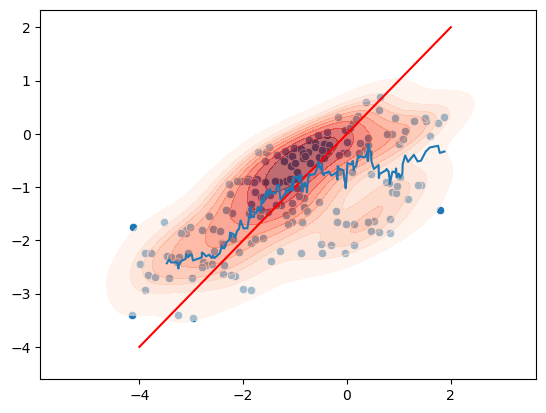

In [72]:
id_order = np.argsort(x)
x_order = (x.copy())[id_order]
y_order = (y.copy())[id_order]
df_tmp = pd.DataFrame(data={"x" : x_order, "y" : y_order})
window_size = 10
rolling_avg = df_tmp['y'].rolling(window_size).mean().values
id_not_nan = np.where(~np.isnan(rolling_avg))[0]
id_nan = np.where(np.isnan(rolling_avg))[0]

plt_ = sns.scatterplot(x=x, y=y)

plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds")
plt_.plot([-4, 2], [-4, 2], c="red")
plt_ = sns.lineplot(x = x_order[id_not_nan], y=rolling_avg[id_not_nan])

In [59]:
x_new = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.params
df_corr_slope

norm_status  passage      p       metric_type    metric          pval
0        unnorm      0.0  0.001  corr_pearson_log  0.461603  2.305151e-11
1        unnorm      0.0  0.001     corr_spearman  0.525782  7.930197e-15
2        unnorm      0.0  0.001             slope  0.989478  2.098183e-22
3        unnorm      0.0  0.001  mag_median_error  0.436967  0.000000e+00
4        unnorm      0.0  0.001  abs_median_error  1.089244  0.000000e+00
..          ...      ...    ...               ...       ...           ...
695      unnorm      0.0  0.800             slope  0.926101  5.009911e-31
696      unnorm      0.0  0.800  mag_median_error  0.699392  0.000000e+00
697      unnorm      0.0  0.800  abs_median_error  0.805711  0.000000e+00
698      unnorm      0.0  0.800         std_error  1.066021  0.000000e+00
699      unnorm      0.0  0.800               FNR  0.000000  0.000000e+00

[700 rows x 6 columns]

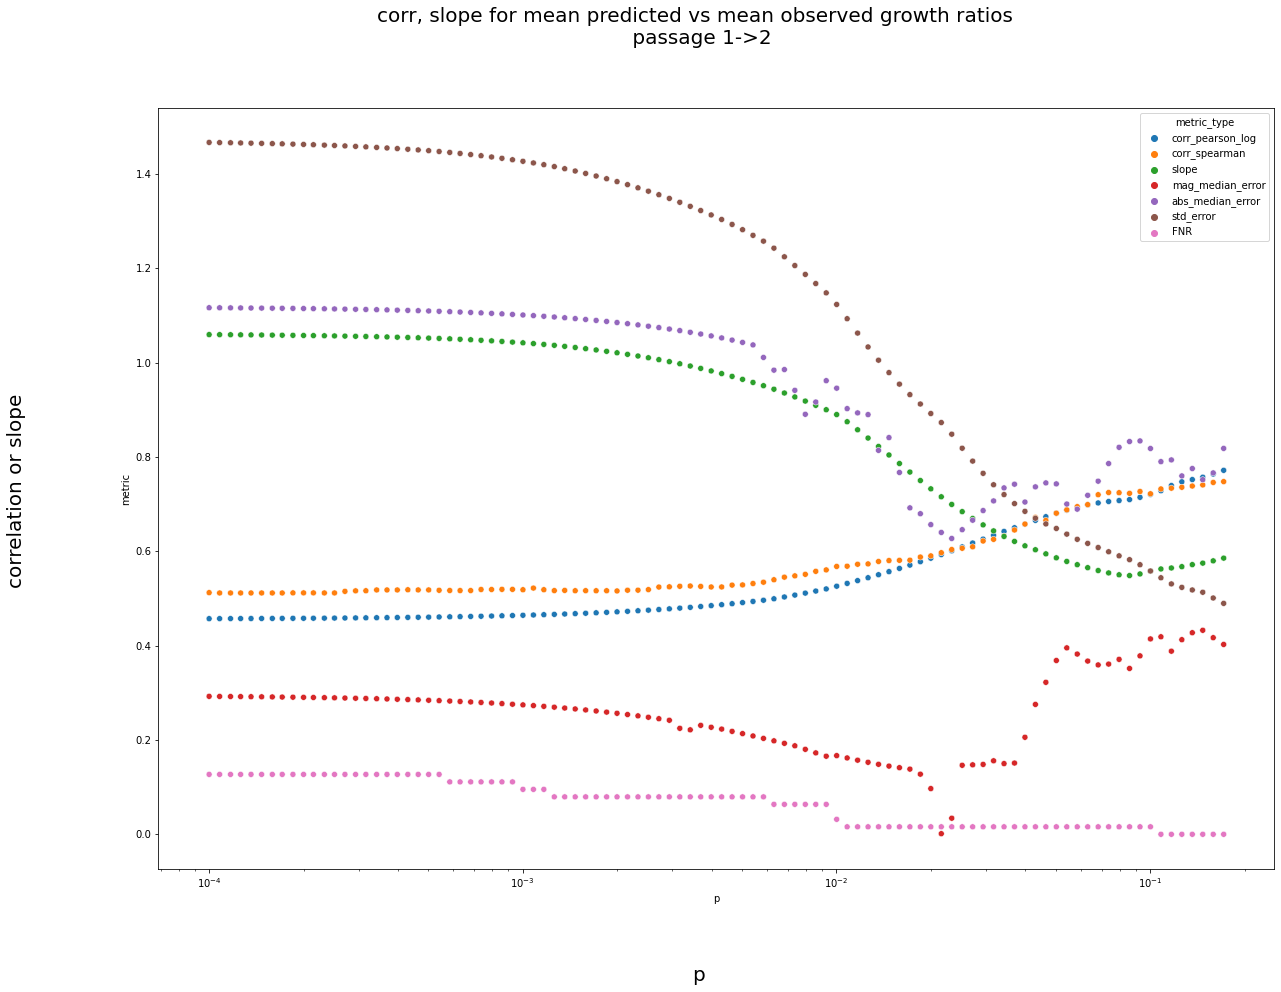

In [48]:
fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
fig.suptitle(f'corr, slope for mean predicted vs mean observed growth ratios \n' + \
             f' passage {pass_ + 1}->{pass_ + 2}', \
             fontsize=20)
fig.supxlabel('p', fontsize=20)
fig.supylabel('correlation or slope', fontsize=20)

plt_ = sns.scatterplot(data=df_corr_slope_mean, x="p", y="metric", \
                       hue="metric_type", ax=axes)
plt_.set_xscale("log", base=10)

In [214]:
id_ = np.where((df_corr_slope['metric_type'].values == "FNR") & \
               (df_corr_slope['metric'].values <= 0.05))[0]
np.min(df_corr_slope.iloc[id_, 2].values)
df_corr_slope
id_ = np.where((df_corr_slope['metric_type'].values == "FNR"))[0]
df_corr_slope.iloc[id_, :]

norm_status  passage         p metric_type    metric  pval
6        unnorm      0.0  0.000100         FNR  0.121693   0.0
13       unnorm      0.0  0.000108         FNR  0.121693   0.0
20       unnorm      0.0  0.000117         FNR  0.121693   0.0
27       unnorm      0.0  0.000126         FNR  0.121693   0.0
34       unnorm      0.0  0.000136         FNR  0.121693   0.0
..          ...      ...       ...         ...       ...   ...
671      unnorm      0.0  0.147114         FNR  0.000000   0.0
678      unnorm      0.0  0.158854         FNR  0.000000   0.0
685      unnorm      0.0  0.171531         FNR  0.000000   0.0
692      unnorm      0.0  0.185219         FNR  0.000000   0.0
699      unnorm      0.0  0.200000         FNR  0.000000   0.0

[100 rows x 6 columns]

# 31 March 2023: Fit R_i and then Fit growth ratios once Ri are known

In [70]:
def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               p_tmp, num_passages):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    num_species_tmp = df_speciesAbun_prev.shape[0]

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][:, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[:, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[:, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((num_species_tmp, 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

            if count_ == 0:
                A_train = A_train_sample
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_



def compute_growth_ratio_iterate(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
#             mean_ = 10 ** np.mean(np.log10(vals_[id_keep]))
#             ratio_fac = 10 ** (ratio_means_[sample_] - np.mean(np.log10(vals_[id_keep])))
#             vals_[id_keep] = np.power(10, (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
#                                     np.mean(np.log10(vals_[id_keep]))))
#     #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
            vals_next = vals_.copy() * df_speciesAbun_prev[sample_].values
            ratio_fac = 1 / np.sum(vals_next)
    #         df_growth_ratio[sample_] = vals_
#             ratio_fac = 1
            df_growth_ratio[sample_] = vals_ * ratio_fac
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

In [38]:
p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
num_passages = 6
Ri_fit_all = {}
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}, p = {p_tmp}')
    Ri_fit_all[p_tmp] = compute_Ri(df_speciesMetab, df_speciesAbun_prev, \
                                   df_speciesAbun_next, df_speciesAbun_ratio, \
                                   p_tmp, num_passages)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230331_iterative_scheme'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'20230331_fit_Ri_different_p_noLeaveOneOutRi.pickle'))


with open(file_save, "wb") as file_:
    pickle.dump(Ri_fit_all, file_)  

count_p = 0, p = 0.0001
count_p = 1, p = 0.000108
count_p = 2, p = 0.000117
count_p = 3, p = 0.000126
count_p = 4, p = 0.000136
count_p = 5, p = 0.000147
count_p = 6, p = 0.000159
count_p = 7, p = 0.000171
count_p = 8, p = 0.000185
count_p = 9, p = 0.0002
count_p = 10, p = 0.000215
count_p = 11, p = 0.000233
count_p = 12, p = 0.000251
count_p = 13, p = 0.000271
count_p = 14, p = 0.000293
count_p = 15, p = 0.000316
count_p = 16, p = 0.000342
count_p = 17, p = 0.000369
count_p = 18, p = 0.000398
count_p = 19, p = 0.00043
count_p = 20, p = 0.000464
count_p = 21, p = 0.000501
count_p = 22, p = 0.000541
count_p = 23, p = 0.000585
count_p = 24, p = 0.000631
count_p = 25, p = 0.000682
count_p = 26, p = 0.000736
count_p = 27, p = 0.000795
count_p = 28, p = 0.000858
count_p = 29, p = 0.000927
count_p = 30, p = 0.001001
count_p = 31, p = 0.001081
count_p = 32, p = 0.001167
count_p = 33, p = 0.00126
count_p = 34, p = 0.00136
count_p = 35, p = 0.001469
count_p = 36, p = 0.001586
count_p = 37, p = 

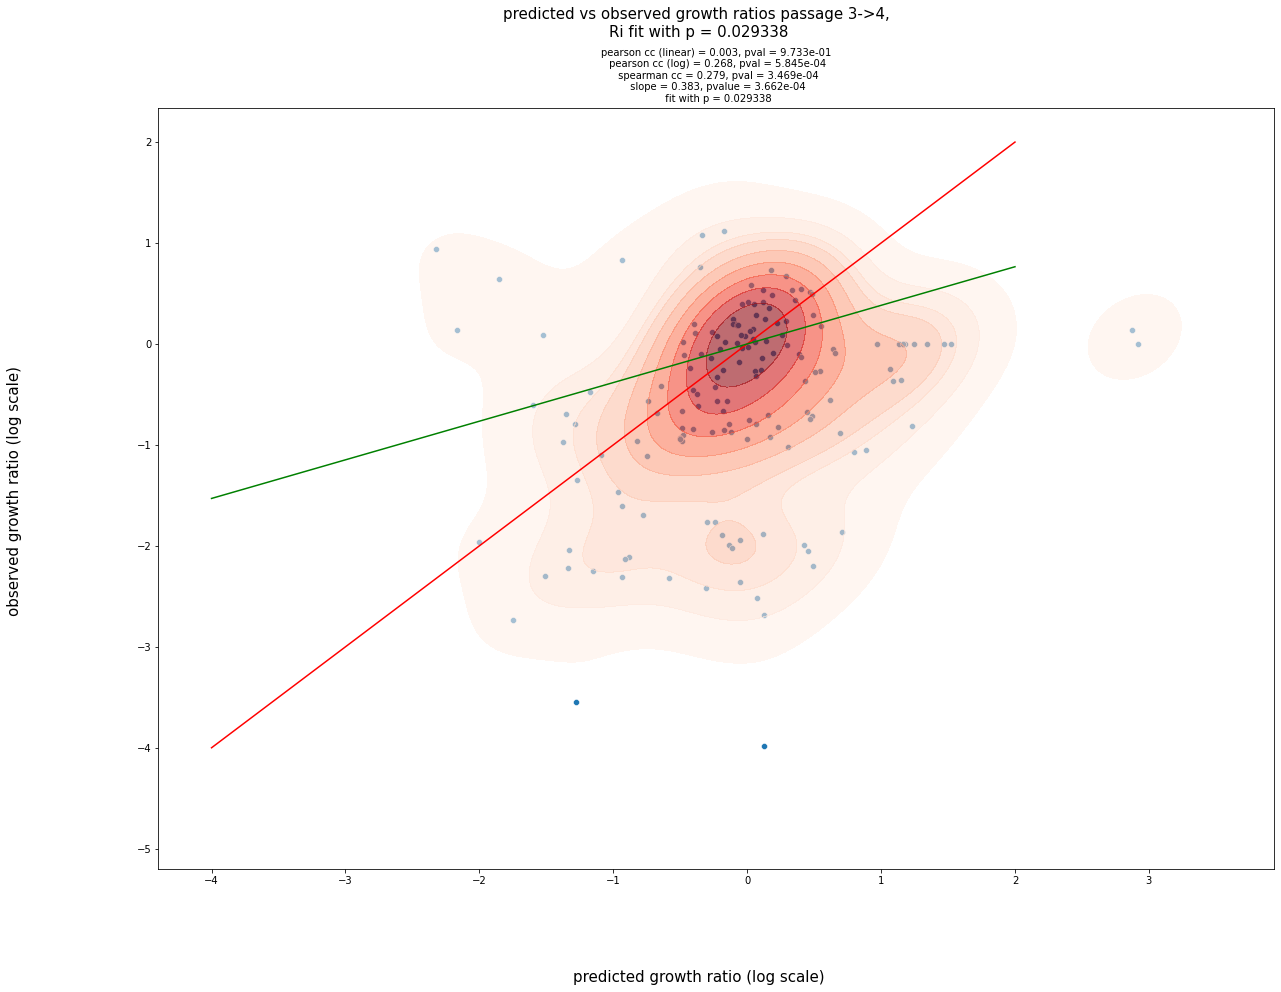

In [47]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
norm_status = norm_status_vec[0]
pass_ = 2
df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
count_p = 74
p_tmp = p_vec_new[count_p]
Ri_avg = Ri_fit_all[p_tmp]

growth_rate_all = {}
growth_rate_all[0] = pd.DataFrame()
ratio_means_ = {}
for col_ in df_speciesAbun_prev_tmp_.columns.values:
    growth_rate_all[0][col_] = np.ones((num_species))
    x = df_speciesAbun_ratio_tmp_[col_].values
    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

for iter_ in range(num_iter):
    if iter_ == 0:
        iter_id = iter_
    else:
        iter_id = iter_ - 1
    if norm_status == "norm":    
        iter_thresh = -1
    else:
        iter_thresh = -1

    if norm_status == "norm" and iter_ == num_iter - 1:
        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                      df_speciesAbun_next_tmp_.copy(), \
                                                      p_tmp, Ri_avg.copy(), \
                                                      growth_rate_all[iter_id].copy(), \
                                                      ratio_means_.copy())
    else:
        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                      df_speciesAbun_next_tmp_.copy(), \
                                                      p_tmp, Ri_avg.copy(), \
                                                      growth_rate_all[iter_id].copy(), \
                                                      ratio_means_.copy(), 
                                                      norm_=False)

    growth_rate_all[iter_] = df_growth_rate.copy()
    
b_ = range(3)
x = np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten()
y = np.array(growth_rate_all[num_iter - 1])[:, b_].flatten()
id_ = np.where(x > 0)[0]
x = np.log10(x[id_])
y = np.log10(y[id_])
# y=np.random.permutation(x)
y[y <= -5] = -5
id_ = np.where((y > -100))[0]
x = x[id_]
y = y[id_]

fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
             f'Ri fit with p = {p_tmp}', \
             fontsize=15)
fig.supxlabel('predicted growth ratio (log scale)', fontsize=15)
fig.supylabel('observed growth ratio (log scale)', fontsize=15)

plt_ = sns.scatterplot(x=x, \
                       y=y, ax=axes)

plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                   ax=axes)
plt_.plot([-4, 2], [-4, 2], c="red")

corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
corr_val_pe_log = scipy.stats.pearsonr(x, y)
corr_val_sp = scipy.stats.spearmanr(x, y)

model = sm.OLS(y, x).fit()
slope = model.params[0]
slope_pval = model.pvalues[0]


plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1]) + \
         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                '{:.3e}'.format(slope_pval) + \
         f'\n fit with p = {p_tmp}'

axes.set_title(title_, size=10)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                        'predictions', 'leaveOneOut', '20230331_iterative_scheme', \
                                        'predicted_vs_observed_growth_ratios', norm_status, 
                                        f'passage_{pass_ + 1}to{pass_ + 2}'))
if not os.path.exists(save_dir):
   # Create a new directory because it does not exist
   os.makedirs(save_dir)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'20230331_predicted_vs_observed_growth_ratios_' + \
                                         f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                         f'_Ri_fit_with_p{p_tmp}_{norm_status}.png'))
fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
# plt.close(fig.figure)

In [50]:
growth_rate_all[num_iter - 1]

p4_r0     p4_r1     p4_r2
0   3.241411  0.566053  1.277406
1   0.918086  1.055510  0.931831
2   0.580731  0.725244  0.793570
3   1.000000  0.200722  1.000000
4   0.003018  0.002085  0.001838
..       ...       ...       ...
58  1.195315  1.224882  1.550385
59  1.074074  0.215381  0.159807
60  0.821050  0.318521  0.482284
61  6.734624  1.000000  1.000000
62  1.000000  1.000000  1.000000

[63 rows x 3 columns]

In [65]:
vals_ = growth_rate_all[num_iter - 1].copy()
for col_ in df_speciesAbun_ratio_tmp_.columns.values:
    x = df_speciesAbun_ratio_tmp_[col_].values
    id_ = np.where(x != -1)[0]
#     mean_ = np.power(10, np.mean(np.log10(x[id_])))
    mean_ = 10 ** np.mean(np.log10(x[id_]))
    fac_ = 10 ** (np.log10(mean_) - np.mean(np.log10(vals_[col_].values[id_])))
    vals_[col_] = fac_ * vals_[col_].values
    
    

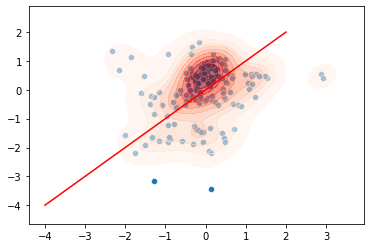

In [67]:
ymat = np.array(vals_.copy()).flatten()
xmat = np.array(df_speciesAbun_ratio_tmp_.copy()).flatten()
id_ = np.where(xmat != -1)[0]
x = np.log10(xmat[id_])
y = np.log10(ymat[id_])
plt_ = sns.scatterplot(x=x, y=y)
plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds")
plt_.plot([-4, 2], [-4, 2], c="red")

In [68]:
scipy.stats.pearsonr(x, y)

PearsonRResult(statistic=0.2697689783630455, pvalue=0.0005387699946556001)

In [131]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm"]
# p_vec_new = np.around(np.logspace(start=-4, stop=np.log10(0.2), num=100), decimals=6)
# predicted_growth_ratios = {}
# range(num_passages - 1)

for norm_status in norm_status_vec:
#     predicted_growth_ratios[norm_status] = {}
    for pass_ in [4]:
#         predicted_growth_ratios[norm_status][pass_] = {}
#         growth_rate_all = np.zeros((num_iter, num_species))
        df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

#         df_corr_slope = pd.DataFrame(data={"norm_status" : [], 
#                                     "passage" : [], 
#                                     "p" : [], 
#                                     "corr_pe" : [], 
#                                     "corr_pe_log" : [], 
#                                     "corr_sp" : [], 
#                                     "slope" : [], 
#                                     "corr_pe_pval" : [], 
#                                     "corr_pe_log_pval" : [], 
#                                     "corr_sp_pval" : [], 
#                                     "slope_pval" : []})
        df_corr_slope = pd.DataFrame(data={"norm_status" : [],
                                           "passage" : [], 
                                           "p" : [],
                                           "metric_type" : [], 
                                           "metric" : [],
                                           "pval" : []})

        for count_p, p_tmp in enumerate(p_vec_new):
            growth_rate_all = {}
            growth_rate_all[0] = pd.DataFrame()
            Ri_avg = Ri_fit_all[p_tmp]

            fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                         f'Ri fit with p = {p_tmp}', \
                         fontsize=15)
            fig.supxlabel('predicted growth ratio (log scale)', fontsize=15)
            fig.supylabel('observed growth ratio (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            ratio_means_ = {}
            for col_ in df_speciesAbun_prev_tmp_.columns.values:
                growth_rate_all[0][col_] = np.ones((num_species))
                x = df_speciesAbun_ratio_tmp_[col_].values
                ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

            for iter_ in range(num_iter):
                if iter_ == 0:
                    iter_id = iter_
                else:
                    iter_id = iter_ - 1
                if norm_status == "norm":    
                    iter_thresh = -1
                else:
                    iter_thresh = -1

                if norm_status == "norm":
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy())
                else:
                    df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                  df_speciesAbun_next_tmp_.copy(), \
                                                                  p_tmp, Ri_avg.copy(), \
                                                                  growth_rate_all[iter_id].copy(), \
                                                                  ratio_means_.copy(), 
                                                                  norm_=False)

                growth_rate_all[iter_] = df_growth_rate.copy()
                
#             predicted_growth_ratios[norm_status][pass_] = growth_rate_all
            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', '20230331_iterative_scheme', \
                                                    'predicted_vs_observed_growth_ratios_noLeaveOneOutRi', \
                                                    norm_status, \
                                                    'predicted_growth_ratios', \
                                                    f'passage_{pass_ + 1}to{pass_ + 2}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
                os.makedirs(save_dir)
            file_save = os.path.abspath(os.path.join(save_dir, 
                                                     f'predicted_growth_ratios_with_p{p_tmp}.pickle'))


            with open(file_save, "wb") as file_:
                pickle.dump(growth_rate_all, file_)  

#             row_ = int(count_p / plt_cols)
#             col_ = int(count_p % plt_cols)

            b_ = range(3)
            x = np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten()
            y = np.array(growth_rate_all[num_iter - 1])[:, b_].flatten()
            id_ = np.where(x > 0)[0]
            x = np.log10(x[id_])
            y = np.log10(y[id_])
            # y=np.random.permutation(x)
            y[y <= -5] = -5
            id_ = np.where((y > -100))[0]
            x = x[id_]
            y = y[id_]

            plt_ = sns.scatterplot(x=x, \
                                   y=y, ax=axes)

            plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                               ax=axes)
            plt_.plot([-4, 2], [-4, 2], c="red")

            corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
            corr_val_pe_log = scipy.stats.pearsonr(x, y)
            corr_val_sp = scipy.stats.spearmanr(x, y)
            corr_val_pe_log_std = scipy.stats.pearsonr((x - np.mean(x)) / np.std(x), \
                                                       (y - np.mean(y)) / np.std(y))
            mean_error = np.abs(np.median(y - x))
            abs_mean_error = np.median(np.abs(y - x))
            cv_error = np.std(np.abs(y - x)) / np.mean(np.abs(y - x))
            std_error = np.std(np.abs(y - x))

            model = sm.OLS(y, x).fit()
            slope = model.params[0]
            slope_pval = model.pvalues[0]
            
#             df_tmp = \
#                 pd.DataFrame(data={"norm_status" : [norm_status], 
#                                    "passage" : [pass_], 
#                                    "p" : [p_tmp], 
#                                    "corr_pe" : [corr_val_pe[0]], 
#                                    "corr_pe_log" : [corr_val_pe_log[0]], 
#                                    "corr_sp" : [corr_val_sp[0]], 
#                                    "slope" : [slope], 
#                                    "corr_pe_pval" : [corr_val_pe[1]], 
#                                    "corr_pe_log_pval" : [corr_val_pe_log[1]], 
#                                    "corr_sp_pval" : [corr_val_sp[1]], 
#                                    "slope_pval" : [slope_pval]})
            df_tmp = \
                pd.DataFrame(data={"norm_status" : [norm_status] * 6, 
                                   "passage" : [pass_] * 6, 
                                   "p" : [p_tmp] * 6, 
                                   "metric_type" : ["corr_pearson_log", 
                                                    "corr_spearman", "slope", "mag_median_error", \
                                                    "abs_median_error", \
                                                    "std_error"], 
                                   "metric" : [corr_val_pe_log[0], 
                                               corr_val_sp[0], slope, mean_error, abs_mean_error, std_error],
                                   "pval" : [corr_val_pe_log[1], 
                                             corr_val_sp[1], slope_pval, 0, 0, 0]})
            df_corr_slope = pd.concat([df_corr_slope, df_tmp], ignore_index=True)
            

            plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

            title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe[1]) + \
                     f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_pe_log[1]) + \
                     f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                            '{:.3e}'.format(corr_val_sp[1]) + \
                     f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                            '{:.3e}'.format(slope_pval) + \
                     f'\n fit with p = {p_tmp}'

            axes.set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', '20230331_iterative_scheme', \
                                                    'predicted_vs_observed_growth_ratios_noLeaveOneOutRi', \
                                                    norm_status, 
                                                    f'passage_{pass_ + 1}to{pass_ + 2}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230331_predicted_vs_observed_growth_ratios_' + \
                                                     f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_with_p{p_tmp}_{norm_status}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)
            
        fig, axes = plt.subplots(1, 1, figsize=(20, 14), sharey="row", sharex="col")
        fig.suptitle(f'corr, slope for predicted vs observed growth ratios \n' + \
                     f' passage {pass_ + 1}->{pass_ + 2}', \
                     fontsize=20)
        fig.supxlabel('p', fontsize=20)
        fig.supylabel('correlation or slope', fontsize=20)
        
        plt_ = sns.scatterplot(data=df_corr_slope, x="p", y="metric", \
                               hue="metric_type", ax=axes)
        plt_.set_xscale("log", base=10)
        
        save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', '20230331_iterative_scheme', \
                                                    'predicted_vs_observed_growth_ratios_noLeaveOneOutRi', \
                                                norm_status, 
                                                    f'passage_{pass_ + 1}to{pass_ + 2}'))
        if not os.path.exists(save_dir):
           # Create a new directory because it does not exist
           os.makedirs(save_dir)

        save_file = os.path.abspath(os.path.join(save_dir, 
                                                 f'20230331_corr_slope_predicted_vs_observed_growth_ratios_' + \
                                                 f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme' + \
                                                 f'.png'))
        fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
        plt.close(fig.figure)

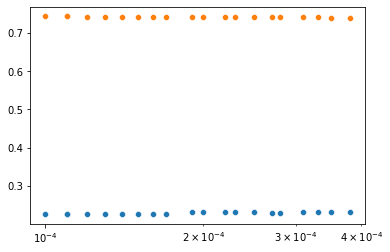

In [75]:
df_corr_slope_pass = df_corr_slope.copy()
df_corr_slope_pass = df_corr_slope_pass[df_corr_slope_pass['passage'] == 2]
x = df_corr_slope_pass["p"].values
y = df_corr_slope_pass['corr_sp'].values
z = df_corr_slope_pass['slope'].values
plt_ = sns.scatterplot(x=x, y=y)
plt_ = sns.scatterplot(x=x, y=z)
plt_.set_xscale("log", base=10)

# 23 March 2023: Fit growth ratios once Ri are known

In [297]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
# file_save = os.path.abspath(os.path.join(save_dir, 
#                                          f'trained_model_different_p_leaveOneOut_predictNextAbun'
#                                          f'_iterate_Ri_NextAbun_dynamical.pickle'))
# file_save = os.path.abspath(os.path.join(save_dir, 
#                                          f'trained_model_different_p_leaveOneOut_predictGrowthRatio'
#                                          f'_iterate_Ri_GrowthRatio.pickle'))
pass_ = 0
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictGrowthRatio'
                                         f'_iterate_Ri_GrowthRatio_passage_{pass_ + 1}to{pass_ + 2}.pickle'))
with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
Ri_all_mat = save_obj["Ri_all_mat"]
# abundance_next_species = save_obj["abundance_pred"]

In [298]:
Ri_all_mat.shape

(3, 63, 292)

In [299]:
Ri_avg = np.zeros(num_metabs)
# count_p = 2
count_p = 1
num_iter = 10
for species_ in range(num_species):
#     Ri_avg += Ri_all_mat[count_p, species_, num_iter - 1, :]
    Ri_avg += Ri_all_mat[count_p, species_, :]
Ri_avg /= num_species

In [343]:
filename_ = "metabs_unranked_p0.11_leaveOneOut.csv"
filepath_ = os.path.join(os.getcwd(), "..", "figures", "predictions", "leaveOneOut", 
                                filename_)
df_Ri_1e_4 = pd.read_csv(filepath_)
Ri_avg = df_Ri_1e_4["Ri_fit"].values

In [488]:
def compute_growth_ratio_iterate(df_speciesAbun_prev, df_speciesAbun_next, p_tmp, Ri, growth_ratios_, \
                                 ratio_means_, norm_=True):
    df_speciesAbun_ratio_new = df_speciesAbun_prev.copy()
    for col_ in range(df_speciesAbun_prev.shape[1]):
        df_speciesAbun_ratio_new.iloc[:, col_] = growth_ratios_.iloc[:, col_].values
        df_speciesAbun_next.iloc[:, col_] = (growth_ratios_.iloc[:, col_].values) * \
            df_speciesAbun_prev.iloc[:, col_].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)

    id_species = range(df_speciesAbun_prev.shape[0])
    count_ = 0
    df_growth_ratio = pd.DataFrame()
#     ratio_fac = 0
#     vals_ = {}
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
        id_notkeep = np.where((df_speciesAbun_prev[sample_].values == 1e-8) & \
                              (df_speciesAbun_next[sample_].values == 1e-8))[0]
        id_keep = list(set(id_species) - set(id_notkeep))
#         tmp = df_speciesAbun_ratio_tmp_[sample_].values
        tmp = np.array(tmp).reshape((len(id_species), 1))
        tmp = tmp[id_keep, :]
        vals_ = np.ones((len(id_species)))
        vals_tmp = np.multiply((np.matmul(A_train_sample, Ri).flatten())[id_keep], \
                               tmp.flatten()**(1 - p_tmp))
        vals_[id_keep] = vals_tmp.copy()
#         vals_ = df_speciesAbun_ratio_tmp_[sample_].values
#         vals_[sample_] = (np.matmul(A_train_sample, Ri).flatten())**(1 / p_tmp)

        if norm_:
            vals_[id_keep] = 10 ** (np.log10(vals_[id_keep]) * ratio_means_[sample_] / \
                                    np.mean(np.log10(vals_[id_keep])))
    #         vals_ += 1 - np.sum(vals_ * df_speciesAbun_prev[sample_].values)
            vals_next = vals_ * df_speciesAbun_prev[sample_].values
            ratio_fac = 1 / np.sum(vals_next)
    #         df_growth_ratio[sample_] = vals_
#             ratio_fac = 1
            df_growth_ratio[sample_] = vals_ * ratio_fac
        else:
#             vals_next = vals_ * df_speciesAbun_prev[sample_].values
#             ratio_fac = 1 / np.sum(vals_next)
            df_growth_ratio[sample_] = vals_
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) * ratio_means_[sample_] / \
#                                           np.mean(np.log10(vals_)))
#         df_growth_ratio[sample_] = 10 ** (np.log10(vals_) + ratio_means_[sample_] - \
#                                           np.mean(np.log10(vals_)))
    
#     growth_ratios_new = np.zeros(())
    
    return df_growth_ratio

num_iter = 100
pass_ = 0
growth_rate_all = np.zeros((num_iter, num_species))
growth_rate_all = {}
growth_rate_all[0] = pd.DataFrame()
df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
ratio_means_ = {}
for col_ in df_speciesAbun_prev_tmp_.columns.values:
    growth_rate_all[0][col_] = np.ones((num_species))
#     growth_rate_all[0][col_] = df_speciesAbun_ratio_tmp_[col_].values
    ratio_means_[col_] = np.mean(np.log10(df_speciesAbun_ratio_tmp_[col_].values))
p_tmp = 0.05
for iter_ in range(num_iter):
    if iter_ == 0:
        iter_id = iter_
    else:
        iter_id = iter_ - 1
    if iter_ <= -1:
        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                      df_speciesAbun_next_tmp_.copy(), \
                                                      p_tmp, Ri_avg.copy(), \
                                                      growth_rate_all[iter_id].copy(), ratio_means_.copy())
    else:
        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                      df_speciesAbun_next_tmp_.copy(), \
                                                      p_tmp, Ri_avg.copy(), \
                                                      growth_rate_all[iter_id].copy(), ratio_means_.copy(), 
                                                      norm_=False)
    growth_rate_all[iter_] = df_growth_rate.copy()

SpearmanrResult(correlation=0.7262055848841963, pvalue=2.9491198219197367e-32)


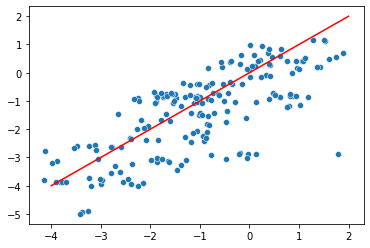

In [489]:
b_ = range(3)
x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
y=np.log10(np.array(growth_rate_all[num_iter - 1])[:, b_].flatten())
# y=np.random.permutation(x)
y[y <= -5] = -5
id_ = np.where(y > -100)[0]
plt_ = sns.scatterplot(x=x[id_], \
                       y=y[id_])
plt_.plot([-4, 2], [-4, 2], c="red")
print(scipy.stats.spearmanr(x[id_], y[id_]))

# 24 March 2023: plot predicted vs observed growth ratios when using the iterative scheme

## When using Ri obtained with p = 1e-4

In [340]:
num_iter = 100
pass_ = 0
norm_status_vec = ["unnorm", "norm"]

for norm_status in norm_status_vec:
    for pass_ in range(num_passages - 1):
        growth_rate_all = np.zeros((num_iter, num_species))
        growth_rate_all = {}
        growth_rate_all[0] = pd.DataFrame()
        df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

        p_vec_Ri_fit = [0.0001, 0.01, 0.11, 0.2, 0.4]
        p_vec_new = [1e-8, 1e-4, 1e-2, 1e-1, 0.2, 0.5, 0.8, 0.9]


        for count_p_Ri, p_tmp_Ri in enumerate(p_vec_Ri_fit):
            filename_ = f'metabs_unranked_p{p_tmp_Ri}_leaveOneOut.csv'
            filepath_ = os.path.join(os.getcwd(), "..", "figures", "predictions", "leaveOneOut", 
                                            filename_)
            df_Ri = pd.read_csv(filepath_)
            Ri_avg = df_Ri["Ri_fit"].values

            fig, axes = plt.subplots(2, 4, figsize=(20, 14), sharey="row", sharex="col")
            fig.suptitle(f'predicted vs observed growth ratios passage {pass_ + 1}->{pass_ + 2}, \n' + 
                         f'Ri fit with p = {p_tmp_Ri}', \
                         fontsize=15)
            fig.supxlabel('predicted growth ratio (log scale)', fontsize=15)
            fig.supylabel('observed growth ratio (log scale)', fontsize=15)
            plt_rows = 2
            plt_cols = 4

            for count_p, p_tmp in enumerate(p_vec_new):


                ratio_means_ = {}
                for col_ in df_speciesAbun_prev_tmp_.columns.values:
                    growth_rate_all[0][col_] = np.ones((num_species))
                    x = df_speciesAbun_ratio_tmp_[col_].values
                    ratio_means_[col_] = np.mean(np.log10(x[x != -1]))

                for iter_ in range(num_iter):
                    if iter_ == 0:
                        iter_id = iter_
                    else:
                        iter_id = iter_ - 1
                    if norm_status == "norm":    
                        iter_thresh = 1000
                    else:
                        iter_thresh = -1

                    if iter_ <= iter_thresh:
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), \
                                                                      ratio_means_.copy())
                    else:
                        df_growth_rate = compute_growth_ratio_iterate(df_speciesAbun_prev_tmp_.copy(), \
                                                                      df_speciesAbun_next_tmp_.copy(), \
                                                                      p_tmp, Ri_avg.copy(), \
                                                                      growth_rate_all[iter_id].copy(), ratio_means_.copy(), 
                                                                      norm_=False)
                    growth_rate_all[iter_] = df_growth_rate.copy()

                row_ = int(count_p / plt_cols)
                col_ = int(count_p % plt_cols)

                b_ = range(3)
                x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
                y=np.log10(np.array(growth_rate_all[num_iter - 1])[:, b_].flatten())
                # y=np.random.permutation(x)
                y[y <= -5] = -5
                id_ = np.where((y > -100) & (np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten() != -1))[0]
                x = x[id_]
                y = y[id_]
                
                plt_ = sns.scatterplot(x=x, \
                                       y=y, ax=axes[row_, col_])

                plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                                   ax=axes[row_, col_])
                plt_.plot([-4, 2], [-4, 2], c="red")

                corr_val_pe = scipy.stats.pearsonr(10**x, 10**y)
                corr_val_pe_log = scipy.stats.pearsonr(x, y)
                corr_val_sp = scipy.stats.spearmanr(x, y)

                model = sm.OLS(y, x).fit()
                slope = model.params[0]
                slope_pval = model.pvalues[0]
                
                plt_.plot([-4, 2], [slope * (-4), slope * 2], c="green")

                title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe[1]) + \
                         f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_pe_log[1]) + \
                         f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                                '{:.3e}'.format(corr_val_sp[1]) + \
                         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                                '{:.3e}'.format(slope_pval) + \
                         f'\n fit with p = {p_tmp}'

                axes[row_, col_].set_title(title_, size=10)

            save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', \
                                                    'predictions', 'leaveOneOut', '20230323_iterative_scheme', \
                                                    'predicted_vs_observed_growth_ratios', norm_status, 
                                                    f'passage_{pass_ + 1}to{pass_ + 2}'))
            if not os.path.exists(save_dir):
               # Create a new directory because it does not exist
               os.makedirs(save_dir)

            save_file = os.path.abspath(os.path.join(save_dir, 
                                                     f'20230324_predicted_vs_observed_growth_ratios_' + \
                                                     f'passage_{pass_ + 1}to{pass_ + 2}_iterative_new_scheme_' + \
                                                     f'_Ri_fit_with_p{p_tmp_Ri}_{norm_status}.png'))
            fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
            plt.close(fig.figure)

<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value enc

<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value enc

<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value enc

<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value enc

<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value enc

<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value enc

<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value encountered in log10
  x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
<ipython-input-340-5a38cf2a2f56>:71: RuntimeWarning: invalid value enc

In [338]:
y[id_]

array([ 0.64928417,  0.70631688,  0.15624408,  0.10496409,  0.12958729,
        0.10913837, -1.36617825, -0.8669958 , -0.78218587, -0.89263225,
       -0.66630622, -5.        , -5.        , -5.        , -4.99372541,
       -4.72963334, -4.66864826, -5.        ,  0.        , -1.04217122,
       -1.07564814, -1.20903038, -0.27642905, -0.52406714, -0.42568113,
       -2.06437109, -2.30669929, -2.50848305,  1.04222484,  1.16670673,
        1.30091108, -1.68832382, -1.76022613, -1.95410586, -4.60270582,
       -4.77276829, -5.        , -0.90550923, -0.82010506, -0.913101  ,
        0.3496095 , -0.6288616 , -1.56307918, -0.00946024,  0.39791199,
        0.70244815, -1.70059713, -1.62479146, -1.53501635,  0.08315889,
        0.20645329,  0.25183364,  0.63732658,  0.37353537,  0.47658501,
       -1.60826678, -1.48926239, -1.52574408, -4.86915862, -4.7577345 ,
       -4.67266352,  0.9122585 ,  0.67918066,  0.25779918,  1.07952998,
        0.88202548,  0.88454809, -0.42122483, -0.66164098, -0.56

In [ ]:
# get slope
x = np.log10(abundance_prev_obs[:, pass_])
y = np.log10(abundance_next_obs[:, pass_])
model = sm.OLS(y, x).fit()
slope = model.params[0]
slope_pval = model.pvalues[0]

plt_ = sns.scatterplot(ax=axes[row_, col_], x=np.log10(abundance_prev_obs[:, pass_]), \
            y=np.log10(abundance_next_obs[:, pass_]))
plt_ = sns.kdeplot(x=np.log10(abundance_prev_obs[:, pass_]), \
            y=np.log10(abundance_next_obs[:, pass_]), fill=True, alpha=0.6, cmap="Reds", \
            ax=axes[row_, col_])
plt_.plot([-10, 0], [-10, 0], c="black")
corr_val_pe = scipy.stats.pearsonr(np.log10(abundance_prev_obs[:, pass_]), \
                                np.log10(abundance_next_obs[:, pass_]))
corr_val_sp = scipy.stats.spearmanr(np.log10(abundance_prev_obs[:, pass_]), \
                                np.log10(abundance_next_obs[:, pass_]))
title_ = f'passage {pass_ + 1} to {pass_ + 2} \n'\
        f'pearson cc (log) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
        f'\n spearman cc (log) = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1]) + \
        f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
        '{:.3e}'.format(slope_pval)

$$G^{\alpha}_i (2) = \sum_m R_m \frac{c^{\alpha}_m\, \left(G^{\alpha}_{i - 1} (2)\right)^{1 - p}}{\sum_{\beta} c^{\beta}_m\, B^{\beta} (1) \left(G^{\beta}_{i - 1} (2)\right)^{1 - p}}$$

In [310]:
id_posx = np.where(x > 0)[0]
id_pos_pos = np.where((x > 0) & (y > 0))[0]
print(len(id_pos_pos) / len(id_posx))
print(len(id_posx))

0.7142857142857143
49


In [311]:
nboot_ = 10000
perc_neg = []
perc_pos = []
x=np.log10(np.array(df_speciesAbun_ratio_tmp_.copy()).flatten())
for b_ in range(nboot_):
    y=np.random.permutation(x)
    
    id_posx = np.where(x > 0)[0]
    id_pos_pos = np.where((x > 0) & (y > 0))[0]
    perc_pos.append(len(id_pos_pos) / len(id_posx))
    
    id_negx = np.where(x < 0)[0]
    id_neg_neg = np.where((x < 0) & (y < 0))[0]
    perc_neg.append(len(id_neg_neg) / len(id_negx))
perc_neg = np.array(perc_neg)
perc_pos = np.array(perc_pos)

y=np.log10(np.array(growth_rate_all[9]).flatten())
id_posx = np.where(x > 0)[0]
id_pos_pos = np.where((x > 0) & (y > 0))[0]
perc_pos_true = (len(id_pos_pos) / len(id_posx))

id_negx = np.where(x < 0)[0]
id_neg_neg = np.where((x < 0) & (y < 0))[0]
perc_neg_true = (len(id_neg_neg) / len(id_negx))

pval_neg = len(perc_neg[perc_neg >= perc_neg_true]) / nboot_
print(pval_neg)

pval_pos = len(perc_pos[perc_pos >= perc_pos_true]) / nboot_
print(pval_pos)

0.0
0.0


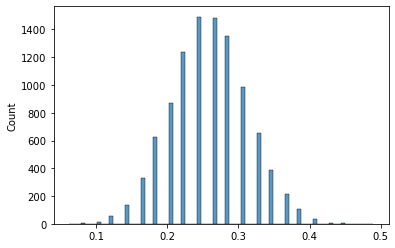

In [313]:
plt_ = sns.histplot(x=perc_pos)

SpearmanrResult(correlation=1.0, pvalue=0.0)


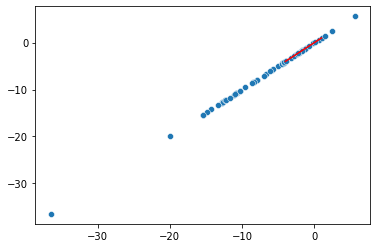

In [129]:
b_ = 0
# x=np.log10(np.array(df_speciesAbun_ratio_tmp_)[:, b_].flatten())
x=np.log10(np.array(growth_rate_all[1])[:, b_].flatten())
y=np.log10(np.array(growth_rate_all[9])[:, b_].flatten())
id_ = np.where(y > -100)[0]
plt_ = sns.scatterplot(x=x[id_], \
                       y=y[id_])
plt_.plot([-4, 1], [-4, 1], c="red")
print(scipy.stats.spearmanr(x[id_], y[id_]))

In [95]:
np.log10(np.max(np.max(df_speciesAbun_ratio_tmp_, axis=0).values))

1.878624282111647

In [125]:
print(np.sum(np.array(growth_rate_all[9]) * np.array(df_speciesAbun_prev_tmp_), axis=0))
print(np.sum(np.array(df_speciesAbun_next_tmp_), axis=0))

[1. 1. 1.]
[1.00000011 1.00000006 1.00000006]


In [210]:
df_speciesAbun_next_tmp_.sum(axis=0)

p2_r0    0.929219
p2_r1    0.884957
p2_r2    0.864150
dtype: float64

In [ ]:
def compute_growth_ratio(train_strain_id, test_strain_id, df_speciesAbun_prev_tmp, \
                         df_speciesAbun_next_tmp, \
                         df_speciesMetab, df_speciesAbun_ratio_new, Ri, initial_guess, p_tmp):
    def objective_(g, *args):
        train_strain_id = args[0].copy()
        test_strain_id = args[1].copy()
        df_speciesAbun_prev = args[2].copy()
        df_speciesAbun_next = args[3].copy()
        df_speciesMetab = args[4].copy()
        df_speciesAbun_ratio = args[5].copy()
        Ri = args[6].copy()
        p_tmp = args[7]
        df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
        df_speciesAbun_ratio_new.iloc[test_strain_id, :] = g * np.ones((len(test_strain_id)))
        df_speciesAbun_next.iloc[test_strain_id, :] = g * df_speciesAbun_prev.iloc[test_strain_id, :].values
        sample_names_split, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                                 df_speciesAbun_next.copy(), p_=p_tmp)
        
        id_species = train_strain_id + test_strain_id
        count_ = 0
        for sample_ in sample_names_split:
            pass_ = int(sample_.split("_")[0][1])
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
#             tmp = np.array(tmp**(-p_tmp)).reshape((df_speciesAbun_ratio.shape[0], 1))
            tmp = np.array(tmp).reshape((len(id_species), 1))
            tmp = tmp[id_keep, :]
#             tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
#             A_train_sample = np.multiply(A_train_sample, tmp)
#             A_train_sample = np.log(A_train_sample) - p_tmp * np.log(tmp)
            A_train_sample = A_train_sample[id_keep, :]

    #         pass_all += [pass_] * len(id_keep)
    #         brep_all += [brep_] * len(id_keep)
#             p_tmp_new = p_tmp
            if pass_ == 2:
                p_tmp_new = p_tmp
            else:
#                 p_tmp_new = 1e-8
                p_tmp_new = p_tmp
            if count_ == 0:
                A_train = A_train_sample
                b_train = tmp**p_tmp_new
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
                b_train = np.vstack((b_train, tmp**p_tmp_new))
#         b_train = np.ones((A_train.shape[0]))
#         error_ = b_train - np.matmul(A_train, Ri)
#         error_ = np.log(np.matmul(A_train, Ri).flatten()) - 1 * np.log(b_train.flatten())
        error_ = (np.matmul(A_train, Ri).flatten()) - b_train.flatten()
        error_ = np.sum(error_**2)
        return error_
    
    df_speciesAbun_prev_tmp_ = df_speciesAbun_prev_tmp.copy()
    df_speciesAbun_next_tmp_ = df_speciesAbun_next_tmp.copy()
    df_speciesAbun_ratio_new_ = df_speciesAbun_ratio_new.copy()
    
    
#     df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_new.copy().iloc[train_strain_id, :]
#     id_ = []
#     for i in range(df_speciesAbun_ratio_tmp.shape[0]):
#         id_z = np.where(df_speciesAbun_ratio_tmp.iloc[i, :].values == -1)[0]
#         if len(id_z) == 0:
#             id_.append(i)
#     initial_guess = np.mean(np.log(df_speciesAbun_ratio_tmp.iloc[id_, :].values).mean(axis=0))
#     initial_guess = np.exp(initial_guess)
#     initial_guess = growth_ratio
    args = (train_strain_id, test_strain_id, df_speciesAbun_prev_tmp_, df_speciesAbun_next_tmp_, \
            df_speciesMetab, df_speciesAbun_ratio_new_, Ri, p_tmp)
    g_sol = minimize(objective_, initial_guess, args=args, bounds=[(1e-6, 1e3)], 
                     options={"maxiter" : 1000})
    if not g_sol.success:
        g_sol = minimize(objective_, initial_guess, args=args, bounds=[(1e-6, 1e3)], \
                         options={"maxiter" : 10000})
    
    return g_sol.x[0]

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               growth_ratio, p_tmp, test_strain_id, train_strain_id, num_passages):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()

    for pass_ in range(num_passages):
        df_speciesAbun_ratio_new.iloc[test_strain_id, [pass_, pass_ + 5, pass_ + 10]] = \
            growth_ratio[pass_] * np.ones((3))
        df_speciesAbun_next_tmp.iloc[test_strain_id, [pass_, pass_ + 5, pass_ + 10]] = \
            growth_ratio[pass_] * \
            df_speciesAbun_prev_tmp.iloc[test_strain_id, [pass_, pass_ + 5, pass_ + 10]].values

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        if pass_ == 2:
            p_tmp_new = p_tmp
        else:
#             p_tmp_new = 1e-8
            p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][train_strain_id, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[train_strain_id, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(train_strain_id), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

    #         pass_all += [pass_] * len(id_keep)
    #         brep_all += [brep_] * len(id_keep)
    #         train_id_all += list(np.array(train_strain_id)[id_keep])
            if count_ == 0:
                A_train = A_train_sample
#                 b_train = tmp**p_tmp_new
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
#                 b_train = np.vstack((b_train, tmp**p_tmp_new))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri_growth_ratio(num_passages, train_strain_id, test_strain_id, df_speciesAbun_prev, \
                            df_speciesAbun_next, df_speciesAbun_ratio, df_speciesMetab, p_tmp, \
                            num_iter):
    growth_rate_all = np.zeros((num_passages, num_iter))
    Ri_all = np.zeros((num_iter, df_speciesMetab.shape[1]))
    # initial estimate of growth rate
    
    
    
#     df_speciesAbun_prev_tmp_.iloc[:, 0] = df_speciesAbun_prev_tmp_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_prev_tmp_.columns.values
#     df_speciesAbun_prev_tmp_ = \
#         df_speciesAbun_prev_tmp_.drop(columns=[samples_[1], samples_[2]], axis=1)
    
#     df_speciesAbun_next_tmp_.iloc[:, 0] = df_speciesAbun_next_tmp_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_next_tmp_.columns.values
#     df_speciesAbun_next_tmp_ = \
#         df_speciesAbun_next_tmp_.drop(columns=[samples_[1], samples_[2]], axis=1)
    
#     df_speciesAbun_ratio_new_.iloc[:, 0] = df_speciesAbun_ratio_new_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_ratio_new_.columns.values
#     df_speciesAbun_ratio_new_ = \
#         df_speciesAbun_ratio_new_.drop(columns=[samples_[1], samples_[2]], axis=1)

    growth_rate_tmp = np.zeros((num_passages))
    for pass_ in range(num_passages):
#         df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
#         df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_new_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_new_.copy().iloc[train_strain_id, :]
#         id_ = []
#         for i in range(df_speciesAbun_ratio_tmp.shape[0]):
#             id_z = np.where(df_speciesAbun_ratio_tmp.iloc[i, :].values == -1)[0]
#             if len(id_z) == 0:
#                 id_.append(i)
        mat_ratio = np.array(df_speciesAbun_ratio_tmp).flatten()
        growth_rate_0 = np.mean(np.log(mat_ratio[mat_ratio != -1]))
        growth_rate_tmp[pass_] = np.exp(growth_rate_0)
    
    
    for iter_ in range(num_iter):
        Ri = compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
                        growth_rate_tmp, p_tmp, test_strain_id, train_strain_id, num_passages)
        Ri_all[iter_, :] = Ri.copy()
        
        for pass_ in range(num_passages):
            df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
            df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
            df_speciesAbun_ratio_new_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

            growth_rate = compute_growth_ratio(train_strain_id, test_strain_id, df_speciesAbun_prev_tmp_, \
                                               df_speciesAbun_next_tmp_, \
                                               df_speciesMetab, df_speciesAbun_ratio_new_, Ri, \
                                               growth_rate_tmp[pass_], p_tmp)
            growth_rate_all[pass_, iter_] = growth_rate
            growth_rate_tmp[pass_] = growth_rate
        
    return Ri_all, growth_rate_all
    

# Fit model where Ri and growth ratio are fit alternatively in multiple iterations. Growth ratios are fitted for all passages

In [85]:
def compute_growth_ratio(train_strain_id, test_strain_id, df_speciesAbun_prev_tmp, \
                         df_speciesAbun_next_tmp, \
                         df_speciesMetab, df_speciesAbun_ratio_new, Ri, initial_guess, p_tmp):
    def objective_(g, *args):
        train_strain_id = args[0].copy()
        test_strain_id = args[1].copy()
        df_speciesAbun_prev = args[2].copy()
        df_speciesAbun_next = args[3].copy()
        df_speciesMetab = args[4].copy()
        df_speciesAbun_ratio = args[5].copy()
        Ri = args[6].copy()
        p_tmp = args[7]
        df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
        df_speciesAbun_ratio_new.iloc[test_strain_id, :] = g * np.ones((len(test_strain_id)))
        df_speciesAbun_next.iloc[test_strain_id, :] = g * df_speciesAbun_prev.iloc[test_strain_id, :].values
        sample_names_split, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                                 df_speciesAbun_next.copy(), p_=p_tmp)
        
        id_species = train_strain_id + test_strain_id
        count_ = 0
        for sample_ in sample_names_split:
            pass_ = int(sample_.split("_")[0][1])
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][id_species, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[id_species, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[id_species, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
#             tmp = np.array(tmp**(-p_tmp)).reshape((df_speciesAbun_ratio.shape[0], 1))
            tmp = np.array(tmp).reshape((len(id_species), 1))
            tmp = tmp[id_keep, :]
#             tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
#             A_train_sample = np.multiply(A_train_sample, tmp)
#             A_train_sample = np.log(A_train_sample) - p_tmp * np.log(tmp)
            A_train_sample = A_train_sample[id_keep, :]

    #         pass_all += [pass_] * len(id_keep)
    #         brep_all += [brep_] * len(id_keep)
#             p_tmp_new = p_tmp
            if pass_ == 2:
                p_tmp_new = p_tmp
            else:
#                 p_tmp_new = 1e-8
                p_tmp_new = p_tmp
            if count_ == 0:
                A_train = A_train_sample
                b_train = tmp**p_tmp_new
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
                b_train = np.vstack((b_train, tmp**p_tmp_new))
#         b_train = np.ones((A_train.shape[0]))
#         error_ = b_train - np.matmul(A_train, Ri)
#         error_ = np.log(np.matmul(A_train, Ri).flatten()) - 1 * np.log(b_train.flatten())
        error_ = (np.matmul(A_train, Ri).flatten()) - b_train.flatten()
        error_ = np.sum(error_**2)
        return error_
    
    df_speciesAbun_prev_tmp_ = df_speciesAbun_prev_tmp.copy()
    df_speciesAbun_next_tmp_ = df_speciesAbun_next_tmp.copy()
    df_speciesAbun_ratio_new_ = df_speciesAbun_ratio_new.copy()
    
    
#     df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_new.copy().iloc[train_strain_id, :]
#     id_ = []
#     for i in range(df_speciesAbun_ratio_tmp.shape[0]):
#         id_z = np.where(df_speciesAbun_ratio_tmp.iloc[i, :].values == -1)[0]
#         if len(id_z) == 0:
#             id_.append(i)
#     initial_guess = np.mean(np.log(df_speciesAbun_ratio_tmp.iloc[id_, :].values).mean(axis=0))
#     initial_guess = np.exp(initial_guess)
#     initial_guess = growth_ratio
    args = (train_strain_id, test_strain_id, df_speciesAbun_prev_tmp_, df_speciesAbun_next_tmp_, \
            df_speciesMetab, df_speciesAbun_ratio_new_, Ri, p_tmp)
    g_sol = minimize(objective_, initial_guess, args=args, bounds=[(1e-6, 1e3)], 
                     options={"maxiter" : 1000})
    if not g_sol.success:
        g_sol = minimize(objective_, initial_guess, args=args, bounds=[(1e-6, 1e3)], \
                         options={"maxiter" : 10000})
    
    return g_sol.x[0]

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               growth_ratio, p_tmp, test_strain_id, train_strain_id, num_passages):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()

    for pass_ in range(num_passages):
        df_speciesAbun_ratio_new.iloc[test_strain_id, [pass_, pass_ + 5, pass_ + 10]] = \
            growth_ratio[pass_] * np.ones((3))
        df_speciesAbun_next_tmp.iloc[test_strain_id, [pass_, pass_ + 5, pass_ + 10]] = \
            growth_ratio[pass_] * \
            df_speciesAbun_prev_tmp.iloc[test_strain_id, [pass_, pass_ + 5, pass_ + 10]].values

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        if pass_ == 2:
            p_tmp_new = p_tmp
        else:
#             p_tmp_new = 1e-8
            p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][train_strain_id, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[train_strain_id, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(train_strain_id), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

    #         pass_all += [pass_] * len(id_keep)
    #         brep_all += [brep_] * len(id_keep)
    #         train_id_all += list(np.array(train_strain_id)[id_keep])
            if count_ == 0:
                A_train = A_train_sample
#                 b_train = tmp**p_tmp_new
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
#                 b_train = np.vstack((b_train, tmp**p_tmp_new))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri_growth_ratio(num_passages, train_strain_id, test_strain_id, df_speciesAbun_prev, \
                            df_speciesAbun_next, df_speciesAbun_ratio, df_speciesMetab, p_tmp, \
                            num_iter):
    growth_rate_all = np.zeros((num_passages, num_iter))
    Ri_all = np.zeros((num_iter, df_speciesMetab.shape[1]))
    # initial estimate of growth rate
    
    
    
#     df_speciesAbun_prev_tmp_.iloc[:, 0] = df_speciesAbun_prev_tmp_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_prev_tmp_.columns.values
#     df_speciesAbun_prev_tmp_ = \
#         df_speciesAbun_prev_tmp_.drop(columns=[samples_[1], samples_[2]], axis=1)
    
#     df_speciesAbun_next_tmp_.iloc[:, 0] = df_speciesAbun_next_tmp_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_next_tmp_.columns.values
#     df_speciesAbun_next_tmp_ = \
#         df_speciesAbun_next_tmp_.drop(columns=[samples_[1], samples_[2]], axis=1)
    
#     df_speciesAbun_ratio_new_.iloc[:, 0] = df_speciesAbun_ratio_new_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_ratio_new_.columns.values
#     df_speciesAbun_ratio_new_ = \
#         df_speciesAbun_ratio_new_.drop(columns=[samples_[1], samples_[2]], axis=1)

    growth_rate_tmp = np.zeros((num_passages))
    for pass_ in range(num_passages):
#         df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
#         df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_new_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_new_.copy().iloc[train_strain_id, :]
#         id_ = []
#         for i in range(df_speciesAbun_ratio_tmp.shape[0]):
#             id_z = np.where(df_speciesAbun_ratio_tmp.iloc[i, :].values == -1)[0]
#             if len(id_z) == 0:
#                 id_.append(i)
        mat_ratio = np.array(df_speciesAbun_ratio_tmp).flatten()
        growth_rate_0 = np.mean(np.log(mat_ratio[mat_ratio != -1]))
        growth_rate_tmp[pass_] = np.exp(growth_rate_0)
    
    
    for iter_ in range(num_iter):
        Ri = compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
                        growth_rate_tmp, p_tmp, test_strain_id, train_strain_id, num_passages)
        Ri_all[iter_, :] = Ri.copy()
        
        for pass_ in range(num_passages):
            df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
            df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
            df_speciesAbun_ratio_new_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]

            growth_rate = compute_growth_ratio(train_strain_id, test_strain_id, df_speciesAbun_prev_tmp_, \
                                               df_speciesAbun_next_tmp_, \
                                               df_speciesMetab, df_speciesAbun_ratio_new_, Ri, \
                                               growth_rate_tmp[pass_], p_tmp)
            growth_rate_all[pass_, iter_] = growth_rate
            growth_rate_tmp[pass_] = growth_rate
        
    return Ri_all, growth_rate_all
    

In [41]:
np.min(df_speciesAbun_ratio[df_speciesAbun_ratio != -1].min(axis=0).values)

2.10674253882337e-05

In [86]:
count_p = 2
num_iter = 10
pass_ = 0
# p_vec_new = p_vec.copy()
# p_vec_new = [0.01, 0.02, 0.05, 0.1, 0.125, 0.15, 0.2, 0.225]
# p_vec_new = [0.1]
p_vec_new = [0.05, 0.1, 0.15, 0.2, 0.225, 0.25]
p_vec_new = [0.2]
# p_vec_new = [1e-3, 1e-2, 0.025, 0.05, 0.075]
num_passages = 5
growth_rate_species = np.zeros((len(p_vec_new), num_species, num_passages, num_iter))
Ri_all_mat = np.zeros((len(p_vec_new), num_species, num_iter, num_metabs))

pass_ = 0
mean_ = np.mean(df_speciesAbun_ratio.iloc[:, [pass_, pass_ + 5, pass_ + 10]].values, axis=1)
var_ = np.var(df_speciesAbun_ratio.iloc[:, [pass_, pass_ + 5, pass_ + 10]].values, axis=1)
fano_ = var_ / mean_
id_species_keep = np.where(fano_ <= 0.1)[0]

for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}')
    for species_ in id_species_keep:
        test_strain_id = [species_]
#         train_strain_id = list(set(range(num_species)) - set(test_strain_id))
        train_strain_id = list(set(id_species_keep) - set(test_strain_id))
        Ri_all, growth_rate_all = \
            compute_Ri_growth_ratio(num_passages, train_strain_id, test_strain_id, df_speciesAbun_prev, \
                                    df_speciesAbun_next, df_speciesAbun_ratio, df_speciesMetab, p_tmp, \
                                    num_iter)
        Ri_all_mat[count_p, species_, :, :] = Ri_all
        growth_rate_species[count_p, species_, :, :] = growth_rate_all.copy()
        
        
# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
#                                         "predictions", "leaveOneOut"))
# file_save = os.path.abspath(os.path.join(save_dir, 
#                                          f'trained_model_different_p_leaveOneOut_predictGrowthRatio'
#                                          f'_iterate_Ri_GrowthRatio.pickle'))

count_p = 0


In [56]:
growth_rate_species.shape

(1, 63, 10)

In [ ]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictNextAbun'
                                         f'_iterate_Ri_NextAbun_dynamical.pickle'))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictGrowthRatio'
                                         f'_iterate_Ri_GrowthRatio.pickle'))
with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
Ri_all_mat = save_obj["Ri_all_mat"]
abundance_next_species = save_obj["abundance_pred"]

In [47]:
growth_rate_obs = -1 * np.ones((num_species, num_passages))

for pass_ in range(num_passages):
    df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    df_speciesAbun_ratio_new_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    for species_ in range(num_species):
        x = df_speciesAbun_ratio_new_.iloc[species_, :].values
        
        if len(x) > 0:
            growth_rate_obs[species_, pass_] = np.exp(np.mean(np.log(x[x != -1])))

/home/tarunm3/miniconda3/envs/pyg_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tarunm3/miniconda3/envs/pyg_env/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [1798]:
growth_rate_obs[:, 0]

array([6.08416622e-03, 1.05099914e+00, 4.72530890e-01, 2.64416875e-03,
       6.88452517e-04, 1.61534199e-03, 3.87447395e-01, 3.01333453e-02,
       9.49351173e-01, 3.82325971e-02, 1.48017030e-03, 1.56906992e-01,
       1.18248393e-01, 9.99351683e+00, 9.66135186e-02, 5.96634097e-01,
       5.26640990e-02, 1.77223216e+01, 5.73070497e-02, 1.46889073e-02,
       1.38032208e-02, 1.35135950e+00, 3.59044642e-01, 2.71154046e+01,
       1.31488637e-02, 4.32462217e+00, 9.53575675e-04, 5.89999268e-02,
       3.82558890e-02, 6.02276471e-02, 4.34839596e-04, 6.44988416e-02,
       3.49223726e+01, 1.87583822e+00, 2.27004456e-01, 3.12813786e-02,
       2.21072371e-01, 1.16539232e-01, 8.28078550e-02, 1.86177277e+00,
       3.89406504e-04, 1.89381260e-01, 7.27495025e+00, 2.10601916e-02,
       3.83392174e-02, 1.76196943e+01, 2.61250614e-04, 1.29413235e-02,
       1.05193266e-03, 5.17000171e-03, 6.37925629e-02, 4.23803469e+00,
       1.66011080e+00, 7.16267844e-03, 3.70666552e-01, 1.64430950e+00,
      

In [1872]:
pass_ = 2

mean_ = -1 * np.ones((num_passages, num_species))
var_ = mean_.copy()
fano_ = mean_.copy()

mean_prev = -1 * np.ones((num_passages, num_species))
var_prev = mean_prev.copy()
fano_prev = mean_prev.copy()

mean_next = -1 * np.ones((num_passages, num_species))
var_next = mean_next.copy()
fano_next = mean_next.copy()

for pass_ in range(num_passages):
    x_mat = df_speciesAbun_ratio.iloc[:, [pass_, pass_ + 5, pass_ + 10]].values
    y_mat = df_speciesAbun_prev.iloc[:, [pass_, pass_ + 5, pass_ + 10]].values
    z_mat = df_speciesAbun_next.iloc[:, [pass_, pass_ + 5, pass_ + 10]].values
    for species_ in range(num_species):
        id_nnz = np.where(x_mat[species_, :] != -1)[0]
        if len(id_nnz) == 3:
            mean_[pass_, species_] = np.mean(x_mat[species_, :])
            var_[pass_, species_] = np.var(x_mat[species_, :])
            fano_[pass_, species_] = np.var(x_mat[species_, :]) / np.mean(x_mat[species_, :])
            
        id_nnz = np.where(y_mat[species_, :] != -1)[0]
        if len(id_nnz) == 3:
            mean_prev[pass_, species_] = np.mean(y_mat[species_, :])
            var_prev[pass_, species_] = np.var(y_mat[species_, :])
            fano_prev[pass_, species_] = np.var(y_mat[species_, :]) / np.mean(y_mat[species_, :])
            
        id_nnz = np.where(z_mat[species_, :] != -1)[0]
        if len(id_nnz) == 3:
            mean_next[pass_, species_] = np.mean(z_mat[species_, :])
            var_next[pass_, species_] = np.var(z_mat[species_, :])
            fano_next[pass_, species_] = np.var(z_mat[species_, :]) / np.mean(z_mat[species_, :])
        

# mean_ = np.mean(df_speciesAbun_ratio.iloc[:, [pass_, pass_ + 5, pass_ + 10]].values, axis=1)
# var_ = np.var(df_speciesAbun_ratio.iloc[:, [pass_, pass_ + 5, pass_ + 10]].values, axis=1)
# fano_ = var_ / mean_

# mean_prev = np.mean(df_speciesAbun_prev.iloc[:, [pass_, pass_ + 5, pass_ + 10]].values, axis=1)
# var_prev = np.var(df_speciesAbun_prev.iloc[:, [pass_, pass_ + 5, pass_ + 10]].values, axis=1)
# fano_prev = var_prev / mean_prev

# mean_next = np.mean(df_speciesAbun_next.iloc[:, [pass_, pass_ + 5, pass_ + 10]].values, axis=1)
# var_next = np.var(df_speciesAbun_next.iloc[:, [pass_, pass_ + 5, pass_ + 10]].values, axis=1)
# fano_next = var_next / mean_next

In [1873]:
fano_

array([[ 3.28579681e-03,  2.51431685e-02,  1.24766107e+00,
         4.20671634e-03,  4.02684988e-04,  2.11016772e-03,
         4.63004616e+00,  6.11794825e-02,  9.02543547e-02,
         1.84592123e-02,  3.40491868e-04,  4.15411487e-02,
         2.15771213e-05,  1.02610529e+00,  7.59806196e-03,
         2.81887860e-01,  1.90456093e-02,  2.93525065e+00,
         1.05059453e-02,  2.46942822e-02,  3.40378925e-03,
         5.57322100e-01,  1.22497580e-02,  1.29230970e+00,
         6.07320265e-03,  5.20493320e-01,  1.40450723e-03,
         4.35000527e-02,  4.15986626e-02,  1.83475999e-01,
         1.18413167e-05,  5.98648204e-03,  1.61029154e+01,
         8.90026572e-01,  3.31482339e-01,  7.35210547e-03,
         3.09249675e-03,  1.56839750e-01,  4.35060404e-03,
         3.99146866e+01,  1.50676727e-03,  5.36937217e-02,
         5.99766211e-01,  3.96126509e-04,  3.08846780e-02,
         8.16914876e+00,  2.33595349e-04,  3.95889634e-03,
         2.58015108e-03,  1.85379885e-02,  3.32221266e-0

In [1858]:
fano_next.max()

0.015597532917000832

48
SpearmanrResult(correlation=-0.30188884064264, pvalue=0.03703812405555448)


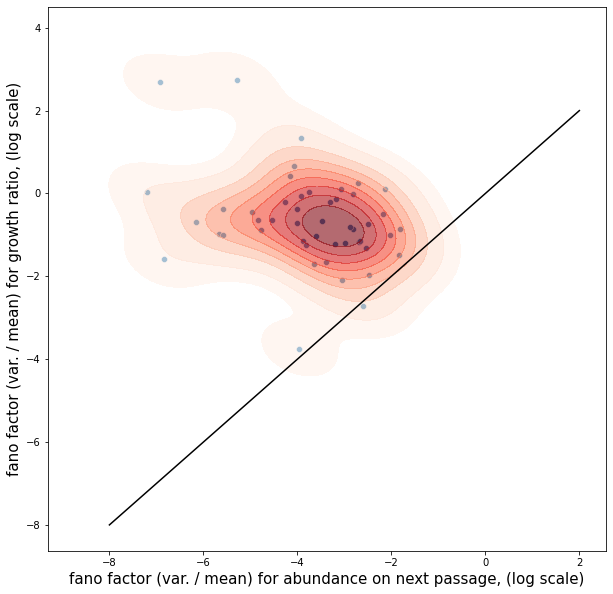

In [1880]:
pass_ = 2
x = fano_[pass_, :]
y = fano_prev[pass_, :]

id_ = np.where((x > 0) & (y > 0))[0]
print(len(id_))
# id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
x = x[id_]
y = y[id_]

plt_ = sns.scatterplot(y=np.log10(x), \
                       x=np.log10(y))
plt_ = sns.kdeplot(y=np.log10(x), x=np.log10(y), \
                   fill=True, alpha=0.6, cmap="Reds", ax=plt_)
# plt_.axhline(0.0, c="black")
plt_.plot([-8, 2], [-8, 2], c="black")
plt_.set_ylabel("fano factor (var. / mean) for growth ratio, (log scale)", size=15)
plt_.set_xlabel("fano factor (var. / mean) for abundance on next passage, (log scale)", size=15)
# plt_.set_xscale("log", base=10)
# plt_.set_yscale("log", base=10)
corr_val = scipy.stats.spearmanr(np.log10(x), np.log10(y))
print(corr_val)

In [1850]:
fano_prev.max()

0.015222794324476903

40
SpearmanrResult(correlation=-0.3795497185741089, pvalue=0.01571264158683233)


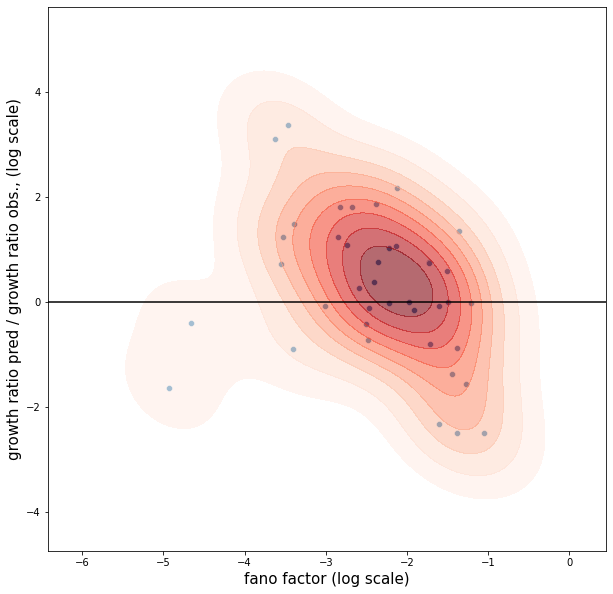

In [1816]:
df_ = pd.DataFrame(data={"growth rate obs" : growth_rate_obs[:, pass_], \
                         "growth rate pred" : growth_rate_species[count_p, :, pass_, num_iter - 1]})

x = df_["growth rate obs"].values
y = df_["growth rate pred"].values

id_ = np.where((~np.isnan(x)) & (y >= 0) & (fano_ <= 0.1))[0]
print(len(id_))
# id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
x = x[id_]
y = y[id_]

fano_tmp = fano_[id_]

plt_ = sns.scatterplot(y=np.log10(y / x), \
                       x=np.log10(fano_tmp))
plt_ = sns.kdeplot(y=np.log10(y / x), x=np.log10(fano_tmp), \
                   fill=True, alpha=0.6, cmap="Reds", ax=plt_)
plt_.axhline(0.0, c="black")
# plt_.plot([-5, 2], [-6, 2], c="black")
plt_.set_ylabel("growth ratio pred / growth ratio obs., (log scale)", size=15)
plt_.set_xlabel("fano factor (log scale)", size=15)
# plt_.set_xscale("log", base=10)
# plt_.set_yscale("log", base=10)
corr_val = scipy.stats.spearmanr(np.log10(y / x), np.log10(fano_tmp))
print(corr_val)

In [93]:
print(growth_rate_species[count_p, :, pass_, num_iter - 1])
print(growth_rate_obs[:, pass_])

[6.81261538e-03 1.28696239e+00 0.00000000e+00 3.21700054e-02
 5.94875561e-03 3.50299203e-01 0.00000000e+00 7.08461287e-01
 2.90301807e-02 1.96293772e+00 7.65679379e-01 5.01579059e-03
 2.79346782e-02 0.00000000e+00 2.40140229e+01 0.00000000e+00
 5.37361870e-01 0.00000000e+00 3.75014990e-01 4.49463900e-02
 9.27849005e-03 0.00000000e+00 7.70283547e+00 0.00000000e+00
 2.12522190e-03 0.00000000e+00 2.82534715e-03 1.00000000e+03
 1.00000000e-06 0.00000000e+00 1.06471480e-05 3.15994717e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.54858466e-02
 1.27356771e-02 0.00000000e+00 5.54859713e-01 0.00000000e+00
 4.14023503e-02 1.22920067e-01 0.00000000e+00 4.15907695e-03
 1.17204910e-01 0.00000000e+00 5.48993294e+01 2.57291251e-03
 6.32610233e-04 5.99882211e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.44721698e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.91561248e-04 0.00000000e+00 3.82007627e-02
 8.74932872e-01 3.80395488e-01 2.52255826e-04]
[6.08416622e-03 1.05099914e+00 4.72530

40
PearsonRResult(statistic=0.3193309470309558, pvalue=0.04458874339437074)


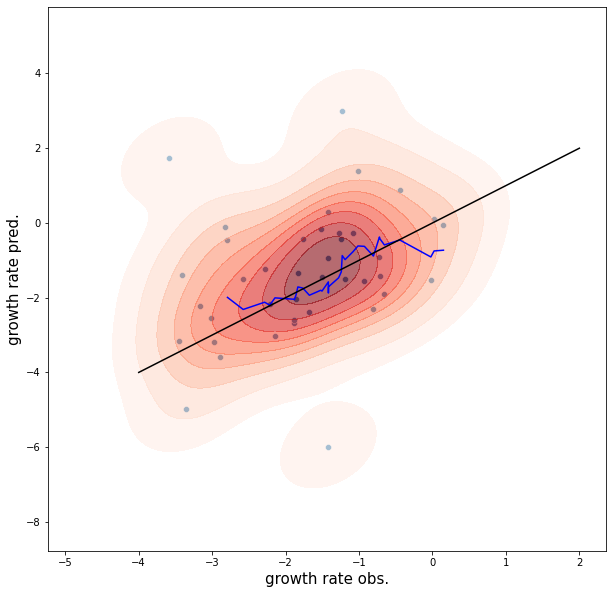

In [94]:
count_p = 0
pass_ = 0
df_ = pd.DataFrame(data={"growth rate obs" : growth_rate_obs[:, pass_], \
                         "growth rate pred" : growth_rate_species[count_p, :, pass_, num_iter - 1]})

x = df_["growth rate obs"].values
y = df_["growth rate pred"].values

id_ = np.where((~np.isnan(x)) & (y > 0))[0]
# id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
x = x[id_]
y = y[id_]
print(len(id_))

id_order = np.argsort(x)
x_order = (x.copy())[id_order]
y_order = (y.copy())[id_order]
df_ = pd.DataFrame(data={"x" : np.log10(x_order), "y" : np.log10(y_order)})
window_size = 10
rolling_avg = df_['y'].rolling(window_size).mean().values
id_not_nan = np.where(~np.isnan(rolling_avg))[0]
id_nan = np.where(np.isnan(rolling_avg))[0]

plt_ = sns.scatterplot(x=np.log10(x), \
                       y=np.log10(y))
plt_ = sns.kdeplot(x=np.log10(x), y=np.log10(y), fill=True, alpha=0.6, cmap="Reds", ax=plt_)

plt_ = sns.lineplot(x=(df_['x']), \
                    y=(rolling_avg), color='blue', ax=plt_)

plt_.plot([-4, 2], [-4, 2], c="black")
plt_.set_xlabel("growth rate obs.", size=15)
plt_.set_ylabel("growth rate pred.", size=15)
# plt_.set_xscale("log", base=10)
# plt_.set_yscale("log", base=10)
corr_val = scipy.stats.pearsonr(np.log10(x), np.log10(y))
print(corr_val)

# Fit model where Ri and abundances are fit alternatively in multiple iterations. abundances are fitted for all passages

In [2113]:
sample_names_split

['p2_r0', 'p2_r1', 'p2_r2']

In [2117]:
def compute_growth_ratio(train_strain_id, test_strain_id, df_speciesAbun_prev_tmp, \
                         df_speciesAbun_next_tmp, \
                         df_speciesMetab, df_speciesAbun_ratio_new, Ri, initial_guess, p_tmp):
    def objective_(g, *args):
        train_strain_id = args[0].copy()
        test_strain_id = args[1].copy()
        df_speciesAbun_prev = args[2].copy()
        df_speciesAbun_next = args[3].copy()
        df_speciesMetab = args[4].copy()
        df_speciesAbun_ratio = args[5].copy()
        Ri = args[6].copy()
        p_tmp = args[7]
        df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
#         df_speciesAbun_ratio_new.iloc[test_strain_id, :] = g * np.ones((len(test_strain_id)))
        df_speciesAbun_next.iloc[test_strain_id, :] = g * np.ones((len(test_strain_id)))
        df_speciesAbun_ratio_new.iloc[test_strain_id, :] = \
            df_speciesAbun_next.iloc[test_strain_id, :].values / \
            df_speciesAbun_prev.iloc[test_strain_id, :].values
        sample_names_split, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                                 df_speciesAbun_next.copy(), p_=p_tmp)
        count_ = 0
        for sample_ in sample_names_split:
            pass_ = int(sample_.split("_")[0][1])
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][:, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[:, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[:, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
#             tmp = np.array(tmp**(-p_tmp)).reshape((df_speciesAbun_ratio.shape[0], 1))
            tmp = np.array(tmp).reshape((df_speciesAbun_ratio.shape[0], 1))
            tmp = tmp[id_keep, :]
#             tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
#             A_train_sample = np.multiply(A_train_sample, tmp)
#             A_train_sample = np.log(A_train_sample) - p_tmp * np.log(tmp)
            A_train_sample = A_train_sample[id_keep, :]

    #         pass_all += [pass_] * len(id_keep)
    #         brep_all += [brep_] * len(id_keep)
#             p_tmp_new = p_tmp
            if pass_ == 2:
                p_tmp_new = p_tmp
            else:
#                 p_tmp_new = 1e-8
                p_tmp_new = p_tmp
            if count_ == 0:
                A_train = A_train_sample
                b_train = tmp**p_tmp_new
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
                b_train = np.vstack((b_train, tmp**p_tmp_new))
#         b_train = np.ones((A_train.shape[0]))
#         error_ = b_train - np.matmul(A_train, Ri)
#         error_ = np.log(np.matmul(A_train, Ri).flatten()) - 1 * np.log(b_train.flatten())
        error_ = (np.matmul(A_train, Ri).flatten()) - b_train.flatten()
        error_ = np.sum(error_**2)
        return error_
    
    df_speciesAbun_prev_tmp_ = df_speciesAbun_prev_tmp.copy()
    df_speciesAbun_next_tmp_ = df_speciesAbun_next_tmp.copy()
    df_speciesAbun_ratio_new_ = df_speciesAbun_ratio_new.copy()
    
#     df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_new.copy().iloc[train_strain_id, :]
#     id_ = []
#     for i in range(df_speciesAbun_ratio_tmp.shape[0]):
#         id_z = np.where(df_speciesAbun_ratio_tmp.iloc[i, :].values == -1)[0]
#         if len(id_z) == 0:
#             id_.append(i)
#     initial_guess = np.mean(np.log(df_speciesAbun_ratio_tmp.iloc[id_, :].values).mean(axis=0))
#     initial_guess = np.exp(initial_guess)
#     initial_guess = growth_ratio
    args = (train_strain_id, test_strain_id, df_speciesAbun_prev_tmp_, df_speciesAbun_next_tmp_, \
            df_speciesMetab, df_speciesAbun_ratio_new_, Ri, p_tmp)
    g_sol = minimize(objective_, initial_guess, args=args, bounds=[(1e-8, 1)], 
                     options={"maxiter" : 1000})
    if not g_sol.success:
        g_sol = minimize(objective_, initial_guess, args=args, bounds=[(1e-8, 1)], \
                         options={"maxiter" : 10000})
    
    return g_sol.x[0]

def compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next, df_speciesAbun_ratio, \
               growth_ratio, p_tmp, test_strain_id, num_passages):
    
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()

    df_speciesAbun_next_tmp.iloc[test_strain_id, :] = 1e-8
    df_speciesAbun_ratio_new.iloc[test_strain_id, :] = -1
    for pass_ in range(num_passages):
        df_speciesAbun_next_tmp.iloc[test_strain_id, [pass_, pass_ + 5, pass_ + 10]] = \
            growth_ratio[pass_] * np.ones((3))
        df_speciesAbun_ratio_new.iloc[test_strain_id, [pass_, pass_ + 5, pass_ + 10]] = \
            df_speciesAbun_next_tmp.iloc[test_strain_id, [pass_, pass_ + 5, pass_ + 10]].values / \
            df_speciesAbun_prev_tmp.iloc[test_strain_id, [pass_, pass_ + 5, pass_ + 10]].values

    sample_names_split = list(df_speciesAbun_prev_tmp.columns.values)
    count_ = 0 
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        
        if pass_ == 2:
            p_tmp_new = p_tmp
        else:
#             p_tmp_new = 1e-8
            p_tmp_new = p_tmp
        
        _, mat_cons_abun_split_list_tmp = \
            iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                 df_speciesAbun_next_tmp.copy(), p_=p_tmp_new)
        if pass_ > -1:
            brep_ = int(sample_.split("_")[1][1])
            A_train_sample = mat_cons_abun_split_list_tmp[sample_][train_strain_id, :]
            sample_id = sample_names_split.index(sample_)
            tmp = np.array(df_speciesAbun_ratio_new.iloc[train_strain_id, sample_id])
            tmp1 = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
            id_keep = np.where(tmp1 != -1)[0]
            id_not_keep = np.where(tmp1 == -1)[0]
            tmp[id_not_keep] = 1
            tmp = np.array(tmp**(-p_tmp_new)).reshape((len(train_strain_id), 1))
#             tmp = np.array(tmp).reshape((len(train_strain_id), 1))
#             tmp = tmp[id_keep, :]
            tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
            A_train_sample = np.multiply(A_train_sample, tmp)
            A_train_sample = A_train_sample[id_keep, :]

    #         pass_all += [pass_] * len(id_keep)
    #         brep_all += [brep_] * len(id_keep)
    #         train_id_all += list(np.array(train_strain_id)[id_keep])
            if count_ == 0:
                A_train = A_train_sample
#                 b_train = tmp**p_tmp_new
                count_ += 1
            else:
                A_train = np.vstack((A_train, A_train_sample))
#                 b_train = np.vstack((b_train, tmp**p_tmp_new))
    b_train = np.ones((A_train.shape[0]))
    coeff_train_ = nnls(A_train, b_train.flatten())[0]
    return coeff_train_

def compute_Ri_growth_ratio(num_passages, train_strain_id, test_strain_id, df_speciesAbun_prev, \
                            df_speciesAbun_next, df_speciesAbun_ratio, df_speciesMetab, p_tmp, \
                            num_iter):
    growth_rate_all = np.zeros((num_passages, num_iter))
    Ri_all = np.zeros((num_iter, df_speciesMetab.shape[1]))
    # initial estimate of growth rate
    
    
    
#     df_speciesAbun_prev_tmp_.iloc[:, 0] = df_speciesAbun_prev_tmp_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_prev_tmp_.columns.values
#     df_speciesAbun_prev_tmp_ = \
#         df_speciesAbun_prev_tmp_.drop(columns=[samples_[1], samples_[2]], axis=1)
    
#     df_speciesAbun_next_tmp_.iloc[:, 0] = df_speciesAbun_next_tmp_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_next_tmp_.columns.values
#     df_speciesAbun_next_tmp_ = \
#         df_speciesAbun_next_tmp_.drop(columns=[samples_[1], samples_[2]], axis=1)
    
#     df_speciesAbun_ratio_new_.iloc[:, 0] = df_speciesAbun_ratio_new_.apply(np.mean, axis=1).values
#     samples_ = df_speciesAbun_ratio_new_.columns.values
#     df_speciesAbun_ratio_new_ = \
#         df_speciesAbun_ratio_new_.drop(columns=[samples_[1], samples_[2]], axis=1)

    growth_rate_tmp = np.zeros((num_passages))
    for pass_ in range(num_passages):
#         df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_next_tmp_ = df_speciesAbun_next_tmp_.copy().iloc[train_strain_id, :]
        df_speciesAbun_ratio_new_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
        df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_new_.copy().iloc[train_strain_id, :]
#         id_ = []
#         for i in range(df_speciesAbun_ratio_tmp.shape[0]):
#             id_z = np.where(df_speciesAbun_ratio_tmp.iloc[i, :].values == -1)[0]
#             if len(id_z) == 0:
#                 id_.append(i)
        mat_ratio = np.array(df_speciesAbun_next_tmp_).flatten()
        growth_rate_0 = np.mean(np.log(mat_ratio[mat_ratio != -1]))
        growth_rate_tmp[pass_] = np.exp(growth_rate_0)
    
    
    for iter_ in range(num_iter):
        df_speciesAbun_next_mask = df_speciesAbun_next.copy()
        df_speciesAbun_ratio_mask = df_speciesAbun_ratio.copy()
        df_speciesAbun_next_mask.iloc[test_strain_id, :] = 1e-8
        df_speciesAbun_ratio_mask.iloc[test_strain_id, :] = -1
        
        Ri = compute_Ri(df_speciesMetab, df_speciesAbun_prev, df_speciesAbun_next_mask, \
                        df_speciesAbun_ratio_mask, \
                        growth_rate_tmp, p_tmp, test_strain_id, num_passages)
        Ri_all[iter_, :] = Ri.copy()
        
        for pass_ in range(num_passages):
            df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
            df_speciesAbun_next_tmp_ = df_speciesAbun_next_mask.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
            df_speciesAbun_ratio_new_ = df_speciesAbun_ratio.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
            
            if pass_ > 0:
                df_speciesAbun_prev_tmp_.iloc[test_strain_id, :] = \
                    growth_rate_tmp[pass_ - 1] * np.ones((len(test_strain_id)))

            growth_rate = compute_growth_ratio(train_strain_id, test_strain_id, df_speciesAbun_prev_tmp_, \
                                               df_speciesAbun_next_tmp_, \
                                               df_speciesMetab, df_speciesAbun_ratio_new_, Ri, \
                                               growth_rate_tmp[pass_], p_tmp)
            growth_rate_all[pass_, iter_] = growth_rate
            growth_rate_tmp[pass_] = growth_rate
        
    return Ri_all, growth_rate_all
    

In [2118]:
count_p = 2
num_iter = 10
pass_ = 0
p_vec_new = p_vec.copy()
p_vec_new = [0.05, 0.1, 0.125, 0.15, 0.2, 0.225]
# p_vec_new = [0.1]
# p_vec_new = [1e-3, 1e-2, 0.025, 0.05, 0.075]
num_passages = 5
abundance_next_species = np.zeros((len(p_vec_new), num_species, num_passages, num_iter))
Ri_all_mat = np.zeros((len(p_vec_new), num_species, num_iter, num_metabs))
for count_p, p_tmp in enumerate(p_vec_new):
    print(f'count_p = {count_p}')
    for species_ in range(num_species):
        test_strain_id = [species_]
        train_strain_id = list(set(range(num_species)) - set(test_strain_id))
        Ri_all, growth_rate_all = \
            compute_Ri_growth_ratio(num_passages, train_strain_id, test_strain_id, df_speciesAbun_prev, \
                                    df_speciesAbun_next, df_speciesAbun_ratio, df_speciesMetab, p_tmp, \
                                    num_iter)
        Ri_all_mat[count_p, species_, :, :] = Ri_all
        abundance_next_species[count_p, species_, :, :] = growth_rate_all.copy()
        
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictNextAbun'
                                         f'_iterate_Ri_NextAbun_dynamical.pickle'))
# file_save = os.path.abspath(os.path.join(save_dir, 
#                                          f'trained_model_different_p_leaveOneOut_predictNextAbun'
#                                          f'_iterate_Ri_NextAbun_dynamical_steadyStateAfterPass2.pickle'))

save_obj = {"Ri_all_mat" : Ri_all_mat, "abundance_pred" : abundance_next_species}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)  

count_p = 0
count_p = 1
count_p = 2
count_p = 3
count_p = 4
count_p = 5


In [96]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictNextAbun'
                                         f'_iterate_Ri_NextAbun_dynamical.pickle'))
with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
Ri_all_mat = save_obj["Ri_all_mat"]
abundance_next_species = save_obj["abundance_pred"]

In [2124]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictNextAbun'
                                         f'_iterate_Ri_NextAbun.pickle'))
with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
Ri_all_mat = save_obj["Ri_all_mat"]
abundance_next_species = save_obj["abundance_pred"]

In [70]:
abundance_next_obs = -1 * np.ones((num_species, num_passages))
abundance_prev_obs = -1 * np.ones((num_species, num_passages))

for pass_ in range(num_passages):
    df_speciesAbun_next_tmp_ = df_speciesAbun_next.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    df_speciesAbun_prev_tmp_ = df_speciesAbun_prev.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
    for species_ in range(num_species):
        x = df_speciesAbun_next_tmp_.iloc[species_, :].values
        
        if len(x) > 0:
            abundance_next_obs[species_, pass_] = np.exp(np.mean(np.log(x[x != -1])))
            
        y = df_speciesAbun_prev_tmp_.iloc[species_, :].values
        
        if len(y) > 0:
            abundance_prev_obs[species_, pass_] = np.exp(np.mean(np.log(y[y != -1])))

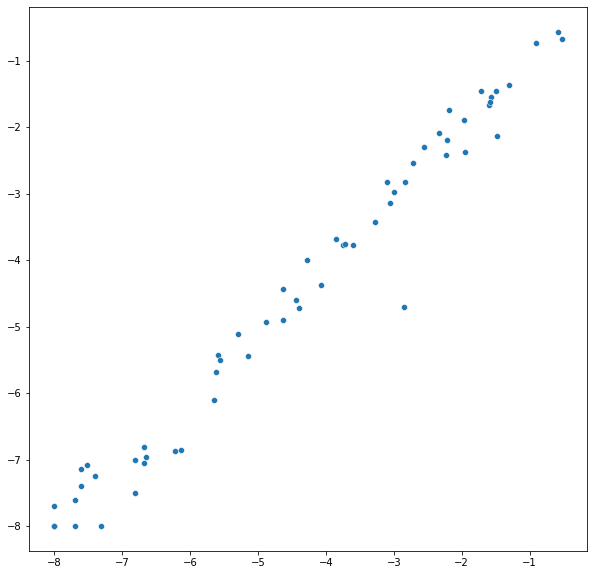

In [1984]:
pass_ = 4
plt_ = sns.scatterplot(x=np.log10(abundance_prev_obs[:, pass_]), y=np.log10(abundance_next_obs[:, pass_]))

# Scatterplot between abundance on next and previous passage

In [ ]:
# next abundance vs previous abundance across all passages
fig, axes = plt.subplots(2, 3, figsize=(15, 12), sharey="row", sharex="col")
fig.suptitle('next abundance vs previous abundance across all passages', \
             fontsize=15)
fig.supxlabel('abundance on previous passage (log scale)', fontsize=15)
fig.supylabel('abundance on next passage (log scale)', fontsize=15)
plt_rows = 2
plt_cols = 3

pass_ = 0
# passage 1 to 2
for pass_ in range(num_passages):
    col_ = int(pass_ / plt_rows)
    row_ = int(pass_ % plt_rows)
    
    # get slope
    x = np.log10(abundance_prev_obs[:, pass_])
    y = np.log10(abundance_next_obs[:, pass_])
    model = sm.OLS(y, x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]
    
    plt_ = sns.scatterplot(ax=axes[row_, col_], x=np.log10(abundance_prev_obs[:, pass_]), \
                y=np.log10(abundance_next_obs[:, pass_]))
    plt_ = sns.kdeplot(x=np.log10(abundance_prev_obs[:, pass_]), \
                y=np.log10(abundance_next_obs[:, pass_]), fill=True, alpha=0.6, cmap="Reds", \
                ax=axes[row_, col_])
    plt_.plot([-10, 0], [-10, 0], c="black")
    corr_val_pe = scipy.stats.pearsonr(np.log10(abundance_prev_obs[:, pass_]), \
                                    np.log10(abundance_next_obs[:, pass_]))
    corr_val_sp = scipy.stats.spearmanr(np.log10(abundance_prev_obs[:, pass_]), \
                                    np.log10(abundance_next_obs[:, pass_]))
    title_ = f'passage {pass_ + 1} to {pass_ + 2} \n'\
            f'pearson cc (log) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe[1]) + \
            f'\n spearman cc (log) = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
            f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
            '{:.3e}'.format(slope_pval)
    axes[row_, col_].set_title(title_, size=10)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'abundance_prev_vs_next_scatter.png'))
fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)


# Scatterplot between abundance on next and the abundance on passage 1

In [2229]:
# next abundance vs previous abundance across all passages
fig, axes = plt.subplots(2, 3, figsize=(15, 12), sharey="row", sharex="col")
fig.suptitle('next abundance vs previous abundance across all passages', \
             fontsize=15)
fig.supylabel('abundance on passage 1 (log scale)', fontsize=15)
fig.supxlabel('abundance on next passage (log scale)', fontsize=15)
plt_rows = 2
plt_cols = 3

pass_ = 0
# passage 1 to 2
for pass_ in range(num_passages):
    col_ = int(pass_ / plt_rows)
    row_ = int(pass_ % plt_rows)
    
    # get slope
    y = np.log10(abundance_prev_obs[:, 0])
    x = np.log10(abundance_next_obs[:, pass_])
    model = sm.OLS(y, x).fit()
    slope = model.params[0]
    slope_pval = model.pvalues[0]
    
    plt_ = sns.scatterplot(ax=axes[row_, col_], x=x, \
                y=y)
    plt_ = sns.kdeplot(x=x, y=y, fill=True, alpha=0.6, cmap="Reds", \
                ax=axes[row_, col_])
    plt_.plot([-10, 0], [-10, 0], c="black")
    corr_val_pe = scipy.stats.pearsonr(x, y)
    corr_val_sp = scipy.stats.spearmanr(x, y)
    title_ = f'passage {pass_ + 1} to {pass_ + 2} \n'\
            f'pearson cc (log) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_pe[1]) + \
            f'\n spearman cc (log) = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                    '{:.3e}'.format(corr_val_sp[1]) + \
            f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
            '{:.3e}'.format(slope_pval)
    axes[row_, col_].set_title(title_, size=10)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'abundance_next_vs_passage1_scatter.png'))
fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)


# Scatterplot for predicted vs observed abundance from the model where previous abundance is known

In [2146]:
# load the trained model results
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictNextAbun'
                                         f'_iterate_Ri_NextAbun.pickle'))
with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
Ri_all_mat = save_obj["Ri_all_mat"]
abundance_next_species = save_obj["abundance_pred"]



pass_ = 0
for count_p, p_tmp in enumerate(p_vec_new):
    
#     predicted vs observed abundance
    fig, axes = plt.subplots(2, 3, figsize=(15, 12), sharey="row", sharex="col")
    fig.suptitle(f'predicted vs observed next abundance across all passages\n p = {p_tmp}', \
                 fontsize=15)
    fig.supxlabel('observed abundance on next passage (log scale)', fontsize=15)
    fig.supylabel('predicted abundance on next passage (log scale)', fontsize=15)
    plt_rows = 2
    plt_cols = 3
    for pass_ in range(num_passages):
        col_ = int(pass_ / plt_rows)
        row_ = int(pass_ % plt_rows)

        # get slope
        y = np.log10(abundance_next_species[count_p, :, pass_, num_iter - 1])
        x = np.log10(abundance_next_obs[:, pass_])
        model = sm.OLS(y, x).fit()
        slope = model.params[0]
        slope_pval = model.pvalues[0]

        plt_ = sns.scatterplot(ax=axes[row_, col_], x=x, \
                    y=y)
        plt_ = sns.kdeplot(x=x, \
                    y=y, fill=True, alpha=0.6, cmap="Reds", \
                    ax=axes[row_, col_])
        plt_.plot([-10, 0], [-10, 0], c="black")
        corr_val_pe = scipy.stats.pearsonr(x, y)
        corr_val_sp = scipy.stats.spearmanr(x, y)
        title_ = f'passage {pass_ + 1} to {pass_ + 2} \n'\
                f'pearson cc (log) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                        '{:.3e}'.format(corr_val_pe[1]) + \
                f'\n spearman cc (log) = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                        '{:.3e}'.format(corr_val_sp[1]) + \
                f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                '{:.3e}'.format(slope_pval)
        axes[row_, col_].set_title(title_, size=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        'predictions', 'leaveOneOut'))
    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'abundance_prev_predicted_vs_observed_scatter_pid{count_p}' + \
                                             f'_p{p_tmp}_' + \
                                             f'model_predictNextAbun_prevAbun_known.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)


# Error distribution predicted vs observed abundance from the model where previous abundance is known

In [2216]:
# load the trained model results
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictNextAbun'
                                         f'_iterate_Ri_NextAbun.pickle'))
with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
Ri_all_mat = save_obj["Ri_all_mat"]
abundance_next_species = save_obj["abundance_pred"]


df_ = pd.DataFrame(data={"ratio" : [], \
                         "type" : [], \
                         "passage" : []})
pairs_ = []
for pass_ in range(num_passages):
    df_tmp = pd.DataFrame(data={"ratio" : abundance_prev_obs[:, pass_] / abundance_next_obs[:, pass_], \
                             "type" : "null model", \
                             "passage" : f'passage {pass_ + 1}->{pass_ + 2}'})
    df_ = pd.concat([df_, df_tmp], ignore_index = True)
    for count_p, p_tmp in enumerate(p_vec_new):
        df_tmp = pd.DataFrame(data={"ratio" : abundance_next_species[count_p, :, pass_, num_iter - 1] / \
                                    abundance_next_obs[:, pass_], \
                                    "type" : f'p = {p_tmp}', \
                                    "passage" : f'passage {pass_ + 1}->{pass_ + 2}'})
        df_ = pd.concat([df_, df_tmp], ignore_index = True)
        
        pairs_.append(((f'passage {pass_ + 1}->{pass_ + 2}', f'p = {p_tmp}'), \
                       (f'passage {pass_ + 1}->{pass_ + 2}', "null model")))
        

# pairs_ = []
# for count_p, p_tmp in enumerate(p_vec_new):
#     pairs_.append(((f'p = {p_tmp}'), "null model"))

    
plt_rows = 2
plt_cols = 3

col_ = 0
row_ = 0


plotting_parameters = {
    'data':    df_,
    'x':       'passage',
    'y':       'ratio',
    'hue': "type"
}
# ax = get_log_ax()
mpl.rcParams['figure.figsize'] = 10, 10
plt_ = sns.boxplot(**plotting_parameters)
plt_.axhline(1, c="red")
plt_.set_yscale("log", base=10)

annotator = Annotator(plt_, pairs_, **plotting_parameters)
annotator.new_plot(ax=plt_, pairs=pairs_, **plotting_parameters)
annotator.configure(test='Mann-Whitney', verbose=True, text_format="simple").apply_and_annotate()

plt_.set_xlabel('passage transition', fontsize=20)
# plt.xlabel('passage transition', fontsize=300)
plt_.set_ylabel('ratio of predicted to observed next abundance', fontsize=20)
plt_.set_title(f'error in ratio of predicted vs observed next abundance\n ' + \
               f'model where previous abundance is known', fontsize=25)
ticks_x = plt_.get_xticklabels()
plt_.set_xticklabels(ticks_x, size=12)
plt_.set_yticklabels(plt_.get_yticklabels(), size=10)


save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'ratio_predicted_to_next_abundance_modelWithPrevAbunKnown.png'))
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(plt_.figure)


passage 2->3_null model vs. passage 2->3_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:9.533e-01 U_stat=1.997e+03
passage 1->2_null model vs. passage 1->2_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:4.976e-01 U_stat=2.124e+03
passage 3->4_null model vs. passage 3->4_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:6.084e-01 U_stat=2.090e+03
passage 4->5_null model vs. passage 4->5_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.985e+03
passage 5->6_null model vs. passage 5->6_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:4.040e-01 U_stat=1.813e+03
passage 2->3_null model vs. passage 2->3_p = 0.1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.544e-02 U_stat=2.443e+03
passage 1->2_null model vs. passage 1->2_p = 0.1: Mann-Whitney-Wilcoxon test two-sided, P_val:7.833e-03 U_stat=2.530e+03
passage 3->4_null model vs. passage 3->4_p = 0.1: Mann-Whitney-Wilcoxon test two-sided, P_val:8.788e-03 U_stat=2.522e+03
passage 4->5_null model vs.

<ipython-input-2216-0a8a4d378f6a>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)


In [2209]:
np.max(df_["ratio"].values)

4357271.5634260755

# Scatterplot for predicted vs observed abundance from the model where previous abundance is known only for transition from passage 1 to 2. This is a completely dynamical model

In [2148]:
# load the trained model results
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictNextAbun'
                                         f'_iterate_Ri_NextAbun_dynamical.pickle'))
with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
Ri_all_mat = save_obj["Ri_all_mat"]
abundance_next_species = save_obj["abundance_pred"]



pass_ = 0
for count_p, p_tmp in enumerate(p_vec_new):
    
#     predicted vs observed abundance
    fig, axes = plt.subplots(2, 3, figsize=(15, 12), sharey="row", sharex="col")
    fig.suptitle(f'predicted vs observed next abundance across all passages\n p = {p_tmp}', \
                 fontsize=15)
    fig.supxlabel('observed abundance on next passage (log scale)', fontsize=15)
    fig.supylabel('predicted abundance on next passage (log scale)', fontsize=15)
    plt_rows = 2
    plt_cols = 3
    for pass_ in range(num_passages):
        col_ = int(pass_ / plt_rows)
        row_ = int(pass_ % plt_rows)

        # get slope
        y = np.log10(abundance_next_species[count_p, :, pass_, num_iter - 1])
        x = np.log10(abundance_next_obs[:, pass_])
        model = sm.OLS(y, x).fit()
        slope = model.params[0]
        slope_pval = model.pvalues[0]

        plt_ = sns.scatterplot(ax=axes[row_, col_], x=x, \
                    y=y)
        plt_ = sns.kdeplot(x=x, \
                    y=y, fill=True, alpha=0.6, cmap="Reds", \
                    ax=axes[row_, col_])
        plt_.plot([-10, 0], [-10, 0], c="black")
        corr_val_pe = scipy.stats.pearsonr(x, y)
        corr_val_sp = scipy.stats.spearmanr(x, y)
        title_ = f'passage {pass_ + 1} to {pass_ + 2} \n'\
                f'pearson cc (log) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                        '{:.3e}'.format(corr_val_pe[1]) + \
                f'\n spearman cc (log) = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                        '{:.3e}'.format(corr_val_sp[1]) + \
                f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
                '{:.3e}'.format(slope_pval)
        axes[row_, col_].set_title(title_, size=10)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        'predictions', 'leaveOneOut'))
    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'abundance_prev_predicted_vs_observed_scatter_pid{count_p}' + \
                                             f'_p{p_tmp}_' + \
                                             f'model_predictNextAbun_prevAbun_unknown_dynamical.png'))
    fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    plt.close(fig.figure)


# Error distribution predicted vs observed abundance from the model where previous abundance is unknown; dynamical model. Null model is abundance is set equal to abundance from passage 1

In [2225]:
# load the trained model results
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictNextAbun'
                                         f'_iterate_Ri_NextAbun_dynamical.pickle'))
with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
Ri_all_mat = save_obj["Ri_all_mat"]
abundance_next_species = save_obj["abundance_pred"]

df_ = pd.DataFrame(data={"ratio" : [], \
                         "type" : [], \
                         "passage" : []})
pairs_ = []
for pass_ in range(num_passages):
    df_tmp = pd.DataFrame(data={"ratio" : abundance_prev_obs[:, 0] / abundance_next_obs[:, pass_], \
                             "type" : "null model", \
                             "passage" : f'passage {pass_ + 1}->{pass_ + 2}'})
    df_ = pd.concat([df_, df_tmp], ignore_index = True)
    for count_p, p_tmp in enumerate(p_vec_new):
        df_tmp = pd.DataFrame(data={"ratio" : abundance_next_species[count_p, :, pass_, num_iter - 1] / \
                                    abundance_next_obs[:, pass_], \
                                    "type" : f'p = {p_tmp}', \
                                    "passage" : f'passage {pass_ + 1}->{pass_ + 2}'})
        df_ = pd.concat([df_, df_tmp], ignore_index = True)
        
        pairs_.append(((f'passage {pass_ + 1}->{pass_ + 2}', f'p = {p_tmp}'), \
                       (f'passage {pass_ + 1}->{pass_ + 2}', "null model")))
        

# pairs_ = []
# for count_p, p_tmp in enumerate(p_vec_new):
#     pairs_.append(((f'p = {p_tmp}'), "null model"))

    
plt_rows = 2
plt_cols = 3

col_ = 0
row_ = 0


plotting_parameters = {
    'data':    df_,
    'x':       'passage',
    'y':       'ratio',
    'hue': "type"
}
# ax = get_log_ax()
mpl.rcParams['figure.figsize'] = 10, 10
plt_ = sns.boxplot(**plotting_parameters)
plt_.axhline(1, c="red")
plt_.set_yscale("log", base=10)

annotator = Annotator(plt_, pairs_, **plotting_parameters)
annotator.new_plot(ax=plt_, pairs=pairs_, **plotting_parameters)
annotator.configure(test='Mann-Whitney', verbose=True, text_format="simple").apply_and_annotate()

plt_.set_xlabel('passage transition', fontsize=20)
# plt.xlabel('passage transition', fontsize=300)
plt_.set_ylabel('ratio of predicted to observed next abundance', fontsize=20)
plt_.set_title(f'error in ratio of predicted vs observed next abundance\n ' + \
               f'dynamical model where previous abundance is unknown', fontsize=20)
ticks_x = plt_.get_xticklabels()
plt_.set_xticklabels(ticks_x, size=12)
plt_.set_yticklabels(plt_.get_yticklabels(), size=10)


save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'ratio_predicted_to_next_abundance_modelWithPrevAbunUnknown_' + \
                                         f'dynamicalModel.png'))
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(plt_.figure)


passage 2->3_null model vs. passage 2->3_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:1.267e-01 U_stat=2.298e+03
passage 1->2_null model vs. passage 1->2_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:5.582e-01 U_stat=2.105e+03
passage 3->4_null model vs. passage 3->4_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:1.057e-02 U_stat=2.509e+03
passage 4->5_null model vs. passage 4->5_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:5.256e-03 U_stat=2.557e+03
passage 5->6_null model vs. passage 5->6_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:1.071e-02 U_stat=2.508e+03
passage 2->3_null model vs. passage 2->3_p = 0.1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.542e-03 U_stat=2.634e+03
passage 1->2_null model vs. passage 1->2_p = 0.1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.511e-02 U_stat=2.483e+03
passage 3->4_null model vs. passage 3->4_p = 0.1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.334e-05 U_stat=2.852e+03
passage 4->5_null model vs.

<ipython-input-2225-e23ba06c8302>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)


# Get ordered metabs for the fitted dynamical model

In [2242]:
# load the trained model results
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictNextAbun'
                                         f'_iterate_Ri_NextAbun_dynamical.pickle'))
with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
Ri_all_mat = save_obj["Ri_all_mat"]
abundance_next_species = save_obj["abundance_pred"]

count_p = 2
Ri_avg = np.zeros(num_metabs)
for species_ in range(num_species):
    Ri_avg += Ri_all_mat[count_p, species_, num_iter - 1, :]
Ri_avg /= num_species

In [2245]:
Ri_order_obj = get_metab_names_orderedRi(Ri_avg, df_metabIds=df_metabIds, df_metabNames=df_metabNames)

pearson corr.
PearsonRResult(statistic=0.9812161097859965, pvalue=8.610795356601802e-100)
pearson corr. log scale
PearsonRResult(statistic=0.7403324112533288, pvalue=2.1465585515885145e-25)
spearman corr.
SpearmanrResult(correlation=0.9073221324311299, pvalue=2.095380778598126e-53)


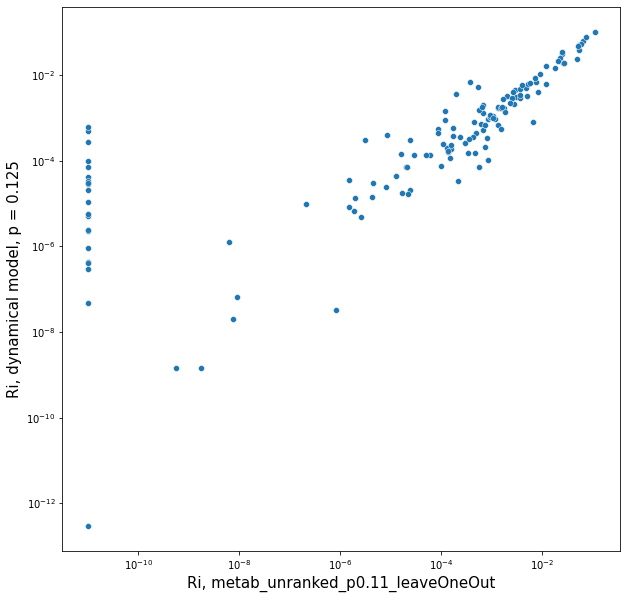

In [2330]:
filename_ = "metabs_unranked_p0.11_leaveOneOut.csv"
filepath_ = os.path.join(os.getcwd(), "..", "figures", "predictions", "leaveOneOut", 
                                filename_)
df_Ri_1e_4 = pd.read_csv(filepath_)

df_plt = pd.DataFrame(data={"x" : df_Ri_1e_4['Ri_fit'].values, 
                            "y" : Ri_avg})
ri_thresh = 0
id__ = np.where((df_Ri_1e_4['Ri_fit'].values > ri_thresh) & (Ri_avg > ri_thresh))[0]
# id__ = range(df_)

df_plt_new = df_plt.copy().iloc[id__, :]
# df_plt_new = df_plt.copy()
plt_ = sns.scatterplot(data=df_plt_new, x="x", y="y")
plt_.set_xscale("log", base=10)
plt_.set_yscale("log", base=10)
plt_.set_xlabel("Ri, metab_unranked_p0.11_leaveOneOut", fontsize=15)
plt_.set_ylabel("Ri, dynamical model, p = 0.125", fontsize=15)

print("pearson corr.")
print(scipy.stats.pearsonr((df_plt_new["x"]), (df_plt_new["y"])))

print("pearson corr. log scale")
print(scipy.stats.pearsonr(np.log(df_plt_new["x"]), np.log(df_plt_new["y"])))

print("spearman corr.")
print(scipy.stats.spearmanr(np.log(df_plt_new["x"]), np.log(df_plt_new["y"])))

In [2362]:
filename_ = "metabs_unranked_p0.11_leaveOneOut.csv"
filepath_ = os.path.join(os.getcwd(), "..", "figures", "predictions", "leaveOneOut", 
                                filename_)
df_Ri_1e_4 = pd.read_csv(filepath_)

df_plt = pd.DataFrame(data={"x" : np.log10(df_Ri_1e_4['Ri_fit'].values), 
                            "y" : np.log10(Ri_avg)})
# ri_thresh = 0
# id__ = np.where((df_Ri_1e_4['Ri_fit'].values > ri_thresh) & (Ri_avg > ri_thresh))[0]
# # id__ = range(df_)

# df_plt_new = df_plt.copy().iloc[id__, :]
# # df_plt_new = df_plt.copy()
# plt_ = sns.scatterplot(data=df_plt_new, x="x", y="y")
# plt_.set_xscale("log", base=10)
# plt_.set_yscale("log", base=10)
# plt_.set_xlabel("Ri, metab_unranked_p0.11_leaveOneOut", fontsize=15)
# plt_.set_ylabel("Ri, dynamical model, p = 0.125", fontsize=15)

# print("pearson corr.")
# print(scipy.stats.pearsonr((df_plt_new["x"]), (df_plt_new["y"])))

# print("pearson corr. log scale")
# print(scipy.stats.pearsonr(np.log(df_plt_new["x"]), np.log(df_plt_new["y"])))

# print("spearman corr.")
# print(scipy.stats.spearmanr(np.log(df_plt_new["x"]), np.log(df_plt_new["y"])))


fig, axes = plt.subplots(1, 2, figsize=(30, 20), sharey="row")
fig.suptitle(f'Ri (dynamical model, p = 0.125) vs ' + \
             f'Ri (metab_unranked_p0.11_leaveOneOut)', \
             fontsize=35)
fig.supxlabel(f'Ri (metab_unranked_p0.11_leaveOneOut)', fontsize=35)
fig.supylabel(f'Ri (dynamical model, p = 0.125)', fontsize=35)

# all Ri values
ri_thresh = 0
id__ = np.where((df_Ri_1e_4['Ri_fit'].values > ri_thresh) & (Ri_avg > ri_thresh))[0]
df_plt_new = df_plt.copy().iloc[id__, :]

plt_ = sns.scatterplot(data=df_plt_new, x="x", y="y", ax=axes[0], s=100)
plt_ = sns.kdeplot(data=df_plt_new, x="x", y="y", fill=True, alpha=0.6, cmap="Reds", \
                   ax=axes[0])
# plt_.set_xscale("log", base=10)
# plt_.set_yscale("log", base=10)
plt_.set_xlabel(None, fontsize=15)
plt_.set_ylabel(None, fontsize=15)
xticks_new = ["$10^{" + str(i) + "}$" for i in plt_.get_xticks()]
plt_.set_xticklabels(xticks_new, fontsize=20)
yticks_new = ["$10^{" + str(i) + "}$" for i in plt_.get_yticks()]
plt_.set_yticklabels(yticks_new, fontsize=20)
corr_val_pe = scipy.stats.pearsonr(10**(df_plt_new["x"]), 10**(df_plt_new["y"]))
corr_val_pe_log = scipy.stats.pearsonr((df_plt_new["x"]), (df_plt_new["y"]))
corr_val_sp = scipy.stats.spearmanr(10**df_plt_new["x"], 10**df_plt_new["y"])
title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
        f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
        f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1])
plt_.set_title(title_, size=20)

# Ri (metab_unranked_p0.11_leaveOneOut) > 1e-10
ri_thresh_1 = 1e-10
ri_thresh_2 = 0
id__ = np.where((df_Ri_1e_4['Ri_fit'].values > ri_thresh_1) & (Ri_avg > ri_thresh_2))[0]
df_plt_new = df_plt.copy().iloc[id__, :]

plt_ = sns.scatterplot(data=df_plt_new, x="x", y="y", ax=axes[1], s=100)
plt_ = sns.kdeplot(data=df_plt_new, x="x", y="y", fill=True, alpha=0.6, cmap="Reds", \
                   ax=axes[1])
# plt_.set_xscale("log", base=10)
# plt_.set_yscale("log", base=10)
plt_.set_xlabel(None, fontsize=15)
plt_.set_ylabel(None, fontsize=15)
xticks_new = ["$10^{" + str(i) + "}$" for i in plt_.get_xticks()]
plt_.set_xticklabels(xticks_new, fontsize=20)
corr_val_pe = scipy.stats.pearsonr(10**(df_plt_new["x"]), 10**(df_plt_new["y"]))
corr_val_pe_log = scipy.stats.pearsonr((df_plt_new["x"]), (df_plt_new["y"]))
corr_val_sp = scipy.stats.spearmanr(10**df_plt_new["x"], 10**df_plt_new["y"])
title_ = f'pearson cc (linear) = {np.round(corr_val_pe[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe[1]) + \
        f'\n pearson cc (log) = {np.round(corr_val_pe_log[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_pe_log[1]) + \
        f'\n spearman cc = {np.round(corr_val_sp[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val_sp[1])
plt_.set_title(title_, size=20)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'Ri(dynamical model, p = 0.125)_vs_' + \
                                         f'Ri(metab_unranked_p0.11_leaveOneOut).png'))
fig.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(fig.figure)

<ipython-input-2362-44b357ea7c0e>:7: RuntimeWarning: divide by zero encountered in log10
  "y" : np.log10(Ri_avg)})
<ipython-input-2362-44b357ea7c0e>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(xticks_new, fontsize=20)
<ipython-input-2362-44b357ea7c0e>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(yticks_new, fontsize=20)
<ipython-input-2362-44b357ea7c0e>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(xticks_new, fontsize=20)


In [2356]:
plt_.get_xticks()

array([-12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.])

In [2316]:
df_metabNames

MS_dname                        met_name  \
0    m_c18p_0000                   GALACTOSAMINE   
1    m_c18p_0006      2-HYDROXYPHENYLACETIC ACID   
2    m_c18p_0008    ALPHA-HYDROXYISOBUTYRIC ACID   
3    m_c18p_0009          N-METHYL-ASPARTIC ACID   
4    m_c18p_0011  2-AMINO-2-METHYLPROPANOIC ACID   
..           ...                             ...   
429  m_c18n_0401                         URIDINE   
430  m_c18n_0467         URIDINE-5-MONOPHOSPHATE   
431  m_c18n_0105                          VALINE   
432  m_c18n_0440                      XANTHOSINE   
433  m_c18n_0493     XANTHOSINE 5'-MONOPHOSPHATE   

     species_to_species_log10_std  std_log10_diff_days  std_log10_same_day  \
0                        0.105265             0.088688            0.068713   
1                        0.155654             0.054601            0.180056   
2                        0.000000             0.000000            0.000000   
3                        0.455184             0.281532            0.030679   
4                        0.528344             0.694992            0.072698   
..                            ...                  ...                 ...   
429                      0.684933             0.681459            0.093541   
430                      0.582905             0.032466            0.058739   
431                      0.146572             0.055575            0.043422   
432                      0.346062             0.136241            0.154190   
433                      1.519161             0.000000            0.328660   

     n_species_measured  
0                    41  
1                     4  
2                     0  
3                   159  
4                    54  
..                  ...  
429                 158  
430                  38  
431                 159  
432                  31  
433                   3  

[434 rows x 6 columns]

In [2378]:
id_ = np.where((10**df_plt["x"].values <= 1e-10) & (10**df_plt["y"].values >= 1e-5))[0]
vals_ = 10**df_plt["y"].values[id_]

id_argsort = np.argsort(-vals_)
# print(vals_[id_argsort])


metab_names_select = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
metab_names_select_new = metab_names_select.copy()[id_]
df_show = pd.DataFrame(data={"name" : metab_names_select_new[id_argsort], 
                             "Ri" : vals_[id_argsort]})
# print(df_show)

df_speciesMetab_tmp = df_speciesMetab.copy()
df_speciesMetab_tmp[df_speciesMetab_tmp != 0] = 1
df_speciesMetab_tmp = np.array(df_speciesMetab_tmp)
df_speciesMetab_tmp
sum_select = df_speciesMetab_tmp.sum(axis=0)
df_tmp = pd.DataFrame(data={"x" : range(len(id_argsort)), 
                            "y" : sum_select[id_][id_argsort], 
                            "metabs" : metab_names_select_new[id_argsort], 
                            "Ri" : vals_[id_argsort]})
print(df_tmp)
# df_tmp = df_tmp.iloc[0:10, :]
mpl.rcParams['figure.figsize'] = 10, 10
plt_ = sns.scatterplot(data=df_tmp, x="x", y="y")
for row_ in range(df_tmp.shape[0]):
    plt.text(df_tmp.iloc[row_, 0], df_tmp.iloc[row_, 1], df_tmp.iloc[row_, 2], \
             fontdict=dict(color='black', alpha=0.5, size=10))
plt_.set_xlabel("rank", fontsize=20) 
plt_.set_ylabel(r'#species where $c^{\alpha}_i > 0$', fontsize=20)
plt_.set_xticklabels(plt_.get_xticks(), fontsize=15)
plt_.set_title(f'metabs where Ri (dynamical model, p = 0.125) > 1e-5 and \n' + \
               f'Ri (metab_unranked_p0.11_leaveOneOut) > 1e-10', fontsize=20)
corr_func = scipy.stats.pearsonr
corr_pval = corr_func((df_tmp["x"].values), (df_tmp["y"].values))
print(corr_pval)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'metabs_where_Ri(dynamical model, p = 0.125)g0_and_' + \
                                         f'Ri(metab_unranked_p0.11_leaveOneOut)g1e-10.png'))
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(plt_.figure)

     x     y                         metabs        Ri
0    0  62.0            N-ACETYLNEURAMINATE  0.000610
1    1   1.0                   BENZALDEHYDE  0.000500
2    2  41.0               PANTOTHENIC ACID  0.000278
3    3  43.0  IS_PHENYLALANINE-2,3,4,5,6-D5  0.000097
4    4  28.0                  GLUTAMIC ACID  0.000073
5    5  11.0             IS_PROGESTERONE-D9  0.000043
6    6   8.0                 LINOLENIC ACID  0.000034
7    7  40.0                        INOSINE  0.000031
8    8  29.0                       MANNITOL  0.000028
9    9  27.0               O-PHOSPHO-SERINE  0.000021
10  10  11.0                    ADIPIC ACID  0.000011
PearsonRResult(statistic=-0.3483667680664847, pvalue=0.29376073423595045)


<ipython-input-2378-3dcd4ce2f194>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticks(), fontsize=15)


In [2380]:
10**df_plt

x             y
0    2.142460e-04  3.418851e-05
1    1.000000e-11  0.000000e+00
2    1.000000e-11  0.000000e+00
3    1.000000e-11  0.000000e+00
4    6.030312e-05  1.364322e-04
..            ...           ...
287  1.000000e-11  0.000000e+00
288  1.000000e-11  0.000000e+00
289  1.000000e-11  0.000000e+00
290  1.000000e-11  0.000000e+00
291  8.996060e-09  6.528161e-08

[292 rows x 2 columns]

In [2314]:
num_rand = 10000
num_metabs_select = df_tmp.shape[0]
median_num_species = []
for m_ in range(num_rand):
    id_ = np.random.permutation(range(num_metabs))[range(num_metabs_select)]
    median_num_species.append(np.median(sum_select[id_])) 
median_num_species = np.array(median_num_species)

21.5
37.0
0.0059


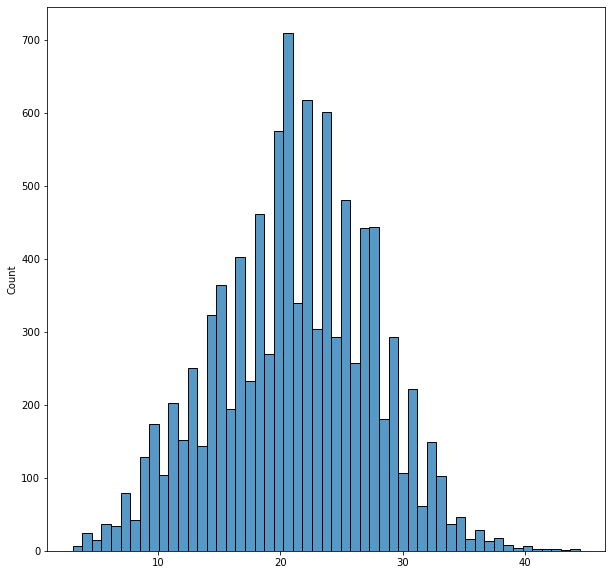

In [2315]:
plt_ = sns.histplot(x=median_num_species)
print(np.median(median_num_species))
print(np.median(df_tmp["y"].values))
print(len(median_num_species[median_num_species >= np.median(df_tmp["y"].values)]) / num_rand)

In [2226]:
# load the trained model results
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "predictions", "leaveOneOut"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_predictNextAbun'
                                         f'_iterate_Ri_NextAbun_dynamical.pickle'))
with open(file_save, "rb") as file_:  
    save_obj = pickle.load(file_)
Ri_all_mat = save_obj["Ri_all_mat"]
abundance_next_species = save_obj["abundance_pred"]

df_ = pd.DataFrame(data={"ratio" : [], \
                         "type" : [], \
                         "passage" : []})
pairs_ = []
for pass_ in range(num_passages):
    df_tmp = pd.DataFrame(data={"ratio" : abundance_prev_obs[:, 0] / abundance_next_obs[:, pass_], \
                             "type" : "null model", \
                             "passage" : f'passage {pass_ + 1}->{pass_ + 2}'})
    df_ = pd.concat([df_, df_tmp], ignore_index = True)
    for count_p, p_tmp in enumerate(p_vec_new):
        id_rm = np.where((abundance_next_obs[:, pass_] > 1e-8) & \
                         (abundance_next_species[count_p, :, pass_, num_iter - 1] == 1e-8))[0]
        id_keep = list(set(range(num_species)) - set(list(id_rm)))
        df_tmp = pd.DataFrame(data={"ratio" : abundance_next_species[count_p, id_keep, pass_, num_iter - 1] / \
                                    abundance_next_obs[id_keep, pass_], \
                                    "type" : f'p = {p_tmp}', \
                                    "passage" : f'passage {pass_ + 1}->{pass_ + 2}'})
        df_ = pd.concat([df_, df_tmp], ignore_index = True)
        
        pairs_.append(((f'passage {pass_ + 1}->{pass_ + 2}', f'p = {p_tmp}'), \
                       (f'passage {pass_ + 1}->{pass_ + 2}', "null model")))
        

# pairs_ = []
# for count_p, p_tmp in enumerate(p_vec_new):
#     pairs_.append(((f'p = {p_tmp}'), "null model"))

    
plt_rows = 2
plt_cols = 3

col_ = 0
row_ = 0


plotting_parameters = {
    'data':    df_,
    'x':       'passage',
    'y':       'ratio',
    'hue': "type"
}
# ax = get_log_ax()
mpl.rcParams['figure.figsize'] = 10, 10
plt_ = sns.boxplot(**plotting_parameters)
plt_.axhline(1, c="red")
plt_.set_yscale("log", base=10)

annotator = Annotator(plt_, pairs_, **plotting_parameters)
annotator.new_plot(ax=plt_, pairs=pairs_, **plotting_parameters)
annotator.configure(test='Mann-Whitney', verbose=True, text_format="simple").apply_and_annotate()

plt_.set_xlabel('passage transition', fontsize=20)
# plt.xlabel('passage transition', fontsize=300)
plt_.set_ylabel('ratio of predicted to observed next abundance', fontsize=20)
plt_.set_title(f'error in ratio of predicted vs observed next abundance\n ' + \
               f'dynamical model where previous abundance is unknown', fontsize=20)
ticks_x = plt_.get_xticklabels()
plt_.set_xticklabels(ticks_x, size=12)
plt_.set_yticklabels(plt_.get_yticklabels(), size=10)


save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'ratio_predicted_to_next_abundance_modelWithPrevAbunUnknown_' + \
                                         f'dynamicalModel_filterSpeciesGreaterthan1e-8.png'))
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(plt_.figure)


passage 2->3_null model vs. passage 2->3_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:8.691e-01 U_stat=1.546e+03
passage 1->2_null model vs. passage 1->2_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.827e+03
passage 3->4_null model vs. passage 3->4_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:3.703e-01 U_stat=1.663e+03
passage 4->5_null model vs. passage 4->5_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:4.305e-01 U_stat=1.578e+03
passage 5->6_null model vs. passage 5->6_p = 0.05: Mann-Whitney-Wilcoxon test two-sided, P_val:6.900e-01 U_stat=1.482e+03
passage 2->3_null model vs. passage 2->3_p = 0.1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.118e-02 U_stat=2.241e+03
passage 1->2_null model vs. passage 1->2_p = 0.1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.582e-02 U_stat=2.331e+03
passage 3->4_null model vs. passage 3->4_p = 0.1: Mann-Whitney-Wilcoxon test two-sided, P_val:6.684e-04 U_stat=2.204e+03
passage 4->5_null model vs.

<ipython-input-2226-79f4d0a531d3>:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=10)


In [2224]:
len(id_keep)

39

63


<ipython-input-2137-f6a9b490e0e5>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-2137-f6a9b490e0e5>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


Text(0.5, 1.0, 'passage 2 to 3,\n p = 0.125, pearson cc (log) = 0.526, pval = 9.402e-06\n slope = 0.868, pvalue = 3.639e-25')

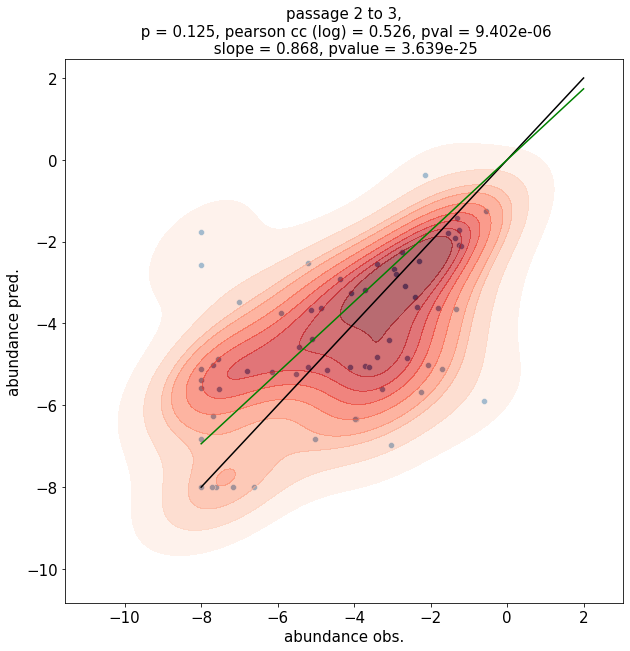

In [2137]:
count_p = 2
pass_ = 1
df_ = pd.DataFrame(data={"growth rate obs" : abundance_next_obs[:, pass_], \
                                 "growth rate pred" : abundance_next_species[count_p, :, pass_, num_iter - 1]})

x = df_["growth rate obs"].values
y = df_["growth rate pred"].values

id_ = np.where((~np.isnan(x)) & (y > 0))[0]
print(len(id_))
# id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
x = x[id_]
y = y[id_]
if pass_ > 0:
    z = abundance_prev_obs[id_, pass_]
else:
    z = abundance_prev_obs[id_, :]
    z = z[:, np.arange(0, num_passages)].mean(axis=1)
# print(len(id_))

x_plt = x
y_plt = y

model = sm.OLS(np.log10(y_plt), np.log10(x_plt)).fit()
slope = model.params[0]
slope_pval = model.pvalues[0]

id_order = np.argsort(x)
x_order = (x.copy())[id_order]
y_order = (y.copy())[id_order]
df_ = pd.DataFrame(data={"x" : np.log10(x_order), "y" : np.log10(y_order)})
window_size = 10
rolling_avg = df_['y'].rolling(window_size).mean().values
id_not_nan = np.where(~np.isnan(rolling_avg))[0]
id_nan = np.where(np.isnan(rolling_avg))[0]

mpl.rcParams['figure.figsize'] = 10, 10
plt_ = sns.scatterplot(x=np.log10(x_plt), \
                       y=np.log10(y_plt))
plt_ = sns.kdeplot(x=np.log10(x_plt), y=np.log10(y_plt), fill=True, alpha=0.6, cmap="Reds", ax=plt_)

# plt_ = sns.lineplot(x=(df_['x']), \
#                     y=(rolling_avg), color='blue', ax=plt_)

plt_.plot([-8, 2], [-8, 2], c="black")
plt_.plot([-8, 2], [slope * -8, slope * 2], c="green")
plt_.set_xlabel("abundance obs.", size=15)
plt_.set_ylabel("abundance pred.", size=15)
plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
plt_.set_yticklabels(plt_.get_yticklabels(), size=15)
corr_val = scipy.stats.pearsonr(np.log10(x_plt), np.log10(y_plt))

title_ = f'passage {pass_ + 1} to {pass_ + 2},\n p = {p_vec_new[count_p]}, '\
        f'pearson cc (log) = {np.round(corr_val[0], 3)}, pval = ' + \
        '{:.3e}'.format(corr_val[1]) + \
        f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
        '{:.3e}'.format(slope_pval)
plt_.set_title(title_, size=15)

63
null prediction = 20.26956013519379, (5.955297297803013, 28.398579155163393)
fitted prediction = 0.45309603695519945, (0.08287746150374953, 0.9999999999999982)
pvalue for diff. in median 0.004361123053640633


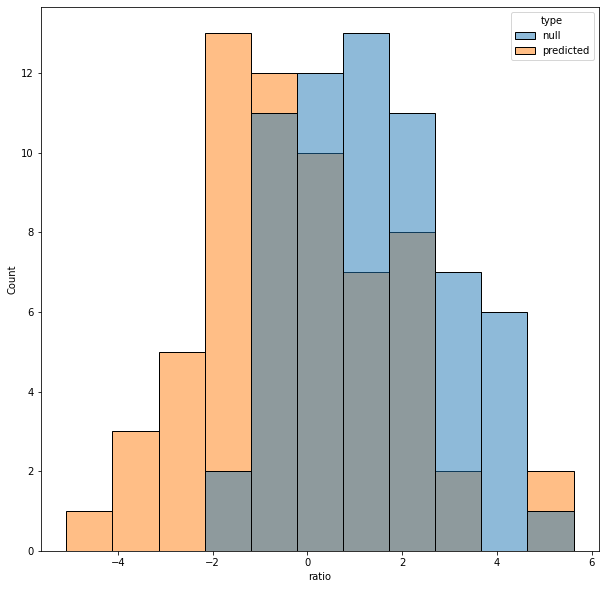

In [2142]:
count_p = 3
pass_ = 1
df_ = pd.DataFrame(data={"growth rate obs" : abundance_next_obs[:, pass_], \
                         "growth rate pred" : abundance_next_species[count_p, :, pass_, num_iter - 1], 
                         "growth rate prev" : abundance_prev_obs[:, pass_]})

x = df_["growth rate obs"].values
y = df_["growth rate pred"].values
# z = df_["growth rate prev"].values

id_ = np.where((~np.isnan(x)) & (y > 0))[0]
print(len(id_))
# id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
x = x[id_]
y = y[id_]
if pass_ > 0:
    z = abundance_prev_obs[id_, pass_]
else:
    z = abundance_prev_obs[id_, :]
    z = z[:, np.arange(0, num_passages)].mean(axis=1)
# print(len(id_))

z = abundance_prev_obs[id_, 0]
x_plt = np.log10(z / x)
y_plt = np.log10(y / x)
ci_null = get_ci_func(x_plt, num_boot=10000, method="bca", func=np.median, conf=0.95)
ci_fit = get_ci_func(y_plt, num_boot=10000, method="bca", func=np.median, conf=0.95)
print(f'null prediction = {10**np.median(x_plt)}, ({10**ci_null[0]}, {10**ci_null[1]})')
print(f'fitted prediction = {10**np.median(y_plt)}, ({10**ci_fit[0]}, {10**ci_fit[1]})')

res = scipy.stats.median_test(x_plt, y_plt)
print(f'pvalue for diff. in median {res[1]}')

df_plt = pd.DataFrame(data={"ratio" : list(x_plt) + list(y_plt), 
                            "type" : ['null'] * len(x_plt) + ['predicted'] * len(y_plt)})

mpl.rcParams['figure.figsize'] = 10, 10
plt_ = sns.histplot(data=df_plt, x="ratio", hue="type")
# plt_ = sns.scatterplot(x=np.log10(x_plt), \
#                        y=np.log10(y_plt))
# plt_ = sns.kdeplot(x=np.log10(x_plt), y=np.log10(y_plt), fill=True, alpha=0.6, cmap="Reds", ax=plt_)

# # plt_ = sns.lineplot(x=(df_['x']), \
# #                     y=(rolling_avg), color='blue', ax=plt_)

# plt_.plot([-8, 2], [-8, 2], c="black")
# plt_.plot([-8, 2], [slope * -8, slope * 2], c="green")
# plt_.set_xlabel("abundance obs.", size=15)
# plt_.set_ylabel("abundance pred.", size=15)
# plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
# plt_.set_yticklabels(plt_.get_yticklabels(), size=15)
# corr_val = scipy.stats.pearsonr(np.log10(x_plt), np.log10(y_plt))

# title_ = f'passage {pass_ + 1} to {pass_ + 2},\n p = {p_vec_new[count_p]}, '\
#         f'pearson cc (log) = {np.round(corr_val[0], 3)}, pval = ' + \
#         '{:.3e}'.format(corr_val[1]) + \
#         f'\n slope = {np.round(slope, 3)}, pvalue = ' + \
#         '{:.3e}'.format(slope_pval)
# plt_.set_title(title_, size=15)

0.012615667221804601

In [2085]:
def pearson_corr_stats(x, y, corr_func=scipy.stats.pearsonr):
    r, p_value = corr_func(x, y)

    # Calculate the degrees of freedom
    df = len(x) - 2

    # Calculate the critical value of t
    alpha = 0.05
    t_critical = scipy.stats.t.ppf(1 - alpha/2, df)

    # Calculate the standard error
    se = 1 / np.sqrt(df)

    # Calculate the confidence interval
    ci_low = r - t_critical * se
    ci_high = r + t_critical * se
    
    return (r, p_value, ci_low, ci_high)

def slope_without_intercept(x, y):
    model = sm.OLS(y, x).fit()

    # Get the slope and standard error
    slope = model.params[0]
    se = model.bse[0]

    # Calculate the degrees of freedom
    df = len(x) - 1

    # Calculate the critical value of t
    alpha = 0.05
    t_critical = abs(scipy.stats.t.ppf(alpha/2, df))

    # Calculate the confidence interval
    ci_low = slope - t_critical * se
    ci_high = slope + t_critical * se
    
    return (slope, ci_low, ci_high)

def get_ci_corr(df_data, num_boot=10000, method="BCa", corr_func=scipy.stats.pearsonr):
    def corr_(df_data, axis):
        return corr_func(df_data[:, 0], df_data[:, 1])[0]
        
    ci = scipy.stats.bootstrap(df_data, corr_, \
                               n_resamples=num_boot, \
                               confidence_level=0.95, \
                               method=method, paired=True).confidence_interval
    return ci.flatten()

def get_ci_func(val_, num_boot=10000, method="bca", func=np.median, conf=0.95):
    bs = StationaryBootstrap(12, np.array(val_))
    ci = bs.conf_int(func, num_boot, method=method, size=conf)
    
    mean_ = np.mean(val_)
    return ci.flatten()

In [1768]:
count_p = 1
pass_ = 1

for count_p, p_tmp in enumerate(p_vec_new):
    for pass_ in range(num_passages):
        df_ = pd.DataFrame(data={"growth rate obs" : abundance_next_obs[:, pass_], \
                                 "growth rate pred" : abundance_next_species[count_p, :, pass_, num_iter - 1]})

        x = df_["growth rate obs"].values
        y = df_["growth rate pred"].values

        id_ = np.where((~np.isnan(x)) & (y > 0))[0]
        # id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
        x = x[id_]
        y = y[id_]
        print(len(id_))

        id_order = np.argsort(x)
        x_order = (x.copy())[id_order]
        y_order = (y.copy())[id_order]
        df_ = pd.DataFrame(data={"x" : np.log10(x_order), "y" : np.log10(y_order)})
        window_size = 10
        rolling_avg = df_['y'].rolling(window_size).mean().values
        id_not_nan = np.where(~np.isnan(rolling_avg))[0]
        id_nan = np.where(np.isnan(rolling_avg))[0]

        mpl.rcParams['figure.figsize'] = 10, 10
        plt_ = sns.scatterplot(x=np.log10(x), \
                               y=np.log10(y))
        plt_ = sns.kdeplot(x=np.log10(x), y=np.log10(y), fill=True, alpha=0.6, cmap="Reds", ax=plt_)

        plt_ = sns.lineplot(x=(df_['x']), \
                            y=(rolling_avg), color='blue', ax=plt_)

        plt_.plot([-8, 2], [-8, 2], c="black")
        plt_.set_xlabel("abundance obs.", size=15)
        plt_.set_ylabel("abundance pred.", size=15)
        plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
        plt_.set_yticklabels(plt_.get_yticklabels(), size=15)
        corr_val = scipy.stats.pearsonr(np.log10(x), np.log10(y))

        title_ = f'passage {pass_ + 1} to {pass_ + 2},\n p = {p_tmp}, '\
                f'pearson cc (log) = {np.round(corr_val[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val[1])
        plt_.set_title(title_, size=15)

        save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                            'predictions', 'leaveOneOut'))
        save_file = os.path.abspath(os.path.join(save_dir, 
                                                 f'predict_abundance_iterative_predicted_vs_observed_'
                                                 f'p{p_tmp}_passage{pass_ + 1}to{pass_ + 2}.png'))
        plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
        plt.close(plt_.figure)
# print(corr_val)

63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1768-84fa4ad606cc>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1768-84fa4ad606cc>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


In [1781]:
count_p = 1
pass_ = 1

for count_p, p_tmp in enumerate(p_vec_new):
    for pass_ in range(num_passages):
        df_ = pd.DataFrame(data={"growth rate obs" : abundance_next_obs[:, pass_], \
                                 "growth rate pred" : abundance_next_species[count_p, :, pass_, num_iter - 1]})

        x = df_["growth rate obs"].values / abundance_prev_obs[:, pass_]
        y = df_["growth rate pred"].values / abundance_prev_obs[:, pass_]

        id_ = np.where((~np.isnan(x)) & (y > 0))[0]
        # id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
        x = x[id_]
        y = y[id_]
        print(len(id_))

        id_order = np.argsort(x)
        x_order = (x.copy())[id_order]
        y_order = (y.copy())[id_order]
        df_ = pd.DataFrame(data={"x" : np.log10(x_order), "y" : np.log10(y_order)})
        window_size = 10
        rolling_avg = df_['y'].rolling(window_size).mean().values
        id_not_nan = np.where(~np.isnan(rolling_avg))[0]
        id_nan = np.where(np.isnan(rolling_avg))[0]

        mpl.rcParams['figure.figsize'] = 10, 10
        plt_ = sns.scatterplot(x=np.log10(x), \
                               y=np.log10(y))
        plt_ = sns.kdeplot(x=np.log10(x), y=np.log10(y), fill=True, alpha=0.6, cmap="Reds", ax=plt_)

        plt_ = sns.lineplot(x=(df_['x']), \
                            y=(rolling_avg), color='blue', ax=plt_)

        plt_.plot([-2, 2], [-2, 2], c="black")
        plt_.set_xlabel("ratio obs.", size=15)
        plt_.set_ylabel("ratio pred.", size=15)
        plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
        plt_.set_yticklabels(plt_.get_yticklabels(), size=15)
        corr_val = scipy.stats.pearsonr(np.log10(x), np.log10(y))

        title_ = f'passage {pass_ + 1} to {pass_ + 2},\n p = {p_tmp}, '\
                f'pearson cc (log) = {np.round(corr_val[0], 3)}, pval = ' + \
                '{:.3e}'.format(corr_val[1])
        plt_.set_title(title_, size=15)

        save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                            'predictions', 'leaveOneOut'))
        save_file = os.path.abspath(os.path.join(save_dir, 
                                                 f'predict_abundance_iterative_predicted_vs_observed_ratio_'
                                                 f'p{p_tmp}_passage{pass_ + 1}to{pass_ + 2}.png'))
        plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
        plt.close(plt_.figure)
# print(corr_val)

63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63


<ipython-input-1781-c61513e12b07>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
<ipython-input-1781-c61513e12b07>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


In [1754]:
df_slope = pd.DataFrame(columns=["p", "passage", "corr_p", "pval_p", "corr_p_l", "corr_p_u", \
                                 "corr_sp", "pval_sp", "corr_sp_l", "corr_sp_u", \
                                 "slope", "slope_l", "slope_u"])
for count_p, p_tmp in enumerate(p_vec_new):
    for pass_ in range(num_passages):
        x = abundance_next_obs[:, pass_]
        y = abundance_next_species[count_p, :, pass_, num_iter - 1]

        id_ = np.where((~np.isnan(x)) & (y > 0))[0]
        # id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
        x = np.log(x[id_])
        y = np.log(y[id_])

        corr_p = pearson_corr_stats(x, y)
        corr_sp = pearson_corr_stats(x, y, corr_func=scipy.stats.spearmanr)
        slope = slope_without_intercept(x, y)
        
        df_tmp = pd.DataFrame(data={"p" : [p_tmp], "passage" : [f'{pass_ + 1} to {pass_ + 2}'], \
                                    "corr_p" : [corr_p[0]], "pval_p" : [corr_p[1]], \
                                    "corr_p_l" : [corr_p[2]], "corr_p_u" : [corr_p[3]], 
                                    "corr_sp" : [corr_sp[0]], "pval_sp" : [corr_sp[1]], \
                                    "corr_sp_l" : [corr_sp[2]], "corr_sp_u" : [corr_sp[3]], 
                                    "slope" : [slope[0]], "slope_l" : [slope[1]], "slope_u" : [slope[2]]})
        
        df_slope = pd.concat([df_slope, df_tmp], axis=0)
id_ = np.where(df_slope['corr_p_u'].values >= 1)[0]
df_slope.iloc[id_, 5] = 1

id_ = np.where(df_slope['corr_p_l'].values <= -1)[0]
df_slope.iloc[id_, 4] = -1

id_ = np.where(df_slope['corr_sp_u'].values >= 1)[0]
df_slope.iloc[id_, 9] = 1

id_ = np.where(df_slope['corr_sp_l'].values <= -1)[0]
df_slope.iloc[id_, 8] = -1

In [1764]:
plt_ = sns.barplot(data=df_slope, x="passage", y="corr_p", errorbar=None, hue="p")
x_coords = [p.get_x() + 0.5*p.get_width() for p in plt_.patches]
y_coords = [p.get_height() for p in plt_.patches]
plt_.errorbar(x=x_coords, y=y_coords, \
              yerr=np.array([df_slope["corr_p"].values - df_slope["corr_p_l"].values, \
                             df_slope["corr_p_u"].values - df_slope["corr_p"].values]), \
              fmt="none", c= "k")
plt_.axhline(0.00, color="black")
plt_.set_xlabel("passage transition", size=15)
plt_.set_ylabel("pearson cc (log scale)\n between observed and predicted abundance", \
                size=15)
plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
plt_.set_yticklabels(plt_.get_yticklabels(), size=15)
# plt_.set_title(, size=15)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'predict_abundance_iterative_predicted_vs_observed_'
                                         f'pearsonCorr_func_p_and_passage.png'))
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(plt_.figure)

<ipython-input-1764-cb4a560352de>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


In [1765]:
plt_ = sns.barplot(data=df_slope, x="passage", y="corr_sp", errorbar=None, hue="p")
x_coords = [p.get_x() + 0.5*p.get_width() for p in plt_.patches]
y_coords = [p.get_height() for p in plt_.patches]
plt_.errorbar(x=x_coords, y=y_coords, \
              yerr=np.array([df_slope["corr_sp"].values - df_slope["corr_sp_l"].values, \
                             df_slope["corr_sp_u"].values - df_slope["corr_sp"].values]), \
              fmt="none", c= "k")
plt_.axhline(0.00, color="black")
plt_.set_xlabel("passage transition", size=15)
plt_.set_ylabel("spearman cc (log scale)\n between observed and predicted abundance", \
                size=15)
plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
plt_.set_yticklabels(plt_.get_yticklabels(), size=15)
# plt_.set_title(, size=15)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'predict_abundance_iterative_predicted_vs_observed_'
                                         f'spearmanCorr_func_p_and_passage.png'))
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(plt_.figure)

<ipython-input-1765-6fc3051aac88>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


In [1767]:
plt_ = sns.barplot(data=df_slope, x="passage", y="slope", errorbar=None, hue="p")
x_coords = [p.get_x() + 0.5*p.get_width() for p in plt_.patches]
y_coords = [p.get_height() for p in plt_.patches]
plt_.errorbar(x=x_coords, y=y_coords, \
              yerr=np.array([df_slope["slope"].values - df_slope["slope_l"].values, \
                             df_slope["slope_u"].values - df_slope["slope"].values]), \
              fmt="none", c= "k")
plt_.axhline(0.00, color="black")
plt_.axhline(1.00, color="black")
plt_.set_xlabel("passage transition", size=15)
plt_.set_ylabel("slope between predicted and observed abundance", \
                size=15)
plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
plt_.set_yticklabels(plt_.get_yticklabels(), size=15)
# plt_.set_title(, size=15)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'predict_abundance_iterative_predicted_vs_observed_'
                                         f'slope_func_p_and_passage.png'))
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(plt_.figure)

<ipython-input-1767-a50fcd4d7e10>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


In [1782]:
df_slope = pd.DataFrame(columns=["p", "passage", "corr_p", "pval_p", "corr_p_l", "corr_p_u", \
                                 "corr_sp", "pval_sp", "corr_sp_l", "corr_sp_u", \
                                 "slope", "slope_l", "slope_u"])
for count_p, p_tmp in enumerate(p_vec_new):
    for pass_ in range(num_passages):
        x = abundance_next_obs[:, pass_] / abundance_prev_obs[:, pass_]
        y = abundance_next_species[count_p, :, pass_, num_iter - 1] / abundance_prev_obs[:, pass_]

        id_ = np.where((~np.isnan(x)) & (y > 0))[0]
        # id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
        x = np.log(x[id_])
        y = np.log(y[id_])

        corr_p = pearson_corr_stats(x, y)
        corr_sp = pearson_corr_stats(x, y, corr_func=scipy.stats.spearmanr)
        slope = slope_without_intercept(x, y)
        
        df_tmp = pd.DataFrame(data={"p" : [p_tmp], "passage" : [f'{pass_ + 1} to {pass_ + 2}'], \
                                    "corr_p" : [corr_p[0]], "pval_p" : [corr_p[1]], \
                                    "corr_p_l" : [corr_p[2]], "corr_p_u" : [corr_p[3]], 
                                    "corr_sp" : [corr_sp[0]], "pval_sp" : [corr_sp[1]], \
                                    "corr_sp_l" : [corr_sp[2]], "corr_sp_u" : [corr_sp[3]], 
                                    "slope" : [slope[0]], "slope_l" : [slope[1]], "slope_u" : [slope[2]]})
        
        df_slope = pd.concat([df_slope, df_tmp], axis=0)
id_ = np.where(df_slope['corr_p_u'].values >= 1)[0]
df_slope.iloc[id_, 5] = 1

id_ = np.where(df_slope['corr_p_l'].values <= -1)[0]
df_slope.iloc[id_, 4] = -1

id_ = np.where(df_slope['corr_sp_u'].values >= 1)[0]
df_slope.iloc[id_, 9] = 1

id_ = np.where(df_slope['corr_sp_l'].values <= -1)[0]
df_slope.iloc[id_, 8] = -1

In [1783]:
plt_ = sns.barplot(data=df_slope, x="passage", y="corr_p", errorbar=None, hue="p")
x_coords = [p.get_x() + 0.5*p.get_width() for p in plt_.patches]
y_coords = [p.get_height() for p in plt_.patches]
plt_.errorbar(x=x_coords, y=y_coords, \
              yerr=np.array([df_slope["corr_p"].values - df_slope["corr_p_l"].values, \
                             df_slope["corr_p_u"].values - df_slope["corr_p"].values]), \
              fmt="none", c= "k")
plt_.axhline(0.00, color="black")
plt_.set_xlabel("passage transition", size=15)
plt_.set_ylabel("pearson cc (log scale)\n between observed and predicted abundance", \
                size=15)
plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
plt_.set_yticklabels(plt_.get_yticklabels(), size=15)
# plt_.set_title(, size=15)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'predict_abundance_iterative_predicted_vs_observed_ratio_'
                                         f'pearsonCorr_func_p_and_passage.png'))
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(plt_.figure)

<ipython-input-1783-1b6c773f13d7>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


In [1784]:
plt_ = sns.barplot(data=df_slope, x="passage", y="corr_sp", errorbar=None, hue="p")
x_coords = [p.get_x() + 0.5*p.get_width() for p in plt_.patches]
y_coords = [p.get_height() for p in plt_.patches]
plt_.errorbar(x=x_coords, y=y_coords, \
              yerr=np.array([df_slope["corr_sp"].values - df_slope["corr_sp_l"].values, \
                             df_slope["corr_sp_u"].values - df_slope["corr_sp"].values]), \
              fmt="none", c= "k")
plt_.axhline(0.00, color="black")
plt_.set_xlabel("passage transition", size=15)
plt_.set_ylabel("spearman cc (log scale)\n between observed and predicted abundance", \
                size=15)
plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
plt_.set_yticklabels(plt_.get_yticklabels(), size=15)
# plt_.set_title(, size=15)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'predict_abundance_iterative_predicted_vs_observed_ratio_'
                                         f'spearmanCorr_func_p_and_passage.png'))
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(plt_.figure)

<ipython-input-1784-34f03a533b23>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


In [1785]:
plt_ = sns.barplot(data=df_slope, x="passage", y="slope", errorbar=None, hue="p")
x_coords = [p.get_x() + 0.5*p.get_width() for p in plt_.patches]
y_coords = [p.get_height() for p in plt_.patches]
plt_.errorbar(x=x_coords, y=y_coords, \
              yerr=np.array([df_slope["slope"].values - df_slope["slope_l"].values, \
                             df_slope["slope_u"].values - df_slope["slope"].values]), \
              fmt="none", c= "k")
plt_.axhline(0.00, color="black")
plt_.axhline(1.00, color="black")
plt_.set_xlabel("passage transition", size=15)
plt_.set_ylabel("slope between predicted and observed abundance", \
                size=15)
plt_.set_xticklabels(plt_.get_xticklabels(), size=15)
plt_.set_yticklabels(plt_.get_yticklabels(), size=15)
# plt_.set_title(, size=15)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                    'predictions', 'leaveOneOut'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'predict_abundance_iterative_predicted_vs_observed_ratio_'
                                         f'slope_func_p_and_passage.png'))
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt.close(plt_.figure)

<ipython-input-1785-4cb9f4503776>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt_.set_yticklabels(plt_.get_yticklabels(), size=15)


63
PearsonRResult(statistic=0.2604052381024176, pvalue=0.039281897549746175)


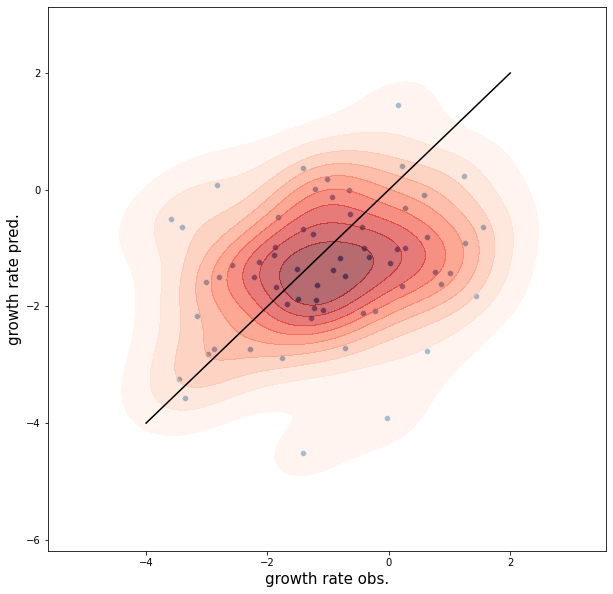

In [1448]:
count_p = 4
df_ = pd.DataFrame(data={"growth rate obs" : growth_rate_obs, \
                         "growth rate pred" : growth_rate_species[count_p, :, num_iter - 1]})

x = growth_rate_obs.copy()
y = growth_rate_species[count_p, :, num_iter - 1].copy()

id_ = np.where((~np.isnan(x)) & (y >= 1e-5))[0]
# id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
x = x[id_]
y = y[id_]
print(len(id_))

plt_ = sns.scatterplot(x=np.log10(x), \
                       y=np.log10(y))
plt_ = sns.kdeplot(x=np.log10(x), y=np.log10(y), fill=True, alpha=0.6, cmap="Reds", ax=plt_)

plt_.plot([-4, 2], [-4, 2], c="black")
plt_.set_xlabel("growth rate obs.", size=15)
plt_.set_ylabel("growth rate pred.", size=15)
# plt_.set_xscale("log", base=10)
# plt_.set_yscale("log", base=10)
corr_val = scipy.stats.pearsonr(np.log10(x), np.log10(y))
print(corr_val)


corr_vec = np.zeros((len(p_vec_new)))
corr_pval_vec = corr_vec.copy()
for count_p in range(len(p_vec_new)):
    x = growth_rate_obs.copy()
    y = growth_rate_species[count_p, :, num_iter - 1].copy()
#     y[y <= 1e-5] = 1e-5
# #     id_ = np.where(x > 0)[0]
#     id_ = np.where((x > 0) & (y > 0))[0]
#     y = y[id_]
#     x = x[id_]
#     y = y**(1/p_vec[count_p])
#     x = x**(1/p_vec[count_p])
#     id_ = np.where((x > 0) &  &(y < 1e3))[0]
#     id_ = np.where((~np.isnan(x)) & (x >= 0))[0]
    id_ = np.where((~np.isnan(x)) & (y >= 1e-5))[0]
    y = y[id_]
    x = x[id_]

    corr_val = scipy.stats.pearsonr(np.log10(x), np.log10(y))
    corr_vec[count_p] = corr_val[0]
    corr_pval_vec[count_p] = corr_val[1]

In [984]:
count_p = 0
df_ = pd.DataFrame(data={"growth rate obs" : growth_rate_obs, \
                         "growth rate pred" : growth_rate_species[count_p, :, num_iter - 1]})

x = growth_rate_obs.copy()
y = growth_rate_species[count_p, :, num_iter - 1].copy()

id_ = np.where((~np.isnan(x)) & (y >= 200))[0]
print(len(id_))
id_
y[id_]

32


array([10000.        , 10000.        , 10000.        , 10000.        ,
        9076.96318522, 10000.        , 10000.        , 10000.        ,
       10000.        , 10000.        , 10000.        , 10000.        ,
       10000.        , 10000.        , 10000.        , 10000.        ,
        6238.06499884, 10000.        , 10000.        , 10000.        ,
        1320.77711028,  3712.50938467, 10000.        ,  3882.99531821,
       10000.        , 10000.        , 10000.        ,   543.02499026,
        2702.1523166 , 10000.        ,  5518.6430224 , 10000.        ])

In [1446]:
df_corr = pd.DataFrame(data={"corr" : corr_vec, "p_val" : corr_pval_vec, "p" : p_vec_new})
print(df_corr)

       corr     p_val      p
0  0.133995  0.329405  0.050
1  0.161541  0.213588  0.100
2  0.239573  0.060735  0.125
3  0.243850  0.054114  0.150
4  0.260405  0.039282  0.200
5  0.249842  0.050183  0.225


In [1436]:
df_corr = pd.DataFrame(data={"corr" : corr_vec, "p_val" : corr_pval_vec, "p" : p_vec_new})
print(df_corr)

       corr     p_val      p
0  0.037038  0.786386  0.050
1  0.117399  0.367553  0.100
2  0.169525  0.191514  0.125
3  0.228053  0.072234  0.150
4  0.247744  0.050269  0.200
5  0.243177  0.056844  0.225


In [ ]:
growth_ratio = np.mean(np.log(df_speciesAbun_ratio_new.iloc[id_, :].values).mean(axis=0))
growth_ratio = np.exp(growth_ratio)

In [766]:
df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()

id_ = []
for i in range(df_speciesAbun_ratio_new.shape[0]):
    id_z = np.where(df_speciesAbun_ratio_new.iloc[i, :].values == -1)[0]
    if len(id_z) == 0:
        id_.append(i)

df_speciesAbun_ratio_new.iloc[test_strain_id, :] = growth_ratio
df_speciesAbun_next_tmp.iloc[test_strain_id, :] = \
    growth_ratio * df_speciesAbun_prev_tmp.iloc[test_strain_id, :].values
_, mat_cons_abun_split_list_tmp = \
iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                     df_speciesAbun_next_tmp.copy(), p_=p_tmp)
for sample_ in sample_names_split:
    pass_ = int(sample_.split("_")[0][1])
    _, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                             df_speciesAbun_next_tmp.copy(), p_=p_tmp)
    if pass_ > -1:
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][train_strain_id, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[train_strain_id, sample_id])
        tmp1 = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
        id_keep = np.where(tmp1 != -1)[0]
        tmp = np.array(tmp**(-p_tmp)).reshape((len(train_strain_id), 1))
        tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
        A_train_sample = np.multiply(A_train_sample, tmp)
        A_train_sample = A_train_sample[id_keep, :]

#         pass_all += [pass_] * len(id_keep)
#         brep_all += [brep_] * len(id_keep)
#         train_id_all += list(np.array(train_strain_id)[id_keep])
        if count_ == 0:
            A_train = A_train_sample
            count_ += 1
        else:
            A_train = np.vstack((A_train, A_train_sample))       
b_train = np.ones((A_train.shape[0]))
coeff_train_ = nnls(A_train, b_train)[0]

<ipython-input-766-defd5a6797b3>:29: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_tmp)).reshape((len(train_strain_id), 1))


In [767]:
def objective_(g, *args):
    train_strain_id = args[0].copy()
    test_strain_id = args[1].copy()
    df_speciesAbun_prev = args[2].copy()
    df_speciesAbun_next = args[3].copy()
    df_speciesMetab = args[4].copy()
    df_speciesAbun_ratio = args[5].copy()
    Ri = args[6].copy()
    p_tmp = args[7]
    df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
    df_speciesAbun_ratio_new.iloc[test_strain_id, :] = g
    df_speciesAbun_next.iloc[test_strain_id, :] = g * df_speciesAbun_prev.iloc[test_strain_id, :].values
    sample_names_split, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                             df_speciesAbun_next.copy(), p_=p_tmp)
    count_ = 0
    for sample_ in sample_names_split:
        pass_ = int(sample_.split("_")[0][1])
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][:, :]
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio_new.iloc[:, sample_id])
        tmp1 = np.array(df_speciesAbun_ratio.iloc[:, sample_id])
        id_keep = np.where(tmp1 != -1)[0]
        tmp = np.array(tmp**(-p_tmp)).reshape((df_speciesAbun_ratio.shape[0], 1))
        tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
        A_train_sample = np.multiply(A_train_sample, tmp)
        A_train_sample = A_train_sample[id_keep, :]

#         pass_all += [pass_] * len(id_keep)
#         brep_all += [brep_] * len(id_keep)
        if count_ == 0:
            A_train = A_train_sample
            count_ += 1
        else:
            A_train = np.vstack((A_train, A_train_sample))       
    b_train = np.ones((A_train.shape[0]))
    error_ = b_train - np.matmul(A_train, Ri)
    error_ = np.sum(error_**2)
    return error_

In [768]:
pass_ = 0
# df_speciesAbun_prev_tmp_ = df_speciesAbun_prev_tmp.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
# df_speciesAbun_next_tmp_ = df_speciesAbun_next_tmp.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
# df_speciesAbun_ratio_new_ = df_speciesAbun_ratio_new.copy().iloc[:, [pass_, pass_ + 5, pass_ + 10]]
df_speciesAbun_prev_tmp_ = df_speciesAbun_prev_tmp.copy()
df_speciesAbun_next_tmp_ = df_speciesAbun_next_tmp.copy()
df_speciesAbun_ratio_new_ = df_speciesAbun_ratio_new.copy()
Ri = coeff_train_.copy()


In [769]:
df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_new.copy().iloc[train_strain_id, :]
id_ = []
for i in range(df_speciesAbun_ratio_tmp.shape[0]):
    id_z = np.where(df_speciesAbun_ratio_tmp.iloc[i, :].values == -1)[0]
    if len(id_z) == 0:
        id_.append(i)
initial_guess = np.mean(np.log(df_speciesAbun_ratio_tmp.iloc[id_, :].values).mean(axis=0))
initial_guess = np.exp(initial_guess)
initial_guess = growth_ratio
args = (train_strain_id, test_strain_id, df_speciesAbun_prev_tmp_, df_speciesAbun_next_tmp_, \
        df_speciesMetab, df_speciesAbun_ratio_new_, Ri, p_tmp)
g_sol = minimize(objective_, initial_guess, args=args, bounds=[(1e-5, None)])

<ipython-input-767-1be7152f20c8>:25: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_tmp)).reshape((df_speciesAbun_ratio.shape[0], 1))


In [770]:
growth_ratio = g_sol.x

In [771]:
g_sol
# growth_ratio = 0.37

      fun: 233.65784367616274
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00810871])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([0.00015875])

In [759]:
df_speciesAbun_ratio.iloc[test_strain_id, [pass_, pass_ + 5, pass_ + 10]].mean(axis=1)

57    0.000572
dtype: float64

In [617]:
train_strain_id = args[0].copy()
test_strain_id = args[1].copy()
df_speciesAbun_prev = args[2].copy()
df_speciesAbun_next = args[3].copy()
df_speciesMetab = args[4].copy()
df_speciesAbun_ratio = args[5].copy()
Ri = args[6].copy()
p_tmp = args[7]
df_speciesAbun_ratio_new = df_speciesAbun_ratio.copy()
df_speciesAbun_ratio_new.iloc[test_strain_id, :] = growth_ratio
df_speciesAbun_next.iloc[test_strain_id, :] = \
    growth_ratio * df_speciesAbun_prev.iloc[test_strain_id, :].values
sample_names_split, mat_cons_abun_split_list_tmp = \
    iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev.copy(), \
                         df_speciesAbun_next.copy(), p_=p_tmp)


In [620]:
for sample_ in sample_names_split:
    pass_ = int(sample_.split("_")[0][1])
    brep_ = int(sample_.split("_")[1][1])
    A_train_sample = mat_cons_abun_split_list_tmp[sample_][:, :]
    sample_id = sample_names_split.index(sample_)
    tmp = np.array(df_speciesAbun_ratio_new.iloc[:, sample_id])
    tmp1 = np.array(df_speciesAbun_ratio.iloc[:, sample_id])
    id_keep = np.where(tmp1 != -1)[0]
    tmp = np.array(tmp**(-p_tmp)).reshape((df_speciesAbun_ratio.shape[0], 1))
    tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
    A_train_sample = np.multiply(A_train_sample, tmp)
    A_train_sample = A_train_sample[id_keep, :]
    if count_ == 0:
        A_train = A_train_sample
        count_ += 1
    else:
        A_train = np.vstack((A_train, A_train_sample))

ValueError: operands could not be broadcast together with shapes (63,292) (62,292) 

In [650]:
df_speciesAbun_prev_tmp.shape

(63, 3)

In [582]:
# train nnls model when R_i is estimated for all the metabolites using the true order of species 
# abundances with leave 10 species out for different values of p_ (for B_split)
seed_ = 7363
np.random.seed(seed_)
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
num_bioRep = 3
num_rep_nnls = 1
num_iter = 10
p_vec = 10**np.linspace(-2, np.log10(0.2), 6)
p_vec = np.round(p_vec, 2)
p_lower = 10**np.array([-8, -6, -4]).astype(np.float64)
p_upper = 10**np.array([np.log10(0.4), np.log10(0.6)])
p_vec = np.concatenate((p_lower, p_vec, p_upper))
p_vec = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55])
p_min = 1e-8
pass_thresh = 2

# nfold = 15
# num_perFold = np.floor(len(species_names) / nfold)
nfold = len(species_names)
num_perFold = np.floor((len(species_names) + 1) / nfold)

coeff_train = {}
coeff_null_train = {}
coeff_null_train_2 = {}
output_test = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
output_train = output_test.copy()
output_observed = output_test.copy()
output_null_train = output_test.copy()
output_null_train_2 = output_null_train.copy()
test_strain_id_all = {}
output_null_test = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
output_null_test_2 = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
train_id_all_dict = {}

for rep_ in range(num_rep_nnls):
    print(f'repeat loop # = {rep_}')
    coeff_train[rep_] = {}
    coeff_null_train[rep_] = {}
    coeff_null_train_2[rep_] = {}
#     output_test[rep_] = {}
    train_id_all_dict[rep_] = {}
    
    passages_ = np.random.permutation(passages_)
    folds_id = np.arange(len(species_names))
    folds_id = np.random.permutation(folds_id)
    species_perFold = {}
    count_ = 0
    for fold_ in range(nfold):
        species_perFold[fold_] = {}
        if fold_ != nfold - 1:
            species_perFold[fold_]["test"] = \
                list(folds_id[np.arange(count_, count_ + num_perFold).astype('int')])

        else:
            species_perFold[fold_]["test"] = \
                list(folds_id[count_.astype("int"):])
        species_perFold[fold_]["train"] = \
            list(set(range(len(species_names))).difference(species_perFold[fold_]["test"]))
        count_ += num_perFold
    
    test_strain_id_all[rep_] = {}
    for fold_ in range(nfold):
        print(f'fold # = {fold_}')
        coeff_train[rep_][fold_] = {}
        coeff_null_train[rep_][fold_] = {}
        coeff_null_train_2[rep_][fold_] = {}
        train_strain_id = []
        for species_ in species_perFold[fold_]["train"]:
            train_strain_id += species_names_to_strainID[species_names[species_]]
        train_id_all_dict[rep_][fold_] = train_strain_id
        test_strain_id = []
        for species_ in species_perFold[fold_]["test"]:
            test_strain_id += species_names_to_strainID[species_names[species_]]
        test_strain_id_all[rep_][fold_] = test_strain_id
        
        count_p = -1
        for p_ in p_vec:
            print(f'fold # = {fold_}, p_ = {p_}')
            count_p += 1
            
            df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
            df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
            
#             df_speciesAbun_prev_tmp.iloc[test_strain_id, :] = \
#                 df_speciesAbun_inoc.iloc[test_strain_id, 0].values * np.ones(df_speciesAbun_prev.shape[1])
#             df_speciesAbun_next_tmp.iloc[test_strain_id, :] = \
#                 df_speciesAbun_inoc.iloc[test_strain_id, 0].values * np.ones(df_speciesAbun_prev.shape[1])
#             for col_ in range(df_speciesAbun_next.shape[1]):
#                 df_speciesAbun_next_tmp.iloc[test_strain_id, col_] = \
#                 df_speciesAbun_prev_tmp.iloc[test_strain_id, col_]
            
            df_speciesAbun_split = geometric_avg(df_speciesAbun_prev_tmp, df_speciesAbun_next_tmp, p=p_)
            df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                                       df_speciesAbun=df_speciesAbun_split)
#             df_cons_abun_prod_avg_split = df_cons_abun_prod_split.mean(axis=0)
#             sample_names_split, mat_cons_abun_split_list = \
#                 compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_split, 
#                                                       df_speciesMetab=df_speciesMetab, 
#                                                       num_passages=6, num_bioRep=3, 
#                                                       sample_names=list(df_speciesAbun_split.columns.values))
#             coeff_null_train[rep_][fold_][count_p] = \
#                 null_Ri_2(df_speciesMetab.iloc[train_strain_id, :], \
#                         df_speciesAbun_ratio.iloc[train_strain_id, :], \
#                         df_cons_abun_prod_split, p_=p_)
#             coeff_null_train[rep_][fold_][count_p] = \
#                 null_Ri_2(df_speciesMetab, \
#                         df_speciesAbun_ratio, \
#                         df_cons_abun_prod_split, p_=p_)
            coeff_null_train[rep_][fold_][count_p] = \
                null_Ri_2_p(df_speciesMetab, \
                        df_speciesAbun_ratio, \
                        df_cons_abun_prod_split, p_=p_min)
            coeff_null_train_2[rep_][fold_][count_p] = \
                null_Ri_2_p(df_speciesMetab.iloc[train_strain_id, :], \
                               df_speciesAbun_ratio.iloc[train_strain_id, :], \
                               df_cons_abun_prod_split, p_=p_min)
            passages_train = passages_
            count_ = 0
            pass_all = []
            brep_all = []
            train_id_all = []
            output_all = []
            for sample_ in sample_names_split:
                pass_ = int(sample_.split("_")[0][1])
                if pass_ <= pass_thresh:
                    p_tmp = p_
                else:
                    p_tmp = p_min
                _, mat_cons_abun_split_list_tmp = \
                    iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                         df_speciesAbun_next_tmp.copy(), p_=p_tmp)
                if pass_ <= 6:
                    brep_ = int(sample_.split("_")[1][1])
                    A_train_sample = mat_cons_abun_split_list_tmp[sample_][train_strain_id, :]
                    sample_id = sample_names_split.index(sample_)
                    tmp = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
                    id_keep = np.where(tmp != -1)[0]
                    tmp = np.array(tmp**(-p_tmp)).reshape((len(train_strain_id), 1))
                    tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
                    A_train_sample = np.multiply(A_train_sample, tmp)
                    A_train_sample = A_train_sample[id_keep, :]

                    pass_all += [pass_] * len(id_keep)
                    brep_all += [brep_] * len(id_keep)
                    train_id_all += list(np.array(train_strain_id)[id_keep])
                    if count_ == 0:
                        A_train = A_train_sample
                        count_ += 1
                    else:
                        A_train = np.vstack((A_train, A_train_sample))       
            b_train = np.ones((A_train.shape[0]))
            coeff_train[rep_][fold_][count_p] = nnls(A_train, b_train) 
            
            for sample_ in sample_names_split:
                pass_ = int(sample_.split("_")[0][1])
                if pass_ <= pass_thresh:
                    p_tmp = p_
                else:
                    p_tmp = p_min
                _, mat_cons_abun_split_list_tmp = \
                    iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                         df_speciesAbun_next_tmp.copy(), p_=p_tmp)
                if pass_ <= 6:
                    brep_ = int(sample_.split("_")[1][1])
                    A_train_sample = mat_cons_abun_split_list_tmp[sample_][train_strain_id, :]
                    sample_id = sample_names_split.index(sample_)
                    tmp = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
                    id_keep = np.where(tmp != -1)[0]
                    tmp = np.array(tmp**(-p_tmp)).reshape((len(train_strain_id), 1))
                    tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
    #                 A_train_sample = np.multiply(A_train_sample, tmp)
                    A_train_sample = A_train_sample[id_keep, :]

                    output_train[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                        np.matmul(A_train_sample, coeff_train[rep_][fold_][count_p][0])
                    output_null_train[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                        np.matmul(A_train_sample, coeff_null_train[rep_][fold_][count_p])
                    output_null_train_2[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                        np.matmul(A_train_sample, coeff_null_train_2[rep_][fold_][count_p])
                
                

                #     test data
            passages_test = passages_train
            count_ = 0
            test_id_tmp = []
            for sample_ in sample_names_split:
#                 print(f'sample_ = {sample_}')
                sample_id = sample_names_split.index(sample_)
                pass_ = int(sample_.split("_")[0][1])
                if pass_ <= pass_thresh:
                    p_tmp = p_
                else:
                    p_tmp = p_min
                    
                df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
                df_speciesAbun_next_tmp = df_speciesAbun_next.copy()

#                 for col_ in range(df_speciesAbun_next.shape[1]):
#                     df_speciesAbun_next_tmp.iloc[test_strain_id, col_] = \
#                         df_speciesAbun_prev_tmp.iloc[test_strain_id, col_]
                _, mat_cons_abun_split_list_tmp = \
                    iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                                         df_speciesAbun_next_tmp.copy(), p_=p_tmp)
                if pass_ <= 6:
                    brep_ = int(sample_.split("_")[1][1])


#                     df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
#                     df_speciesAbun_next_tmp = df_speciesAbun_next.copy()

#                     df_speciesAbun_next_tmp.iloc[test_strain_id, :] = \
#                         df_speciesAbun_prev_tmp.iloc[test_strain_id, :].values

#                     _, mat_cons_abun_split_list_tmp = \
#                         iterate_growth_ratio(df_speciesMetab, df_speciesAbun_prev_tmp, df_speciesAbun_next_tmp, \
#                                              p_)

                    A_test_sample = mat_cons_abun_split_list_tmp[sample_][test_strain_id, :]
                    tmp = np.array(df_speciesAbun_ratio.iloc[test_strain_id, sample_id])
                    id_keep = np.where(tmp != -1)[0]
    #                 tmp = np.array(tmp**(-p_)).reshape((len(test_strain_id), 1))
    #                 tmp = np.matmul(tmp, np.ones((1, A_test_sample.shape[1])))
    #                 A_test_sample = np.multiply(A_test_sample, tmp)

                    if len(id_keep) >= 1:
                        A_test_sample = A_test_sample[id_keep, :]
                        output_tmp = \
                            np.matmul(A_test_sample, coeff_null_train_2[rep_][fold_][count_p])
                        B_ratio = np.array(df_speciesAbun_ratio.iloc[np.array(test_strain_id)[id_keep], sample_id])
                        B_ratio = B_ratio**(-p_tmp)
                        output_null_test_2[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                            output_tmp

                        output_null_test[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                            np.matmul(A_test_sample, coeff_null_train[rep_][fold_][count_p])

                        output_observed[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                            (tmp**p_tmp)[id_keep]

                        output_test_tmp = np.matmul(A_test_sample, coeff_train[rep_][fold_][count_p][0])
                        if pass_ <= pass_thresh:
                            for iter_ in range(num_iter):
                                df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
                                df_speciesAbun_next_tmp = df_speciesAbun_next.copy()

                                df_speciesAbun_next_tmp.iloc[test_strain_id, :] = \
                                    df_speciesAbun_prev_tmp.iloc[test_strain_id, :] * \
                                    output_test_tmp[0]**(1/p_tmp) + thresh_zero*0.1
    #                             for col_ in range(df_speciesAbun_next_tmp.shape[1]):
    #                                 df_speciesAbun_next_tmp.iloc[test_strain_id, col_] = \
    #                                     df_speciesAbun_prev_tmp.iloc[test_strain_id, col_] * output_test_tmp[0]

                                _, mat_cons_abun_split_list_tmp = \
                                    iterate_growth_ratio(df_speciesMetab, df_speciesAbun_prev_tmp, \
                                                         df_speciesAbun_next_tmp, p_tmp)
                                A_test_sample = mat_cons_abun_split_list_tmp[sample_][test_strain_id, :]
                                A_test_sample = A_test_sample[id_keep, :]
                                output_test_tmp = \
                                    np.matmul(A_test_sample, coeff_train[rep_][fold_][count_p][0])

                        output_test[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                            output_test_tmp
                    else:
                        continue
            
#             test_id_tmp += list(np.array(test_strain_id)[id_keep])
#             if count_ == 0:
#                 A_test = A_test_sample
#                 count_ += 1
#             else:
#                 A_test = np.vstack((A_test, A_test_sample)) 
#         output_test[]
#         output_test[rep_][fold_] = np.dot(A_test, coeff_train[rep_][fold_][0])
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit", "lower_p"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_leaveOneOut_outputRatioIterate'
                                         f'_pass_dependent_p.pickle'))

save_obj = {"coeff" : coeff_train, "coeff_null" : coeff_null_train, \
            "coeff_null2" : coeff_null_train_2, "output_train" : output_train, \
            "output_null_train" : output_null_train, "output_null2_train" : output_null_train_2, \
            "output_test" : output_test, \
            "output_null_test" : output_null_test, "output_null2_test" : output_null_test_2, \
            "output_observed" : output_observed}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)    

repeat loop # = 0
fold # = 0
fold # = 0, p_ = 0.1


<ipython-input-582-38f72965b60e>:139: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_tmp)).reshape((len(train_strain_id), 1))
<ipython-input-582-38f72965b60e>:170: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_tmp)).reshape((len(train_strain_id), 1))


fold # = 0, p_ = 0.15
fold # = 0, p_ = 0.2
fold # = 0, p_ = 0.25
fold # = 0, p_ = 0.3
fold # = 0, p_ = 0.35
fold # = 0, p_ = 0.4
fold # = 0, p_ = 0.45
fold # = 0, p_ = 0.5
fold # = 0, p_ = 0.55
fold # = 1
fold # = 1, p_ = 0.1
fold # = 1, p_ = 0.15
fold # = 1, p_ = 0.2
fold # = 1, p_ = 0.25
fold # = 1, p_ = 0.3
fold # = 1, p_ = 0.35
fold # = 1, p_ = 0.4
fold # = 1, p_ = 0.45
fold # = 1, p_ = 0.5
fold # = 1, p_ = 0.55
fold # = 2
fold # = 2, p_ = 0.1
fold # = 2, p_ = 0.15
fold # = 2, p_ = 0.2
fold # = 2, p_ = 0.25
fold # = 2, p_ = 0.3
fold # = 2, p_ = 0.35
fold # = 2, p_ = 0.4
fold # = 2, p_ = 0.45
fold # = 2, p_ = 0.5
fold # = 2, p_ = 0.55
fold # = 3
fold # = 3, p_ = 0.1
fold # = 3, p_ = 0.15
fold # = 3, p_ = 0.2
fold # = 3, p_ = 0.25
fold # = 3, p_ = 0.3
fold # = 3, p_ = 0.35
fold # = 3, p_ = 0.4
fold # = 3, p_ = 0.45
fold # = 3, p_ = 0.5
fold # = 3, p_ = 0.55
fold # = 4
fold # = 4, p_ = 0.1
fold # = 4, p_ = 0.15
fold # = 4, p_ = 0.2
fold # = 4, p_ = 0.25
fold # = 4, p_ = 0.3
fold # = 4

fold # = 35, p_ = 0.2
fold # = 35, p_ = 0.25
fold # = 35, p_ = 0.3
fold # = 35, p_ = 0.35
fold # = 35, p_ = 0.4
fold # = 35, p_ = 0.45
fold # = 35, p_ = 0.5
fold # = 35, p_ = 0.55
fold # = 36
fold # = 36, p_ = 0.1
fold # = 36, p_ = 0.15
fold # = 36, p_ = 0.2
fold # = 36, p_ = 0.25
fold # = 36, p_ = 0.3
fold # = 36, p_ = 0.35
fold # = 36, p_ = 0.4
fold # = 36, p_ = 0.45
fold # = 36, p_ = 0.5
fold # = 36, p_ = 0.55
fold # = 37
fold # = 37, p_ = 0.1
fold # = 37, p_ = 0.15
fold # = 37, p_ = 0.2
fold # = 37, p_ = 0.25
fold # = 37, p_ = 0.3
fold # = 37, p_ = 0.35
fold # = 37, p_ = 0.4
fold # = 37, p_ = 0.45
fold # = 37, p_ = 0.5
fold # = 37, p_ = 0.55
fold # = 38
fold # = 38, p_ = 0.1
fold # = 38, p_ = 0.15
fold # = 38, p_ = 0.2
fold # = 38, p_ = 0.25
fold # = 38, p_ = 0.3
fold # = 38, p_ = 0.35
fold # = 38, p_ = 0.4
fold # = 38, p_ = 0.45
fold # = 38, p_ = 0.5
fold # = 38, p_ = 0.55
fold # = 39
fold # = 39, p_ = 0.1
fold # = 39, p_ = 0.15
fold # = 39, p_ = 0.2
fold # = 39, p_ = 0.25
fold # 

In [565]:
df_speciesAbun_ratio_tmp = df_speciesAbun_ratio_corr.copy()
df_speciesAbun_ratio_tmp[df_speciesAbun_ratio_tmp > -10] = 1

In [566]:
df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
df_speciesAbun_next_tmp = df_speciesAbun_ratio_tmp.copy() * df_speciesAbun_prev_tmp.copy()

In [568]:
df_speciesAbun_prev

p2_r0         p3_r0         p4_r0         p5_r0         p6_r0  \
0   3.180398e-02  1.232587e-04  6.704587e-06  1.964384e-05  2.923860e-04   
1   2.174619e-01  2.143392e-01  3.034948e-01  2.783072e-01  2.449287e-01   
2   3.053745e-02  7.893345e-02  4.178763e-02  1.553076e-02  2.513826e-02   
3   7.641646e-05  1.000000e-08  1.000000e-08  1.000000e-08  1.000000e-08   
4   7.633257e-02  2.583468e-05  3.153010e-06  3.753517e-06  2.028774e-06   
..           ...           ...           ...           ...           ...   
58  2.173690e-03  2.872359e-02  6.526354e-03  3.918121e-03  4.421267e-03   
59  2.727114e-04  9.021892e-05  2.965475e-06  4.094933e-06  1.882528e-05   
60  1.776472e-03  2.920661e-03  1.421295e-03  2.227100e-03  1.239252e-03   
61  3.879986e-07  1.000000e-08  8.662693e-08  1.000000e-08  1.000000e-08   
62  1.178492e-04  1.129604e-07  1.000000e-08  1.000000e-08  1.000000e-08   

           p2_r1         p3_r1         p4_r1         p5_r1         p6_r1  \
0   3.751642e-02  1.509550e-04  2.801973e-04  3.247537e-03  2.649064e-02   
1   2.173035e-01  1.983694e-01  2.674704e-01  3.043407e-01  2.476548e-01   
2   3.393580e-02  9.603154e-03  3.142386e-02  1.700029e-02  2.282783e-02   
3   9.158013e-05  1.277543e-06  2.257240e-07  1.000000e-08  8.028099e-08   
4   7.271956e-02  4.145522e-05  4.789548e-06  6.430825e-06  1.331149e-06   
..           ...           ...           ...           ...           ...   
58  2.753382e-03  1.592495e-02  6.138713e-03  5.560732e-03  6.711834e-03   
59  2.477832e-04  3.475236e-05  5.534024e-05  1.792223e-05  6.581487e-05   
60  1.821668e-03  2.737841e-03  1.899006e-03  7.986064e-04  3.016710e-04   
61  6.177283e-07  1.000000e-08  1.000000e-08  1.459906e-07  1.000000e-08   
62  1.197888e-04  4.244615e-07  1.000000e-08  1.000000e-08  7.916584e-08   

           p2_r2         p3_r2         p4_r2         p5_r2         p6_r2  
0   4.710307e-02  6.802839e-04  2.546092e-04  1.037398e-04  1.317724e-04  
1   1.584982e-01  2.045056e-01  2.981957e-01  3.043595e-01  3.054243e-01  
2   3.420288e-02  4.933659e-03  1.727806e-02  7.776625e-03  6.220632e-02  
3   7.865395e-05  7.965272e-07  1.000000e-08  1.000000e-08  1.000000e-08  
4   6.615639e-02  1.118852e-04  1.638908e-04  2.938171e-06  5.076057e-06  
..           ...           ...           ...           ...           ...  
58  3.988645e-03  9.989043e-03  3.268566e-03  2.781552e-03  6.712029e-03  
59  2.444333e-04  3.758673e-05  4.198384e-05  3.080377e-05  1.010013e-05  
60  2.231052e-03  2.531160e-03  3.458196e-03  4.025108e-03  1.840863e-03  
61  8.277804e-07  1.000000e-08  1.000000e-08  1.000000e-08  1.000000e-08  
62  2.247130e-04  1.446117e-07  1.000000e-08  1.000000e-08  1.000000e-08  

[63 rows x 15 columns]

In [561]:
df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
df_speciesAbun_next_tmp = df_speciesAbun_ratio_tmp.copy() * df_speciesAbun_prev_tmp.copy()
pass_thresh = 2
count_p = 2
p_ = p_vec[count_p]
p_min = 1e-8
for sample_ in sample_names_split:
    pass_ = int(sample_.split("_")[0][1])
    if pass_ <= pass_thresh:
        p_tmp = p_
    else:
        p_tmp = p_min
    _, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab.copy(), df_speciesAbun_prev_tmp.copy(), \
                             df_speciesAbun_next_tmp.copy(), p_=p_tmp)
    if pass_ > 0 :
        brep_ = int(sample_.split("_")[1][1])
        A_train_sample = mat_cons_abun_split_list_tmp[sample_][train_strain_id, :]
        sample_id = sample_names_split.index(sample_)
#         tmp = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
        tmp = np.array(df_speciesAbun_ratio_corr.iloc[train_strain_id, sample_id])
        id_keep = np.where(tmp != -1)[0]
        tmp = np.array(tmp**(-p_tmp)).reshape((len(train_strain_id), 1))
        tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
        A_train_sample = np.multiply(A_train_sample, tmp)
        A_train_sample = A_train_sample[id_keep, :]

        pass_all += [pass_] * len(id_keep)
        brep_all += [brep_] * len(id_keep)
        train_id_all += list(np.array(train_strain_id)[id_keep])
        if count_ == 0:
            A_train = A_train_sample
            count_ += 1
        else:
            A_train = np.vstack((A_train, A_train_sample))       
b_train = np.ones((A_train.shape[0]))
coeff_train_ = nnls(A_train, b_train)

<ipython-input-561-e340cffb3190>:23: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_tmp)).reshape((len(train_strain_id), 1))


ValueError: array must not contain infs or NaNs

In [564]:
tmp = np.array(df_speciesAbun_ratio_corr.iloc[train_strain_id, sample_id])
# tmp = np.array(tmp**(-p_tmp)).reshape((len(train_strain_id), 1))
tmp

array([ 2.11986347,  0.89587601,  0.13583208, 15.75601733,  0.39766709,
        0.3561453 ,  0.03499341,  1.26491069,  4.01295366,  1.19054152,
        0.34866903,  0.51651418,  0.23965373,  0.0556301 ,  0.10616066,
        0.48929304,  0.89390693,  0.63335611,  1.27682528,  2.64033882,
        1.08365663,  0.89627872,  0.57743154,  1.35512442,  0.58912964,
        1.5293207 ,  0.3564037 , -1.        , 15.70095747,  0.67987549,
       -1.        ,  2.20877897,  1.07550261,  2.73806857,  0.48539499,
        2.87508627,  2.71614467,  0.95719655,  1.9215946 , 23.33139551,
       -1.        ,  0.66250359,  2.40522583, -1.        ,  7.89916093,
        1.82651865, -1.        ,  7.82687091,  0.63695622,  0.66830292,
        7.27621147,  0.87885657,  0.97621157,  0.11593635,  2.889265  ,
        1.34244352,  0.09580417,  0.87324263,  8.85235908,  0.60155568,
       -1.        ,  0.40716457])

In [384]:
sample_ = 'p2_r0'
sample_

'p2_r0'

In [385]:
p_ = p_vec[5]
test_strain_id = [2]
sample_id = sample_names_split.index(sample_)
pass_ = int(sample_.split("_")[0][1])
brep_ = int(sample_.split("_")[1][1])


df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
df_speciesAbun_next_tmp = df_speciesAbun_next.copy()

df_speciesAbun_next_tmp.iloc[test_strain_id, :] = \
    df_speciesAbun_prev_tmp.iloc[test_strain_id, :]

_, mat_cons_abun_split_list_tmp = \
    iterate_growth_ratio(df_speciesMetab, df_speciesAbun_prev_tmp, df_speciesAbun_next_tmp, p_)

A_test_sample = mat_cons_abun_split_list_tmp[sample_][test_strain_id, :]
tmp = np.array(df_speciesAbun_ratio.iloc[test_strain_id, sample_id])
id_keep = np.where(tmp != -1)[0]

In [386]:
A_test_sample = A_test_sample[id_keep, :]
output_tmp = \
    np.matmul(A_test_sample, coeff_null_train_2[rep_][fold_][count_p])
B_ratio = np.array(df_speciesAbun_ratio.iloc[np.array(test_strain_id)[id_keep], sample_id])
B_ratio = B_ratio**(-p_)
output_null_test_2[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
    output_tmp

output_null_test[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
    np.matmul(A_test_sample, coeff_null_train[rep_][fold_][count_p])

output_observed[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
    (tmp**p_)[id_keep]

output_test_tmp = np.matmul(A_test_sample, coeff_train[rep_][fold_][count_p][0])**(1/p_)

In [387]:
# output_test_tmp = 2* np.ones((1))
# (tmp**p_)[id_keep]
output_vec = []
for iter_ in range(100):
    df_speciesAbun_prev_tmp = df_speciesAbun_prev.copy()
    df_speciesAbun_next_tmp = df_speciesAbun_next.copy()
    
#     df_speciesAbun_next_tmp.iloc[test_strain_id, :] = \
#         df_speciesAbun_prev_tmp.iloc[test_strain_id, :] * output_test_tmp[0]

    for col_ in range(df_speciesAbun_next_tmp.shape[1]):
        df_speciesAbun_next_tmp.iloc[test_strain_id, col_] = \
            df_speciesAbun_prev_tmp.iloc[test_strain_id, col_] * output_test_tmp[0]

    _, mat_cons_abun_split_list_tmp = \
        iterate_growth_ratio(df_speciesMetab, df_speciesAbun_prev_tmp, \
                             df_speciesAbun_next_tmp, p_)
    A_test_sample = mat_cons_abun_split_list_tmp[sample_][test_strain_id, :]
    A_test_sample = A_test_sample[id_keep, :]
    output_test_tmp = \
        np.matmul(A_test_sample, coeff_train[rep_][fold_][count_p][0])**(1/p_)
    output_vec.append(output_test_tmp[0])

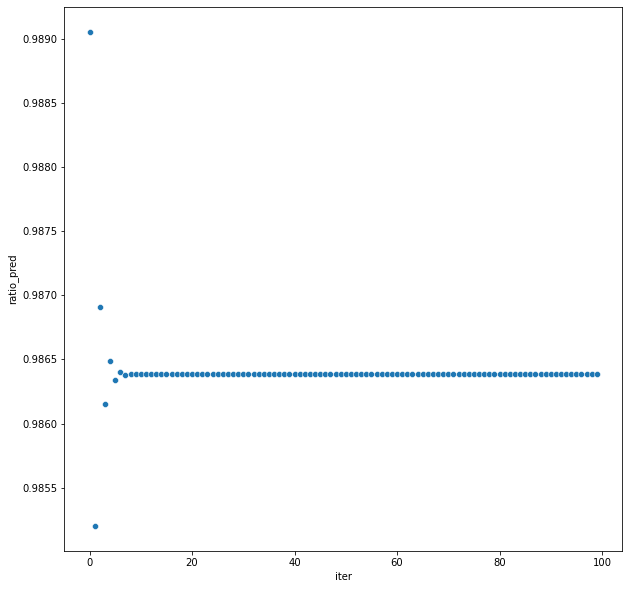

In [388]:
df_ = pd.DataFrame(data={"iter" : range(100), "ratio_pred" : output_vec})
plt_ = sns.scatterplot(data=df_, x="iter", y="ratio_pred")

In [249]:
x = output_observed[:, passage_, :, 0, count_p].flatten()
y = output_test[:, passage_, :, 0, count_p].flatten()
id_ = np.where(x > 0)[0]
y = y[id_]
x = x[id_]
y = y**(1/p_vec[count_p])
x = x**(1/p_vec[count_p])
x

array([5.43944244e-02, 1.85616455e+00, 3.74268942e-01, 1.41595541e+00,
       1.34834510e+00, 1.45813026e+00, 5.29403280e-01, 3.27224348e+00,
       3.50207827e+00, 1.76685949e-01, 1.25544996e-02, 1.22045668e-01,
       1.15535462e-01, 1.46481173e+00, 2.89238782e-02, 1.11982710e+01,
       2.53324120e-02, 2.58969637e+00, 1.62636482e+01, 3.91835233e+00,
       1.97009344e+00, 8.53346463e-02, 8.05282163e+00, 6.66548107e+00,
       1.07173441e+01, 4.03045961e-01, 1.87956618e-01, 4.64327669e-01,
       2.82023787e+00, 2.12862812e+00, 4.76119902e+00, 4.66024684e+00,
       1.44486617e+00, 1.40723766e+00, 4.13189186e-01, 9.99835749e-02,
       2.18391414e-01, 1.14242516e+00, 1.78215393e+00, 9.46709384e-01,
       6.66770827e-01, 2.84650783e-01, 1.72150749e-02, 3.55040533e+00,
       5.77725965e+00, 3.87123797e+00, 1.61192386e-01, 7.02209258e-01,
       2.70241956e+00, 1.17762279e+00, 3.36775768e+00, 4.90150196e+00,
       3.17281461e-01, 2.19467058e-01, 3.75559128e-01, 4.08135948e-01,
      

In [400]:
p_vec[count_p]

0.1

In [447]:
count_p = 5
species_ = 0
passage_ = 0
x = output_observed[:, passage_, :, 0, count_p]
y = output_test[:, passage_, :, 0, count_p]
x_mean = -1 * np.ones((num_species))
y_mean = x_mean.copy()

for species_ in range(num_species):
    id_x = np.where(x[species_, :] != -1)[0]
    id_y = np.where(y[species_, :] != -1)[0]
    
    if len(id_x) > 0:
        x_mean[species_] = np.mean(x[species_, id_x])
        y_mean[species_] = np.mean(y[species_, id_y])

In [449]:
y_mean

array([0.11585273, 0.19883901, 0.6852424 , 0.30535766, 0.31059398,
       0.3009616 , 0.37738453, 0.49543502, 0.09648142, 0.48576222,
       0.49926183, 0.22887611, 0.26403246, 0.34810203, 0.26438449,
       0.1002166 , 0.52401193, 0.26556689, 0.4374567 , 0.50110223,
       0.1551397 , 0.43274624, 0.71408782, 1.04091638, 0.26400109,
       0.08777871, 0.15837329, 0.17527789, 0.02012394, 0.67362425,
       0.01326806, 0.42297688, 1.98351833, 0.71717613, 0.33873563,
       0.42534471, 0.45823523, 0.7532595 , 0.49498485, 0.87681162,
       0.29438136, 0.21065482, 0.17147747, 0.14970712, 0.37805496,
       0.55485885, 0.30825019, 0.13433479, 0.11908639, 0.22958519,
       0.26878744, 0.39640985, 0.67855745, 0.46671498, 0.4854956 ,
       0.38715162, 0.22646814, 0.05818268, 0.5262414 , 0.44264904,
       1.13604982, 0.40232075, 0.15216041])

-1.021884303372432
-1.295890415395848
PearsonRResult(statistic=0.2717356695832062, pvalue=0.00015533216903064432)


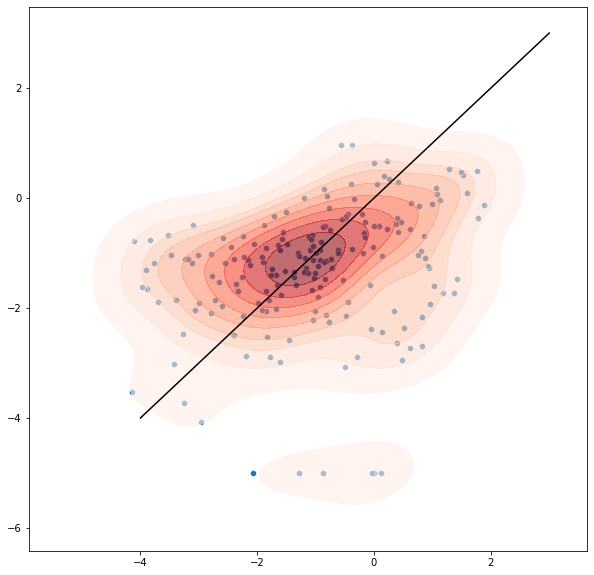

In [583]:
mpl.rcParams['figure.figsize'] = 10, 10
count_p = 5
species_ = 0
passage_ = 0
x = output_observed[:, passage_, :, 0, count_p].flatten()
y = output_test[:, passage_, :, 0, count_p].flatten()
#     id_ = np.where(x > 0)[0]
id_ = np.where((x > 0) & (y > 0))[0]
y = y[id_]
x = x[id_]
y = y**(1/p_vec[count_p])
x = x**(1/p_vec[count_p])
id_ = np.where((x > 0) & (y > 0))[0]
y = y[id_]
x = x[id_]
y[y <= 1e-5] = 1e-5
# x_mat = output_observed[:, passage_, :, 0, count_p]
# y_mat = output_test[:, passage_, :, 0, count_p]
# x_mean = -1 * np.ones((num_species))
# y_mean = x_mean.copy()

# for species_ in range(num_species):
#     id_x = np.where(x_mat[species_, :] != -1)[0]
#     id_y = np.where(y_mat[species_, :] != -1)[0]
    
#     if len(id_x) > 0:
#         x_mean[species_] = np.mean(x_mat[species_, id_x])
#         y_mean[species_] = np.mean(y_mat[species_, id_y])
# # y[y <= 1e-10] = 1e-10
# # id_ = np.where((x > 0) & (x <= 1))[0]
# id_ = np.where((x_mean > 0) & (y_mean > 0))[0]
# y = y_mean[id_]
# x = x_mean[id_]
# y = y**(1/p_vec[count_p])
# x = x**(1/p_vec[count_p])
# id_ = np.where((x > 0) & (y > 0))[0]
# y = y[id_]
# x = x[id_]
print(np.mean(np.log10(x)))
print(np.mean(np.log10(y)))
# sns.histplot(data=pd.DataFrame(data={"x" : np.log10(x), "y" : np.log10(y)}))
plt_ = sns.scatterplot(x=np.log10(x), \
                       y=np.log10(y))
plt_ = sns.kdeplot(x=np.log10(x), y=np.log10(y), fill=True, alpha=0.6, cmap="Reds", ax=plt_)

plt_.plot([-4, 3], [-4, 3], c="black")
# plt_.set_xscale("log", base=10)
# plt_.set_yscale("log", base=10)
corr_val = scipy.stats.pearsonr(np.log10(x), np.log10(y))
print(corr_val)

corr_vec = np.zeros((len(p_vec)))
corr_pval_vec = corr_vec.copy()
for count_p in range(len(p_vec)):
    x = output_observed[:, passage_, :, 0, count_p].flatten()
    y = output_test[:, passage_, :, 0, count_p].flatten()
    y[y <= 1e-10] = 1e-10
#     id_ = np.where(x > 0)[0]
    id_ = np.where((x > 0) & (y > 0))[0]
    y = y[id_]
    x = x[id_]
    y = y**(1/p_vec[count_p])
    x = x**(1/p_vec[count_p])
    id_ = np.where((x > 0) & (y > 0))[0]
    y = y[id_]
    x = x[id_]
#     x_mat = output_observed[:, passage_, :, 0, count_p]
#     y_mat = output_test[:, passage_, :, 0, count_p]
#     x_mean = -1 * np.ones((num_species))
#     y_mean = x_mean.copy()

#     for species_ in range(num_species):
#         id_x = np.where(x_mat[species_, :] != -1)[0]
#         id_y = np.where(y_mat[species_, :] != -1)[0]

#         if len(id_x) > 0:
#             x_mean[species_] = np.mean(x_mat[species_, id_x])
#             y_mean[species_] = np.mean(y_mat[species_, id_y])
#     # y[y <= 1e-10] = 1e-10
#     # id_ = np.where((x > 0) & (x <= 1))[0]
#     id_ = np.where((x_mean > 0) & (y_mean > 0))[0]
#     y = y_mean[id_]
#     x = x_mean[id_]
#     y = y**(1/p_vec[count_p])
#     x = x**(1/p_vec[count_p])
#     id_ = np.where((x > 0) & (y > 0))[0]
#     y = y[id_]
#     x = x[id_]
    corr_val = scipy.stats.pearsonr(np.log10(x), np.log10(y))
    corr_vec[count_p] = corr_val[0]
    corr_pval_vec[count_p] = corr_val[1]

In [584]:
df_corr = pd.DataFrame(data={"corr" : corr_vec, "p_val" : corr_pval_vec, "p" : p_vec})
print(df_corr)

       corr     p_val     p
0 -0.090005  0.218077  0.10
1  0.000517  0.994367  0.15
2 -0.010433  0.886696  0.20
3 -0.020390  0.780643  0.25
4 -0.139882  0.054888  0.30
5  0.039157  0.592682  0.35
6  0.111712  0.125919  0.40
7  0.266135  0.000214  0.45
8  0.298383  0.000030  0.50
9  0.297933  0.000031  0.55


In [592]:
np.exp(np.log(output_observed[:, passage_, :, 0, count_p]**(1/p_vec[count_p])).mean(axis=1))

array([6.08416622e-03, 1.05099914e+00, 4.72530890e-01, 2.64416875e-03,
       6.88452517e-04, 1.61534199e-03, 3.87447395e-01, 3.01333453e-02,
       9.49351173e-01, 3.82325971e-02, 1.48017030e-03, 1.56906992e-01,
       1.18248393e-01, 9.99351683e+00, 9.66135186e-02, 5.96634097e-01,
       5.26640990e-02, 1.77223216e+01, 5.73070497e-02, 1.46889073e-02,
       1.38032208e-02, 1.35135950e+00, 3.59044642e-01, 2.71154046e+01,
       1.31488637e-02, 4.32462217e+00, 9.53575675e-04, 5.89999268e-02,
       3.82558890e-02, 6.02276471e-02, 4.34839596e-04, 6.44988416e-02,
       3.49223726e+01, 1.87583822e+00, 2.27004456e-01, 3.12813786e-02,
       2.21072371e-01, 1.16539232e-01, 8.28078550e-02, 1.86177277e+00,
       3.89406504e-04, 1.89381260e-01, 7.27495025e+00, 2.10601916e-02,
       3.83392174e-02, 1.76196943e+01, 2.61250614e-04, 1.29413235e-02,
       1.05193266e-03, 5.17000171e-03, 6.37925629e-02, 4.23803469e+00,
       1.66011080e+00, 7.16267844e-03, 3.70666552e-01, 1.64430950e+00,
      

Ttest_1sampResult(statistic=-5.9991314191871705, pvalue=1.1169866039230221e-07)
-1.0218843033724323


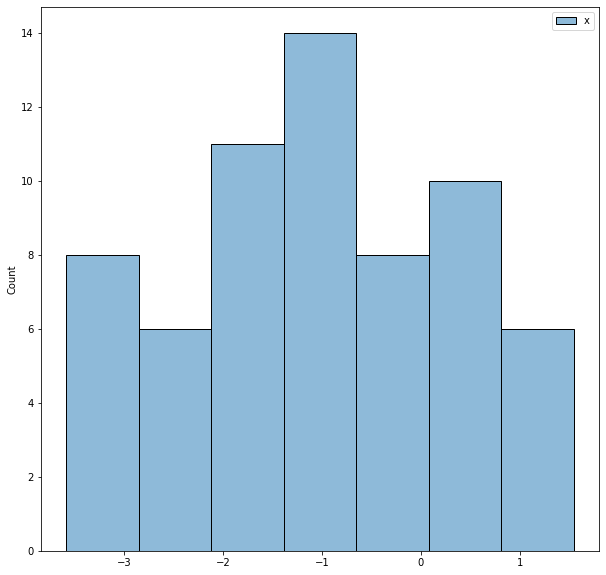

In [509]:
sample_ = 0
vals_ = df_speciesAbun_ratio.iloc[:, [sample_] + [sample_ + 5] + [sample_ + 10]].values
vals_mean = -100000 * np.ones((num_species))

for row_ in range(vals_.shape[0]):
    vals_tmp = vals_[row_, :]
    id_ = np.where(vals_tmp > 0)[0]
    if len(id_) == 3:
        vals_mean[row_] = np.mean(np.log10(vals_tmp[id_]))
print(scipy.stats.ttest_1samp(vals_mean[vals_mean > -1e4], 0))
print(np.mean(vals_mean[vals_mean > -1e4]) - 0)
# print(scipy.stats.ttest_1samp(np.log10(vals_[vals_ > 0].flatten()), 0))
# print(np.median(vals_mean) - 1)
# plt_ = sns.histplot(data=pd.DataFrame(data={"x" : np.log10(vals_[vals_ > 0].flatten())}))
# print(np.mean(np.log10(vals_[vals_ > 0].flatten())))

plt_ = sns.histplot(data=pd.DataFrame(data={"x" : vals_mean[vals_mean > -1e4]}))

In [502]:
vals_mean[vals_mean > -1e4]

array([ 0.0328335 ,  0.01597188, -0.64178884, -0.06013056,  0.43473845,
       -0.17502414,  0.17730412,  0.1656163 , -0.25789165,  0.07387384,
       -0.29311254, -1.84516968, -0.31818103, -0.14262344,  0.01547228,
        0.02563985,  0.16443482,  0.29643632, -0.30297222,  0.0421541 ,
       -0.05194589,  0.03038526, -0.32558811, -0.42532679, -0.16034406,
        0.27414953,  0.27161528,  0.25067483, -0.64150072,  0.14689525,
       -0.02223468, -0.1198985 ,  0.1904291 ,  0.18155288, -0.04521957,
       -0.14782212,  0.46108102, -0.44127856,  0.05988158, -0.06533596,
       -0.03376117, -0.19493852,  0.27135882, -0.03243959, -0.71541529,
       -0.17777784,  0.19615063, -0.08949753])

In [502]:
metab_rank = np.zeros((len(p_vec), num_metabs))
metab_rank_null = metab_rank.copy()

metab_val = metab_rank.copy()
metab_val_null = metab_rank_null.copy()
for count_p in range(len(p_vec)):
    count_ = 0
    for rep_ in range(num_rep_nnls):
        for fold_ in range(nfold):
#             metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
            metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
            metab_rank_null[count_p, :] += get_rank(coeff_null_train_2[rep_][fold_][count_p])
            
#             metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
            metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
            metab_val_null[count_p, ] += coeff_null_train_2[rep_][fold_][count_p]
#             id_nnz = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
#             freq_tmp = np.zeros((1, num_metabs))
#             freq_tmp[0, id_nnz] = 1
#             metab_freq[count_p, :] += freq_tmp[0, :]
            
#             metab_val_null[count_p, :] += coeff_null_train[rep_][fold_][count_p]
            
            count_ += 1
metab_rank /= count_
metab_rank_null /= count_

metab_val /= count_
metab_val_null /= count_

output_ = []
output_null = []
p_vec_all = []
species_all = []

for count_p in range(len(p_vec)):
    p_ = p_vec[count_p]
    df_speciesAbun_split = geometric_avg(df_speciesAbun_prev, df_speciesAbun_next, p=p_)
    df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                               df_speciesAbun=df_speciesAbun_split)
    df_cons_abun_prod_avg_split = df_cons_abun_prod_split.mean(axis=0)
    sample_names_split, mat_cons_abun_split_list = \
        compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_split, 
                                              df_speciesMetab=df_speciesMetab, 
                                              num_passages=6, num_bioRep=3, 
                                              sample_names=list(df_speciesAbun_split.columns.values))
#     sample_names_split, mat_cons_abun_split_list = \
#         compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod, 
#                                               df_speciesMetab=df_speciesMetab, 
#                                               num_passages=6, num_bioRep=3, 
#                                               sample_names=list(df_speciesAbun.columns.values))
    for sample_ in sample_names_split:
        A_test_sample = mat_cons_abun_split_list[sample_][:, :].copy()
        sample_id = sample_names_split.index(sample_)
        tmp = np.array(df_speciesAbun_ratio.iloc[:, sample_id].values)
#         tmp = np.array(df_speciesAbun.iloc[:, sample_id])
        id_keep = np.where(tmp != -1)[0]
        tmp = np.array(tmp**(-p_)).reshape((num_species, 1))
        tmp = np.matmul(tmp, np.ones((1, A_test_sample.shape[1])))
        A_test_sample = np.multiply(A_test_sample, tmp)
        A_test_sample = A_test_sample[id_keep, :]

    #     output_ += list(np.matmul(A_test_sample, coeff_train[rep_][fold_][count_p][0]))
        output_ += list(np.matmul(A_test_sample, metab_val[count_p, :]))
        output_null += list(np.matmul(A_test_sample, metab_val_null[count_p, :]))
        p_vec_all += [p_vec[count_p]] * A_test_sample.shape[0]
        species_all += list(id_keep.flatten())

/tmp/ipykernel_6952/3984028891.py:58: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_)).reshape((num_species, 1))


In [448]:
output_

[1.0849242593288642,
 1.1047496700373398,
 0.7701799524056747,
 0.9617145390761065,
 0.9952990076246844,
 1.0252136823488658,
 0.9901613677903578,
 1.0921851380949488,
 1.234389900260767,
 1.129523305159164,
 1.0716301445807295,
 1.1652740864083366,
 1.0828940158545275,
 1.1212335152556432,
 1.1354462335071087,
 1.1380792926461871,
 1.1296506341175867,
 1.0848136970432083,
 1.055749338252822,
 1.059231033379345,
 1.0325078137678934,
 1.337199641618532,
 1.2208501597230126,
 1.1153603827557368,
 1.1165216819791333,
 0.9422220995981618,
 0.952505466264451,
 1.1807818041442955,
 0.8939732633397595,
 0.9877700272103824,
 0.891437176776285,
 0.957978969337764,
 0.766001031196164,
 1.083262412336059,
 0.7834423266826951,
 1.0899384416046725,
 1.026057729053496,
 0.9709643896558164,
 1.2111776786742552,
 0.8795211142697617,
 0.9356933962444449,
 0.7232309341991878,
 0.8576086936612533,
 0.8037694224539325,
 1.0901162118664123,
 0.8140807367560439,
 1.0369701245130898,
 0.9333912316884156,
 0.

In [361]:
def get_ci(val_, num_boot=10000, method="basic"):
    bs = StationaryBootstrap(12, np.array(val_))
    ci = bs.conf_int(np.mean, num_boot, method=method)
    
    mean_ = np.mean(val_)
    return ci.flatten()

def asymmetric_errorbars(x):
    errors = np.zeros((len(x), 2))
    for i, group_val in enumerate(x):
        group_data = df_plt[df_plt["p"]==group_val]["error"],values
        conf_int = get_ci(group_data, method="bca")
        errors[i, 0] = np.mean(group_data) - conf_int[0]
        errors[i, 1] = conf_int[1] - np.mean(group_data)
    return errors

In [457]:
metab_val[0, :]

array([1.42147170e-05, 3.88898535e-02, 0.00000000e+00, 0.00000000e+00,
       3.09705844e-03, 2.61550042e-02, 1.07247954e-03, 2.08234937e-04,
       0.00000000e+00, 1.01012040e-01, 1.47101470e-08, 2.64415669e-04,
       0.00000000e+00, 8.36772950e-06, 0.00000000e+00, 0.00000000e+00,
       1.90877330e-10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.56956710e-05, 2.43504402e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.88242212e-07, 0.00000000e+00, 2.38571735e-05,
       0.00000000e+00, 4.21835739e-05, 0.00000000e+00, 0.00000000e+00,
       7.11116723e-04, 1.73114038e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.31173641e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.02805697e-09, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.77915560e-02, 4.30498916e-03, 0.00000000e+00,
       9.88528585e-03, 0.00000000e+00, 6.70735343e-03, 0.00000000e+00,
       0.00000000e+00, 7.91379987e-03, 0.00000000e+00, 2.70361479e-03,
      

In [401]:
df_speciesNames['species_name'].values[df_speciesIds.iloc[:, 0].values - 1]

array(['Acidaminococcus fermentans DSMZ 20731',
       'Acidaminococcus intestini D21 BEI HM-81',
       'Anaerostipes caccae DSMZ 14662',
       'Anaerotruncus colihominis DSMZ 17241',
       'Bacteroides caccae ATCC 43185',
       'Bacteroides cellulosilyticus DSMZ 14838',
       'Bacteroides coprophilus DSMZ 18228',
       'Bacteroides dorei 5_1_36/D4 BEI HM-29',
       'Bacteroides dorei DSMZ 17855', 'Bacteroides eggerthii ATCC 27754',
       'Bacteroides finegoldii DSMZ 17565',
       'Bacteroides fragilis 3_1_12 BEI HM-20',
       'Bacteroides intestinalis DSMZ 17393',
       'Bacteroides ovatus ATCC 8483', 'Bacteroides plebeius DSMZ 17135',
       'Bacteroides sp. 1_1_6 BEI HM-23',
       'Bacteroides sp. 2_1_16 BEI HM-58',
       'Bacteroides sp. 2_1_22 BEI HM-18',
       'Bacteroides sp. 3_1_19 BEI HM-19',
       'Bacteroides sp. 9_1_42FAA BEI HM-27',
       'Bacteroides sp. D20 BEI HM-189',
       'Bacteroides stercoris ATCC 43183',
       'Bacteroides thetaiotaomicron VPI 54

In [526]:
error = np.abs(1 - np.array(output_.copy()))
error_null = np.abs(1 - np.array(output_null.copy()))
df_plt = pd.DataFrame(data={'error' : list(error) + list(error_null), \
                            "p" : p_vec_all + p_vec_all, \
                            "model" : ["fit"] * len(p_vec_all) + ["null"] * len(p_vec_all), \
                            "species" : species_names[species_all + species_all]})

mpl.rcParams['figure.figsize'] = 10, 10
ax = sns.barplot(data=df_plt, x="p", y="error", errorbar=get_ci, \
                 hue="model", order=p_vec)

ax.set_yscale("log", base=10)
# graph_.axhline(0.00, color="black")
ax.set_ylabel("error", size=20)
ax.set_xlabel("p", size=20)
ax.set_xticklabels(ax.get_xticklabels(), size=15)
ax.set_yticklabels(ax.get_yticklabels(), size=15)
ax.legend(fontsize=20, title="model", title_fontsize=20)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', "predictions", "leaveOneOut"))
# save_file = os.path.abspath(os.path.join(save_dir, f'predictionError_vs_p_reps_{num_rep_nnls}.png'))
save_file = os.path.abspath(os.path.join(save_dir, f'predictionError_vs_p_leaveOneOut.png'))
ax.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
ax.figure.clear()
# sns.barplot(data=df_output, x="passage#", y="output", e)


for species_ in species_names:
    print(f'species = {species_}')
    mpl.rcParams['figure.figsize'] = 10, 10
    df_plt_species = df_plt[df_plt["species"] == species_]
    
    ax = sns.barplot(data=df_plt_species, x="p", y="error", errorbar=get_ci, \
                 hue="model", order=p_vec)

    ax.set_yscale("log", base=10)
    # graph_.axhline(0.00, color="black")
    ax.set_ylabel("error", size=20)
    ax.set_xlabel("p", size=20)
    ax.set_xticklabels(ax.get_xticklabels(), size=15)
    ax.set_yticklabels(ax.get_yticklabels(), size=15)
    ax.set_title(species_, size=20)
    ax.legend(fontsize=20, title="model", title_fontsize=20)

    save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', "predictions", "leaveOneOut"))
    # save_file = os.path.abspath(os.path.join(save_dir, f'predictionError_vs_p_reps_{num_rep_nnls}.png'))
    species_ = species_.replace("/", "_")
    save_file = os.path.abspath(os.path.join(save_dir, \
                                             f'predictionError_vs_p_leaveOneOut_species_{species_}.png'))
    ax.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    ax.figure.clear()

/tmp/ipykernel_6952/1741354266.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Acidaminococcus fermentans DSMZ 20731


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Acidaminococcus intestini D21 BEI HM-81


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Anaerostipes caccae DSMZ 14662


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Anaerotruncus colihominis DSMZ 17241


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides caccae ATCC 43185


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides cellulosilyticus DSMZ 14838


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides coprophilus DSMZ 18228


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides dorei 5_1_36/D4 BEI HM-29


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides dorei DSMZ 17855


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides eggerthii ATCC 27754


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides finegoldii DSMZ 17565


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides fragilis 3_1_12 BEI HM-20


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides intestinalis DSMZ 17393


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides ovatus ATCC 8483


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides plebeius DSMZ 17135


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides sp. 1_1_6 BEI HM-23


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides sp. 2_1_16 BEI HM-58


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides sp. 2_1_22 BEI HM-18


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides sp. 3_1_19 BEI HM-19


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides sp. 9_1_42FAA BEI HM-27


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides sp. D20 BEI HM-189


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides stercoris ATCC 43183


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides thetaiotaomicron VPI 5482


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides uniformis ATCC 8492


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bacteroides vulgatus ATCC 8482


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bifidobacterium adolescentis L2-32


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Bifidobacterium infantis ATCC 15697


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Blautia hansenii DSMZ 20583


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Catenibacterium mitsuokai DSMZ 15897


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Clostridium hylemonae DSMZ 15053


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Clostridium leptum DSMZ 753


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Clostridium scindens ATCC 35704


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Clostridium sporogenes ATCC 15579


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Collinsella aerofaciens ATCC 25986


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Coprococcus comes ATCC 27758


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Desulfovibrio piger ATCC 29098 M1


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Dorea formicigenerans ATCC 27755


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Dorea longicatena DSMZ 13814


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Eggerthella lenta DSMZ 2243


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Eubacterium rectale ATCC 33656


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Eubacterium siraeum DSMZ 15702


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Eubacterium ventriosum DSMZ 3988


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Granulicatella adiacens DSMZ 9848


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Holdemanella biformis DSMZ 3989


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Holdemania filiformis DSMZ 12042


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Hungatella hathewayi DSM 13479


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Intestinibacter bartlettii DSM 16795


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Lactobacillus plantarum ATCC BAA-793


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Lactobacillus ruminis ATCC 25644


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Lactococcus lactis DSMZ 20729


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Marvinbryantia formatexigens DSMZ 14469


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Mitsuokella multacida DSMZ 20544


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Parabacteroides distasonis ATCC 8503


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Parabacteroides johnsonii DSMZ 18315


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Parabacteroides merdae ATCC 43184


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Parabacteroides sp. D13 BEI HM-77


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Peptostreptococcus sp. CC14N BEI HM-1051


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Ruminococcus bromii ATCC 27255


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Ruminococcus gnavus ATCC 29149


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Ruminococcus torques ATCC 27756


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Slackia exigua ATCC 700122


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Streptococcus thermophilus LMD-9 ATCC 19258


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


species = Tyzzerella nexilis DSM 1787


/tmp/ipykernel_6952/1741354266.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=15)


<Figure size 720x720 with 0 Axes>

In [470]:
x = species_.replace("/", "_")
x

'Bacteroides dorei 5_1_36_D4 BEI HM-29'

In [102]:
np.min(df_plt['error'].values)

1.3723324106873491e-05

In [121]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit", "lower_p"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p.pickle'))

save_obj = {"coeff" : coeff_train, "coeff_null" : coeff_null_train, \
            "coeff_null2" : coeff_null_train_2, "output_train" : output_train, \
            "output_null_train" : output_null_train, "output_null2_train" : output_null_train_2, \
            "output_test" : output_test, \
            "output_null_test" : output_null_test, "output_null2_test" : output_null_test_2}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_)

In [275]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit", "lower_p"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_reps_{num_rep_nnls}.pickle'))
with open(file_save, "rb") as file_:
    save_obj = pickle.load(file_)
coeff_train = save_obj['coeff']
coeff_null_train_2 = save_obj['coeff_null2']
coeff_null_train = save_obj['coeff_null']

In [42]:
num_rep_nnls = 300

In [47]:
metab_rank = np.zeros((len(p_vec), num_metabs))
metab_rank_null = metab_rank.copy()

metab_val = metab_rank.copy()
metab_val_null = metab_rank_null.copy()
for count_p in range(len(p_vec)):
    count_ = 0
    for rep_ in range(num_rep_nnls):
        for fold_ in range(nfold):
#             metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
            metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
            metab_rank_null[count_p, :] += get_rank(coeff_null_train_2[rep_][fold_][count_p])
            
#             metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
            metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
            metab_val_null[count_p, ] += coeff_null_train_2[rep_][fold_][count_p]
#             id_nnz = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
#             freq_tmp = np.zeros((1, num_metabs))
#             freq_tmp[0, id_nnz] = 1
#             metab_freq[count_p, :] += freq_tmp[0, :]
            
#             metab_val_null[count_p, :] += coeff_null_train[rep_][fold_][count_p]
            
            count_ += 1
metab_rank /= count_
metab_rank_null /= count_

metab_val /= count_
metab_val_null /= count_

In [213]:
# train nnls model when R_i is estimated for all the metabolites using the true order of species 
# abundances with leave 10 species out for different values of p_ (for B_split) with non-linear fit to 
# ensure that all Ri > 0 and positive
seed_ = 7363
np.random.seed(seed_)
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
num_bioRep = 3
num_rep_nnls = 10
p_vec = 10**np.linspace(-2, np.log10(0.2), 6)
p_vec = np.round(p_vec, 2)
p_lower = 10**np.array([-8, -6, -4]).astype(np.float64)
p_upper = 10**np.array([np.log10(0.4), np.log10(0.6)])
p_vec = np.concatenate((p_lower, p_vec, p_upper))

nfold = 15
num_perFold = np.floor(len(species_names) / nfold)

coeff_train = {}
coeff_null_train = {}
coeff_null_train_2 = {}
output_test = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
output_train = output_test.copy()
output_null_train = output_test.copy()
output_null_train_2 = output_null_train.copy()
test_strain_id_all = {}
output_null_test = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
output_null_test_2 = -1 * np.ones((num_species, num_passages - 1, num_bioRep, num_rep_nnls, len(p_vec)))
train_id_all_dict = {}

for rep_ in range(num_rep_nnls):
    print(f'repeat loop # = {rep_}')
    coeff_train[rep_] = {}
    coeff_null_train[rep_] = {}
    coeff_null_train_2[rep_] = {}
#     output_test[rep_] = {}
    train_id_all_dict[rep_] = {}
    
    passages_ = np.random.permutation(passages_)
    folds_id = np.arange(len(species_names))
    folds_id = np.random.permutation(folds_id)
    species_perFold = {}
    count_ = 0
    for fold_ in range(nfold):
        species_perFold[fold_] = {}
        if fold_ != nfold - 1:
            species_perFold[fold_]["test"] = \
                list(folds_id[np.arange(count_, count_ + num_perFold).astype('int')])

        else:
            species_perFold[fold_]["test"] = \
                list(folds_id[count_.astype("int"):])
        species_perFold[fold_]["train"] = \
            list(set(range(len(species_names))).difference(species_perFold[fold_]["test"]))
        count_ += num_perFold
    
    test_strain_id_all[rep_] = {}
    for fold_ in range(nfold):
        coeff_train[rep_][fold_] = {}
        coeff_null_train[rep_][fold_] = {}
        coeff_null_train_2[rep_][fold_] = {}
        train_strain_id = []
        for species_ in species_perFold[fold_]["train"]:
            train_strain_id += species_names_to_strainID[species_names[species_]]
        train_id_all_dict[rep_][fold_] = train_strain_id
        test_strain_id = []
        for species_ in species_perFold[fold_]["test"]:
            test_strain_id += species_names_to_strainID[species_names[species_]]
        test_strain_id_all[rep_][fold_] = test_strain_id
        
        count_p = -1
        for p_ in p_vec:
            count_p += 1
            df_speciesAbun_split = geometric_avg(df_speciesAbun_prev, df_speciesAbun_next, p=p_)
            df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                                       df_speciesAbun=df_speciesAbun_split)
            df_cons_abun_prod_avg_split = df_cons_abun_prod_split.mean(axis=0)
            sample_names_split, mat_cons_abun_split_list = \
                compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_split, 
                                                      df_speciesMetab=df_speciesMetab, 
                                                      num_passages=6, num_bioRep=3, 
                                                      sample_names=list(df_speciesAbun_split.columns.values))
#             coeff_null_train[rep_][fold_][count_p] = \
#                 null_Ri_2(df_speciesMetab.iloc[train_strain_id, :], \
#                         df_speciesAbun_ratio.iloc[train_strain_id, :], \
#                         df_cons_abun_prod_split, p_=p_)
#             coeff_null_train[rep_][fold_][count_p] = \
#                 null_Ri_2(df_speciesMetab, \
#                         df_speciesAbun_ratio, \
#                         df_cons_abun_prod_split, p_=p_)
            coeff_null_train[rep_][fold_][count_p] = \
                null_Ri_2_p(df_speciesMetab, \
                        df_speciesAbun_ratio, \
                        df_cons_abun_prod_split, p_=p_)
            coeff_null_train_2[rep_][fold_][count_p] = \
                null_Ri_2_p(df_speciesMetab.iloc[train_strain_id, :], \
                               df_speciesAbun_ratio.iloc[train_strain_id, :], \
                               df_cons_abun_prod_split, p_=p_)
            passages_train = passages_
            count_ = 0
            pass_all = []
            brep_all = []
            train_id_all = []
            output_all = []
            for sample_ in sample_names_split:
                pass_ = int(sample_.split("_")[0][1])
                brep_ = int(sample_.split("_")[1][1])
                A_train_sample = mat_cons_abun_split_list[sample_][train_strain_id, :]
                sample_id = sample_names_split.index(sample_)
                tmp = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
                id_keep = np.where(tmp != -1)[0]
                tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
                tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
                A_train_sample = np.multiply(A_train_sample, tmp)
                A_train_sample = A_train_sample[id_keep, :]
                
                pass_all += [pass_] * len(id_keep)
                brep_all += [brep_] * len(id_keep)
                train_id_all += list(np.array(train_strain_id)[id_keep])
                if count_ == 0:
                    A_train = A_train_sample
                    count_ += 1
                else:
                    A_train = np.vstack((A_train, A_train_sample))       
            b_train = np.ones((A_train.shape[0]))
#             coeff_train[rep_][fold_][count_p] = nnls(A_train, b_train)
            p0_ = np.zeros_like(metab_val[count_p, :])
            id_nnz = np.where(metab_val[count_p, :] != 0)[0]
            p0_[id_nnz] = -np.log(metab_val[count_p, id_nnz])
            p0_[metab_val[count_p, :] == 0] = -np.log(1e-14)
            mdl_fit  = curve_fit(model_order_0, A_train.T, b_train, 
                                  p0=p0_, bounds=(0, np.inf))
            coeff_train[rep_][fold_][count_p] = mdl_fit[0]
            
            for sample_ in sample_names_split:
                pass_ = int(sample_.split("_")[0][1])
                brep_ = int(sample_.split("_")[1][1])
                A_train_sample = mat_cons_abun_split_list[sample_][train_strain_id, :]
                sample_id = sample_names_split.index(sample_)
                tmp = np.array(df_speciesAbun_ratio.iloc[train_strain_id, sample_id])
                id_keep = np.where(tmp != -1)[0]
                tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
                tmp = np.matmul(tmp, np.ones((1, A_train_sample.shape[1])))
                A_train_sample = np.multiply(A_train_sample, tmp)
                A_train_sample = A_train_sample[id_keep, :]
                
                output_train[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    np.matmul(A_train_sample, coeff_train[rep_][fold_][count_p])
                output_null_train[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    np.matmul(A_train_sample, coeff_null_train[rep_][fold_][count_p])
                output_null_train_2[np.array(train_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    np.matmul(A_train_sample, coeff_null_train_2[rep_][fold_][count_p])
                

                #     test data
            passages_test = passages_train
            count_ = 0
            test_id_tmp = []
            for sample_ in sample_names_split:
                pass_ = int(sample_.split("_")[0][1])
                brep_ = int(sample_.split("_")[1][1])
                A_test_sample = mat_cons_abun_split_list[sample_][test_strain_id, :]
                sample_id = sample_names_split.index(sample_)
                tmp = np.array(df_speciesAbun_ratio.iloc[test_strain_id, sample_id])
                id_keep = np.where(tmp != -1)[0]
                tmp = np.array(tmp**(-p_)).reshape((len(test_strain_id), 1))
                tmp = np.matmul(tmp, np.ones((1, A_test_sample.shape[1])))
                A_test_sample = np.multiply(A_test_sample, tmp)
                A_test_sample = A_test_sample[id_keep, :]

                output_tmp = np.matmul(A_test_sample, coeff_train[rep_][fold_][count_p])
                output_test[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    output_tmp
                output_tmp = \
                    np.matmul(A_test_sample, coeff_null_train_2[rep_][fold_][count_p])
                B_ratio = np.array(df_speciesAbun_ratio.iloc[np.array(test_strain_id)[id_keep], sample_id])
                B_ratio = B_ratio**(-p_)
                output_null_test_2[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    output_tmp
                
                output_null_test[np.array(test_strain_id)[id_keep], pass_ - 2, brep_, rep_, count_p] = \
                    np.matmul(A_test_sample, coeff_null_train[rep_][fold_][count_p])
            
#             test_id_tmp += list(np.array(test_strain_id)[id_keep])
#             if count_ == 0:
#                 A_test = A_test_sample
#                 count_ += 1
#             else:
#                 A_test = np.vstack((A_test, A_test_sample)) 
#         output_test[]
#         output_test[rep_][fold_] = np.dot(A_test, coeff_train[rep_][fold_][0])
    

repeat loop # = 0


/tmp/ipykernel_23547/653026098.py:111: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
/tmp/ipykernel_23547/653026098.py:141: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_)).reshape((len(train_strain_id), 1))
/tmp/ipykernel_23547/653026098.py:165: RuntimeWarning: invalid value encountered in power
  tmp = np.array(tmp**(-p_)).reshape((len(test_strain_id), 1))


repeat loop # = 1
repeat loop # = 2
repeat loop # = 3
repeat loop # = 4
repeat loop # = 5
repeat loop # = 6
repeat loop # = 7
repeat loop # = 8
repeat loop # = 9


In [214]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit", "lower_p"))
file_save = os.path.abspath(os.path.join(save_dir, 
                                         f'trained_model_different_p_nonLinear.pickle'))

save_obj = {"coeff" : coeff_train, "coeff_null" : coeff_null_train, \
            "coeff_null2" : coeff_null_train_2, "output_train" : output_train, \
            "output_null_train" : output_null_train, "output_null2_train" : output_null_train_2, \
            "output_test" : output_test, \
            "output_null_test" : output_null_test, "output_null2_test" : output_null_test_2}
with open(file_save, "wb") as file_:
    pickle.dump(save_obj, file_) 

In [216]:
metab_rank = np.zeros((len(p_vec), num_metabs))
metab_rank_null = metab_rank.copy()

metab_val = metab_rank.copy()
metab_val_null = metab_rank_null.copy()
for count_p in range(len(p_vec)):
    count_ = 0
    for rep_ in range(num_rep_nnls):
        for fold_ in range(nfold):
#             metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
            metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p])
            metab_rank_null[count_p, :] += get_rank(coeff_null_train_2[rep_][fold_][count_p])
            
#             metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
            metab_val[count_p, ] += coeff_train[rep_][fold_][count_p]
            metab_val_null[count_p, ] += coeff_null_train_2[rep_][fold_][count_p]
#             id_nnz = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
#             freq_tmp = np.zeros((1, num_metabs))
#             freq_tmp[0, id_nnz] = 1
#             metab_freq[count_p, :] += freq_tmp[0, :]
            
#             metab_val_null[count_p, :] += coeff_null_train[rep_][fold_][count_p]
            
            count_ += 1
metab_rank /= count_
metab_rank_null /= count_

metab_val /= count_
metab_val_null /= count_

In [223]:
metab_rank = np.zeros((len(p_vec), num_metabs))
metab_rank_null = metab_rank.copy()

metab_val = metab_rank.copy()
metab_val_null = metab_rank_null.copy()
for count_p in range(len(p_vec)):
    count_ = 0
    for rep_ in range(num_rep_nnls):
        for fold_ in range(nfold):
#             metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
            metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p])
            metab_rank_null[count_p, :] += get_rank(coeff_null_train_2[rep_][fold_][count_p])
            
#             metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
            metab_val[count_p, ] += np.exp(-coeff_train[rep_][fold_][count_p])
            metab_val_null[count_p, ] += coeff_null_train_2[rep_][fold_][count_p]
#             id_nnz = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
#             freq_tmp = np.zeros((1, num_metabs))
#             freq_tmp[0, id_nnz] = 1
#             metab_freq[count_p, :] += freq_tmp[0, :]
            
#             metab_val_null[count_p, :] += coeff_null_train[rep_][fold_][count_p]
            
            count_ += 1
metab_rank /= count_
metab_rank_null /= count_

metab_val /= count_
metab_val_null /= count_

In [224]:
id_ = np.where(metab_val[0, :] != 0)[0]
print(len(id_))
print(np.sum(metab_val[0, :]))

292
0.9853983908417921


In [50]:
len(np.where(metab_val[0, :] != 0)[0])

213

$$\sum_i\, R_i\, \frac{c_i^{\alpha}}{\sum_{\beta}\, c_i^{\beta}\, B^{\beta}(k)}$$

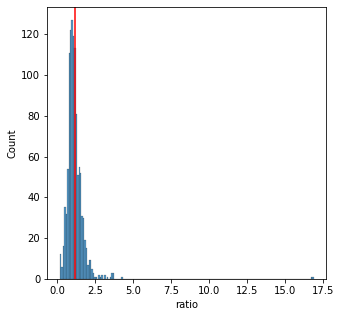

In [262]:
plt_ = sns.histplot(x=output_null)
plt_.set_xlabel("ratio")
plt_.axvline(np.mean(output_null), c="red")

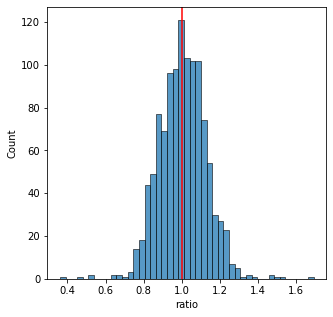

In [263]:
plt_ = sns.histplot(x=output_)
plt_.set_xlabel("ratio")
plt_.axvline(np.mean(output_), c="red")

In [145]:
# output_1 = output_.copy()
np.array(output_) - np.array(output_1)
np.mean(np.array(output_1))

0.8150818408506934

In [143]:
output_ = []
output_null = []
count_p = 7
p_ = p_vec[count_p]
# p_ = 0
df_speciesAbun_split = geometric_avg(df_speciesAbun_prev, df_speciesAbun_next, p=p_)
df_cons_abun_prod_split = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab, 
                                           df_speciesAbun=df_speciesAbun_split)
df_cons_abun_prod_avg_split = df_cons_abun_prod_split.mean(axis=0)
# sample_names_split, mat_cons_abun_split_list = \
#     compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_split, 
#                                           df_speciesMetab=df_speciesMetab, 
#                                           num_passages=6, num_bioRep=3, 
#                                           sample_names=list(df_speciesAbun_split.columns.values))
sample_names_split, mat_cons_abun_split_list = \
    compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod, 
                                          df_speciesMetab=df_speciesMetab, 
                                          num_passages=6, num_bioRep=3, 
                                          sample_names=list(df_speciesAbun.columns.values))
for sample_ in sample_names_split:
    A_test_sample = mat_cons_abun_split_list[sample_][:, :]
    sample_id = sample_names_split.index(sample_)
#     tmp = np.array(df_speciesAbun_ratio.iloc[:, sample_id])
    tmp = np.array(df_speciesAbun.iloc[:, sample_id])
    id_keep = np.where(tmp != -1)[0]
    tmp = np.array(tmp**(-p_)).reshape((num_species, 1))
    tmp = np.matmul(tmp, np.ones((1, A_test_sample.shape[1])))
    A_test_sample = np.multiply(A_test_sample, tmp)
    A_test_sample = A_test_sample[id_keep, :]

#     output_ += list(np.matmul(A_test_sample, coeff_train[rep_][fold_][count_p][0]))
    output_ += list(np.matmul(A_test_sample, metab_val[count_p, :]))
    output_null += list(np.matmul(A_test_sample, metab_val_null[count_p, :]))

In [75]:
list(df_speciesAbun.columns.values)

['p1_r0',
 'p2_r0',
 'p3_r0',
 'p4_r0',
 'p5_r0',
 'p6_r0',
 'p1_r1',
 'p2_r1',
 'p3_r1',
 'p4_r1',
 'p5_r1',
 'p6_r1',
 'p1_r2',
 'p2_r2',
 'p3_r2',
 'p4_r2',
 'p5_r2',
 'p6_r2']

In [65]:
df_speciesAbun.columns.values

array(['p1_r0', 'p2_r0', 'p3_r0', 'p4_r0', 'p5_r0', 'p6_r0', 'p1_r1',
       'p2_r1', 'p3_r1', 'p4_r1', 'p5_r1', 'p6_r1', 'p1_r2', 'p2_r2',
       'p3_r2', 'p4_r2', 'p5_r2', 'p6_r2'], dtype=object)

In [501]:
mpl.rcParams['figure.figsize'] = 20, 20
# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
#                                         "prediction_model_Bsplit", "higher_p"))
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit", "lower_p", "test"))
y_all = []
pass_all = []
p_list_all = []
for species_ in range(num_species):
    y = []
    pass_vec = []
    p_list = []
    for pass_ in range(output_test.shape[1]):
        for rep_ in range(num_bioRep):
            for p_id in range(len(p_vec)):
                id_ = np.where(output_test[species_, pass_, rep_, :, p_id] > 0)[0]
                if len(id_) >= 1:
                    y += list(output_test[species_, pass_, rep_, id_, p_id].flatten())
                    pass_vec += [pass_ + 2] * len(id_)
                    p_list += [p_vec[p_id]] * len(id_)
    y_all += y
    pass_all += pass_vec
    p_list_all += p_list
    df_plot = pd.DataFrame(data={"passage" : pass_vec, "output" : y, 
                                 "p" : p_list})
    
    graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                         hue="p", errorbar="sd", errwidth=0.8)
    graph_.axhline(1.00, color="black")
    graph_.set_ylabel("output (test)", size = 20)
    graph_.set_xlabel("Passage #", size = 20)
    species_id = df_speciesIds.iloc[:, 0].values[species_]
    graph_.set_title(df_speciesNames.iloc[:, 0].values[species_id], size=30)
    graph_.set_ylim(0, 3.0)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
    graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'prediction_vs_fold_test_species_{species_}.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()
# sns.barplot(data=df_output, x="passage#", y="output", e)

df_plot = pd.DataFrame(data={"passage" : pass_all, "output" : y_all, 
                             "p" : p_list_all})

graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                     hue="p", errorbar="sd", errwidth=0.8)
graph_.axhline(1.00, color="black")
graph_.set_ylabel("output (test)", size = 20)
graph_.set_xlabel("Passage #", size = 20)
graph_.set_ylim(bottom=0, top=3.0)
graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
graph_.legend(fontsize=20, title="p", title_fontsize=20)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'prediction_vs_fold_test_allSpecies.png'))
graph_.figure.tight_layout()
graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
graph_.figure.clear()

/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(gra

/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/298965552.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(gra

<Figure size 1440x1440 with 0 Axes>

In [502]:
mpl.rcParams['figure.figsize'] = 20, 20
# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
#                                         "prediction_model_Bsplit", "higher_p"))
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit", "lower_p", "train"))
y_all = []
pass_all = []
p_list_all = []
for species_ in range(num_species):
    y = []
    pass_vec = []
    p_list = []
    for pass_ in range(output_train.shape[1]):
        for rep_ in range(num_bioRep):
            for p_id in range(len(p_vec)):
                id_ = np.where(output_train[species_, pass_, rep_, :, p_id] > 0)[0]
                if len(id_) >= 1:
                    y += list(output_train[species_, pass_, rep_, id_, p_id].flatten())
                    pass_vec += [pass_ + 2] * len(id_)
                    p_list += [p_vec[p_id]] * len(id_)
    y_all += y
    pass_all += pass_vec
    p_list_all += p_list
    df_plot = pd.DataFrame(data={"passage" : pass_vec, "output" : y, 
                                 "p" : p_list})
    
    graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                         hue="p", errorbar="sd", errwidth=0.8)
    graph_.axhline(1.00, color="black")
    graph_.set_ylabel("output (train)", size = 20)
    graph_.set_xlabel("Passage #", size = 20)
    species_id = df_speciesIds.iloc[:, 0].values[species_] - 1
    graph_.set_title(df_speciesNames.iloc[:, 0].values[species_id], size=30)
    graph_.set_ylim(0, 1.5)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
    graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'prediction_vs_fold_train_species_{species_}.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()
# sns.barplot(data=df_output, x="passage#", y="output", e)

df_plot = pd.DataFrame(data={"passage" : pass_all, "output" : y_all, 
                             "p" : p_list_all})

graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                     hue="p", errorbar="sd", errwidth=0.8)
graph_.axhline(1.00, color="black")
graph_.set_ylabel("output (train)", size = 20)
graph_.set_xlabel("Passage #", size = 20)
graph_.set_ylim(bottom=0, top=1.5)
graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
graph_.legend(fontsize=20, title="p", title_fontsize=20)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'prediction_vs_fold_train_allSpecies.png'))
graph_.figure.tight_layout()
graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
graph_.figure.clear()

/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabe

/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2665157587.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabe

<Figure size 1440x1440 with 0 Axes>

passage    3.910394
output     0.988391
p          0.030000
dtype: float64

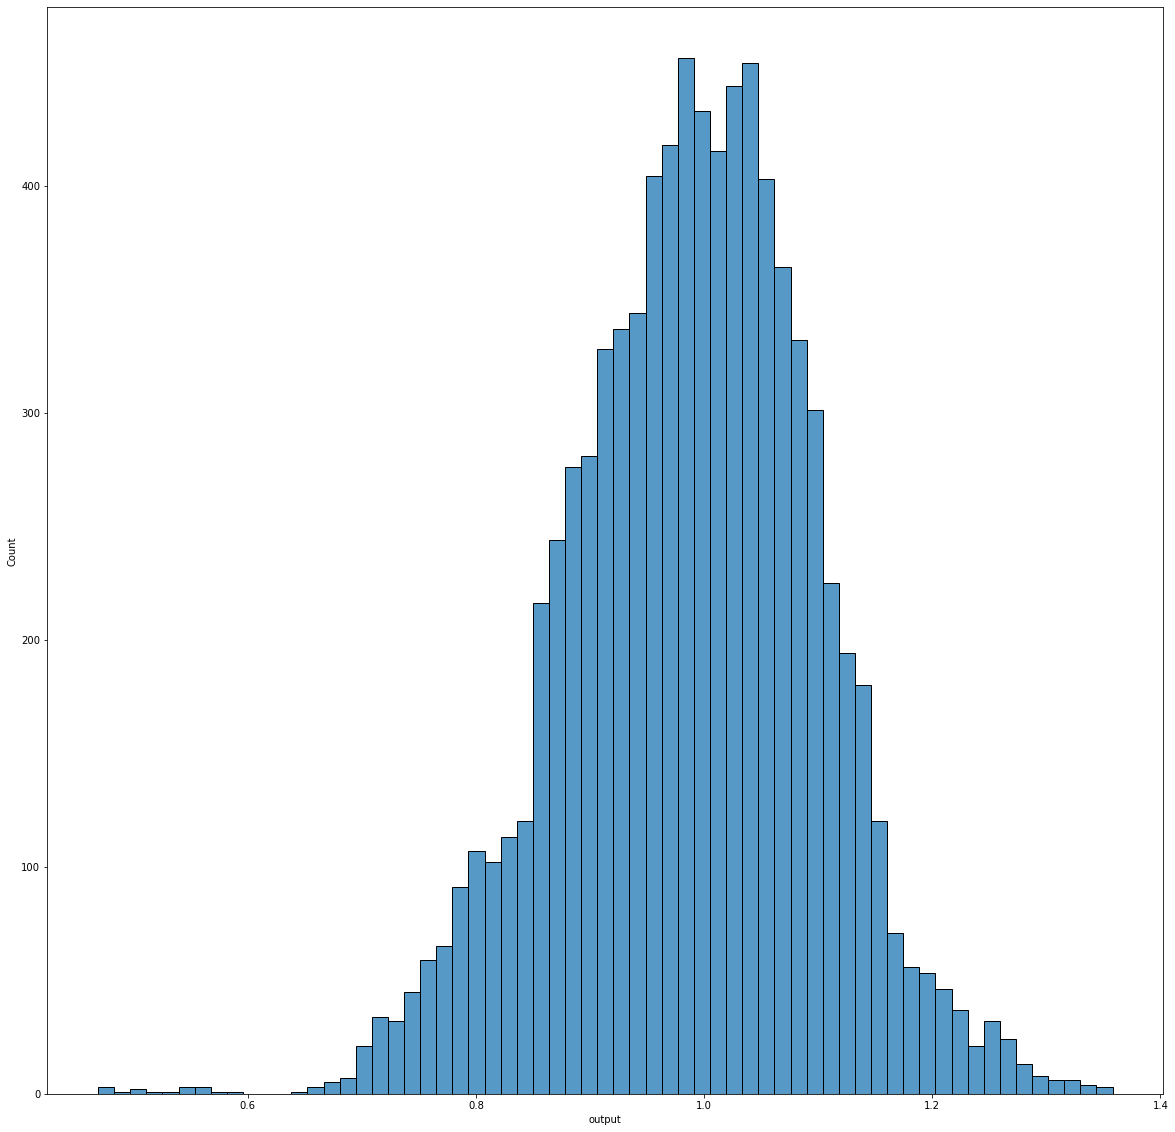

In [246]:
df_plot_copy = df_plot.copy()
df_plot_copy = df_plot_copy[df_plot_copy["p"] == p_vec[5]]
graph_ = sns.histplot(data=df_plot_copy, x="output")
df_plot_copy.mean()

In [642]:
rep_ = 0
count_p = 1

id_nnz = []

for fold_ in range(nfold):

    id_tmp = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
    if fold_ == 0:
        id_nnz = id_tmp
    else:
        id_nnz = list(set(list(id_tmp)).intersection(set(id_nnz)))
    

In [140]:
metab_freq = np.zeros((len(p_vec), num_metabs))
metab_val_null = np.zeros((len(p_vec), num_metabs))
for count_p in range(len(p_vec)):
    count_ = 0
    for rep_ in range(num_rep_nnls):
        for fold_ in range(nfold):
            id_nnz = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
            freq_tmp = np.zeros((1, num_metabs))
            freq_tmp[0, id_nnz] = 1
            metab_freq[count_p, :] += freq_tmp[0, :]
            
            metab_val_null[count_p, :] += coeff_null_train[rep_][fold_][count_p]
            
            count_ += 1
metab_freq /= count_
metab_val_null /= count_

/tmp/ipykernel_7362/314838881.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt_.figure.show()


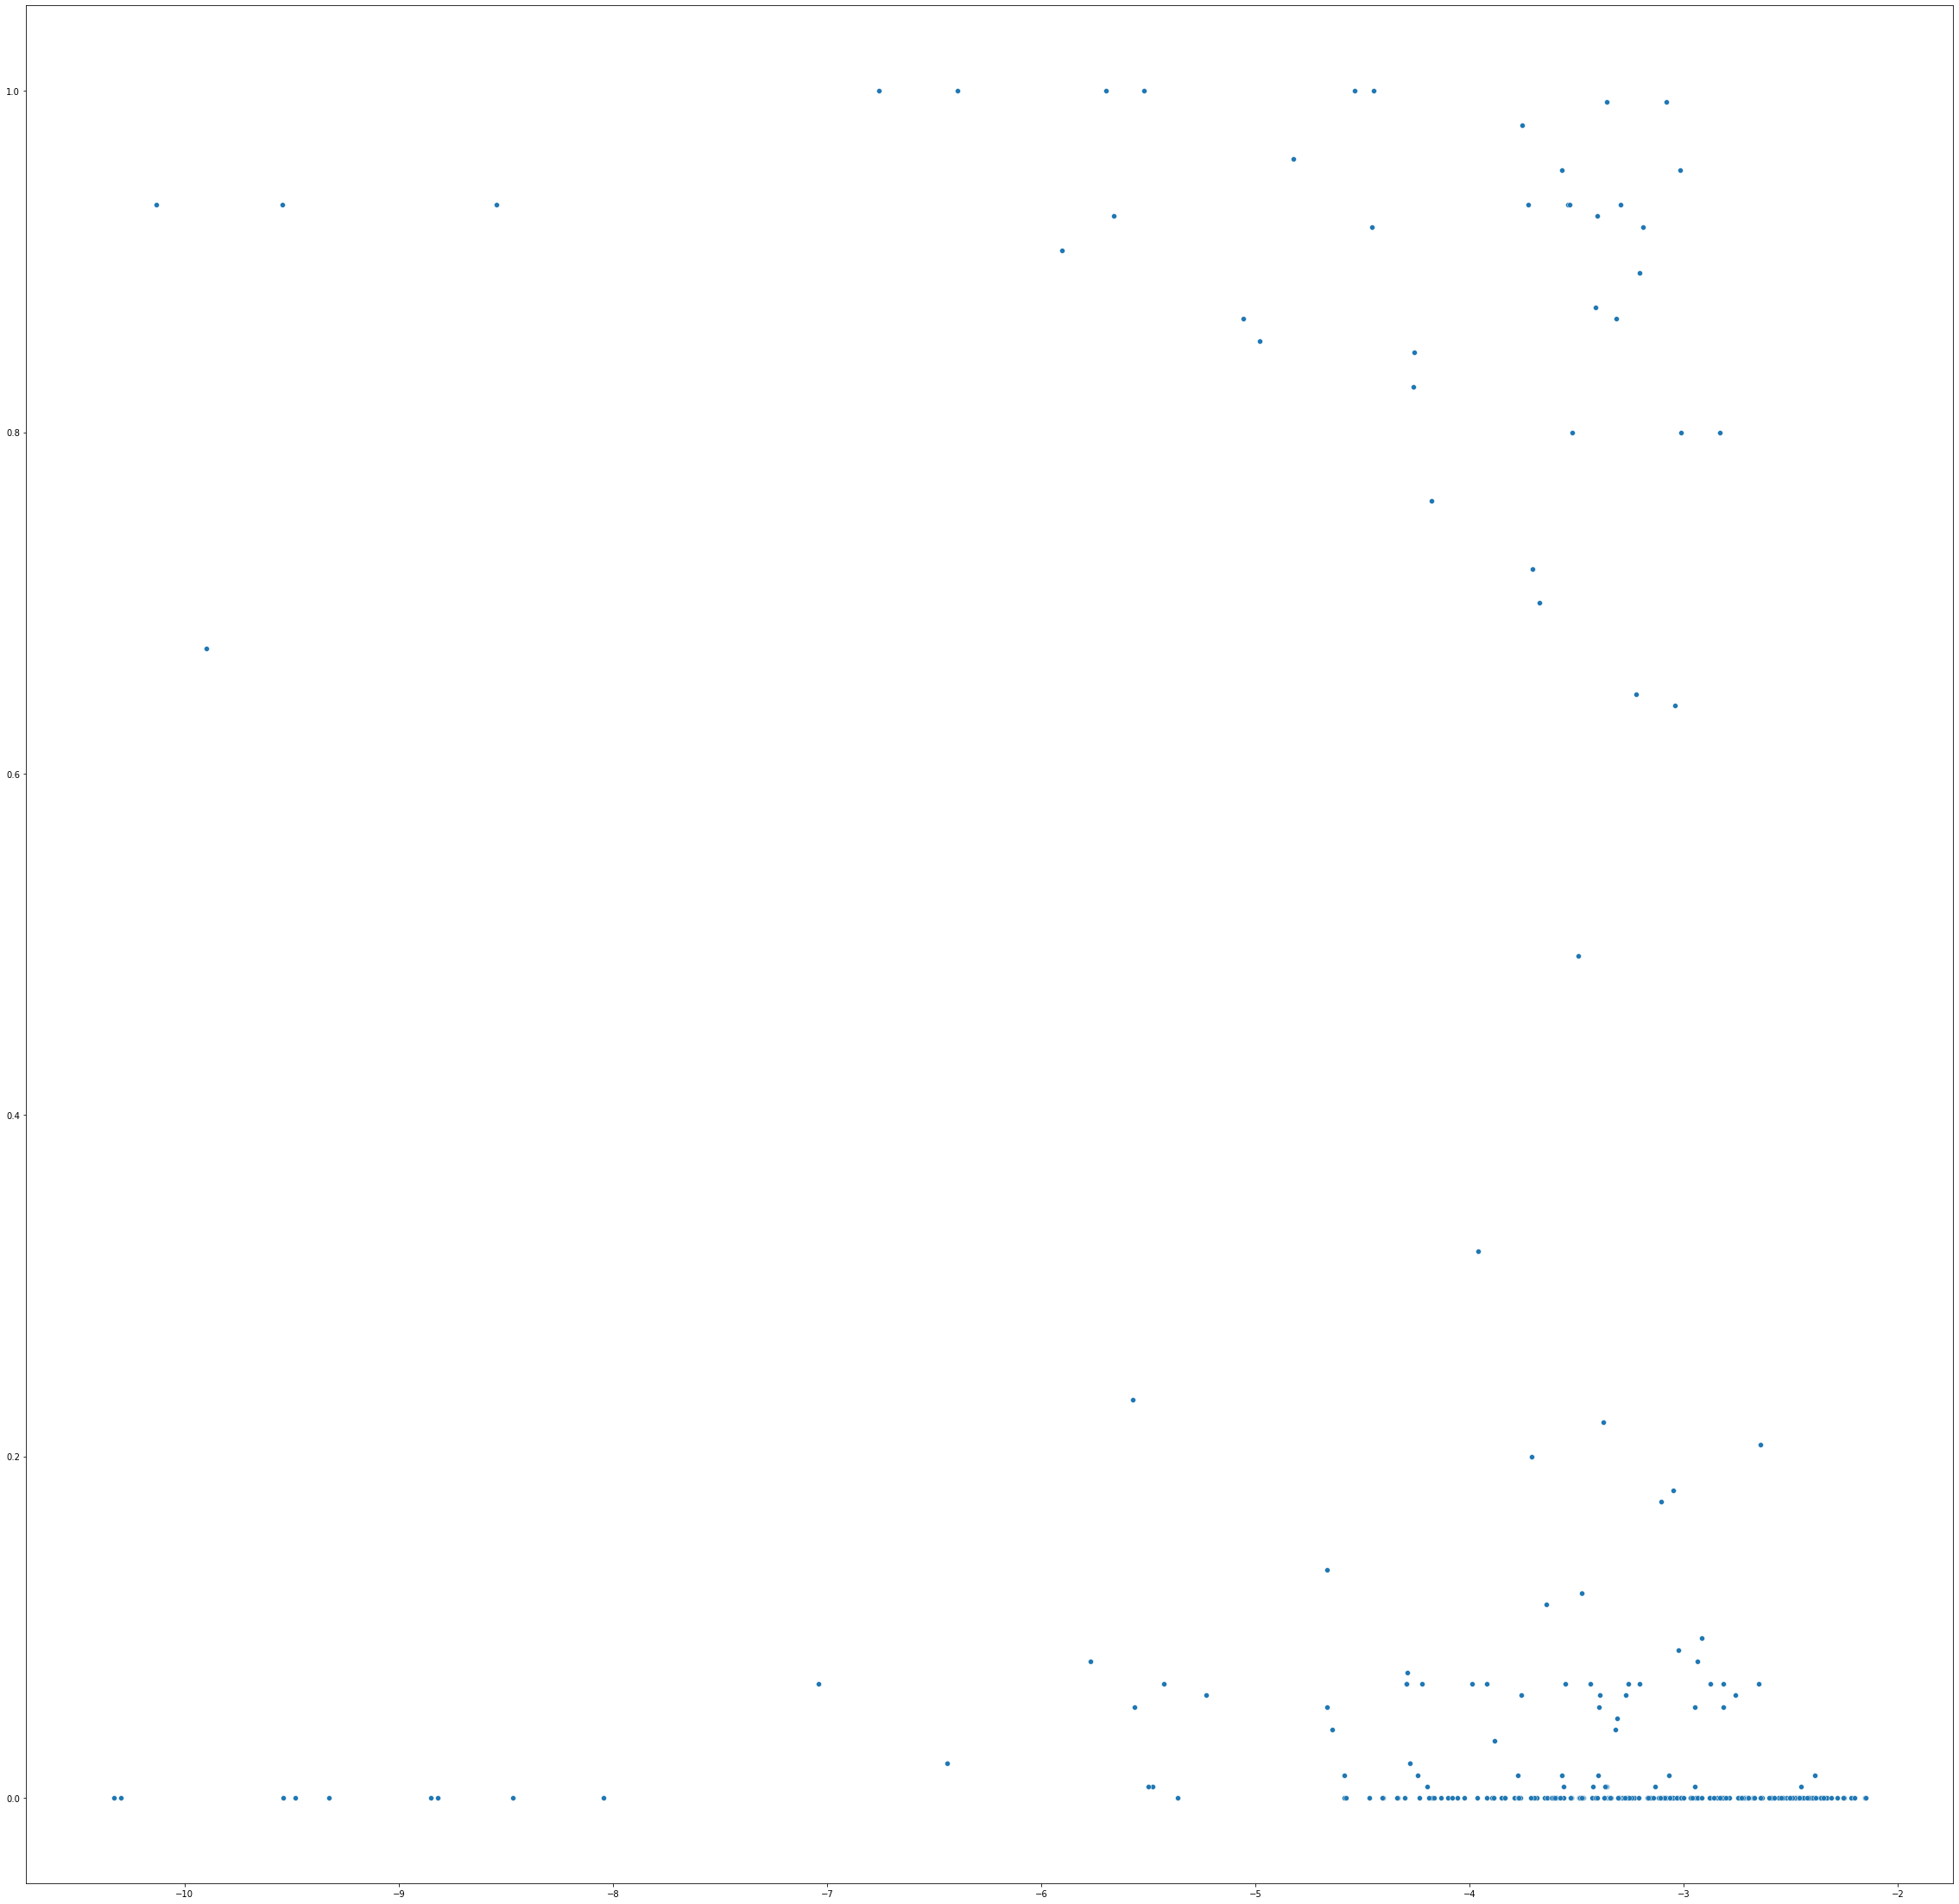

<Figure size 1980x1980 with 0 Axes>

In [202]:
y = metab_freq[count_p, :]
x = np.log10(metab_val_null[count_p, :])
plt_ = sns.scatterplot(x=x, y=y)
plt_.figure.show()
# plt_.figure.clear()

mpl.rcParams['figure.figsize'] = 40, 40

df_plot = pd.DataFrame()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit"))
y_var = []
for count_p in range(len(p_vec)):
    df_plot[f'p = {p_vec[count_p]}'] = metab_freq[count_p, :]
    y_var.append(f'p = {p_vec[count_p]}')

x_var = []
for count_p in range(len(p_vec)):
    df_plot[f'null p = {p_vec[count_p]}'] = np.log10(metab_val_null[count_p, :])
    x_var.append(f'null p = {p_vec[count_p]}')

plt_ = sns.PairGrid(df_plot, x_vars = x_var, y_vars = y_var)
plt_.map(sns.scatterplot)
plt_.map_lower(corrfunc)

for ax in plt_.axes.flatten():
#     ax.set_yticklabels(ax.get_yticklabels(), size=15)
#     ax.set_xticklabels(ax.get_xticklabels(), size = 15)
    ax.set_ylabel(ax.get_ylabel(), size = 20)
    ax.set_xlabel(ax.get_xlabel(), size = 20)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'metab_freqs_vs_null_metab_Ri.png'))
plt_.figure.tight_layout()
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt_.figure.clear()




/tmp/ipykernel_7362/1106328704.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt_.figure.show()


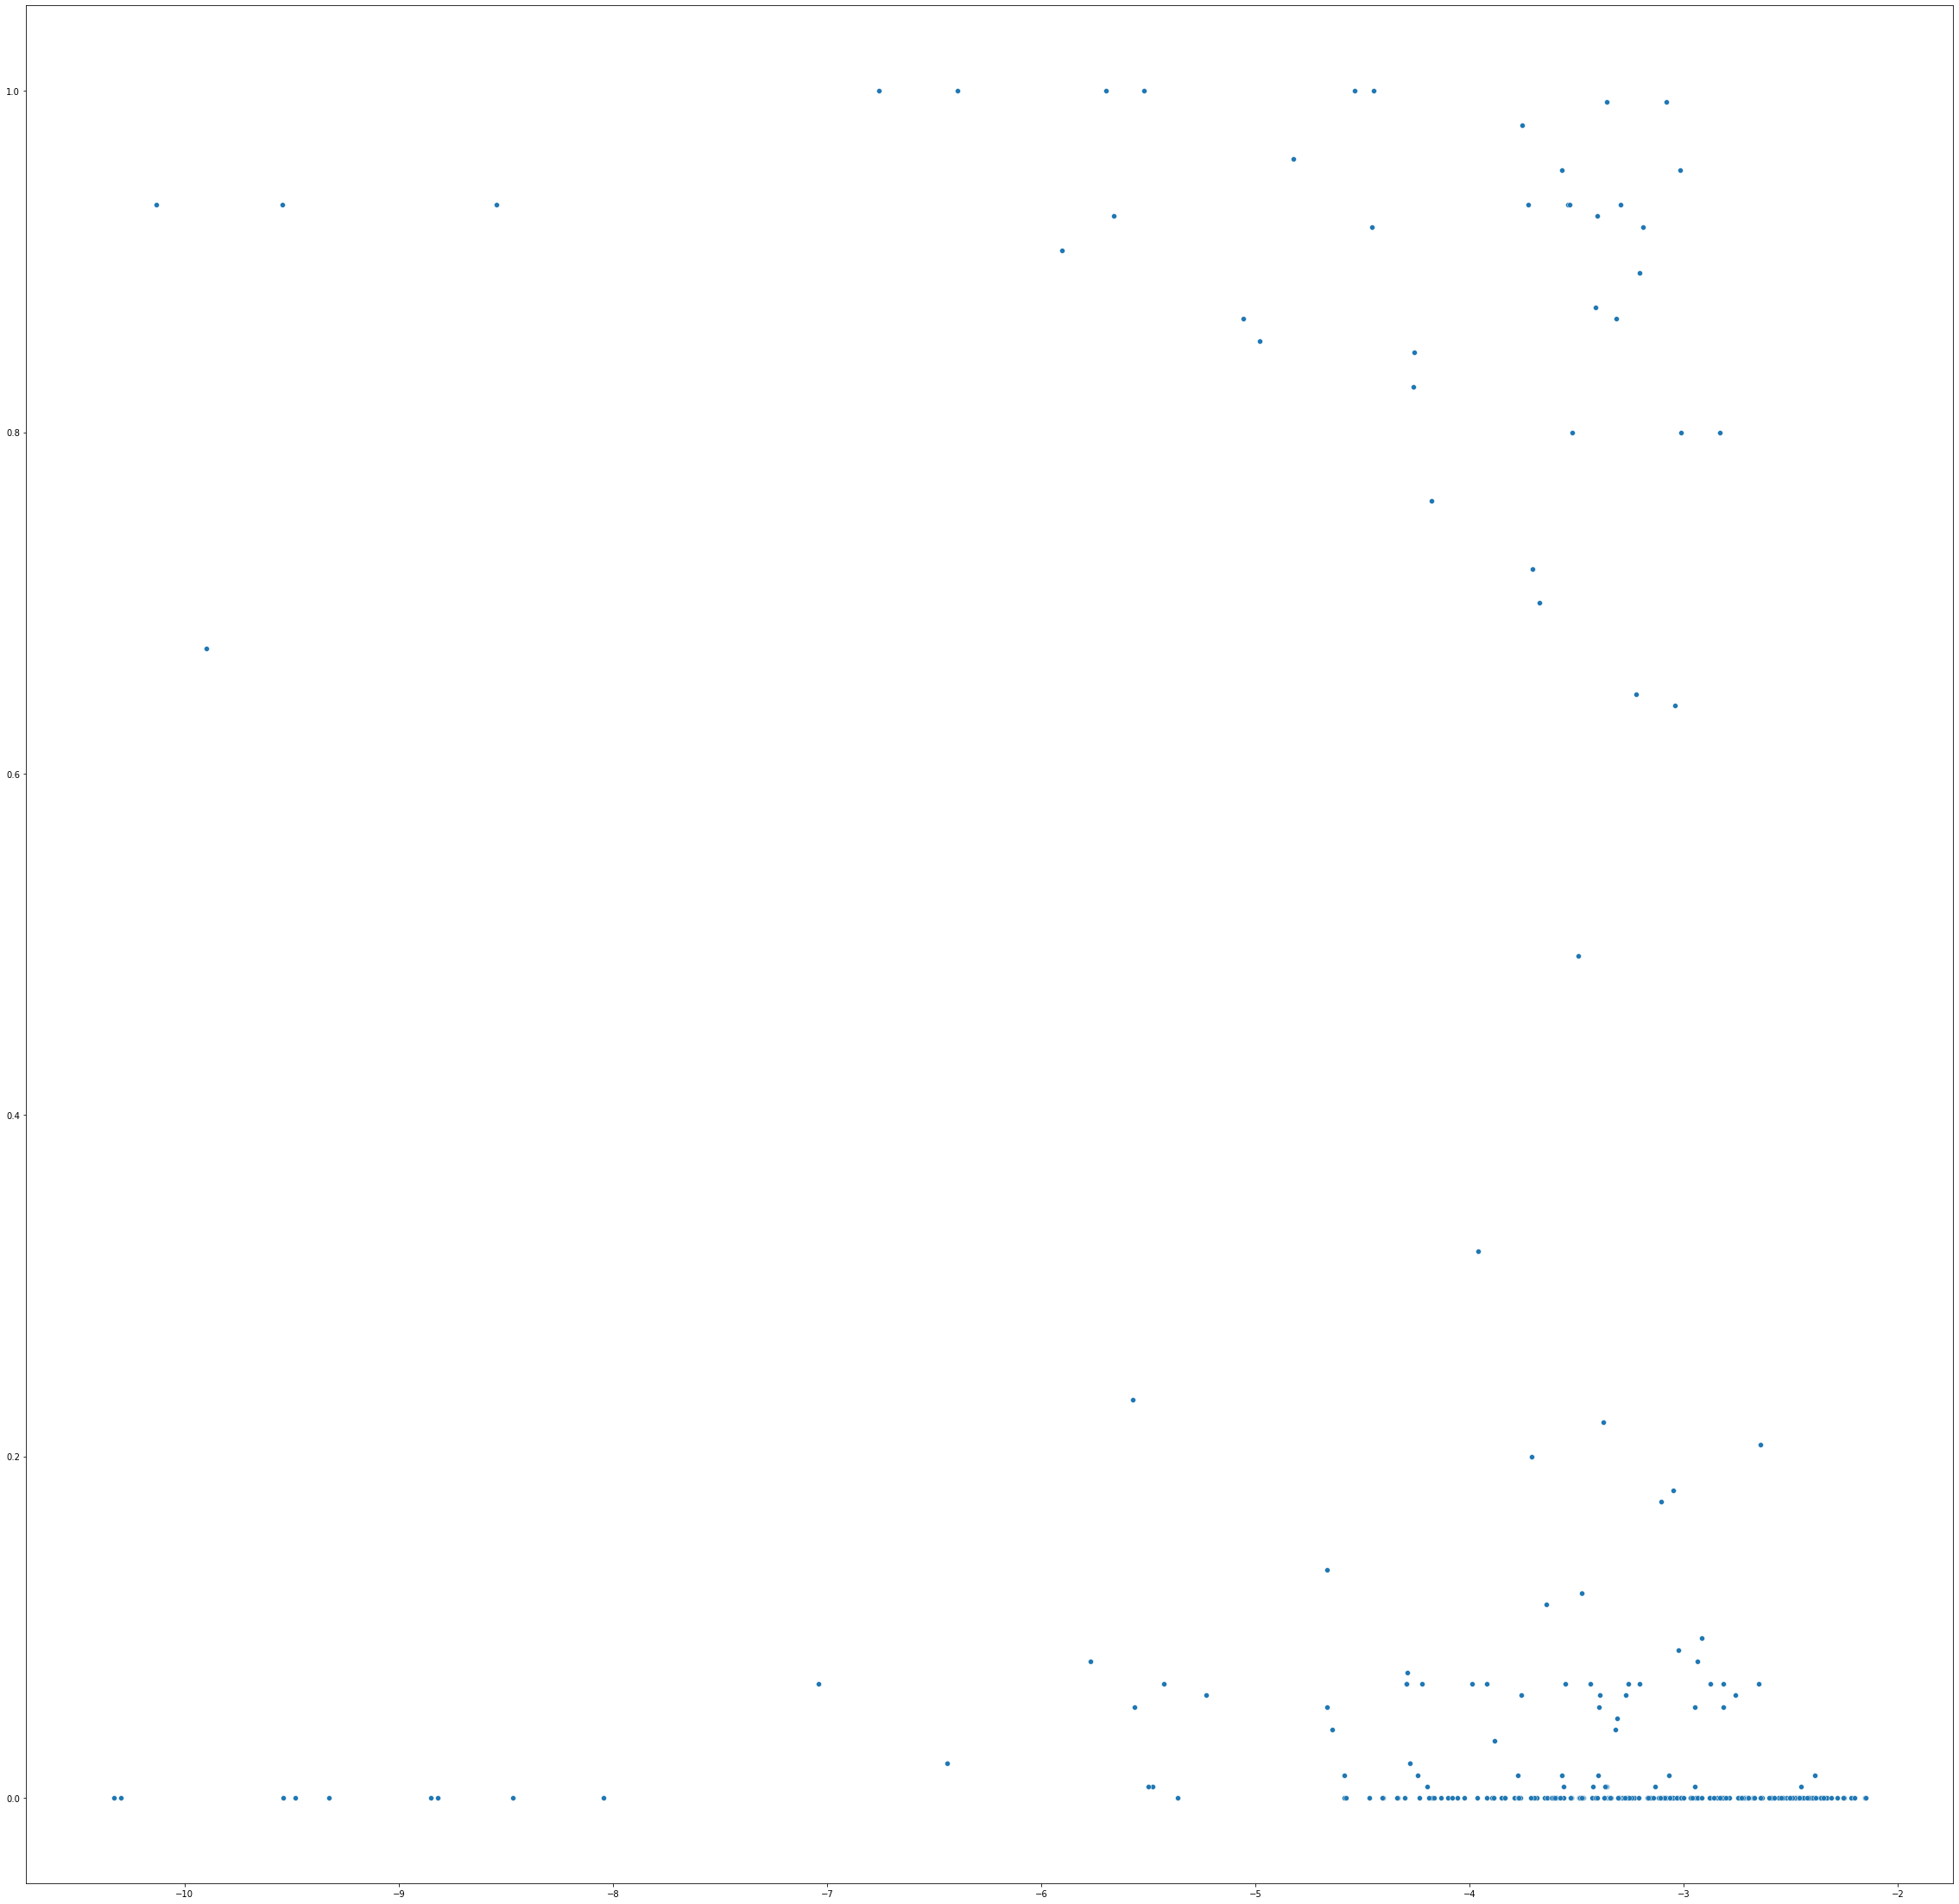

<Figure size 1980x1980 with 0 Axes>

In [205]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))

metab_rank = np.zeros((len(p_vec), num_metabs))
metab_rank_null = metab_rank.copy()

metab_val = metab_rank.copy()
metab_val_null = metab_rank_null.copy()
for count_p in range(len(p_vec)):
    count_ = 0
    for rep_ in range(num_rep_nnls):
        for fold_ in range(nfold):
            metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
            metab_rank_null[count_p, :] += get_rank(coeff_null_train_2[rep_][fold_][count_p])
            
            metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
            metab_val_null[count_p, ] += coeff_null_train_2[rep_][fold_][count_p]
#             id_nnz = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
#             freq_tmp = np.zeros((1, num_metabs))
#             freq_tmp[0, id_nnz] = 1
#             metab_freq[count_p, :] += freq_tmp[0, :]
            
#             metab_val_null[count_p, :] += coeff_null_train[rep_][fold_][count_p]
            
            count_ += 1
metab_rank /= count_
metab_rank_null /= count_

metab_val /= count_
metab_val_null /= count_


count_p = 0
# x = metab_rank_null[count_p, :]
# y = metab_rank[count_p, :]
for count_p in range(len(p_vec)):
    x = metab_val_null[count_p, :]
    y = metab_val[count_p, :]

    id_ = np.where(y != 0)[0]

    metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
    metab_names_id = metab_names[id_]
    x = np.log10(x[id_])
    y = np.log10(y[id_])

    x_rank = get_rank(x)
    y_rank = get_rank(y)

    df_plot = pd.DataFrame()
    df_plot['metabs'] = metab_names_id
    df_plot['Ri_null'] = 10**x
    df_plot['Ri_fit'] = 10**y
    df_plot['rank_Ri_null'] = get_rank(-x)
    df_plot['rank_Ri_fit'] = get_rank(-y)

    df_null = df_plot.sort_values('Ri_null', ascending=False)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metabs_rank_by_RiNull_p{p_vec[count_p]}.csv'))
    df_null.to_csv(save_file, index=False)

    df_fit = df_plot.sort_values('Ri_fit', ascending=False)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metabs_rank_by_RiFit_p{p_vec[count_p]}.csv'))
    df_fit.to_csv(save_file, index=False)

    corr_pval = scipy.stats.pearsonr(x=x_rank, y=y_rank)
    print(corr_pval)


    mpl.rcParams['figure.figsize'] = 20, 20
    # save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
    #                                         "prediction_model_Bsplit", "higher_p"))

    graph_ = sns.scatterplot(x=x_rank, y=y_rank)
    graph_.set_ylabel("null Ri", size = 20*2)
    graph_.set_xlabel("fit Ri", size = 20*2)

    for i in range(len(x)):
        graph_.text(x_rank[i], y_rank[i], metab_names_id[i], size=10)
    # graph_.set_yscale("log", base=10)
    # graph_.set_xscale("log", base=10)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)
    title_ = f'p = {p_vec[count_p]}, '\
            f'corr = {np.round(corr_pval[0], 3)}, pval = ' + \
            '{:.3e}'.format(corr_pval[1])
    graph_.set_title(title_, \
                     size=20*2)
    # graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'scatterplot_fitRi_vs_nullRi_pid{count_p}.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()y = metab_freq[count_p, :]
x = np.log10(metab_val_null[count_p, :])
plt_ = sns.scatterplot(x=x, y=y)
plt_.figure.show()
# plt_.figure.clear()

mpl.rcParams['figure.figsize'] = 40, 40

df_plot = pd.DataFrame()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit"))
y_var = []
for count_p in range(len(p_vec)):
    df_plot[f'p = {p_vec[count_p]}'] = metab_freq[count_p, :]
    y_var.append(f'p = {p_vec[count_p]}')

x_var = []
for count_p in range(len(p_vec)):
    rank_vec = get_rank(metab_val_null[count_p, :])
    
    df_plot[f'null p = {p_vec[count_p]}'] = rank_vec
    x_var.append(f'null p = {p_vec[count_p]}')

plt_ = sns.PairGrid(df_plot, x_vars = x_var, y_vars = y_var)
plt_.map(sns.scatterplot)
plt_.map_lower(corrfunc)

for ax in plt_.axes.flatten():
#     ax.set_yticklabels(ax.get_yticklabels(), size=15)
#     ax.set_xticklabels(ax.get_xticklabels(), size = 15)
    ax.set_ylabel(ax.get_ylabel(), size = 20)
    ax.set_xlabel(ax.get_xlabel(), size = 20)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'metab_freqs_vs_null_metab_rank.png'))
plt_.figure.tight_layout()
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt_.figure.clear()

In [406]:
y

0     0.000001
1     0.000001
2     0.000001
3     0.000001
25    0.000001
26    0.000001
27    0.000001
28    0.000001
29    0.000001
30    0.000001
31    0.000001
32    0.000001
33    0.000001
34    0.000001
36    0.000001
37    0.000001
38    0.000001
39    0.000001
40    0.000001
41    0.000001
42    0.000001
43    0.000001
44    0.000001
45    0.000001
46    0.000001
47    0.000001
48    0.000001
49    0.000001
50    0.000001
51    0.000001
52    0.000001
53    0.000001
54    0.000001
55    0.000001
56    0.000001
57    0.000001
58    0.000001
59    0.000001
60    0.000001
61    0.000001
62    0.000001
Name: 41, dtype: float64

0.9753163135374181
0.9291831822065084
(0.3772684559813118, 0.0010876231094058522)


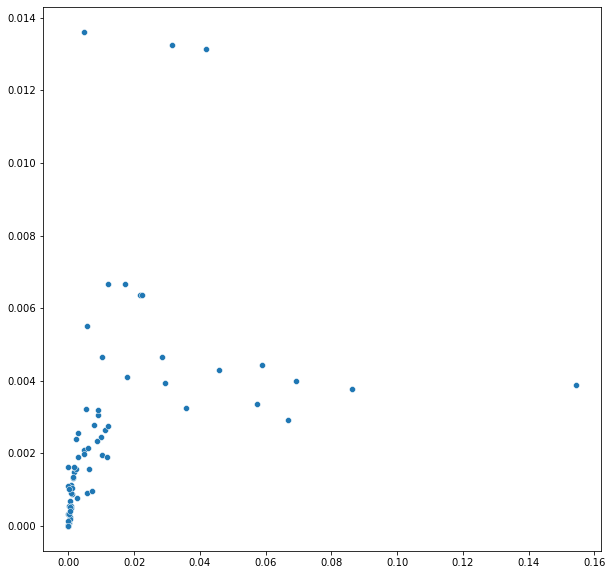

In [452]:
mpl.rcParams['figure.figsize'] = 10, 10
rep_ = 0
fold_ = 2
count_p = 0
x = coeff_train[rep_][fold_][count_p][0]
y = coeff_null_train_2[rep_][fold_][count_p]
print(x.sum())
print(y.sum())
id_ = np.where(x != 0)[0]
x = x[id_]
y = y[id_]

# count_p = 0
# x = np.array(())
# y = x.copy()
# for rep_ in range(num_rep_nnls):
#     for fold_ in range(nfold):
#         id_ = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
#         x = np.concatenate((x, np.log10(coeff_train[rep_][fold_][count_p][0][id_])))
#         y = np.concatenate((y, np.log10(coeff_null_train_2[rep_][fold_][count_p][id_])))

# id_ = np.where(x != 0)[0]
# x = x[id_]
# y = y[id_]
print(scipy.stats.pearsonr(x, y))
plt_ = sns.scatterplot(x=x, y=y)

# print(x)

SpearmanrResult(correlation=0.43645207517366585, pvalue=2.561501406073179e-11)
(0.7064783090832153, 1.62493201561459e-33)


/tmp/ipykernel_6952/2368111997.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/2368111997.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


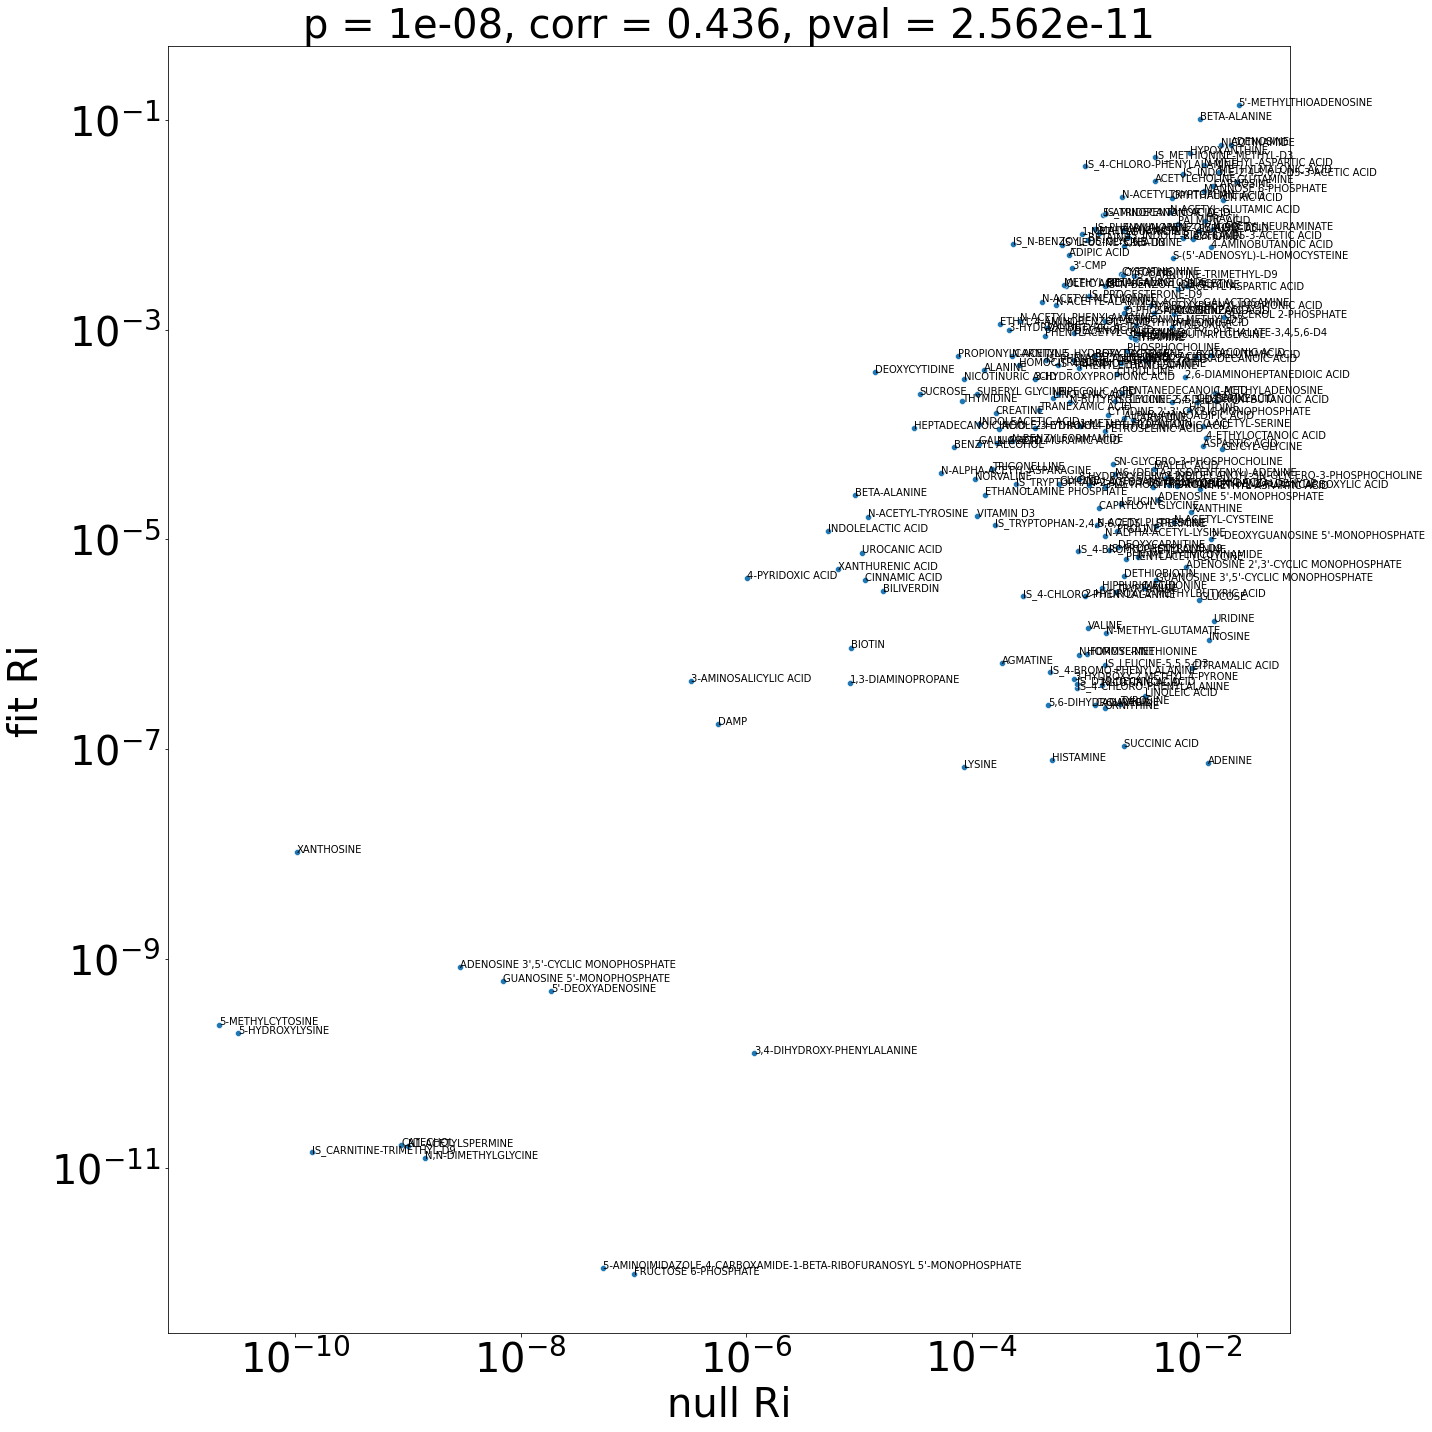

In [52]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))

metab_rank = np.zeros((len(p_vec), num_metabs))
metab_rank_null = metab_rank.copy()

metab_val = metab_rank.copy()
metab_val_null = metab_rank_null.copy()
for count_p in range(len(p_vec)):
    count_ = 0
    for rep_ in range(num_rep_nnls):
        for fold_ in range(nfold):
            metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
#             metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p])
            metab_rank_null[count_p, :] += get_rank(coeff_null_train[rep_][fold_][count_p])
            
            metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
#             metab_val[count_p, ] += np.exp(-coeff_train[rep_][fold_][count_p])
            metab_val_null[count_p, ] += coeff_null_train_2[rep_][fold_][count_p]
#             id_nnz = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
#             freq_tmp = np.zeros((1, num_metabs))
#             freq_tmp[0, id_nnz] = 1
#             metab_freq[count_p, :] += freq_tmp[0, :]
            
#             metab_val_null[count_p, :] += coeff_null_train[rep_][fold_][count_p]
            
            count_ += 1
metab_rank /= count_
metab_rank_null /= count_

metab_val /= count_
metab_val_null /= count_

mpl.rcParams['figure.figsize'] = 40, 40
count_p = 0
# x = metab_rank_null[count_p, :]
# y = metab_rank[count_p, :]
# metab_val_null[0, ] = R_i_0
for count_p in range(1):
    x = metab_val_null[count_p, :]
    y = metab_val[count_p, :]

    id_ = np.where(y != 0)[0]

    metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
    metab_names_id = metab_names[id_]
    x = np.log10(x[id_])
    y = np.log10(y[id_])

#     x_rank = get_rank(x)
#     y_rank = get_rank(y)
    x_rank = 10**x
    y_rank = 10**y

    df_plot = pd.DataFrame()
    df_plot['metabs'] = metab_names_id
    df_plot['Ri_null'] = 10**x
    df_plot['Ri_fit'] = 10**y
    df_plot['rank_Ri_null'] = get_rank(-x)
    df_plot['rank_Ri_fit'] = get_rank(-y)

    df_null = df_plot.sort_values('Ri_null', ascending=False)

#     save_file = os.path.abspath(os.path.join(save_dir, 
#                                              f'metabs_rank_by_RiNull_p{p_vec[count_p]}.csv'))
#     df_null.to_csv(save_file, index=False)

#     df_fit = df_plot.sort_values('Ri_fit', ascending=False)

#     save_file = os.path.abspath(os.path.join(save_dir, 
#                                              f'metabs_rank_by_RiFit_p{p_vec[count_p]}.csv'))
#     df_fit.to_csv(save_file, index=False)

    corr_pval = scipy.stats.spearmanr(x_rank, y_rank)
    print(corr_pval)
    print(scipy.stats.pearsonr(np.log10(x_rank), np.log10(y_rank)))


    mpl.rcParams['figure.figsize'] = 20, 20
    # save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
    #                                         "prediction_model_Bsplit", "higher_p"))

#     x_rank = get_rank(x)
#     y_rank = get_rank(y)
    graph_ = sns.scatterplot(x=x_rank, y=y_rank)
    graph_.set_xlabel("null Ri", size = 20*2)
    graph_.set_ylabel("fit Ri", size = 20*2)

    for i in range(len(x)):
        graph_.text(x_rank[i], y_rank[i], metab_names_id[i], size=10)
    graph_.set_yscale("log", base=10)
    graph_.set_xscale("log", base=10)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)
    title_ = f'p = {p_vec[count_p]}, '\
            f'corr = {np.round(corr_pval[0], 3)}, pval = ' + \
            '{:.3e}'.format(corr_pval[1])
    graph_.set_title(title_, \
                     size=20*2)
    # graph_.legend(fontsize=20, title="p", title_fontsize=20)

#     save_file = os.path.abspath(os.path.join(save_dir, 
#                                              f'scatterplot_fitRi_vs_nullRi_pid{count_p}.png'))
    graph_.figure.tight_layout()
#     graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
#     graph_.figure.clear()

In [252]:
x = metab_val_null[count_p, :]
y = metab_val[count_p, :]
scipy.stats.pearsonr(x, y)
print(scipy.stats.spearmanr(np.log10(x), np.log10(y)))

SpearmanrResult(correlation=0.042330748101080964, pvalue=0.47117500712949856)


In [253]:
id_order = np.argsort(-metab_val[count_p, :])
metab_names[id_order]
# df_metabNames.iloc[:, 1].values[15]

array(["5'-METHYLTHIOADENOSINE", 'BETA-ALANINE', 'ADENOSINE',
       'NICOTINAMIDE', 'HYPOXANTHINE', 'IS_METHIONINE-METHYL-D3',
       'N-METHYL-ASPARTIC ACID', 'IS_4-CHLORO-PHENYLALANINE',
       'METHYLMALONIC ACID', 'IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID',
       'ACETYLCHOLINE', 'GLUTAMINE', 'CARNOSINE', 'MANNOSE 6-PHOSPHATE',
       'N-ACETYLTRYPTOPHAN', 'OPHTHALMIC ACID', 'CITRIC ACID',
       'N-ACETYL-GLUTAMIC ACID', 'IS_TRIDECANOIC ACID',
       '5-AMINOPENTANOIC ACID', 'URACIL', 'PALMITIC ACID',
       'N-ACETYLNEURAMINATE', 'IS_PHENYLALANINE-2,3,4,5,6-D5',
       'PYRUVIC ACID', '4-AMINOBENZOIC ACID', 'MALEAMIC ACID',
       '1-METHYLGUANIDINE', 'IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID',
       'RIBOFLAVIN', 'CYTIDINE', 'BETAINE', 'IS_N-BENZOYL-D5-GLYCINE',
       'CREATININE', 'IS_LEUCINE-5,5,5-D3', '4-AMINOBUTANOIC ACID',
       'ADIPIC ACID', "S-(5'-ADENOSYL)-L-HOMOCYSTEINE", "3'-CMP",
       'CYSTATHIONINE', 'CYTOSINE', 'IS_CARNITINE-TRIMETHYL-D9',
       'SPHINGANINE', 'IS_

In [254]:
id_order = np.argsort(-metab_val_null[count_p, :])
metab_names[id_order]
# df_metabNames.iloc[:, 1].values[15]

array(["5'-METHYLTHIOADENOSINE", 'GLUTAMINE', 'ADENOSINE', 'ASPARAGINE',
       'GLYCEROL 2-PHOSPHATE', '3-UREIDOPROPIONATE', 'CITRIC ACID',
       'GLYCYL-GLYCINE', 'NICOTINAMIDE', 'METHYLMALONIC ACID', 'ASP-PHE',
       'SERINE', '1-METHYLADENOSINE', 'THREONINE', 'URIDINE',
       'N-ACETYLNEURAMINATE', 'CARNOSINE', 'CINNAMALDEHYDE',
       "2'-DEOXYGUANOSINE 5'-MONOPHOSPHATE", '4-AMINOBUTANOIC ACID',
       'ITACONIC ACID', 'INOSINE',
       '1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID', 'GLYCERIC ACID',
       'ADENINE', '4-ETHYLOCTANOIC ACID', 'URACIL', 'MANNOSE 6-PHOSPHATE',
       'N-METHYL-ASPARTIC ACID', 'ASPARTIC ACID', 'O-ACETYL-SERINE',
       'GUANOSINE', 'BETA-ALANINE', 'N-METHYL-ASPARTIC ACID', 'GLUCOSE',
       'PYRUVIC ACID', 'GLUTAMIC ACID', 'THREONINE', 'PYROGLUTAMIC ACID',
       '4-METHYLVALERIC ACID', 'CYTIDINE', 'CITRAMALIC ACID', 'XANTHINE',
       'HYPOXANTHINE', 'HISTIDINE', 'DIACETYL', 'SPERMIDINE',
       'AMINO(4-HYDROXYCYCLOHEXYL)ACETIC ACID',
       "ADENOSINE 

In [54]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))

metab_rank = np.zeros((len(p_vec), num_metabs))
metab_rank_null = metab_rank.copy()

metab_val = metab_rank.copy()
metab_val_null = metab_rank_null.copy()
for count_p in range(len(p_vec)):
    count_ = 0
    for rep_ in range(num_rep_nnls):
        for fold_ in range(nfold):
            metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
            metab_rank_null[count_p, :] += get_rank(coeff_null_train[rep_][fold_][count_p])
            
            metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
            metab_val_null[count_p, ] += coeff_null_train_2[rep_][fold_][count_p]
#             id_nnz = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
#             freq_tmp = np.zeros((1, num_metabs))
#             freq_tmp[0, id_nnz] = 1
#             metab_freq[count_p, :] += freq_tmp[0, :]
            
#             metab_val_null[count_p, :] += coeff_null_train[rep_][fold_][count_p]
            
            count_ += 1
metab_rank /= count_
metab_rank_null /= count_

metab_val /= count_
metab_val_null /= count_


count_p = 0
# x = metab_rank_null[count_p, :]
# y = metab_rank[count_p, :]
# metab_val_null[0, ] = R_i_0
for count_p in range(len(p_vec)):
    x = metab_val_null[count_p, :]
    y = metab_val[count_p, :]

    id_ = np.where(y != 0)[0]

    metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]

#     x_rank = get_rank(x)
#     y_rank = get_rank(y)


    df_plot = pd.DataFrame()
    df_plot['metabs'] = metab_names
    df_plot['metabs_id_masterList'] = df_metabIds.iloc[:, 0].values
    df_plot['Ri_null'] = x
    df_plot['Ri_fit'] = y
    df_plot['rank_Ri_null'] = get_rank(-x)
    df_plot['rank_Ri_fit'] = get_rank(-y)

    df_null = df_plot.sort_values('Ri_null', ascending=False)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metabs_rank_by_RiNull_p{p_vec[count_p]}_reps_{num_rep_nnls}.csv'))
    df_null.to_csv(save_file, index=False)

    df_fit = df_plot.sort_values('Ri_fit', ascending=False)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metabs_rank_by_RiFit_p{p_vec[count_p]}_reps_{num_rep_nnls}.csv'))
    df_fit.to_csv(save_file, index=False)
    
    metab_names_id = metab_names[id_]
    x = np.log10(x[id_])
    y = np.log10(y[id_])
    x_rank = 10**x
    y_rank = 10**y

    corr_pval = scipy.stats.spearmanr(x_rank, y_rank)
    print(corr_pval)
    print(scipy.stats.pearsonr(np.log10(x_rank), np.log10(y_rank)))
    corr_pval = scipy.stats.pearsonr(np.log10(x_rank), np.log10(y_rank))


    mpl.rcParams['figure.figsize'] = 20, 20
    # save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
    #                                         "prediction_model_Bsplit", "higher_p"))

    graph_ = sns.scatterplot(x=x_rank, y=y_rank)
    graph_.set_xlabel("null Ri", size = 20*2)
    graph_.set_ylabel("fit Ri", size = 20*2)

    for i in range(len(x)):
        graph_.text(x_rank[i], y_rank[i], metab_names_id[i], size=10)
    graph_.plot([1e-11, 1e-1], [1e-11, 1e-1], c="red")
    graph_.set_yscale("log", base=10)
    graph_.set_xscale("log", base=10)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)
    title_ = f'p = {p_vec[count_p]}, '\
            f'corr = {np.round(corr_pval[0], 3)}, pval = ' + \
            '{:.3e}'.format(corr_pval[1])
    graph_.set_title(title_, \
                     size=20*2)
    # graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'scatterplot_fitRi_vs_nullRi_pid{count_p}_reps_{num_rep_nnls}.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()

SpearmanrResult(correlation=0.43645207517366585, pvalue=2.561501406073179e-11)
(0.7064783090832153, 1.62493201561459e-33)


/tmp/ipykernel_6952/370824233.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/370824233.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


SpearmanrResult(correlation=0.4364620095817365, pvalue=2.5585524776390792e-11)
(0.7071725707932417, 1.3199339410207428e-33)


/tmp/ipykernel_6952/370824233.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/370824233.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


SpearmanrResult(correlation=0.4363949523272593, pvalue=2.578521954033415e-11)
(0.7063621746618556, 1.682332200064848e-33)


/tmp/ipykernel_6952/370824233.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/370824233.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


SpearmanrResult(correlation=0.4161711753126287, pvalue=2.747196942884705e-10)
(0.6931784362572121, 1.08164456249675e-31)


/tmp/ipykernel_6952/370824233.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/370824233.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


SpearmanrResult(correlation=0.40377385772122615, pvalue=1.341223497024584e-09)
(0.6922651760800678, 3.7470723080092913e-31)


/tmp/ipykernel_6952/370824233.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/370824233.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


SpearmanrResult(correlation=0.40584171565649807, pvalue=1.4310800988070625e-09)
(0.6066929367648645, 4.244908638104133e-22)


/tmp/ipykernel_6952/370824233.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/370824233.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


SpearmanrResult(correlation=0.3974583914654942, pvalue=1.2542255990728157e-09)
(0.6000063630091871, 1.3102727057143839e-22)


/tmp/ipykernel_6952/370824233.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/370824233.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


SpearmanrResult(correlation=0.2736709461332131, pvalue=4.380676857478981e-05)
(0.45702956871027983, 1.3467357249817222e-12)


/tmp/ipykernel_6952/370824233.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/370824233.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


SpearmanrResult(correlation=0.35210541711356574, pvalue=2.251022117858319e-07)
(0.5342071516817254, 1.5980523834102467e-16)


/tmp/ipykernel_6952/370824233.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/370824233.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


SpearmanrResult(correlation=0.1901679332019889, pvalue=0.01854840795711737)
(0.4603109965758795, 2.1436574415378894e-09)


/tmp/ipykernel_6952/370824233.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/370824233.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


SpearmanrResult(correlation=0.27689331944651097, pvalue=0.0008503240855573836)
(0.5743613476772201, 7.817917011459573e-14)


/tmp/ipykernel_6952/370824233.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_6952/370824233.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


<Figure size 1440x1440 with 0 Axes>

In [585]:
scipy.stats.pearsonr(np.log10(metab_val_null[0, :]), np.log10(R_i_0))

(0.9856104711191874, 6.137746117735455e-226)

In [587]:
id_order = np.argsort(-R_i_0)
metab_names[id_order]

array(['GLUTAMINE', "5'-METHYLTHIOADENOSINE", 'ADENOSINE', 'ASPARAGINE',
       '3-UREIDOPROPIONATE', 'CITRIC ACID', 'GLYCEROL 2-PHOSPHATE',
       'GLYCYL-GLYCINE', 'METHYLMALONIC ACID', 'NICOTINAMIDE', 'URIDINE',
       'ASP-PHE', 'N-ACETYLNEURAMINATE', 'CARNOSINE', 'SERINE',
       '1-METHYLADENOSINE', "2'-DEOXYGUANOSINE 5'-MONOPHOSPHATE",
       'THREONINE', '4-AMINOBUTANOIC ACID', 'ITACONIC ACID',
       'CINNAMALDEHYDE', 'INOSINE', 'GLYCERIC ACID',
       '1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID', 'MANNOSE 6-PHOSPHATE',
       'ASPARTIC ACID', '4-ETHYLOCTANOIC ACID', 'N-METHYL-ASPARTIC ACID',
       'ADENINE', 'O-ACETYL-SERINE', 'GUANOSINE', 'GLUCOSE', 'URACIL',
       'N-METHYL-ASPARTIC ACID', 'BETA-ALANINE', 'PYRUVIC ACID',
       'GLUTAMIC ACID', '4-METHYLVALERIC ACID', 'CYTIDINE',
       'CITRAMALIC ACID', 'PYROGLUTAMIC ACID', 'THREONINE',
       'HYPOXANTHINE', "ADENOSINE 2',3'-CYCLIC MONOPHOSPHATE", 'XANTHINE',
       'HISTIDINE', 'DIACETYL', 'AMINO(4-HYDROXYCYCLOHEXYL)ACETIC

In [581]:
id_order = np.argsort(-metab_val_null[0, :])
metab_names[id_order]

array(["5'-METHYLTHIOADENOSINE", 'GLUTAMINE', 'ADENOSINE', 'ASPARAGINE',
       'GLYCEROL 2-PHOSPHATE', '3-UREIDOPROPIONATE', 'CITRIC ACID',
       'GLYCYL-GLYCINE', 'NICOTINAMIDE', 'METHYLMALONIC ACID', 'ASP-PHE',
       'SERINE', '1-METHYLADENOSINE', 'THREONINE', 'URIDINE',
       'N-ACETYLNEURAMINATE', 'CARNOSINE', 'CINNAMALDEHYDE',
       "2'-DEOXYGUANOSINE 5'-MONOPHOSPHATE", '4-AMINOBUTANOIC ACID',
       'ITACONIC ACID', 'INOSINE',
       '1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID', 'GLYCERIC ACID',
       'ADENINE', '4-ETHYLOCTANOIC ACID', 'URACIL', 'MANNOSE 6-PHOSPHATE',
       'N-METHYL-ASPARTIC ACID', 'ASPARTIC ACID', 'O-ACETYL-SERINE',
       'GUANOSINE', 'BETA-ALANINE', 'N-METHYL-ASPARTIC ACID', 'GLUCOSE',
       'PYRUVIC ACID', 'GLUTAMIC ACID', 'THREONINE', 'PYROGLUTAMIC ACID',
       '4-METHYLVALERIC ACID', 'CYTIDINE', 'CITRAMALIC ACID', 'XANTHINE',
       'HYPOXANTHINE', 'HISTIDINE', 'DIACETYL', 'SPERMIDINE',
       'AMINO(4-HYDROXYCYCLOHEXYL)ACETIC ACID',
       "ADENOSINE 

In [503]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))

metab_rank = np.zeros((len(p_vec), num_metabs))
metab_rank_null = metab_rank.copy()

metab_val = metab_rank.copy()
metab_val_null = metab_rank_null.copy()
for count_p in range(len(p_vec)):
    count_ = 0
    for rep_ in range(num_rep_nnls):
        for fold_ in range(nfold):
            metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
            metab_rank_null[count_p, :] += get_rank(coeff_null_train_2[rep_][fold_][count_p])
            
            metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
            metab_val_null[count_p, ] += coeff_null_train_2[rep_][fold_][count_p]
#             id_nnz = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
#             freq_tmp = np.zeros((1, num_metabs))
#             freq_tmp[0, id_nnz] = 1
#             metab_freq[count_p, :] += freq_tmp[0, :]
            
#             metab_val_null[count_p, :] += coeff_null_train[rep_][fold_][count_p]
            
            count_ += 1
metab_rank /= count_
metab_rank_null /= count_

metab_val /= count_
metab_val_null /= count_


count_p = 0
# x = metab_rank_null[count_p, :]
# y = metab_rank[count_p, :]
for count_p in range(len(p_vec)):
    x = metab_val_null[count_p, :]
    y = metab_val[count_p, :]

    id_ = np.where(y != 0)[0]

    metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
    metab_names_id = metab_names[id_]
    x = np.log10(x[id_])
    y = np.log10(y[id_])

    x_rank = get_rank(x)
    y_rank = get_rank(y)

    df_plot = pd.DataFrame()
    df_plot['metabs'] = metab_names_id
    df_plot['Ri_null'] = 10**x
    df_plot['Ri_fit'] = 10**y
    df_plot['rank_Ri_null'] = get_rank(-x)
    df_plot['rank_Ri_fit'] = get_rank(-y)

    df_null = df_plot.sort_values('Ri_null', ascending=False)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metabs_rank_by_RiNull_p{p_vec[count_p]}.csv'))
    df_null.to_csv(save_file, index=False)

    df_fit = df_plot.sort_values('Ri_fit', ascending=False)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metabs_rank_by_RiFit_p{p_vec[count_p]}.csv'))
    df_fit.to_csv(save_file, index=False)

    corr_pval = scipy.stats.pearsonr(x=x_rank, y=y_rank)
    print(corr_pval)


    mpl.rcParams['figure.figsize'] = 20, 20
    # save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
    #                                         "prediction_model_Bsplit", "higher_p"))

    graph_ = sns.scatterplot(x=x_rank, y=y_rank)
    graph_.set_ylabel("null Ri", size = 20*2)
    graph_.set_xlabel("fit Ri", size = 20*2)

    for i in range(len(x)):
        graph_.text(x_rank[i], y_rank[i], metab_names_id[i], size=10)
    # graph_.set_yscale("log", base=10)
    # graph_.set_xscale("log", base=10)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)
    title_ = f'p = {p_vec[count_p]}, '\
            f'corr = {np.round(corr_pval[0], 3)}, pval = ' + \
            '{:.3e}'.format(corr_pval[1])
    graph_.set_title(title_, \
                     size=20*2)
    # graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'scatterplot_fitRi_vs_nullRi_pid{count_p}.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()

(0.6632832893848691, 1.1734528084755687e-22)


/tmp/ipykernel_7362/9769795.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/9769795.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.6632832893848692, 1.173452808475536e-22)


/tmp/ipykernel_7362/9769795.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/9769795.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.6628280885243858, 1.2840655020172584e-22)


/tmp/ipykernel_7362/9769795.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/9769795.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.6702257051950331, 7.188426393649867e-23)


/tmp/ipykernel_7362/9769795.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/9769795.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.6675422168296797, 7.325416432718144e-22)


/tmp/ipykernel_7362/9769795.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/9769795.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.581492882202288, 7.465440079866472e-16)


/tmp/ipykernel_7362/9769795.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/9769795.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.5199373577256363, 8.259701658927224e-13)


/tmp/ipykernel_7362/9769795.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/9769795.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.5050929683919779, 2.7732942760027095e-11)


/tmp/ipykernel_7362/9769795.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/9769795.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.5752751762672782, 3.267673767934698e-15)


/tmp/ipykernel_7362/9769795.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/9769795.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.571709193208401, 3.74708310342418e-11)


/tmp/ipykernel_7362/9769795.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/9769795.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.6938856410794629, 3.1919508891829538e-16)


/tmp/ipykernel_7362/9769795.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/9769795.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


<Figure size 1440x1440 with 0 Axes>

In [504]:
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))

metab_rank = np.zeros((len(p_vec), num_metabs))
metab_rank_null = metab_rank.copy()

metab_val = metab_rank.copy()
metab_val_null = metab_rank_null.copy()
for count_p in range(len(p_vec)):
    count_ = 0
    for rep_ in range(num_rep_nnls):
        for fold_ in range(nfold):
            metab_rank[count_p, :] += get_rank(coeff_train[rep_][fold_][count_p][0])
            metab_rank_null[count_p, :] += get_rank(coeff_null_train[rep_][fold_][count_p])
            
            metab_val[count_p, ] += coeff_train[rep_][fold_][count_p][0]
            metab_val_null[count_p, ] += coeff_null_train[rep_][fold_][count_p]
#             id_nnz = np.where(coeff_train[rep_][fold_][count_p][0] != 0)[0]
#             freq_tmp = np.zeros((1, num_metabs))
#             freq_tmp[0, id_nnz] = 1
#             metab_freq[count_p, :] += freq_tmp[0, :]
            
#             metab_val_null[count_p, :] += coeff_null_train[rep_][fold_][count_p]
            
            count_ += 1
metab_rank /= count_
metab_rank_null /= count_

metab_val /= count_
metab_val_null /= count_


count_p = 0
# x = metab_rank_null[count_p, :]
# y = metab_rank[count_p, :]
for count_p in range(len(p_vec)):
    x = metab_val_null[count_p, :]
    y = metab_val[count_p, :]

    id_ = np.where(y != 0)[0]

    metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
    metab_names_id = metab_names[id_]
    x = np.log10(x[id_])
    y = np.log10(y[id_])

    x_rank = get_rank(x)
    y_rank = get_rank(y)

    df_plot = pd.DataFrame()
    df_plot['metabs'] = metab_names_id
    df_plot['Ri_null'] = 10**x
    df_plot['Ri_fit'] = 10**y
    df_plot['rank_Ri_null'] = get_rank(-x)
    df_plot['rank_Ri_fit'] = get_rank(-y)

    df_null = df_plot.sort_values('Ri_null', ascending=False)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metabs_rank_by_RiNull_p{p_vec[count_p]}_nullFull.csv'))
    df_null.to_csv(save_file, index=False)

    df_fit = df_plot.sort_values('Ri_fit', ascending=False)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metabs_rank_by_RiFit_p{p_vec[count_p]}_nullFull.csv'))
    df_fit.to_csv(save_file, index=False)

    corr_pval = scipy.stats.pearsonr(x=x_rank, y=y_rank)
    print(corr_pval)


    mpl.rcParams['figure.figsize'] = 20, 20
    # save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
    #                                         "prediction_model_Bsplit", "higher_p"))

    graph_ = sns.scatterplot(x=x_rank, y=y_rank)
    graph_.set_ylabel("null Ri", size = 20*2)
    graph_.set_xlabel("fit Ri", size = 20*2)

    for i in range(len(x)):
        graph_.text(x_rank[i], y_rank[i], metab_names_id[i], size=10)
    # graph_.set_yscale("log", base=10)
    # graph_.set_xscale("log", base=10)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)
    title_ = f'p = {p_vec[count_p]}, '\
            f'corr = {np.round(corr_pval[0], 3)}, pval = ' + \
            '{:.3e}'.format(corr_pval[1])
    graph_.set_title(title_, \
                     size=20*2)
    # graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'scatterplot_fitRi_vs_nullRi_pid{count_p}_nullFull.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()

(0.6611294843425835, 1.7946112293243205e-22)


/tmp/ipykernel_7362/3159400962.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/3159400962.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.6611294843425833, 1.7946112293243492e-22)


/tmp/ipykernel_7362/3159400962.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/3159400962.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.6606768100880158, 1.9613520422714537e-22)


/tmp/ipykernel_7362/3159400962.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/3159400962.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.6689600762612564, 9.250888242773877e-23)


/tmp/ipykernel_7362/3159400962.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/3159400962.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.6650921509058194, 1.1656840330512997e-21)


/tmp/ipykernel_7362/3159400962.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/3159400962.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.5950313334027383, 1.0656760675594737e-16)


/tmp/ipykernel_7362/3159400962.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/3159400962.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.5415606836009472, 5.870385409126761e-14)


/tmp/ipykernel_7362/3159400962.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/3159400962.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.5133187471018762, 1.1626661814638282e-11)


/tmp/ipykernel_7362/3159400962.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/3159400962.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.5777646860488689, 2.3319331775043883e-15)


/tmp/ipykernel_7362/3159400962.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/3159400962.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.570893725841149, 4.051561710097989e-11)


/tmp/ipykernel_7362/3159400962.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/3159400962.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


(0.6825490532432047, 1.4710894594176066e-15)


/tmp/ipykernel_7362/3159400962.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20*2)
/tmp/ipykernel_7362/3159400962.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_xticklabels(graph_.get_xticklabels(), size = 20*2)


<Figure size 1440x1440 with 0 Axes>

In [498]:
title_ = f'p = {p_vec[count_p]}, '\
        f'corr = {np.round(corr_pval[0], 3)}, pval = ' + \
        '{:.3e}'.format(corr_pval[1])
print(title_)

p = 0.6, corr = 0.694, pval = 3.192e-16


In [475]:
id_sort_fit = 

0.9853983499074388

In [247]:
id_sorted = np.argsort(-coeff_null_train[rep_][fold_][0])
id_order = np.zeros(len(id_sorted))

df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1][id_sorted]
# coeff_null_train[rep_][fold_][0][id_sorted]

array(["5'-METHYLTHIOADENOSINE", 'GLUTAMINE', 'ADENOSINE', 'ASPARAGINE',
       'GLYCEROL 2-PHOSPHATE', 'CITRIC ACID', '3-UREIDOPROPIONATE',
       'GLYCYL-GLYCINE', 'NICOTINAMIDE', 'METHYLMALONIC ACID', 'ASP-PHE',
       'SERINE', '1-METHYLADENOSINE', 'THREONINE', 'URIDINE',
       'N-ACETYLNEURAMINATE', 'CARNOSINE', 'CINNAMALDEHYDE',
       "2'-DEOXYGUANOSINE 5'-MONOPHOSPHATE", 'ITACONIC ACID',
       '4-AMINOBUTANOIC ACID', 'INOSINE', 'GLYCERIC ACID',
       '1-AMINOCYCLOPROPANE-1-CARBOXYLIC ACID', 'ADENINE',
       '4-ETHYLOCTANOIC ACID', 'URACIL', 'MANNOSE 6-PHOSPHATE',
       'N-METHYL-ASPARTIC ACID', 'ASPARTIC ACID', 'O-ACETYL-SERINE',
       'GUANOSINE', 'BETA-ALANINE', 'N-METHYL-ASPARTIC ACID', 'GLUCOSE',
       'PYRUVIC ACID', 'GLUTAMIC ACID', 'THREONINE',
       '4-METHYLVALERIC ACID', 'PYROGLUTAMIC ACID', 'CYTIDINE',
       'CITRAMALIC ACID', 'XANTHINE', 'HYPOXANTHINE', 'HISTIDINE',
       'DIACETYL', 'SPERMIDINE', 'AMINO(4-HYDROXYCYCLOHEXYL)ACETIC ACID',
       "ADENOSINE 

In [228]:
df_species_metab_order = df_speciesMetab.sum(axis=1)

id_sorted = np.argsort(-df_species_metab_order)
id_order = np.zeros(len(id_sorted))

df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values][id_sorted]

array(['O-SUCCINYL-HOMOSERINE', '6-HYDROXYNICOTINIC ACID', 'FUMARIC ACID',
       'THREONINE', '2-HYDROXY-4-METHYLPENTANOIC ACID',
       'IS_PHENYLALANINE-2,3,4,5,6-D5', '5,6-DIHYDROURACIL',
       'IS_4-BROMO-PHENYLALANINE', 'IS_LEUCINE-5,5,5-D3',
       'NICOTINIC ACID', 'SPERMIDINE', 'PROPIONYLCARNITINE',
       '1-METHYL-HYDANTOIN', 'IS_INDOLE-2,4,5,6,7-D5-3-ACETIC ACID',
       'IS_PHENYLALANINE-2,3,4,5,6-D5',
       'IS_DI-N-OCTYL PHTHALATE-3,4,5,6-D4', '8-HYDROXYQUINOLINE',
       '3-HYDROXY-2-METHYL-4-PYRONE', 'MYO-INOSITOL',
       'TRYPTOPHAN ETHYL ESTER', '2-AMINO-2-METHYLPROPANOIC ACID',
       '3-HYDROXYGLUTARIC ACID', 'PIPECOLIC ACID',
       '2-HYDROXY-2-METHYLBUTYRIC ACID', 'SUCROSE',
       'IS_D27-TETRADECANOIC ACID', 'METHYL NICOTINIC ACID',
       'IS_CARNITINE-TRIMETHYL-D9', 'PYRIDOXAL', 'SARCOSINE',
       '2-ETHYL-2-HYDROXYBUTYRIC ACID', 'VALINE',
       'IS_METHIONINE-METHYL-D3', 'IS_N-BENZOYL-D5-GLYCINE', 'CYSTINE',
       '5-METHYLCYTOSINE', 'PROPIONYLGLYCINE

In [214]:
y

0.001066087535351301

In [199]:
mpl.rcParams['figure.figsize'] = 40, 40

df_plot = pd.DataFrame()

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit"))
for count_p in range(len(p_vec)):
    df_plot[f'p = {p_vec[count_p]}'] = metab_freq[count_p, :]

plt_ = sns.PairGrid(df_plot)
plt_.map_lower(sns.scatterplot)
plt_.map_upper(sns.scatterplot)
# plt_.map_upper(lambda *args, **kwargs: None)
plt_.map_diag(sns.histplot)
plt_.map_lower(corrfunc)

for ax in plt_.axes.flatten():
#     ax.set_yticklabels(ax.get_yticklabels(), size=15)
#     ax.set_xticklabels(ax.get_xticklabels(), size = 15)
    ax.set_ylabel(ax.get_ylabel(), size = 20)
    ax.set_xlabel(ax.get_xlabel(), size = 20)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'metab_freqs_correlation.png'))
plt_.figure.tight_layout()
plt_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
plt_.figure.clear()

<Figure size 1980x1980 with 0 Axes>

In [248]:
mpl.rcParams['figure.figsize'] = 40, 30
metab_names = df_metabNames.iloc[:, 1].values[df_metabIds.iloc[:, 0].values - 1]
metab_id = df_metabNames.iloc[:, 0].values[df_metabIds.iloc[:, 0].values - 1]
metabs_full = [metab_names[_] + "(" + metab_id[_] + ")" for _ in range(len(metab_names))]
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit"))
for count_p in range(len(p_vec)):
#     id_order = np.argsort(-metab_freq[count_p, :])
    df_plot = pd.DataFrame(data={"metabs" : metabs_full, 
                                 "frequency" : metab_freq[count_p, :]})
    df_plot = df_plot.sort_values('frequency', ascending = False)

    graph_ = sns.barplot(data=df_plot, x="metabs", y="frequency", errorbar=None)
    graph_.set_ylabel("frequency", size = 40)
    graph_.set_xlabel(None, size = 20)
    graph_.set_ylim(0, 1.0)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=40)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 12, rotation=90)
    graph_.set_title(fontsize=60, label=f'p = {p_vec[count_p]}')

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'metab_freqs_with_pid{count_p}.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()

/tmp/ipykernel_7362/550295420.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=40)
/tmp/ipykernel_7362/550295420.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=40)
/tmp/ipykernel_7362/550295420.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=40)
/tmp/ipykernel_7362/550295420.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=40)
/tmp/ipykernel_7362/550295420.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=40)
/tmp/ipykernel_7362/550295420.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(gra

<Figure size 2880x2160 with 0 Axes>

In [103]:
mpl.rcParams['figure.figsize'] = 20, 20
# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
#                                         "prediction_model_Bsplit", "higher_p"))
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit_null", "lower_p"))
y_all = []
pass_all = []
p_list_all = []
for species_ in range(num_species):
    y = []
    pass_vec = []
    p_list = []
    for pass_ in range(output_null_test.shape[1]):
        for rep_ in range(num_bioRep):
            for p_id in range(len(p_vec)):
                id_ = np.where(output_null_test[species_, pass_, rep_, :, p_id] > 0)[0]
                if len(id_) >= 1:
                    y += list(output_null_test[species_, pass_, rep_, id_, p_id].flatten())
                    pass_vec += [pass_ + 2] * len(id_)
                    p_list += [p_vec[p_id]] * len(id_)
    y_all += y
    pass_all += pass_vec
    p_list_all += p_list
    df_plot = pd.DataFrame(data={"passage" : pass_vec, "output" : y, 
                                 "p" : p_list})
    
    graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                         hue="p", errorbar="sd", errwidth=0.8)
    graph_.axhline(1.00, color="black")
    graph_.set_ylabel("output (test)", size = 20)
    graph_.set_xlabel("Passage #", size = 20)
    species_id = df_speciesIds.iloc[:, 0].values[species_]
    graph_.set_title(df_speciesNames.iloc[:, 0].values[species_id], size=30)
    graph_.set_ylim(0, 3.0)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
    graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'prediction_vs_fold_test_species_{species_}.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()
# sns.barplot(data=df_output, x="passage#", y="output", e)

df_plot = pd.DataFrame(data={"passage" : pass_all, "output" : y_all, 
                             "p" : p_list_all})

graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                     hue="p", errorbar="sd", errwidth=0.8)
graph_.axhline(1.00, color="black")
graph_.set_ylabel("output (test)", size = 20)
graph_.set_xlabel("Passage #", size = 20)
graph_.set_ylim(0, 3.0)
graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
graph_.legend(fontsize=20, title="p", title_fontsize=20)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'prediction_vs_fold_test_allSpecies.png'))
graph_.figure.tight_layout()
graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
graph_.figure.clear()

/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabe

/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/3076639206.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabe

<Figure size 1440x1440 with 0 Axes>

In [520]:
mpl.rcParams['figure.figsize'] = 20, 20
# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
#                                         "prediction_model_Bsplit", "higher_p"))
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit_null", "lower_p_new", "test"))
y_all = []
pass_all = []
p_list_all = []
for species_ in range(num_species):
    y = []
    pass_vec = []
    p_list = []
    for pass_ in range(output_null_test.shape[1]):
        for rep_ in range(num_bioRep):
            for p_id in range(len(p_vec)):
                id_ = np.where(output_null_test[species_, pass_, rep_, :, p_id] > 0)[0]
                if len(id_) >= 1:
                    y += list(output_null_test[species_, pass_, rep_, id_, p_id].flatten())
                    pass_vec += [pass_ + 2] * len(id_)
                    p_list += [p_vec[p_id]] * len(id_)
    y_all += y
    pass_all += pass_vec
    p_list_all += p_list
    df_plot = pd.DataFrame(data={"passage" : pass_vec, "output" : y, 
                                 "p" : p_list})
    
    graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                         hue="p", errorbar="sd", errwidth=0.8)
    graph_.axhline(1.00, color="black")
    graph_.set_ylabel("output (test)", size = 20)
    graph_.set_xlabel("Passage #", size = 20)
    species_id = df_speciesIds.iloc[:, 0].values[species_]
    graph_.set_title(df_speciesNames.iloc[:, 0].values[species_id], size=30)
    graph_.set_ylim(0, 3.0)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
    graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'prediction_vs_fold_test_species_{species_}.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()
# sns.barplot(data=df_output, x="passage#", y="output", e)

df_plot = pd.DataFrame(data={"passage" : pass_all, "output" : y_all, 
                             "p" : p_list_all})

graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                     hue="p", errorbar="sd", errwidth=0.8)
graph_.axhline(1.00, color="black")
graph_.set_ylabel("output (test)", size = 20)
graph_.set_xlabel("Passage #", size = 20)
graph_.set_ylim(0, 3.0)
graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
graph_.legend(fontsize=20, title="p", title_fontsize=20)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'prediction_vs_fold_test_allSpecies.png'))
graph_.figure.tight_layout()
graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
graph_.figure.clear()

/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabe

/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/2355733679.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabe

<Figure size 1440x1440 with 0 Axes>

In [506]:
mpl.rcParams['figure.figsize'] = 20, 20
# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
#                                         "prediction_model_Bsplit", "higher_p"))
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit_null", "lower_p_new_2", "test"))
y_all = []
pass_all = []
p_list_all = []
for species_ in range(num_species):
    y = []
    pass_vec = []
    p_list = []
    for pass_ in range(output_null_test_2.shape[1]):
        for rep_ in range(num_bioRep):
            for p_id in range(len(p_vec)):
                id_ = np.where(output_null_test_2[species_, pass_, rep_, :, p_id] > 0)[0]
                if len(id_) >= 1:
                    y += list(output_null_test_2[species_, pass_, rep_, id_, p_id].flatten())
                    pass_vec += [pass_ + 2] * len(id_)
                    p_list += [p_vec[p_id]] * len(id_)
    y_all += y
    pass_all += pass_vec
    p_list_all += p_list
    df_plot = pd.DataFrame(data={"passage" : pass_vec, "output" : y, 
                                 "p" : p_list})
    
    graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                         hue="p", errorbar="sd", errwidth=0.8)
    graph_.axhline(1.00, color="black")
    graph_.set_ylabel("output (test)", size = 20)
    graph_.set_xlabel("Passage #", size = 20)
    species_id = df_speciesIds.iloc[:, 0].values[species_]
    graph_.set_title(df_speciesNames.iloc[:, 0].values[species_id], size=30)
    graph_.set_ylim(0, 3.0)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
    graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'prediction_vs_fold_test_species_{species_}.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()
# sns.barplot(data=df_output, x="passage#", y="output", e)

df_plot = pd.DataFrame(data={"passage" : pass_all, "output" : y_all, 
                             "p" : p_list_all})

graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                     hue="p", errorbar="sd", errwidth=0.8)
graph_.axhline(1.00, color="black")
graph_.set_ylabel("output (test)", size = 20)
graph_.set_xlabel("Passage #", size = 20)
graph_.set_ylim(0, 3.0)
graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
graph_.legend(fontsize=20, title="p", title_fontsize=20)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'prediction_vs_fold_test_allSpecies.png'))
graph_.figure.tight_layout()
graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
graph_.figure.clear()

/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabe

/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/1543138414.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabe

<Figure size 1440x1440 with 0 Axes>

In [521]:
mpl.rcParams['figure.figsize'] = 20, 20
# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
#                                         "prediction_model_Bsplit", "higher_p"))
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit_null", "lower_p_new", "train"))
y_all = []
pass_all = []
p_list_all = []
for species_ in range(num_species):
    y = []
    pass_vec = []
    p_list = []
    for pass_ in range(output_null_train.shape[1]):
        for rep_ in range(num_bioRep):
            for p_id in range(len(p_vec)):
                id_ = np.where(output_null_train[species_, pass_, rep_, :, p_id] > 0)[0]
                if len(id_) >= 1:
                    y += list(output_null_train[species_, pass_, rep_, id_, p_id].flatten())
                    pass_vec += [pass_ + 2] * len(id_)
                    p_list += [p_vec[p_id]] * len(id_)
    y_all += y
    pass_all += pass_vec
    p_list_all += p_list
    df_plot = pd.DataFrame(data={"passage" : pass_vec, "output" : y, 
                                 "p" : p_list})
    
    graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                         hue="p", errorbar="sd", errwidth=0.8)
    graph_.axhline(1.00, color="black")
    graph_.set_ylabel("output (train)", size = 20)
    graph_.set_xlabel("Passage #", size = 20)
    species_id = df_speciesIds.iloc[:, 0].values[species_]
    graph_.set_title(df_speciesNames.iloc[:, 0].values[species_id], size=30)
    graph_.set_ylim(0, 3.0)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
    graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'prediction_vs_fold_train_species_{species_}.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()
# sns.barplot(data=df_output, x="passage#", y="output", e)

df_plot = pd.DataFrame(data={"passage" : pass_all, "output" : y_all, 
                             "p" : p_list_all})

graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                     hue="p", errorbar="sd", errwidth=0.8)
graph_.axhline(1.00, color="black")
graph_.set_ylabel("output (train)", size = 20)
graph_.set_xlabel("Passage #", size = 20)
graph_.set_ylim(0, 3.0)
graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
graph_.legend(fontsize=20, title="p", title_fontsize=20)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'prediction_vs_fold_train_allSpecies.png'))
graph_.figure.tight_layout()
graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
graph_.figure.clear()

/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(gra

/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/498718408.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(gra

<Figure size 1440x1440 with 0 Axes>

In [508]:
mpl.rcParams['figure.figsize'] = 20, 20
# save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
#                                         "prediction_model_Bsplit", "higher_p"))
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures', 
                                        "prediction_model_Bsplit_null", "lower_p_new_2", "train"))
y_all = []
pass_all = []
p_list_all = []
for species_ in range(num_species):
    y = []
    pass_vec = []
    p_list = []
    for pass_ in range(output_null_train_2.shape[1]):
        for rep_ in range(num_bioRep):
            for p_id in range(len(p_vec)):
                id_ = np.where(output_null_train_2[species_, pass_, rep_, :, p_id] > 0)[0]
                if len(id_) >= 1:
                    y += list(output_null_train_2[species_, pass_, rep_, id_, p_id].flatten())
                    pass_vec += [pass_ + 2] * len(id_)
                    p_list += [p_vec[p_id]] * len(id_)
    y_all += y
    pass_all += pass_vec
    p_list_all += p_list
    df_plot = pd.DataFrame(data={"passage" : pass_vec, "output" : y, 
                                 "p" : p_list})
    
    graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                         hue="p", errorbar="sd", errwidth=0.8)
    graph_.axhline(1.00, color="black")
    graph_.set_ylabel("output (train)", size = 20)
    graph_.set_xlabel("Passage #", size = 20)
    species_id = df_speciesIds.iloc[:, 0].values[species_]
    graph_.set_title(df_speciesNames.iloc[:, 0].values[species_id], size=30)
    graph_.set_ylim(0, 3.0)
    graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
    graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
    graph_.legend(fontsize=20, title="p", title_fontsize=20)

    save_file = os.path.abspath(os.path.join(save_dir, 
                                             f'prediction_vs_fold_train_species_{species_}.png'))
    graph_.figure.tight_layout()
    graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
    graph_.figure.clear()
# sns.barplot(data=df_output, x="passage#", y="output", e)

df_plot = pd.DataFrame(data={"passage" : pass_all, "output" : y_all, 
                             "p" : p_list_all})

graph_ = sns.barplot(data=df_plot, x="passage", y="output", 
                     hue="p", errorbar="sd", errwidth=0.8)
graph_.axhline(1.00, color="black")
graph_.set_ylabel("output (train)", size = 20)
graph_.set_xlabel("Passage #", size = 20)
graph_.set_ylim(0, 3.0)
graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
graph_.set_xticklabels(graph_.get_xticklabels(), size = 20)
graph_.legend(fontsize=20, title="p", title_fontsize=20)

save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'prediction_vs_fold_train_allSpecies.png'))
graph_.figure.tight_layout()
graph_.figure.savefig(save_file, dpi=300, transparent=False, facecolor="white")
graph_.figure.clear()

/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(gra

/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
/tmp/ipykernel_7362/826017517.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(gra

<Figure size 1440x1440 with 0 Axes>

In [561]:
print(p_vec)
print(output_test.shape)
species_ = 1
np.mean(output_test[species_, 4, :, :, 2].flatten())

[0.01 0.03 0.07 0.19 0.5 ]
(63, 5, 3, 10, 5)


0.9906053490328058

In [423]:
# p_ = 0.01
output_test[rep_][0]

array([0.73023254, 1.56949509, 1.04111343, 1.22423895, 1.16551765,
       1.25033674, 1.21248484, 0.76590681, 1.00366847, 1.15576235,
       0.79303924, 1.45959796, 1.24140107, 0.72962185, 1.14920918,
       0.75330459, 1.2066042 , 0.85532413, 1.33944678, 0.7487741 ,
       0.90117607, 1.16947085, 0.81546349, 1.42541415, 1.28299618,
       0.77473113, 1.24696634, 0.73659584, 1.14626412, 0.79996557,
       1.30146193])

In [428]:
# p_ = 0.1
print(p_)
print(output_test[rep_][0])

0.1
[1.17630499 2.10876685 0.63659934 1.30260547 1.19092811 1.2411962
 1.15887023 0.66589987 1.21223325 0.86771278 0.69335716 1.27141371
 1.35354327 0.61857092 1.07443493 0.46602164 1.07003344 0.8438324
 1.75657357 0.55732063 1.03631669 0.95829726 0.76680685 1.31741335
 1.66629848 0.71263394 1.45106365 0.4082048  1.04523995 0.48283569
 1.32579575]


In [443]:
# p_ = 0.02
print(f'p_ = {p_}')
print(output_test[rep_][0])

p_ = 0.02
[0.7975168  1.6704393  1.00680513 1.22994575 1.16760345 1.24109129
 1.20095761 0.78079779 1.06664416 1.13087612 0.79954181 1.47542505
 1.24833742 0.73299667 1.14056288 0.73532946 1.18980542 0.88312585
 1.36612677 0.75571247 0.96142924 1.15494727 0.83534027 1.44583814
 1.30506369 0.78605547 1.25558862 0.70869645 1.12606146 0.77593342
 1.29050158]


In [444]:
output_test_species = {}
for strain_ in range(num_species):
    output_test_species[strain_] = []
for rep_ in range(num_rep_nnls):
    for fold_ in range(nfold):
        count_ = 0
        for strain_ in test_strain_id_all[rep_][fold_]:
            output_test_species[strain_] += \
                list(output_test[rep_][fold_][count_:(count_ + len(passages_) * num_bioRep)])
            count_ += len(passages_) * num_bioRep

            
# for fold_ in range(nfold):
#     count_ = 0
#     for strain_ in test_strain_id_all[rep_][fold_]:
#         tmp = 
#         for rep_ in range(num_rep_nnls):
#         output_test_species[strain_] += \
#             list(output_test[rep_][fold_][count_:(count_ + len(passages_) * num_bioRep)])
#         count_ += len(passages_) * num_bioRep
        

In [445]:
species_vec = []
output_species_vec = []
for strain_ in range(num_species):
    output_species_vec += output_test_species[strain_]
    species_vec += [df_speciesNames.iloc[strain_, 0]] * len(output_test_species[strain_])

/tmp/ipykernel_57573/3764916581.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph_.set_yticklabels(graph_.get_yticklabels(), size=20)


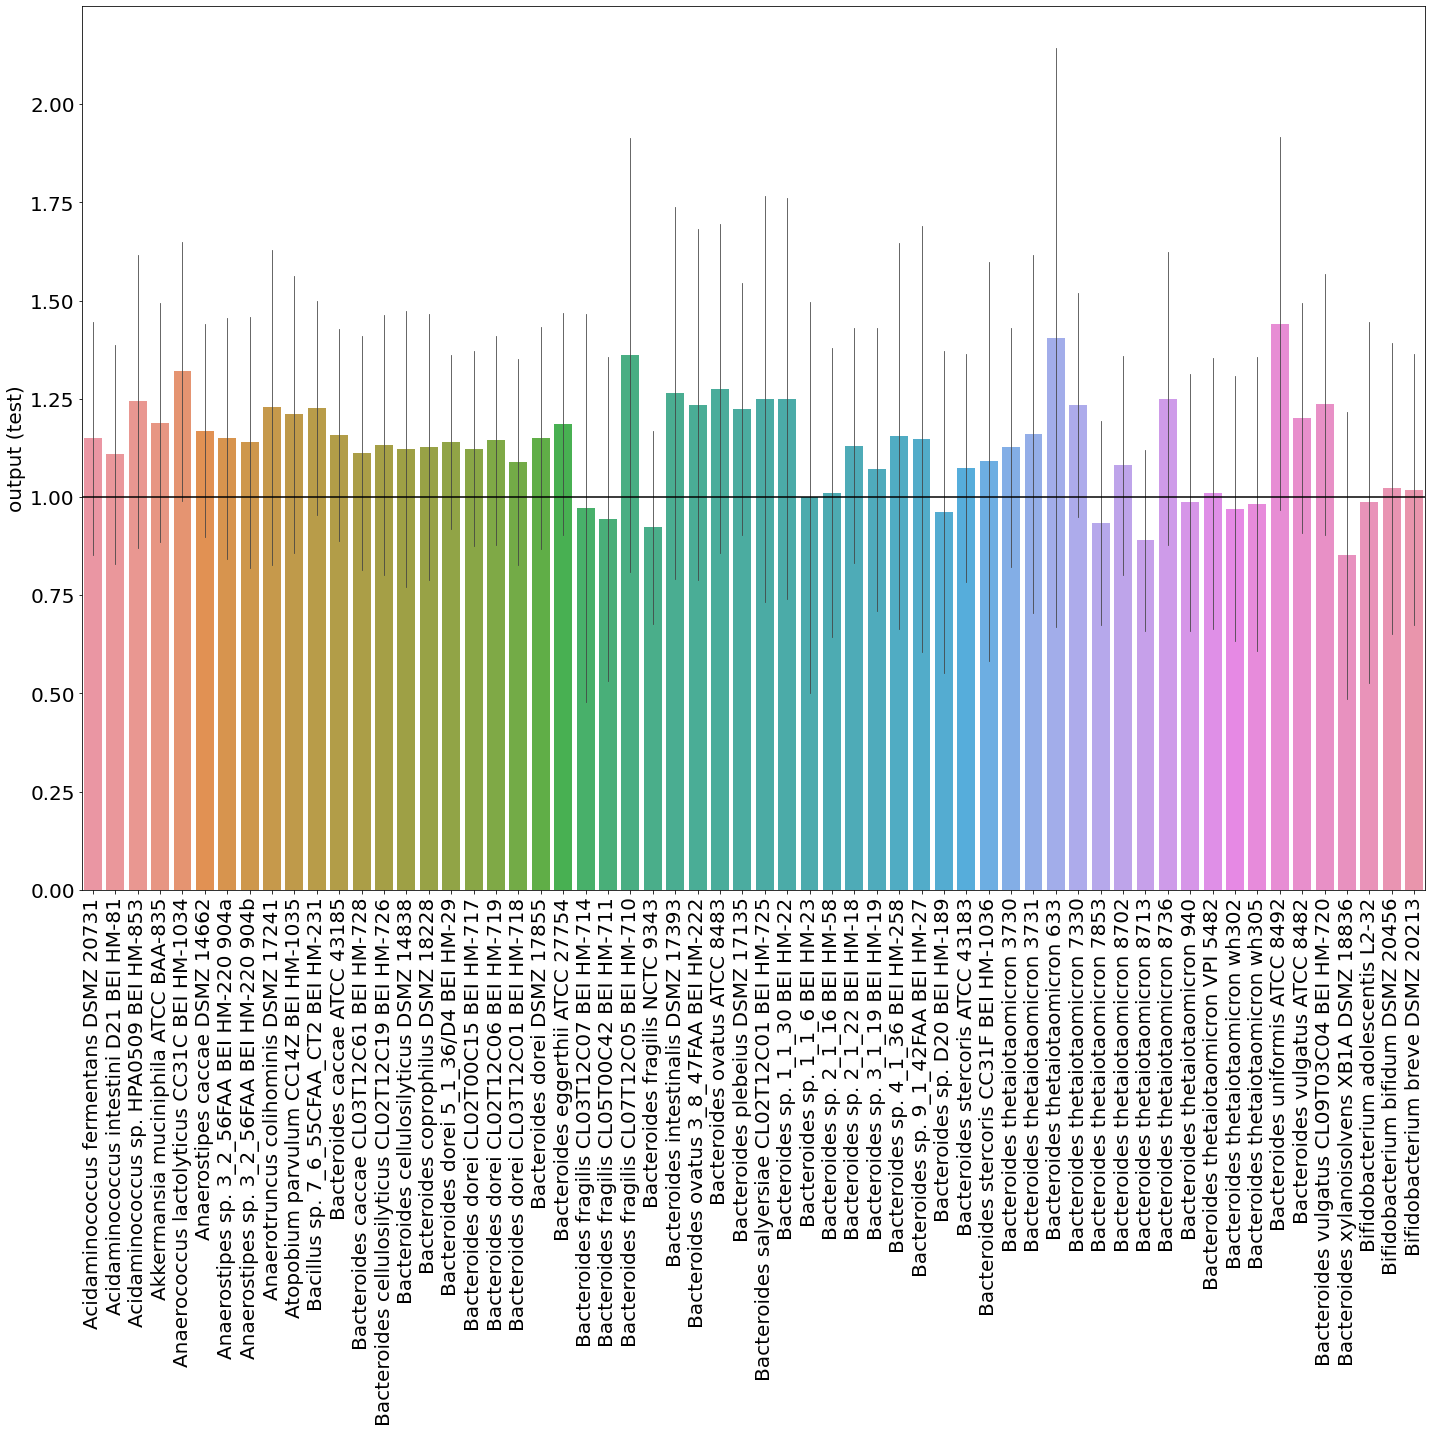

In [446]:
mpl.rcParams['figure.figsize'] = 20, 20
df_output = pd.DataFrame(data={"strain" : species_vec, "output" : output_species_vec})
graph_ = sns.barplot(data=df_output, x="strain", y="output", errorbar="sd", errwidth=0.8)
graph_.axhline(1.00, color="black")
graph_.set_ylabel("output (test)", size = 20)
graph_.set_xlabel(None)
graph_.set_yticklabels(graph_.get_yticklabels(), size=20)
graph_.set_xticklabels(list(df_output['strain'].unique()), rotation=90, size = 20)
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
save_file = os.path.abspath(os.path.join(save_dir, 
                                         f'prediction_vs_fold_test_strain_nFold{nfold}_p{p_}.png'))
plt.tight_layout()
plt.savefig(save_file, dpi=300, transparent=False, facecolor="white")
# sns.barplot(data=df_output, x="passage#", y="output", e)

In [730]:
fold_vec = []
output_vec = []
coeff_nnz_vec = []
for fold_ in range(nfold):
    output_vec += list(output_test[rep_][fold_])
    fold_vec += [fold_] * len(output_test[rep_][fold_])
    coeff_nnz_vec.append(len(np.where(coeff_train[rep_][fold_][0] != 0)[0]))
    
df_output = pd.DataFrame(data={'fold' : fold_vec, 'output' : output_vec})

In [731]:
folds_sorted = np.arange(5)
folds_sorted.sort()
print(folds_sorted)

[0 1 2 3 4]


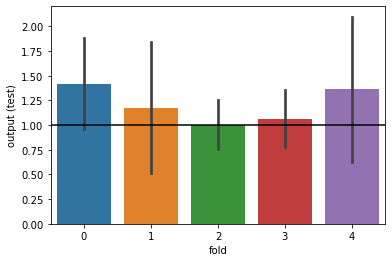

In [734]:
graph_ = sns.barplot(data=df_output, x="fold", y="output", errorbar="sd", 
           order=folds_sorted)
graph_.axhline(1.00, color="black")
graph_.set_ylabel("output (test)")
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
save_file = os.path.abspath(os.path.join(save_dir, 'prediction_vs_fold_test.png'))
plt.savefig(save_file, dpi=300, transparent=False, facecolor="white")
# sns.barplot(data=df_output, x="passage#", y="output", e)

In [539]:
# train nnls model when R_i is estimated for all the metabolites using a randomized order of species 
# abundances
seed_ = 74546
np.random.seed(seed_)
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
num_bioRep = 3
num_rep_nnls = 100

coeff_rand_train = {}
output_rand_test = {}
for rep_ in range(num_rep_nnls):
    print(f'random loop # = {rep_}')
    id_rand = np.arange(df_speciesAbun.shape[0])
    id_rand = np.random.permutation(id_rand)
    
    df_cons_abun_prod_rand = compute_cons_abun_prod(df_speciesMetab=df_speciesMetab.copy(), 
                                       df_speciesAbun=df_speciesAbun.iloc[id_rand, :].copy())
    sample_names, mat_cons_abun_rand_list = \
    compute_species_metab_matrix_for_nnls(df_cons_abun_prod=df_cons_abun_prod_rand, 
                                          df_speciesMetab=df_speciesMetab, 
                                          num_passages=6, num_bioRep=3)
    
    coeff_rand_train[rep_] = {}
    output_rand_test[rep_] = {}
    
    passages_ = np.random.permutation(passages_)
    for pass_ in passages_:
    #     training data
        passages_train = np.array(list(set(passages_.tolist()).difference(set([pass_]))))
        count_ = 0
        for pass__ in passages_train:
            samples_train = expand_passage_by_rep(passage_=pass__, num_bioRep=num_bioRep)
            for sample_ in samples_train:
                A_train_sample = mat_cons_abun_rand_list[sample_]
                if count_ == 0:
                    A_train = A_train_sample
                    count_ += 1
                else:
                    A_train = np.vstack((A_train, A_train_sample))         
        b_train = np.ones((A_train.shape[0]))
        coeff_rand_train[rep_][pass_] = nnls(A_train, b_train) 

    #     test data
        passages_test = np.array([pass_])
        count_ = 0
        for pass__ in passages_test:
            samples_test = expand_passage_by_rep(passage_=pass__, num_bioRep=num_bioRep)
            for sample_ in samples_test:
                A_test_sample = mat_cons_abun_rand_list[sample_]
                if count_ == 0:
                    A_test = A_test_sample
                    count_ += 1
                else:
                    A_test = np.vstack((A_test, A_test_sample))         
        output_rand_test[rep_][pass_] = np.dot(A_test, coeff_rand_train[rep_][pass_][0])
    

random loop # = 0
random loop # = 1
random loop # = 2
random loop # = 3
random loop # = 4
random loop # = 5
random loop # = 6
random loop # = 7
random loop # = 8
random loop # = 9
random loop # = 10
random loop # = 11
random loop # = 12
random loop # = 13
random loop # = 14
random loop # = 15
random loop # = 16
random loop # = 17
random loop # = 18
random loop # = 19
random loop # = 20
random loop # = 21
random loop # = 22
random loop # = 23
random loop # = 24
random loop # = 25
random loop # = 26
random loop # = 27
random loop # = 28
random loop # = 29
random loop # = 30
random loop # = 31
random loop # = 32
random loop # = 33
random loop # = 34
random loop # = 35
random loop # = 36
random loop # = 37
random loop # = 38
random loop # = 39
random loop # = 40
random loop # = 41
random loop # = 42
random loop # = 43
random loop # = 44
random loop # = 45
random loop # = 46
random loop # = 47
random loop # = 48
random loop # = 49
random loop # = 50
random loop # = 51
random loop # = 52
ran

In [552]:
print(output_rand_test[10][passages_[0]])
print(output_test[0][pass_])

[1.06637259 0.98767055 1.04453169 1.02552396 0.90963507 0.94985532
 0.95120818 1.13454033 0.96345329 1.08442883 1.06719909 1.11591284
 1.04567554 1.13008164 0.90821652 1.03124111 1.10018924 1.05646272
 1.14302344 1.04541681 1.04776809 1.29170888 1.01640043 1.03721227
 1.02075255 1.09456307 1.06504555 1.07336001 0.97439453 1.09632896
 0.76904611 1.04418225 0.97561604 1.13487746 0.88648618 0.84061261
 1.10022525 0.89659432 0.96558384 0.87312902 1.00581021 0.88145107
 1.08715871 0.96364931 1.20982539 1.02727283 1.07666627 1.09636071
 1.01028454 1.0215458  0.91470029 0.95294017 1.02146265 0.81585233
 0.84578408 1.05808542 1.06982594 0.86782817 0.98417227 0.67165021
 1.05632372 1.11536535 0.99538508 0.94397955 1.21084948 1.0735738
 0.96871891 0.96747641 0.91423013 0.92231236 1.08815928 0.91755015
 1.08349834 0.9421613  1.04981947 0.98975676 1.02887301 1.07761927
 0.98425136 1.00834305 1.00878269 0.89601707 1.03310223 0.9578972
 1.1685887  1.10109857 1.06782008 0.99170905 0.97600061 0.826894

In [540]:
pass_rand_vec = []
output_rand_vec = []
coeff_nnz_rand_vec = []
for rep_ in range(num_rep_nnls):
    for pass_ in passages_:
        output_rand_vec += list(output_rand_test[rep_][pass_])
        pass_rand_vec += [pass_] * len(output_rand_test[rep_][pass_])
        coeff_nnz_rand_vec.append(len(np.where(coeff_rand_train[rep_][pass_][0] != 0)[0]))
    
df_output = pd.DataFrame(data={'passage#' : pass_rand_vec, 'output' : output_rand_vec})

In [542]:
passages_sorted = np.copy(passages_)
passages_sorted.sort()
print(passages_sorted)

['p1' 'p2' 'p3' 'p4' 'p5' 'p6']


In [269]:
x = list(df_output[df_output['passage#'] == "p1"].loc[:, 'output'])
y = list(df_output[df_output['passage#'] == "p2"].loc[:, 'output'])
corr_ = scipy.stats.pearsonr(x, y)
print(corr_)

(0.10615949353500492, 0.14597919251592534)


In [556]:
np.max(df_output[df_output['passage#'] == "p2"].iloc[:, 1].values)

156.25550567008744

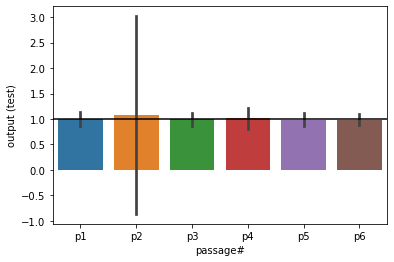

In [543]:
graph_ = sns.barplot(data=df_output, x="passage#", y="output", errorbar="sd", 
           order=passages_sorted)
graph_.axhline(1.00, color="black")
graph_.set_ylabel("output (test)")
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
save_file = os.path.abspath(os.path.join(save_dir, 'prediction_vs_passage#_rand_test.png'))
plt.savefig(save_file, dpi=300, transparent=False, facecolor="white")
# sns.barplot(data=df_output, x="passage#", y="output", e)

In [181]:
data_dict = {}
for pass_ in passages_sorted:
    count_ = 0
    for rep_ in range(num_bioRep):
        id_row = np.arange(rep_ * num_species, (rep_ + 1) * num_species)
        vals_rep_tmp = list(df_output[df_output['passage#'] == pass_].iloc[id_row, 1])
        if count_ == 0:
            vals_rep = np.array(vals_rep_tmp)
            count_ += 1
        else:
            vals_rep += np.array(vals_rep_tmp)
    data_dict[pass_] = list(vals_rep / 3)
#     data_dict[pass_] = list(df_output[df_output['passage#'] == pass_].loc[:, 'output'])
df_output_by_passage = pd.DataFrame(data=data_dict)

In [182]:
df_output_by_passage

p1        p2        p3        p4        p5        p6
0   1.016685  0.955654  1.043712  0.847241  1.043638  0.921340
1   1.062812  1.009769  1.119928  0.998143  1.103196  0.983538
2   0.959336  1.134456  1.043145  1.213049  1.050147  1.148546
3   1.029361  1.081851  1.086255  1.066146  1.106267  1.040860
4   0.923042  0.914586  0.892049  0.853344  0.858656  0.953454
..       ...       ...       ...       ...       ...       ...
58  1.045751  1.069033  1.086046  1.056492  1.070376  1.098973
59  0.880277  0.970154  1.032654  0.960293  0.852255  0.831911
60  1.049946  1.044055  0.884534  1.043745  0.842282  0.978207
61  1.036907  1.005123  0.977854  0.879896  0.913702  1.108300
62  0.908864  0.975095  0.879891  0.853357  0.788732  1.064974

[63 rows x 6 columns]

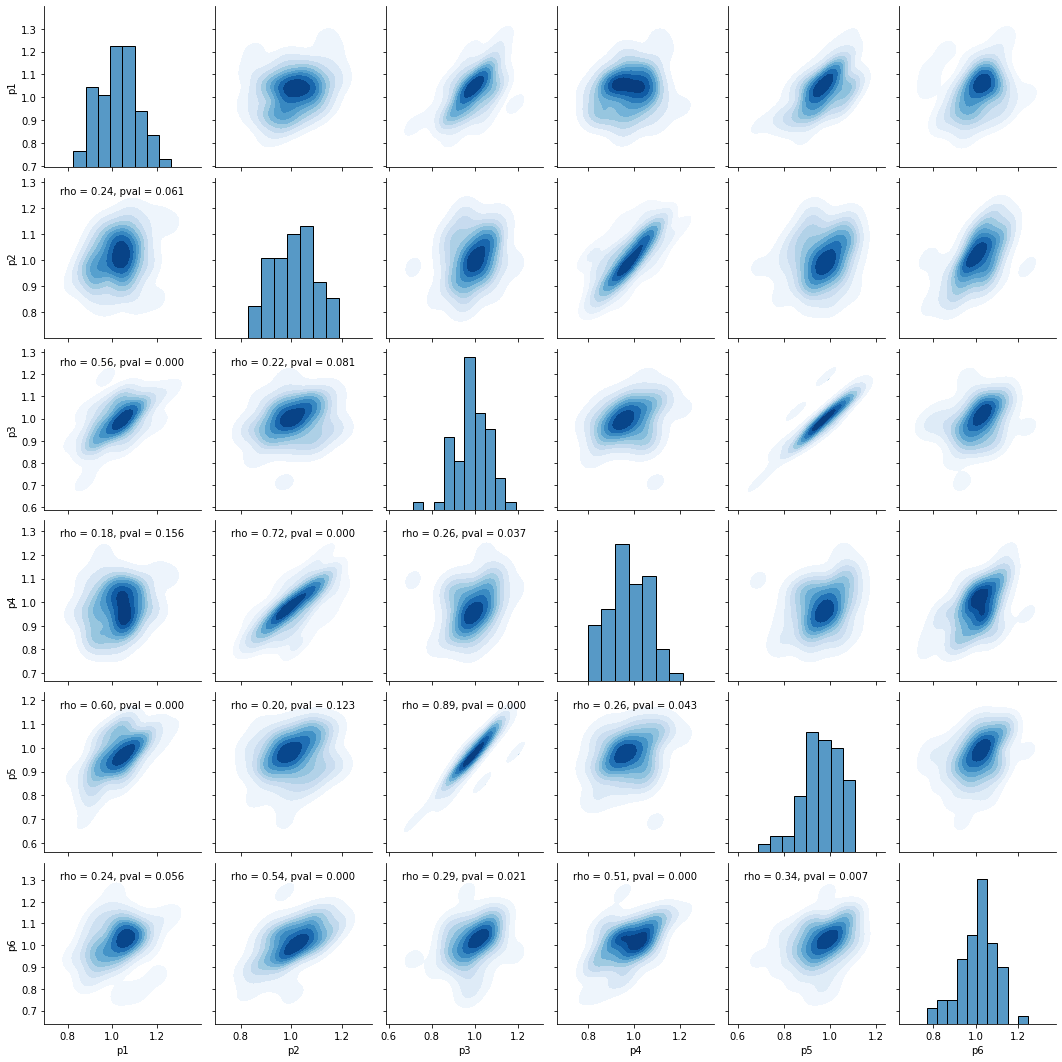

In [190]:
# cormat = df_output_by_passage.corr()
# round(cormat,2)
g_plt = sns.pairplot(df_output_by_passage)
g_plt.map_offdiag(sns.kdeplot, fill=True, cmap="Blues")
g_plt.map_lower(corrfunc)
# g_plt.map_diag(sns.histplot, bins=10)

save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
save_file = os.path.abspath(os.path.join(save_dir, 'corrScatter_prediction_vs_passage#_test.png'))
plt.savefig(save_file, dpi=300, transparent=False, facecolor="white")

In [830]:
rep_ = 0
count_ = 0
for pass_ in passages_:
    if count_ == 0:
        id_nnz = np.where(coeff_train[rep_][pass_][0] != 0)[0]
        count_ += 1
    else:
        id_nnz_tmp = np.where(coeff_train[rep_][pass_][0] != 0)[0]
        id_nnz = list(set(id_nnz_tmp).intersection(set(id_nnz)))

   passage#  #nnz Metabolites                 type
0        p1                76  individual passages
1        p2                79  individual passages
2        p3                82  individual passages
3        p4                79  individual passages
4        p5                81  individual passages
5        p6                85  individual passages
6        p1                65         intersection
7        p2                65         intersection
8        p3                65         intersection
9        p4                65         intersection
10       p5                65         intersection
11       p6                65         intersection


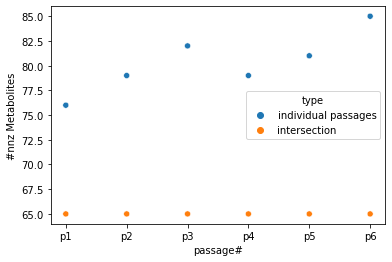

In [114]:
type_ = ['individual passages'] * len(passages_sorted) + ['intersection'] * len(passages_sorted)
passages_vec = list(passages_sorted) + list(passages_sorted)
coeff_nnz_vec_all = coeff_nnz_vec + [len(id_nnz)] * len(coeff_nnz_vec)
df_nnz = pd.DataFrame(data={'passage#' : passages_vec, '#nnz Metabolites' : coeff_nnz_vec_all, 
                            'type' : type_})
# sns.barplot(data=df_nnz, x="passage#", y="#nnz Metabolites", errorbar=None, 
#            order=passages_sorted)
sns.scatterplot(data=df_nnz, x="passage#", y="#nnz Metabolites", hue='type')
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
save_file = os.path.abspath(os.path.join(save_dir, 'nnz_metabs_vs_passage#.png'))
plt.savefig(save_file, dpi=300, transparent=False, facecolor="white")
print(df_nnz)

In [96]:
id_nnz

[1,
 257,
 4,
 5,
 6,
 7,
 9,
 140,
 270,
 143,
 271,
 145,
 275,
 277,
 152,
 25,
 282,
 154,
 156,
 158,
 33,
 291,
 37,
 166,
 169,
 45,
 48,
 50,
 52,
 53,
 180,
 55,
 184,
 57,
 60,
 190,
 192,
 65,
 66,
 195,
 196,
 70,
 198,
 201,
 207,
 81,
 86,
 217,
 220,
 98,
 100,
 230,
 231,
 232,
 123,
 237,
 238,
 112,
 242,
 115,
 120,
 251,
 124,
 125,
 255]

In [83]:
passa

In [84]:
len(id_nnz)

65

In [32]:
scipy.stats.pearsonr(coeff_train[passages_[3]][0], coeff_train[passages_[5]][0])

(0.9790714798916342, 1.491035663724924e-202)

In [110]:
print(len(np.where(output_[passages_[0]][0] != 0)[0]))
print(len(np.where(output_[passages_[4]][0] != 0)[0]))

set(np.where(output_[passages_[4]][0] != 0)[0]).difference(set(np.where(output_[passages_[0]][0] != 0)[0]))

76
81


{13, 16, 121, 137, 147, 155, 206, 218, 236, 288}

In [209]:
mean_cons_abun_prod = df_cons_abun_prod.mean(axis=0)
id_metab_filter = np.argsort(-mean_cons_abun_prod)
thresh_keep_metab = 65

In [213]:
seed_ = 7363
np.random.seed(seed_)
passages_ = np.array(['p1', 'p2', 'p3', 'p4', 'p5', 'p6'])
num_bioRep = 3
num_rep_nnls = 1

coeff_train_filter = {}
output_test_filter = {}
for rep_ in range(num_rep_nnls):
    coeff_train_filter[rep_] = {}
    output_test_filter[rep_] = {}
    
    passages_ = np.random.permutation(passages_)
    for pass_ in passages_:
    #     training data
        passages_train = np.array(list(set(passages_.tolist()).difference(set([pass_]))))
        count_ = 0
        for pass__ in passages_train:
            samples_train = expand_passage_by_rep(passage_=pass__, num_bioRep=num_bioRep)
            for sample_ in samples_train:
                A_train_sample = mat_cons_abun_list[sample_][:, id_metab_filter[range(thresh_keep_metab)]]
                if count_ == 0:
                    A_train = A_train_sample
                    count_ += 1
                else:
                    A_train = np.vstack((A_train, A_train_sample))         
        b_train = np.ones((A_train.shape[0]))
        coeff_train_filter[rep_][pass_] = nnls(A_train, b_train) 

    #     test data
        passages_test = np.array([pass_])
        count_ = 0
        for pass__ in passages_test:
            samples_test = expand_passage_by_rep(passage_=pass__, num_bioRep=num_bioRep)
            for sample_ in samples_test:
                A_test_sample = mat_cons_abun_list[sample_][:, id_metab_filter[range(thresh_keep_metab)]]
                if count_ == 0:
                    A_test = A_test_sample
                    count_ += 1
                else:
                    A_test = np.vstack((A_test, A_test_sample))         
        output_test_filter[rep_][pass_] = np.dot(A_test, coeff_train_filter[rep_][pass_][0])
    

In [266]:
metabs_desc = list(df_metabNames.iloc[df_metabIds.iloc[id_metab_filter[range(65)], 0], 1])
metabs_nnz = list(df_metabNames.iloc[df_metabIds.iloc[id_nnz, 0], 1])

print(list(set(metabs_nnz).intersection(set(metabs_desc))))
print(len(list(set(metabs_nnz).intersection(set(metabs_desc)))))

['VALINE', 'GLYCYL-GLYCINE', 'ORNITHINE', "ADENOSINE 2',3'-CYCLIC MONOPHOSPHATE", 'SERINE', 'ACETYL-CARNITINE', 'TARTARIC ACID', "S-(5'-ADENOSYL)-L-HOMOCYSTEINE", 'CHOLINE', 'IS_D15-OCTANOIC ACID', 'N-ACETYL-5-HYDROXYTRYPTAMINE', 'PANTOTHENIC ACID', 'LEUCINE', '2-HYDROXY-4-METHYLPENTANOIC ACID', 'INDOLE-3-ACETALDEHYDE', '4-GUANIDINOBUTANOIC ACID', 'MALONIC ACID', '2-AMINO-2-METHYLPROPANOIC ACID', "CYTIDINE 2',3'-CYCLIC MONOPHOSPHATE"]
19


In [225]:
ranks_metabs = np.zeros((df_cons_abun_prod.shape[1]))
ranks_metabs[id_metab_filter] = np.arange(df_cons_abun_prod.shape[1])
print(np.median(ranks_metabs[id_nnz]))

169.0


In [226]:
pass_vec = []
output_vec = []
coeff_nnz_vec = []
for pass_ in passages_:
    output_vec += list(output_test_filter[rep_][pass_])
    pass_vec += [pass_] * len(output_test_filter[rep_][pass_])
    coeff_nnz_vec.append(len(np.where(coeff_train_filter[rep_][pass_][0] != 0)[0]))
    
df_output_filter = pd.DataFrame(data={'passage#' : pass_vec, 'output' : output_vec})

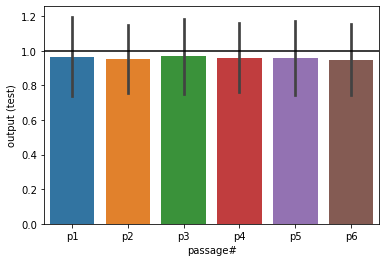

In [227]:
graph_ = sns.barplot(data=df_output_filter, x="passage#", y="output", errorbar="sd", 
           order=passages_sorted)
graph_.axhline(1.00, color="black")
graph_.set_ylabel("output (test)")
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
save_file = os.path.abspath(os.path.join(save_dir, 'prediction_vs_passage#_test.png'))
plt.savefig(save_file, dpi=300, transparent=False, facecolor="white")
# sns.barplot(data=df_output, x="passage#", y="output", e)

In [228]:
rep_ = 0
count_ = 0
for pass_ in passages_:
    if count_ == 0:
        id_nnz_filter = np.where(coeff_train_filter[rep_][pass_][0] != 0)[0]
        count_ += 1
    else:
        id_nnz_tmp = np.where(coeff_train_filter[rep_][pass_][0] != 0)[0]
        id_nnz_filter = list(set(id_nnz_tmp).intersection(set(id_nnz)))

   passage#  #nnz Metabolites                 type
0        p1                26  individual passages
1        p2                27  individual passages
2        p3                28  individual passages
3        p4                28  individual passages
4        p5                28  individual passages
5        p6                27  individual passages
6        p1                 9         intersection
7        p2                 9         intersection
8        p3                 9         intersection
9        p4                 9         intersection
10       p5                 9         intersection
11       p6                 9         intersection


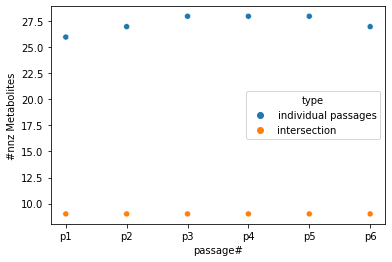

In [232]:
type_ = ['individual passages'] * len(passages_sorted) + ['intersection'] * len(passages_sorted)
passages_vec = list(passages_sorted) + list(passages_sorted)
coeff_nnz_vec_all = coeff_nnz_vec + [len(id_nnz_filter)] * len(coeff_nnz_vec)
df_nnz = pd.DataFrame(data={'passage#' : passages_vec, '#nnz Metabolites' : coeff_nnz_vec_all, 
                            'type' : type_})
# sns.barplot(data=df_nnz, x="passage#", y="#nnz Metabolites", errorbar=None, 
#            order=passages_sorted)
sns.scatterplot(data=df_nnz, x="passage#", y="#nnz Metabolites", hue='type')
save_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'figures'))
save_file = os.path.abspath(os.path.join(save_dir, 'nnz_metabs_vs_passage#.png'))
plt.savefig(save_file, dpi=300, transparent=False, facecolor="white")
print(df_nnz)

In [251]:
id_pass = 2
id_tmp = np.where(coeff_train_filter[rep_][passages_[id_pass]][0] != 0)[0]

metabs_tmp = list(df_metabNames.iloc[df_metabIds.iloc[id_tmp, 0], 1])
metabs_nnz = list(df_metabNames.iloc[df_metabIds.iloc[id_nnz, 0], 1])

print(list(set(metabs_nnz).intersection(set(metabs_tmp))))
print(len(list(set(metabs_nnz).intersection(set(metabs_tmp)))))

['VALINE', 'SUCROSE', 'IS_D19-DECANOIC ACID', 'TIGLYL GLYCINE', 'IS_4-CHLORO-PHENYLALANINE', '2-AMINO-2-METHYLPROPANOIC ACID', '2-HYDROXY-4-METHYLPENTANOIC ACID', '4-SULFOOXYBENZOIC ACID', 'IS_TRIDECANOIC ACID']
9


In [255]:
 list(df_metabNames.iloc[df_metabIds.iloc[id_metab_filter, 0], 1])

['GLYCEROL 2-PHOSPHATE',
 'ACETYL-CARNITINE',
 "ADENOSINE 2',3'-CYCLIC MONOPHOSPHATE",
 'ASPARTIC ACID',
 '4-AMINOBENZOIC ACID',
 'TARTARIC ACID',
 'GLYCYL-GLYCINE',
 'GUANOSINE',
 'N-ACETYL-5-HYDROXYTRYPTAMINE',
 'LEUCINE',
 'URIDINE-5-MONOPHOSPHATE',
 'ASPARAGINE',
 'N-ACETYLPUTRESCINE',
 'CHOLINE',
 'SN-GLYCERO-3-PHOSPHOCHOLINE',
 'STEARIC ACID',
 '1-OLEOYL-RAC-GLYCEROL',
 'GLUCONO-1,5-LACTONE',
 '4-ETHYLOCTANOIC ACID',
 'METHYLMALONIC ACID',
 '2-ETHYL-2-HYDROXYBUTYRIC ACID',
 'ISOVALERYLGLYCINE',
 'BENZALDEHYDE',
 '1-METHYLGUANIDINE',
 'VALINE',
 'BETAINE',
 '4-GUANIDINOBUTANOIC ACID',
 '2-AMINO-2-METHYLPROPANOIC ACID',
 'ADENOSINE',
 'O-PHOSPHO-SERINE',
 "GUANOSINE 3',5'-CYCLIC MONOPHOSPHATE",
 'ARABINOSE',
 'URIDINE',
 '3-METHYL-2-OXINDOLE',
 '2-HYDROXY-4-METHYLPENTANOIC ACID',
 'MALONIC ACID',
 'GLUTAMINE',
 'N-ACETYLGLYCINE',
 "CYTIDINE 2',3'-CYCLIC MONOPHOSPHATE",
 'GLUCOSE',
 'QUINIC ACID',
 'THYMIDINE',
 'INDOLE-3-ACETALDEHYDE',
 'AGMATINE',
 'VANILLIN',
 'HISTIDINOL',
 'CRO

In [253]:
np.sort(list(df_metabNames.iloc[df_metabIds.iloc[id_nnz, 0], 1]))

array(['1,3-DIMETHYLURACIL', '1,6-ANHYDRO-B-GLUCOSE', '1-METHYLADENOSINE',
       '2-AMINO-2-METHYLPROPANOIC ACID',
       '2-HYDROXY-4-METHYLPENTANOIC ACID', '3,4-DIHYDROXYBENZOATE',
       '4-ACETAMIDOBUTANOIC ACID', '4-AMINOBUTANOIC ACID',
       '4-GUANIDINOBUTANOIC ACID', '4-SULFOOXYBENZOIC ACID',
       '5-AMINOIMIDAZOLE-4-CARBOXAMIDE-1-BETA-RIBOFURANOSIDE',
       'ACETYL-CARNITINE', "ADENOSINE 2',3'-CYCLIC MONOPHOSPHATE",
       'ALPHA-HYDROXYHIPPURIC ACID', 'BIOTIN', 'CATECHOL', 'CHOLINE',
       'CITRIC ACID', 'CYSTEINE', "CYTIDINE 2',3'-CYCLIC MONOPHOSPHATE",
       'DAMP', 'DEHYDROASCORBIC ACID', 'DEOXYCARNITINE', 'DEOXYURIDINE',
       'DIMETHYLBENZIMIDAZOLE', 'FLAVIN ADENINE DINUCLEOTIDE',
       'GLYCYL-GLYCINE', 'INDOLE-3-ACETALDEHYDE', 'INDOLEPROPIONIC ACID',
       'IS_4-BROMO-PHENYLALANINE', 'IS_4-CHLORO-PHENYLALANINE',
       'IS_4-HYDROXYPHENYL-D4-ALANINE', 'IS_D15-OCTANOIC ACID',
       'IS_D15-OCTANOIC ACID', 'IS_D19-DECANOIC ACID',
       'IS_D27-TETRADECANOIC A